In [1]:
## things added to format for paper
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import pyplot as pltf
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
fsize = 20
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=fsize)  # controls default text sizes
plt.rc('axes', titlesize=20)  # fontsize of the axes title
plt.rc('axes', labelsize=20)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.rc('legend', fontsize=14)  # legend fontsize
plt.rc('figure', titlesize=fsize)  # fontsize of the figure title

In [2]:
import os
import numpy as np
import seaborn as sns
#sns.set_palette("husl")
import matplotlib
import pandas as pd
import torch
import models.dcgan as dcgan
import torchvision
from torchvision.utils import make_grid
from scipy.stats import wasserstein_distance
import torchvision.transforms as transforms

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:800% !important; }</style>"))

def batch_upper_left(tensor,m): # in: (batch_size,1,n,n) out: upper left (batch_size, 1, m, m)
    return torch.Tensor.narrow(torch.Tensor.narrow(tensor,3,0,m),2,0,m)

def histogram(df_column, title, xlabel = '', kde = False, norm_hist = True, show = True, log10 = True, ylim = None,xlim=None,filename = '',dpi=500):
    sns.set_style("darkgrid")
    if log10:
        df_column = np.log10(df_column)
        df_column = df_column.replace([np.inf, -np.inf], np.nan)
        df_column = df_column.dropna()
        df_column = df_column.tolist()
        #print type(df_column)
        plot = sns.distplot(df_column, kde = kde, norm_hist = norm_hist, label = None)
    else:
        df_column = df_column.tolist()
        plot = sns.distplot(df_column, kde = kde, norm_hist = norm_hist, label = None)
    if title != '': plt.title(title)
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
    if xlabel != '': plt.xlabel(xlabel) #xlabel(r'$\mathrm{Number\,\, of\,\, steps}$') 
    if ylim != None: plt.ylim(ylim)
    if xlim != None: plt.xlim(xlim)
    if filename != '': plt.savefig(filename,dpi=dpi,bbox_inches='tight',pad_inches=0.1)
    if show:
        plt.show()
    return plot

def histograms(df_columns, labels, kde = False, norm_hist = True, show_together = True, show_separate = False, log10 = True):
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    plt.legend(prop={'size':12})
    for idx, df_column in enumerate(df_columns): 
        histogram(df_column, labels[idx], kde = kde, norm_hist = norm_hist, show = show_separate, log10 = log10)
    if show_together: 
        plt.show()

# isize: imageSize, nz: size of latent z vector,ng
def load_DCGAN(filepath, h11 = None, nz=100, nc=1, ngf=64, ngpu=0, n_extra_layers=0):
    if h11 == None: h11 = int(filepath.split('/')[0].split('_')[2])
    epoch = int(filepath.split('/')[-1].split('_')[-1].split('.')[0])
    isize = (h11-h11%16)+16
    netG = dcgan.DCGAN_G(isize, nz=nz, nc=nc, ngf=ngf, ngpu=ngpu, n_extra_layers=n_extra_layers)
    dcgan.DCGAN_G.load_state_dict(netG,torch.load(filepath, map_location='cpu'))
    return (h11,epoch,netG)

def gen_matrices(GAN, noise = None, batchSize = 64, nz = 100):
    if type(noise) == type(None):
        noise = torch.FloatTensor(batchSize, nz, 1, 1)
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
    return GAN(noise)

def gen_wishart_matrices(h11, batchSize = 64):
    A = torch.randn(batchSize,h11,h11)
    AT = torch.transpose(A,1,2)
    return torch.bmm(AT,A)/torch.tensor(1.0*h11)

def ensemble_eigenvalues(data_tensor): # data_tensor is batch of matrices
    eigs = []
    for matrix in data_tensor:
        img_size = matrix.shape[1]
        matrix = matrix.view(img_size,img_size).detach().numpy()
        eigs.extend(np.linalg.eig(matrix)[0])
    return eigs

def show_images(tensor, nrow=8, padding=2, dpi=500,
               normalize=False, range=None, scale_each=False, pad_value=0, scale_factor=1, title = '', xlabel = '', filename = ''):
    sns.set_style("white")
    tensor.data = tensor.data.mul(0.5).add(0.5)
    
    size = tensor.shape[2]
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=scale_factor*size),
        transforms.ToTensor()
    ])
    tensor = [transform(x_) for x_ in tensor]
    img = torchvision.utils.make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    npimg = img.detach().numpy()
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.yticks([])
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
    if xlabel != '': plt.xlabel(xlabel) #xlabel(r'$\mathrm{Number\,\, of\,\, steps}$')
    if title != '': plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    if filename != '': plt.savefig(filename,dpi=dpi,bbox_inches='tight',pad_inches=0.1)
    plt.show()
    
def show_GAN_image_sequence(GANlist, batchSize = 64, nz = 100, scale_factor = 1, dpi = 500):
    fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1)
    fixed_noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
    for h11, epoch, GAN in GANlist:
        print "(h11, epoch):", (h11,epoch)
        show_images(gen_matrices(GAN, noise = fixed_noise, nz=nz), scale_factor = scale_factor, \
                    dpi = dpi, xlabel = r'$\mathrm{Epoch \,\,} ' + str(epoch) +'$', \
                   filename = 'images_for_paper/h11_' + str(h11) + '_nz_' +str(nz)+'_epoch_'+str(epoch)+'.png',
                   title =  r'$h^{11} = ' + str(h11) + ',\,\,\, n_z = ' + str(nz) +"$")
        
def show_GAN_histogram(GAN, h11, nz = 100, dpi=500, noise = None, inverse_wishart = False, batchSize = 10000, kde = False, display_wishart = True, norm_hist = True, show = True, log10 = True, ylim = None, xlim = None):
    data_tensor = gen_matrices(GAN, noise = noise, batchSize = batchSize, nz = nz)
    data_tensor = batch_upper_left(data_tensor, h11)
    eigs = ensemble_eigenvalues(data_tensor)
    wishart_eigs = ensemble_eigenvalues(gen_wishart_matrices(h11,batchSize))
    if inverse_wishart:
        wishart_eigs = [1/k for k in wishart_eigs]
    
    log_eigs, log_wishart_eigs, log_real_eigs = [k for k in np.log10(eigs) if k not in [np.nan, np.inf, -np.inf]], [k for k in np.log10(wishart_eigs) if k not in [np.nan, np.inf, -np.inf]], [k for k in np.log10(np.array(real_eig_dfs[h11])) if k not in [np.nan, np.inf, -np.inf]]
    nologdist, logdist = wasserstein_distance(eigs,real_eig_dfs[h11]), wasserstein_distance(log_eigs, log_real_eigs)
    print "Wasserstein Distance GAN (no log, log):", nologdist, logdist
    print "Wasserstein Distance Wishart (no log, log):", wasserstein_distance(wishart_eigs,real_eig_dfs[h11]), wasserstein_distance(log_wishart_eigs, log_real_eigs)
    if log10:
        dist = logdist
    else:
        dist = nologdist
    
    title = r'$h^{11} = ' + str(h11) + ',\,\,\, n_z = ' + str(nz) +",\,\,\, \mathrm{\,\,\, \\\\ Distance = }" + str(round(dist,2)) + "$"
    xlabel = r'$\mathrm{log}_{10}(\mathrm{Eigenvalue})$'
    
    histogram(real_eig_dfs[h11], title=title, show = False, log10 = log10, norm_hist = norm_hist)
    if display_wishart:
        histogram(pd.DataFrame({h11: wishart_eigs})[h11], title=title, kde = kde, norm_hist = norm_hist, show = False, log10 = log10)
    histogram(pd.DataFrame({h11: eigs})[h11], title=title, kde = kde, norm_hist = norm_hist, show = show, log10 = log10, ylim=ylim, xlim=xlim, \
             filename = 'images_for_paper/h11_' + str(h11) + '_nz_' +str(nz)+'_epoch_'+str(epoch)+'_plot.png', xlabel = xlabel, dpi=dpi)
    
    return wasserstein_distance(eigs,real_eig_dfs[h11]), wasserstein_distance(wishart_eigs,real_eig_dfs[h11]), wasserstein_distance(log_eigs,log_real_eigs)

In [10]:
import os
import cPickle as pickle

num_geometries = 3000
real_eigs = {}
for h11 in (10,20,30,40,50):
    files_list = [d for d in os.listdir('../../KS4/data') if "_"+str(h11)+"_" in d and '_' in d and 'evals' in d]
    train_list = files_list[:num_geometries]
    test_list = [t for t in files_list if t not in train_list]
    print "h11, NUM TRAIN, NUM TEST:", h11, len(train_list), len(test_list)
    
    cur_evals = []
    for test_file in test_list:
        cur_evals.extend(pickle.load(open('../../KS4/data/'+test_file,'r')))
    real_eigs[h11] = cur_evals

    print 'at h11 =', h11, 'have #eigs=', len(cur_evals)
    
for h11 in (10,20,30,40,50):
    print h11,len(real_eigs[h11])

h11, NUM TRAIN, NUM TEST: 10 3000 6282
at h11 = 10 have #eigs= 62820
h11, NUM TRAIN, NUM TEST: 20 3000 2796
at h11 = 20 have #eigs= 55920
h11, NUM TRAIN, NUM TEST: 30 3000 1222
at h11 = 30 have #eigs= 36660
h11, NUM TRAIN, NUM TEST: 40 3000 2520
at h11 = 40 have #eigs= 100800
h11, NUM TRAIN, NUM TEST: 50 3000 2899
at h11 = 50 have #eigs= 144950
10 62820
20 55920
30 36660
40 100800
50 144950


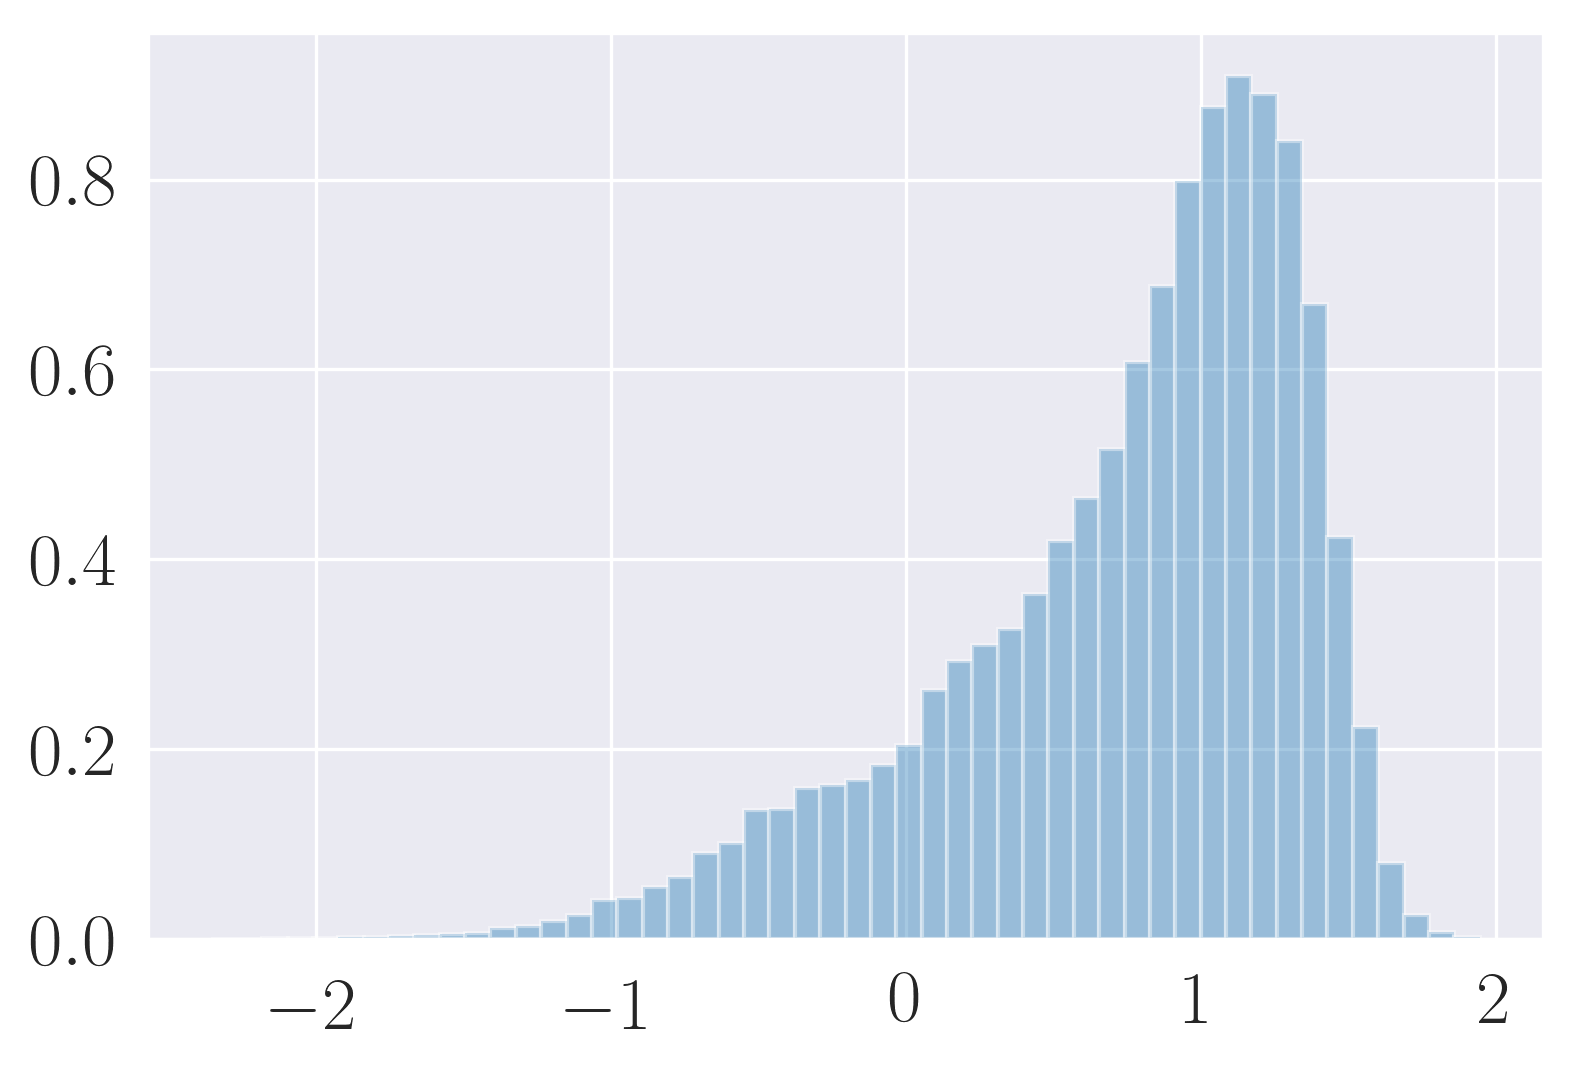

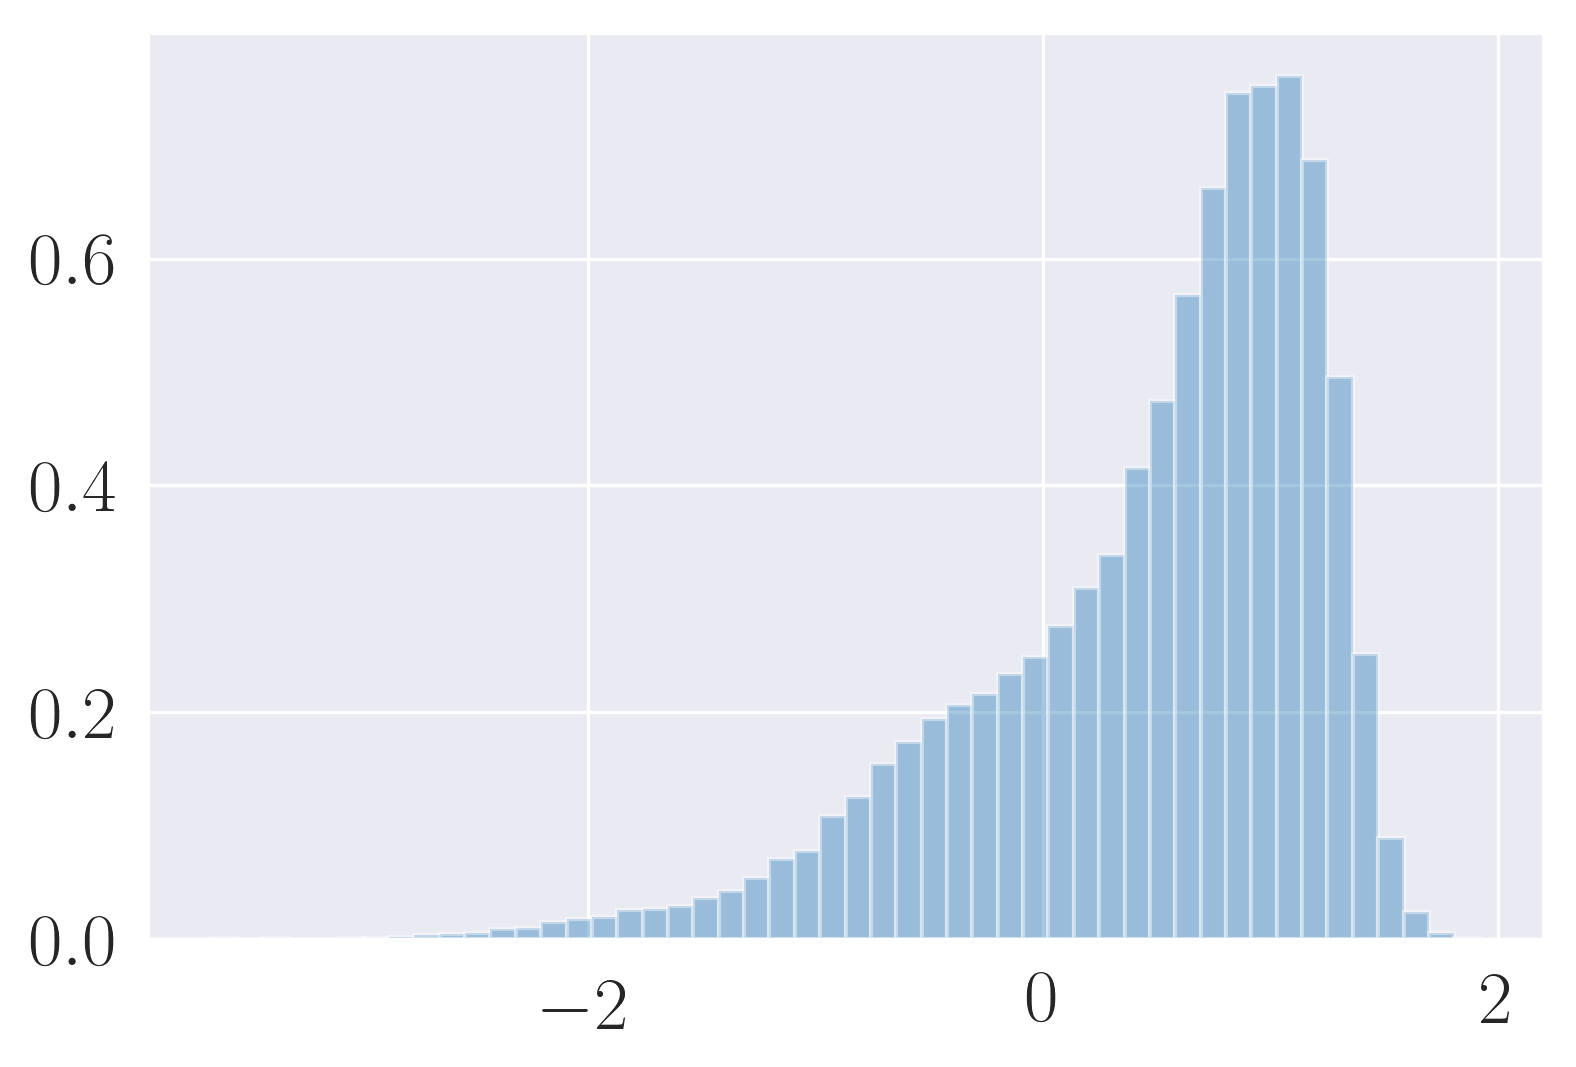

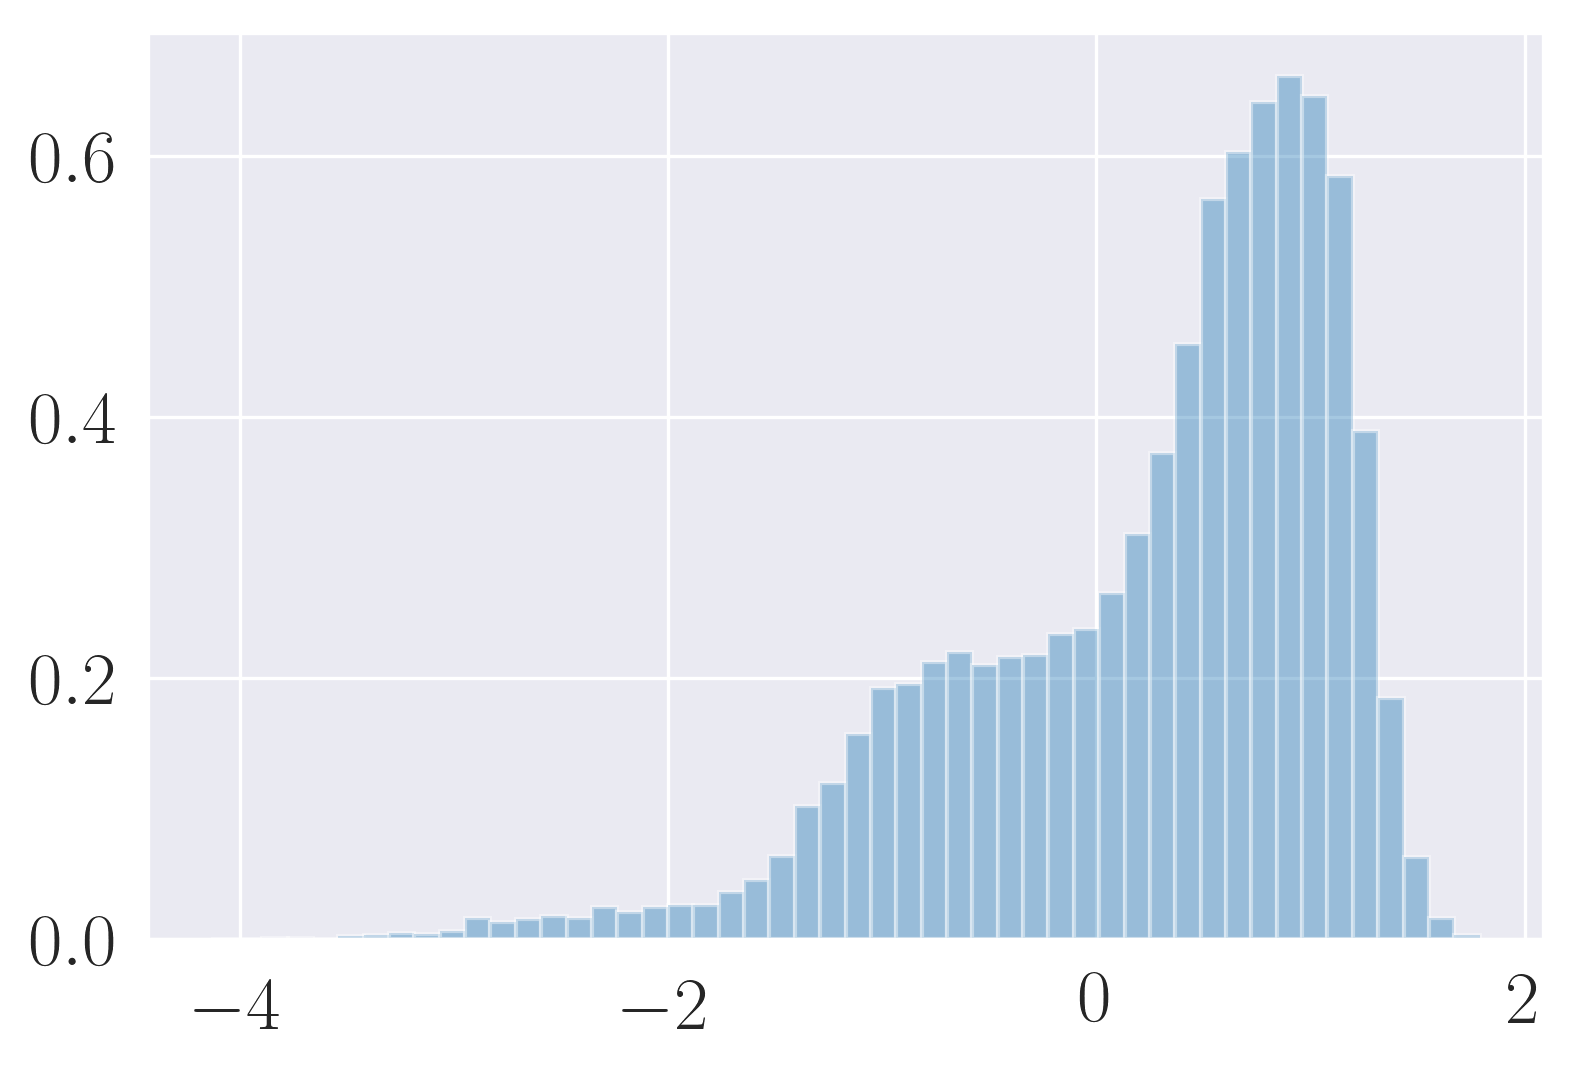

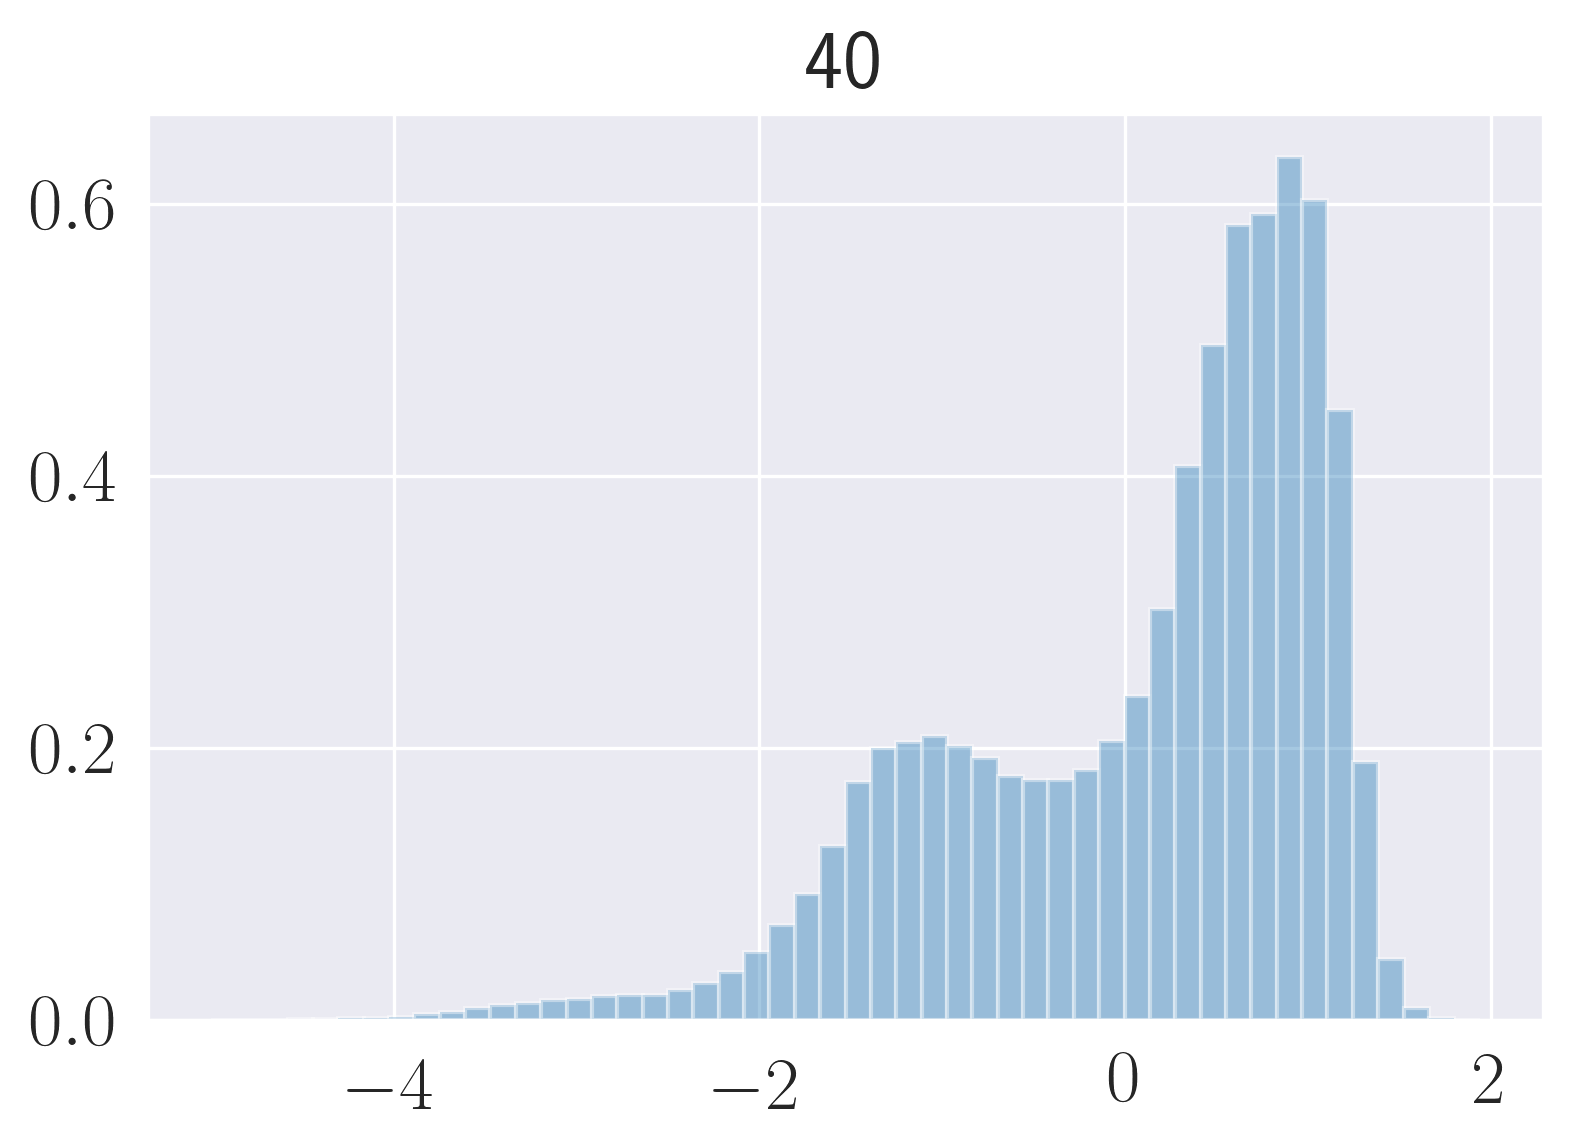

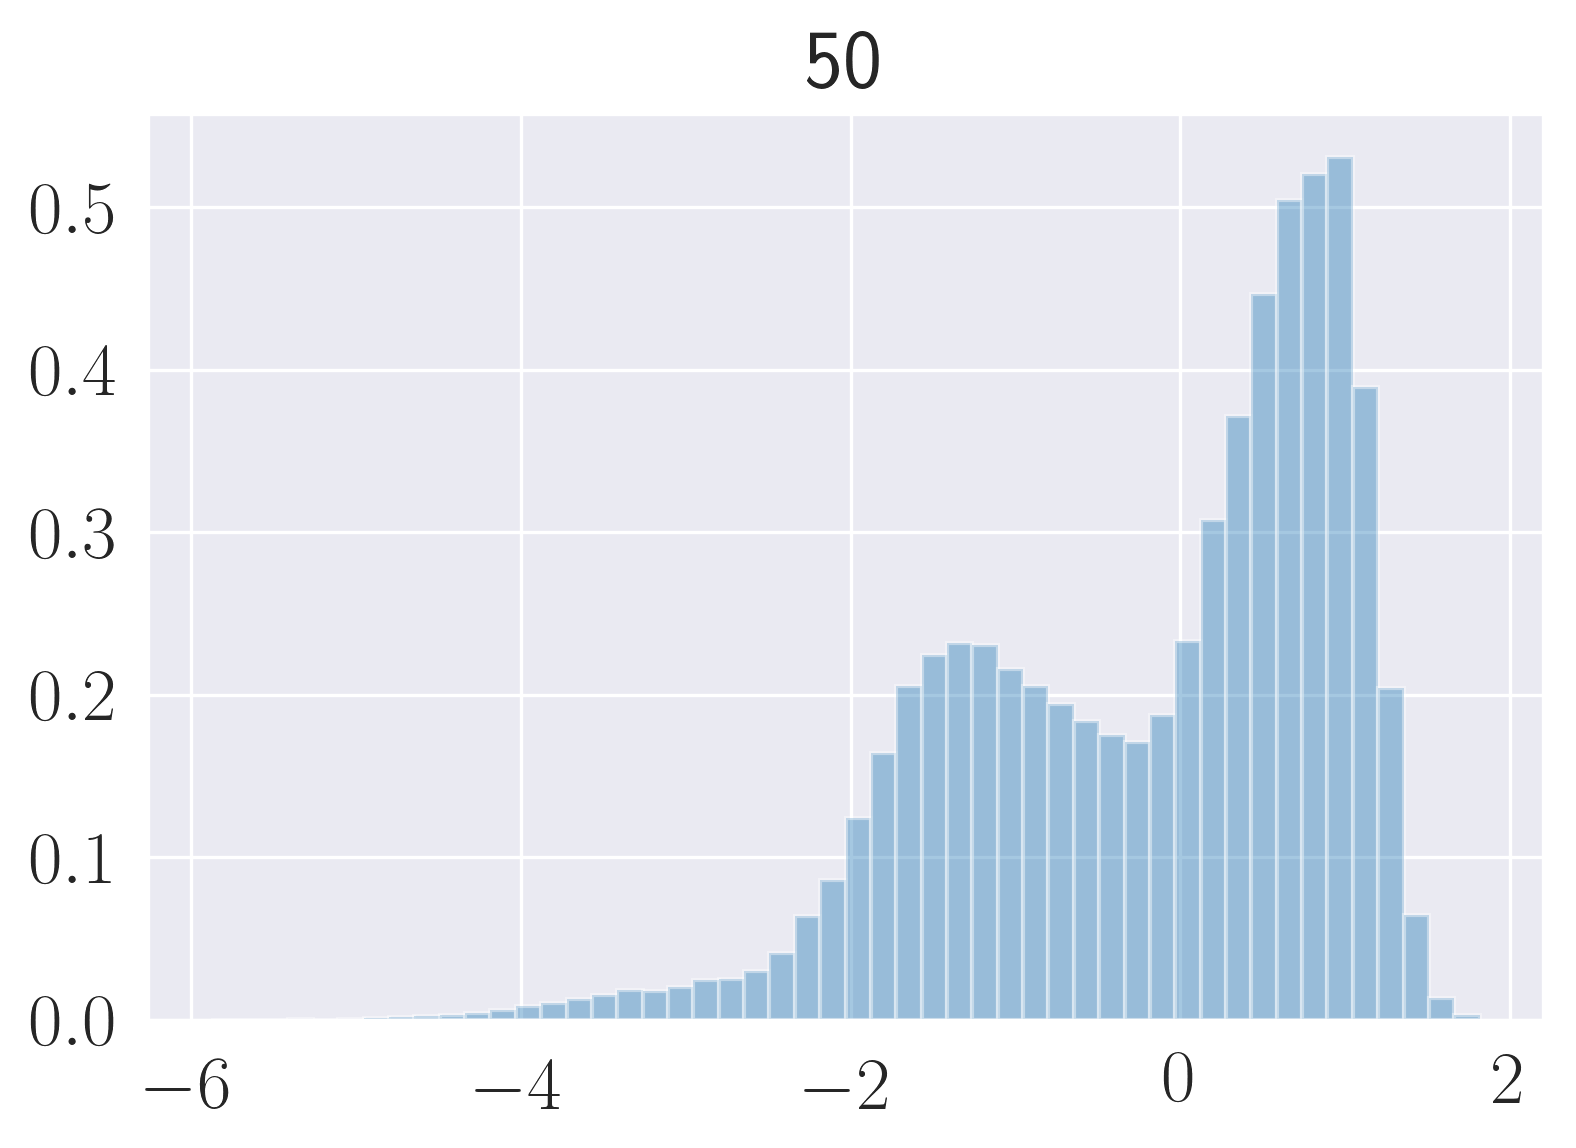

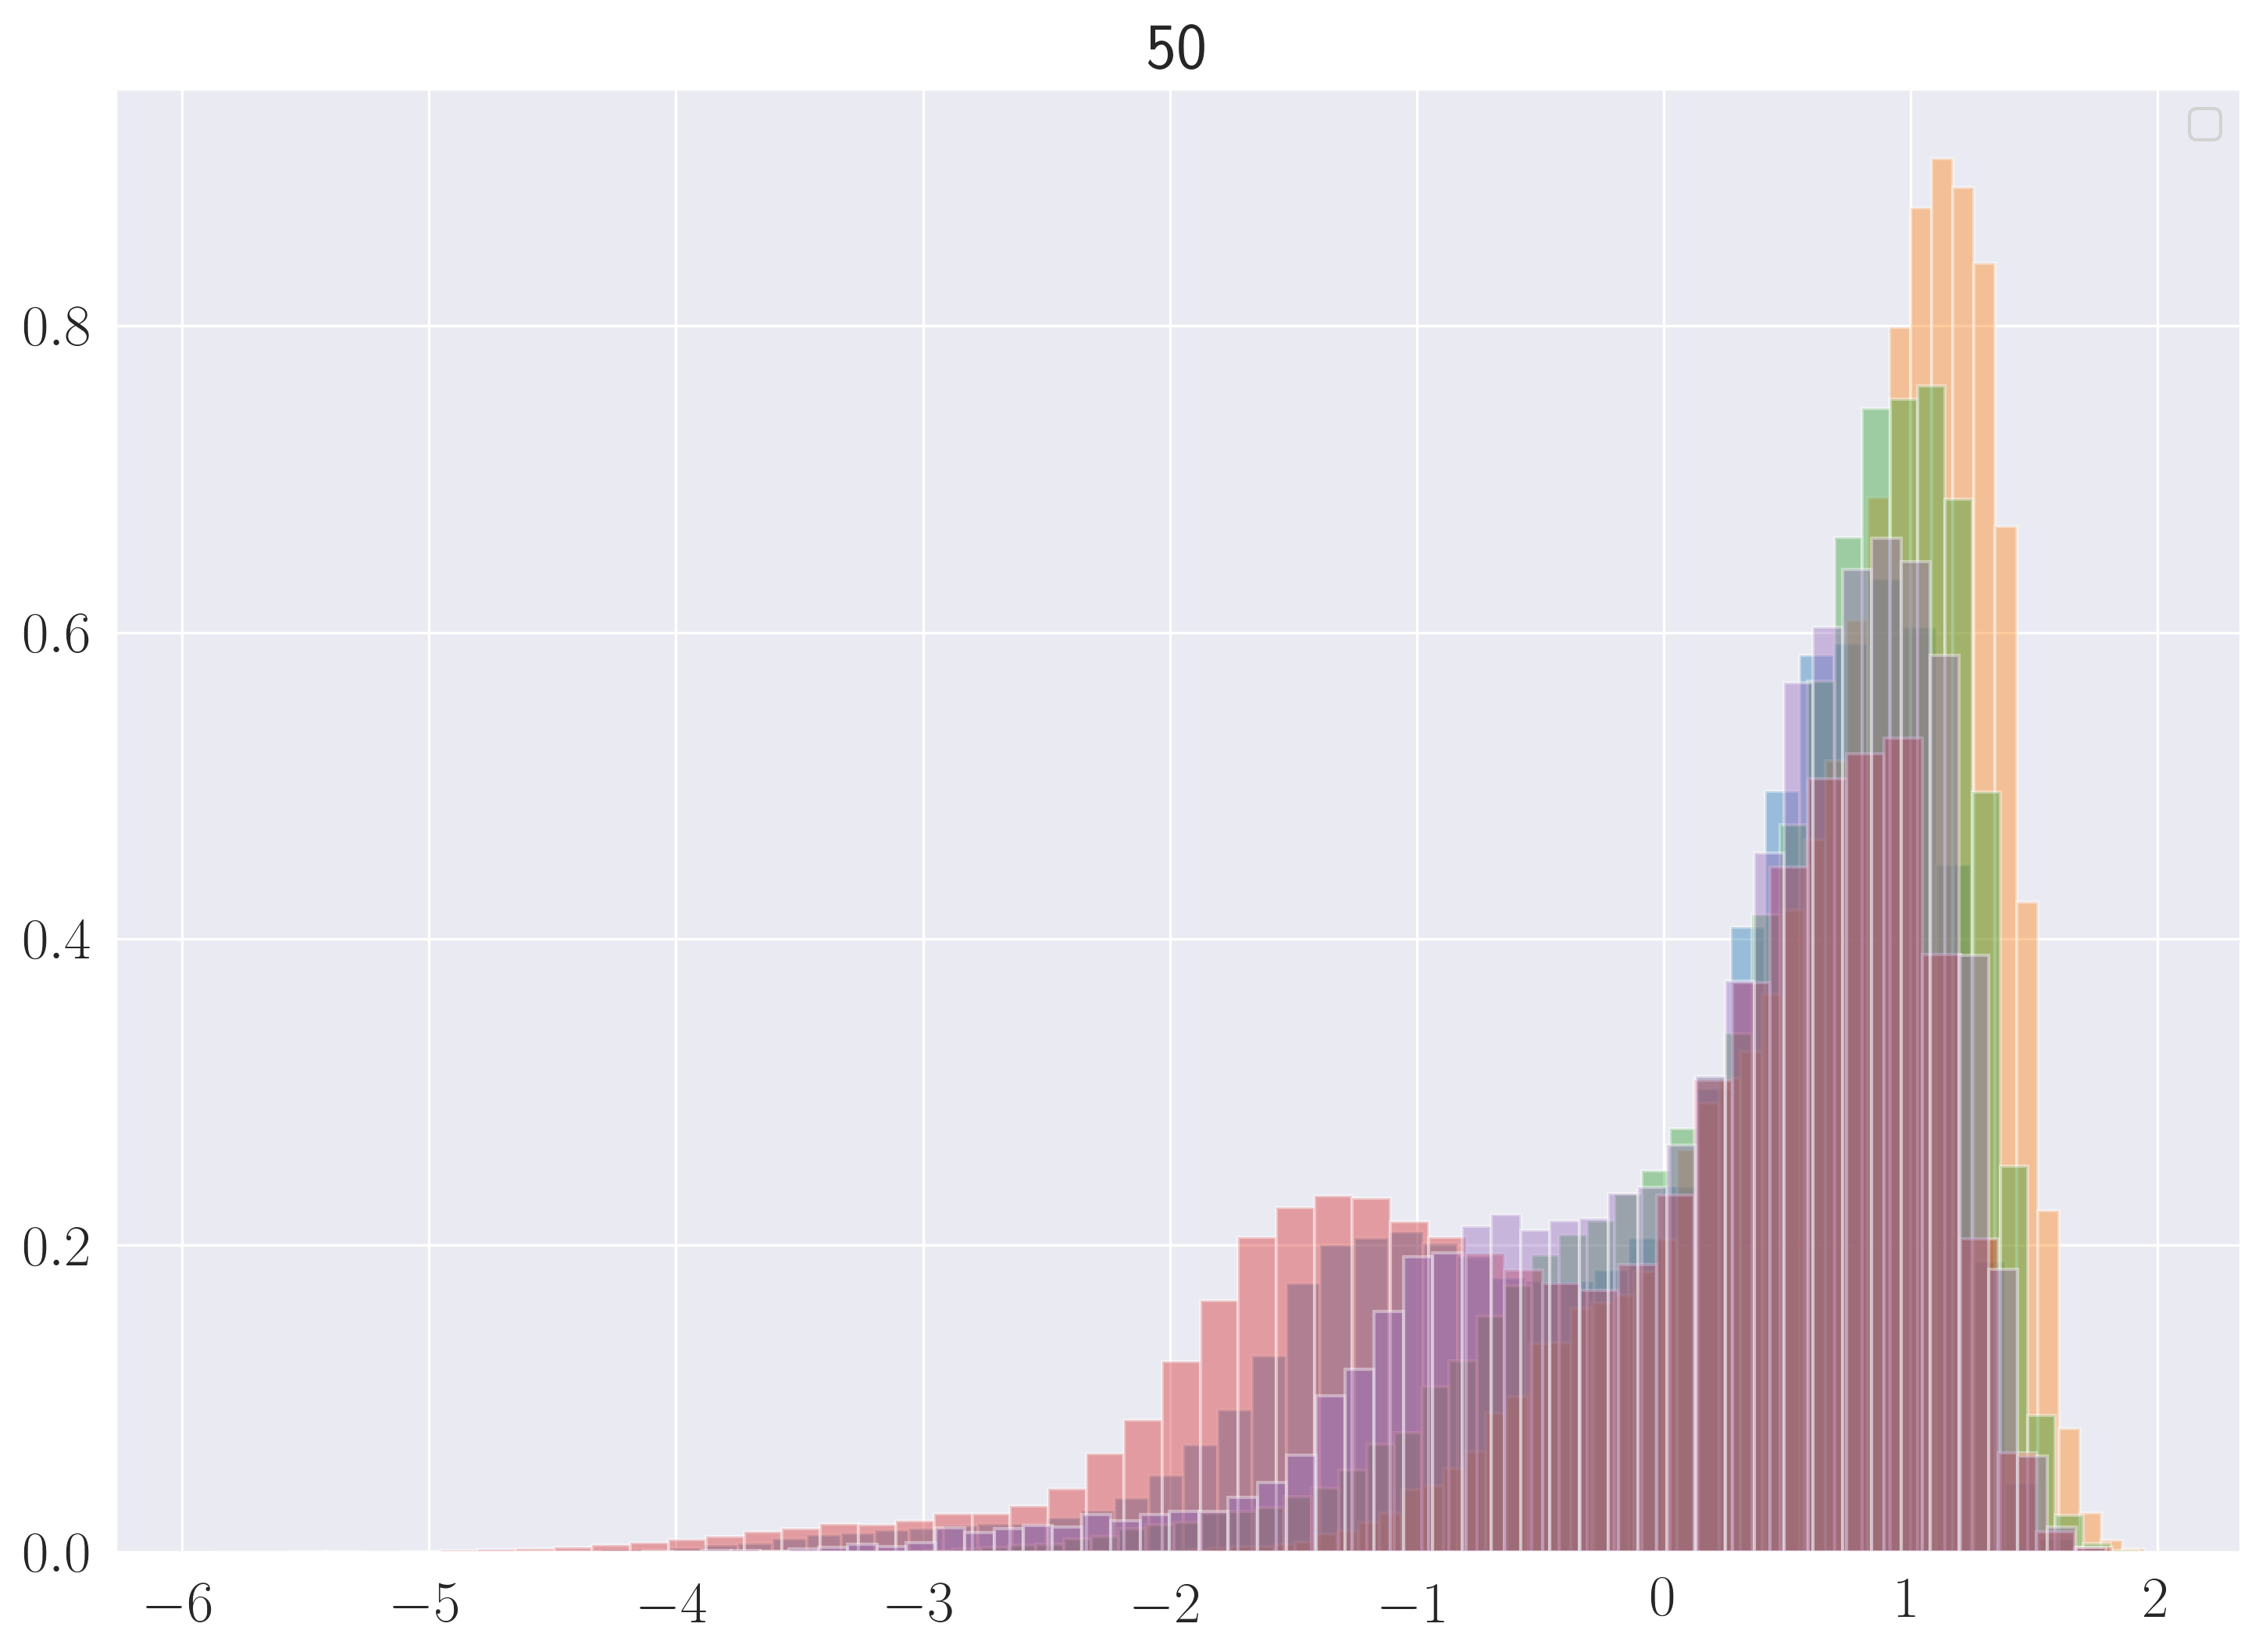

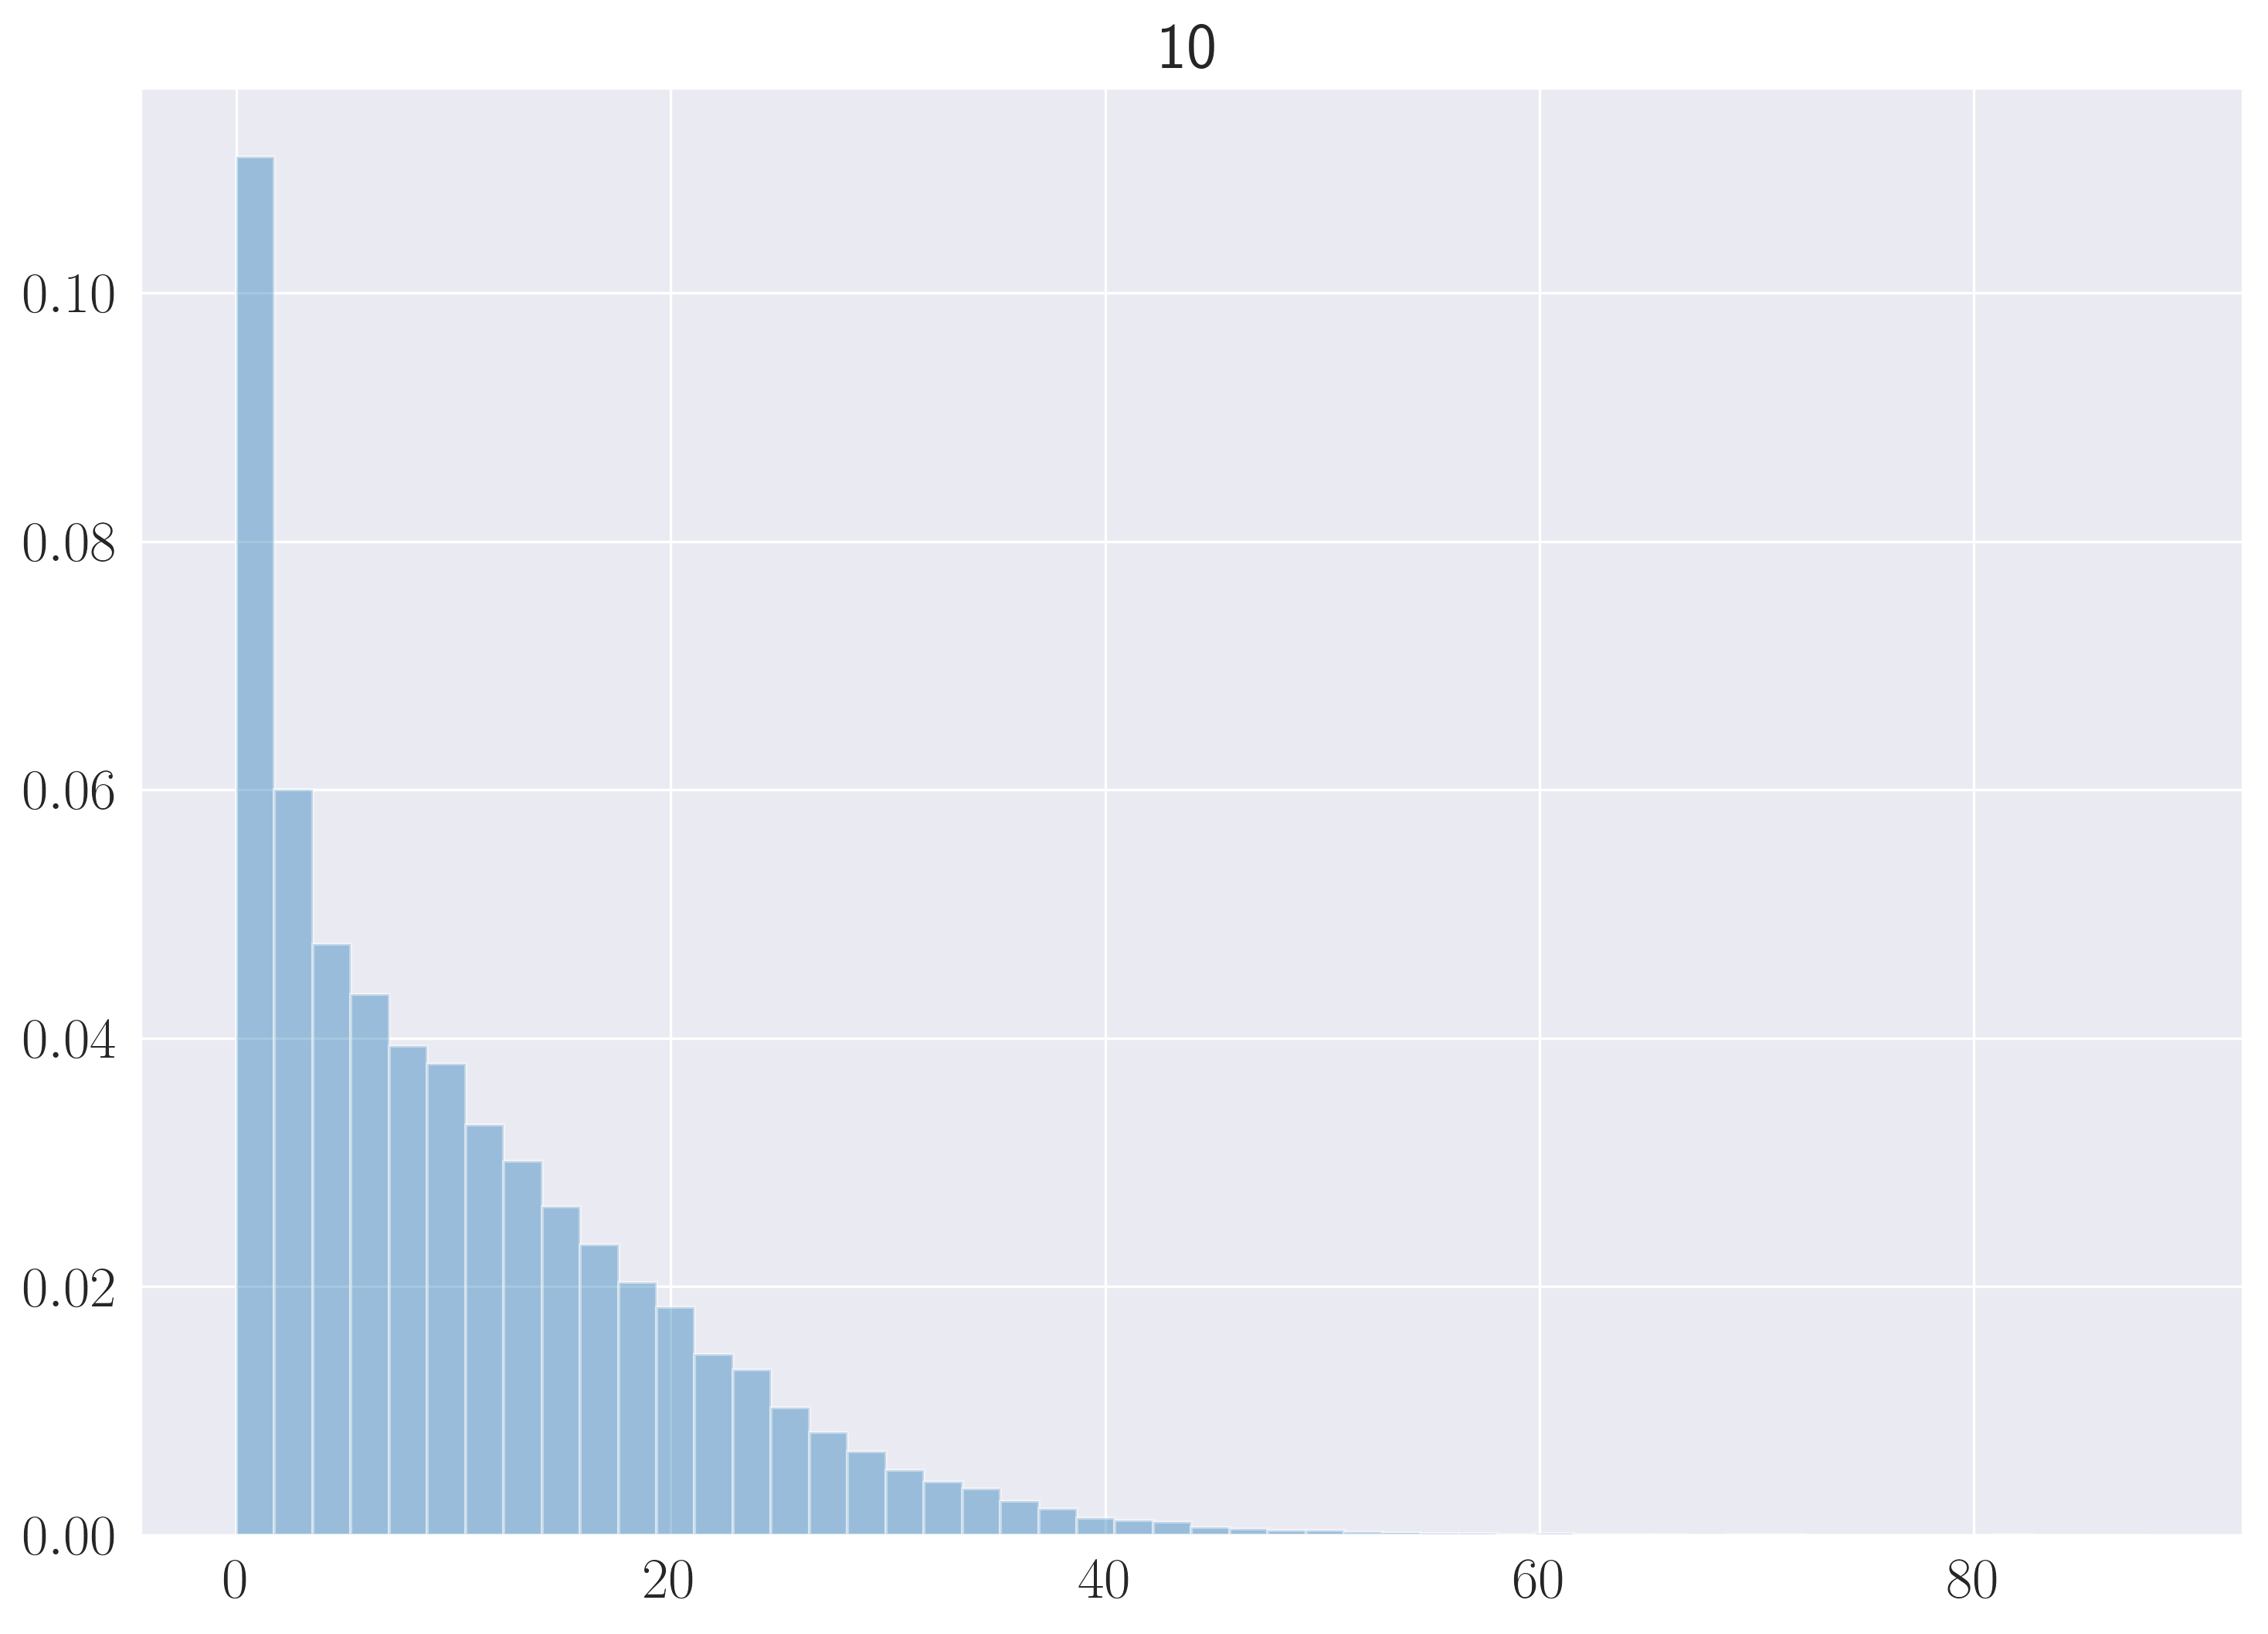

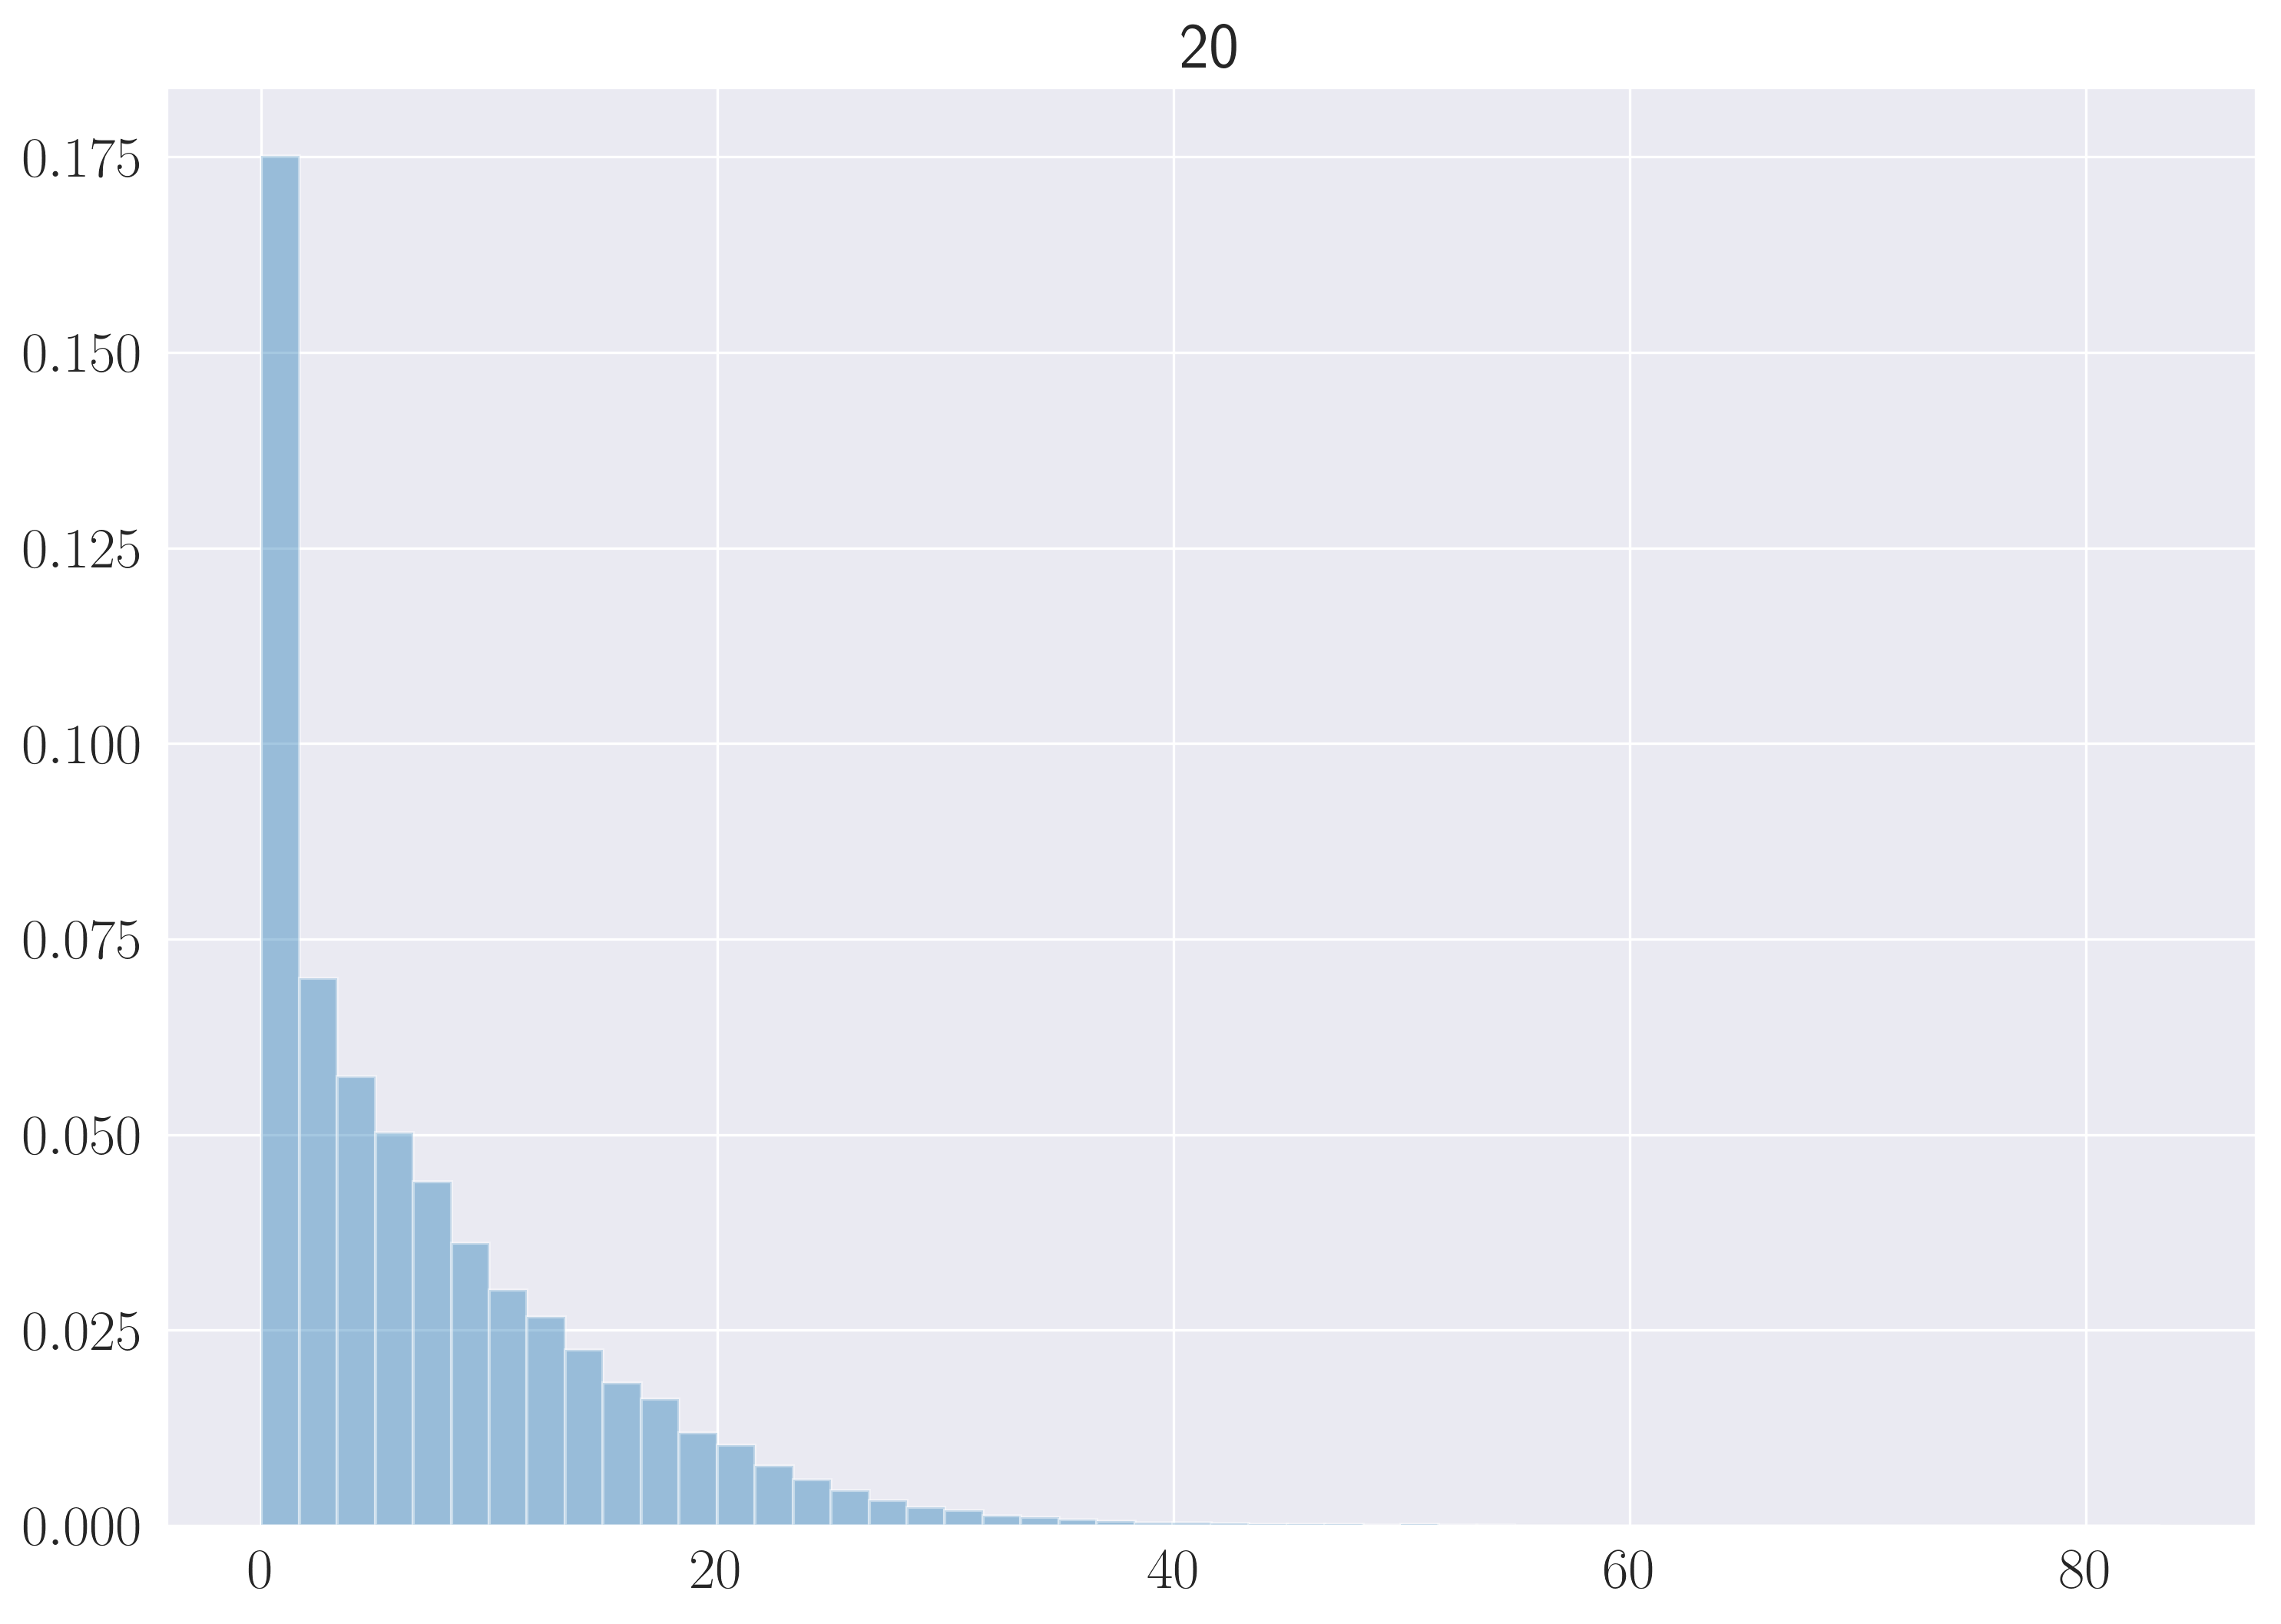

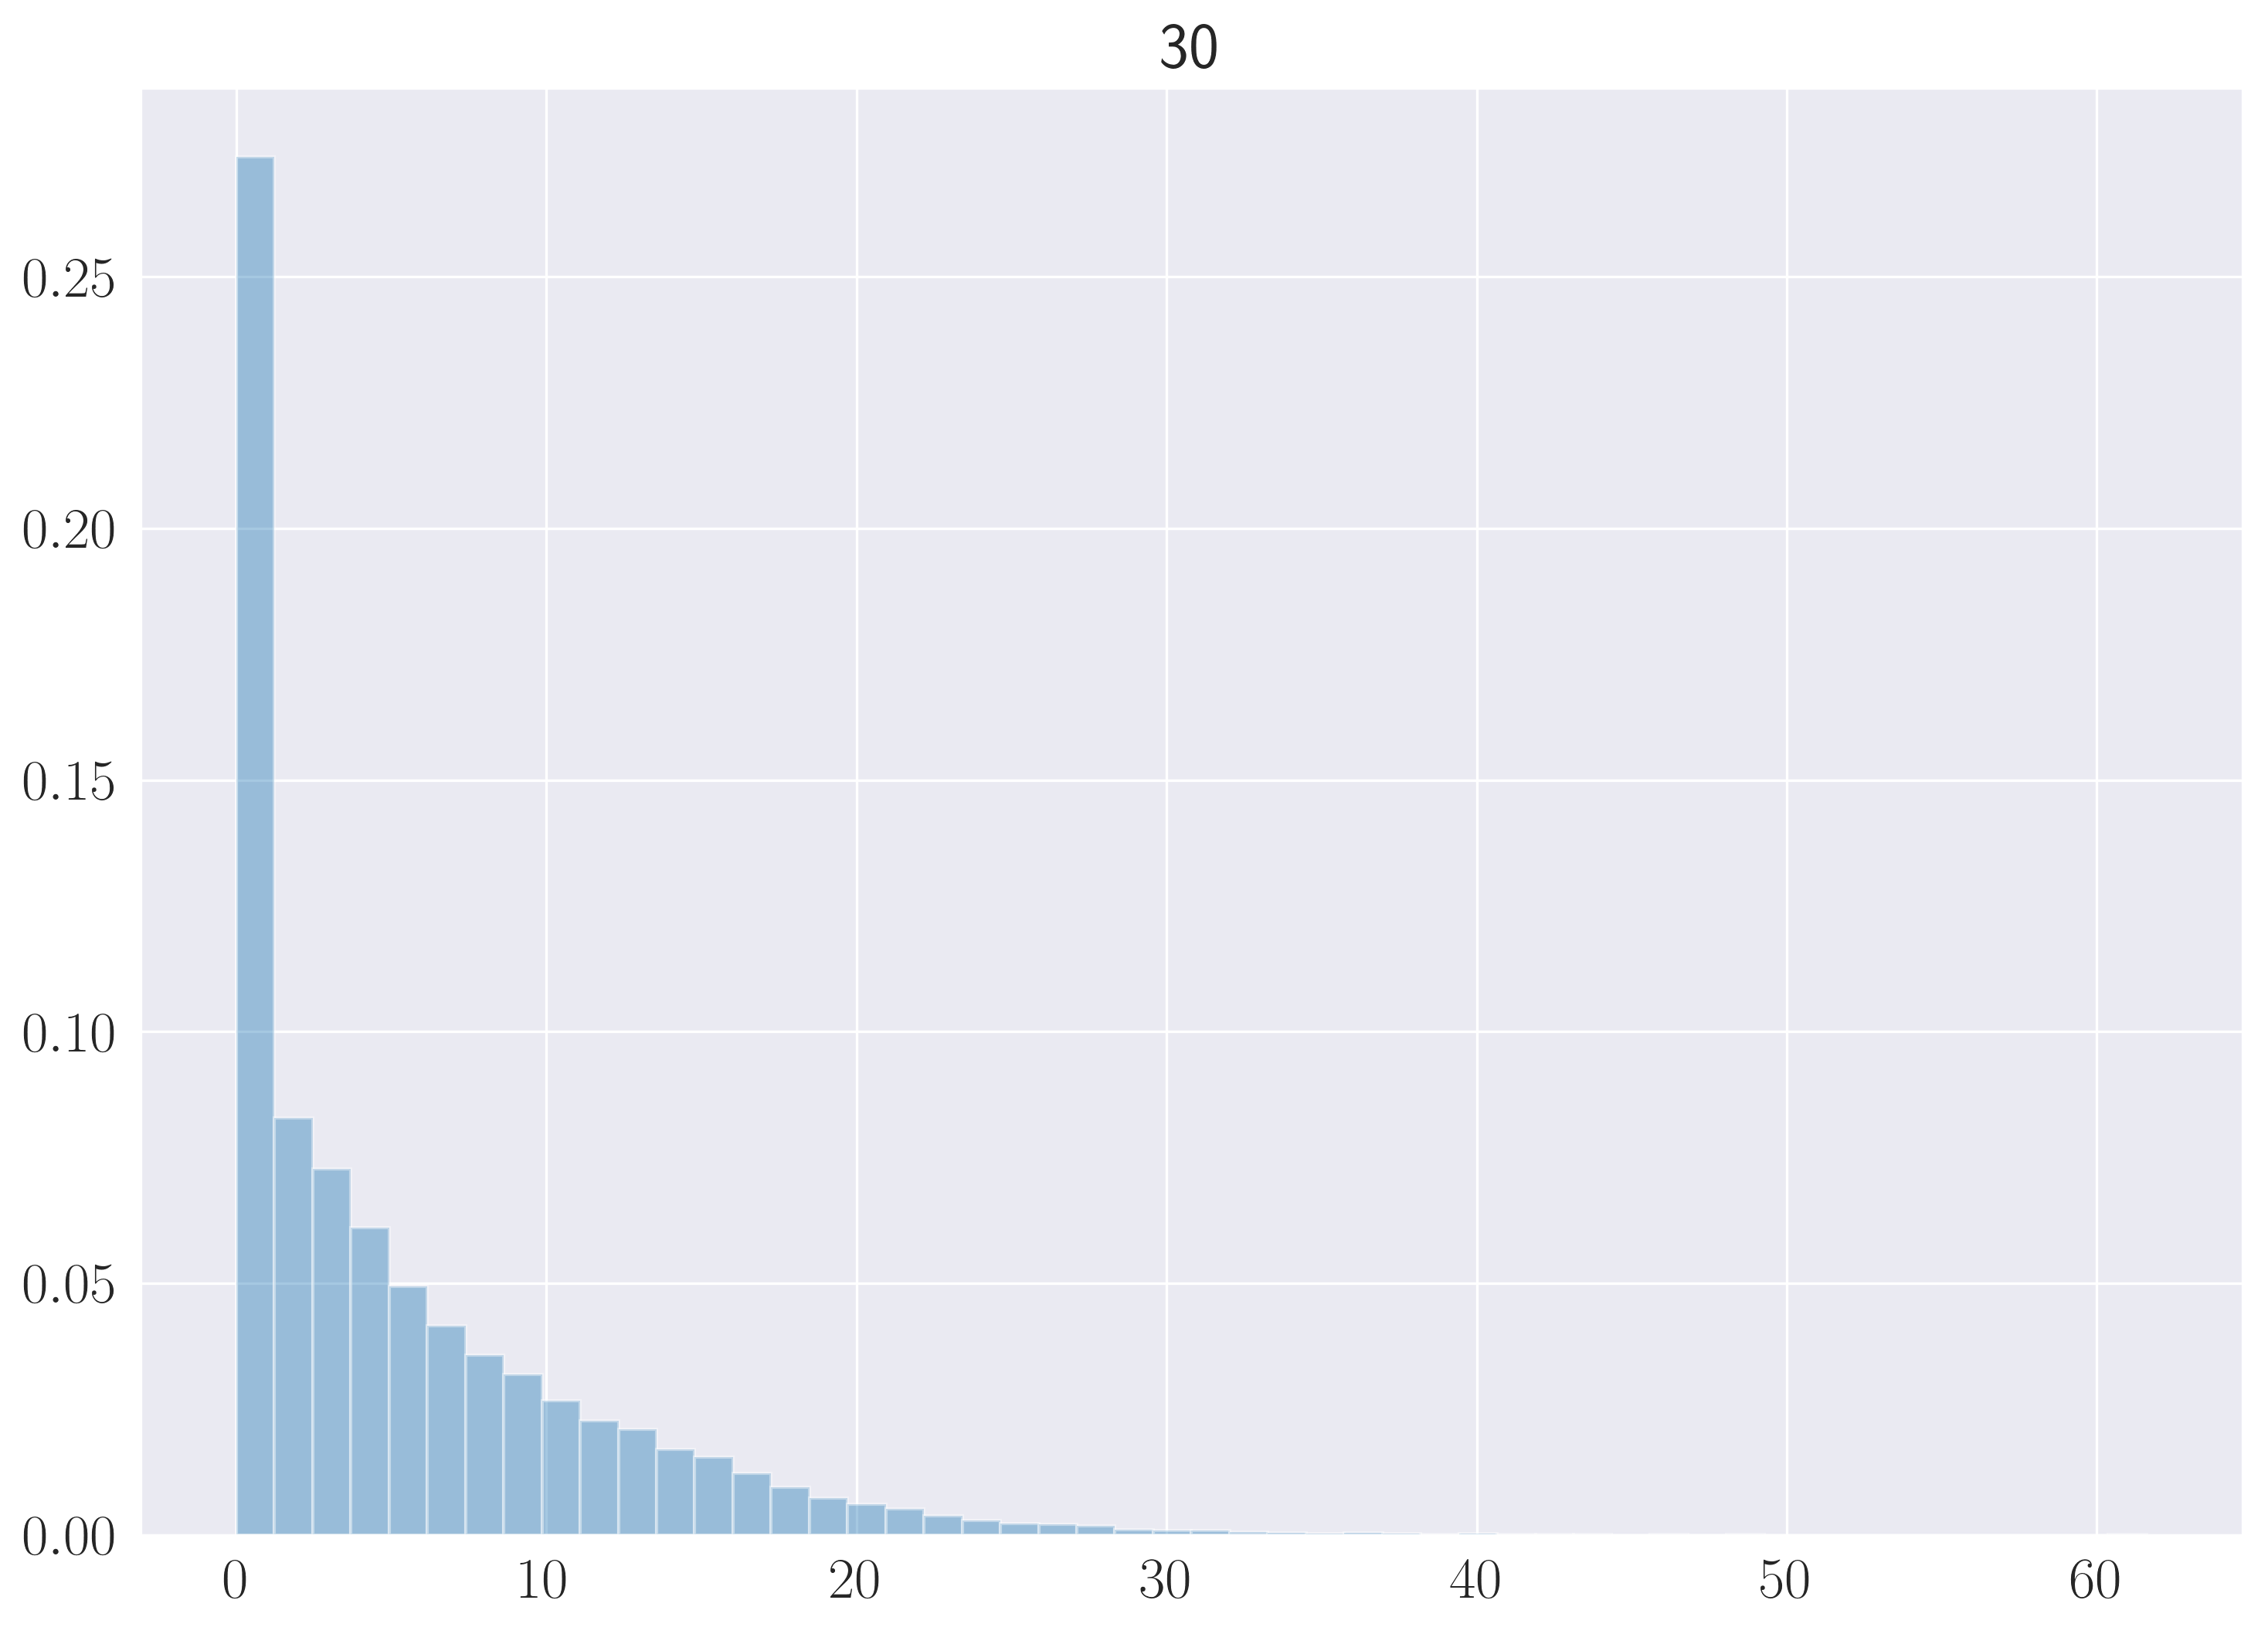

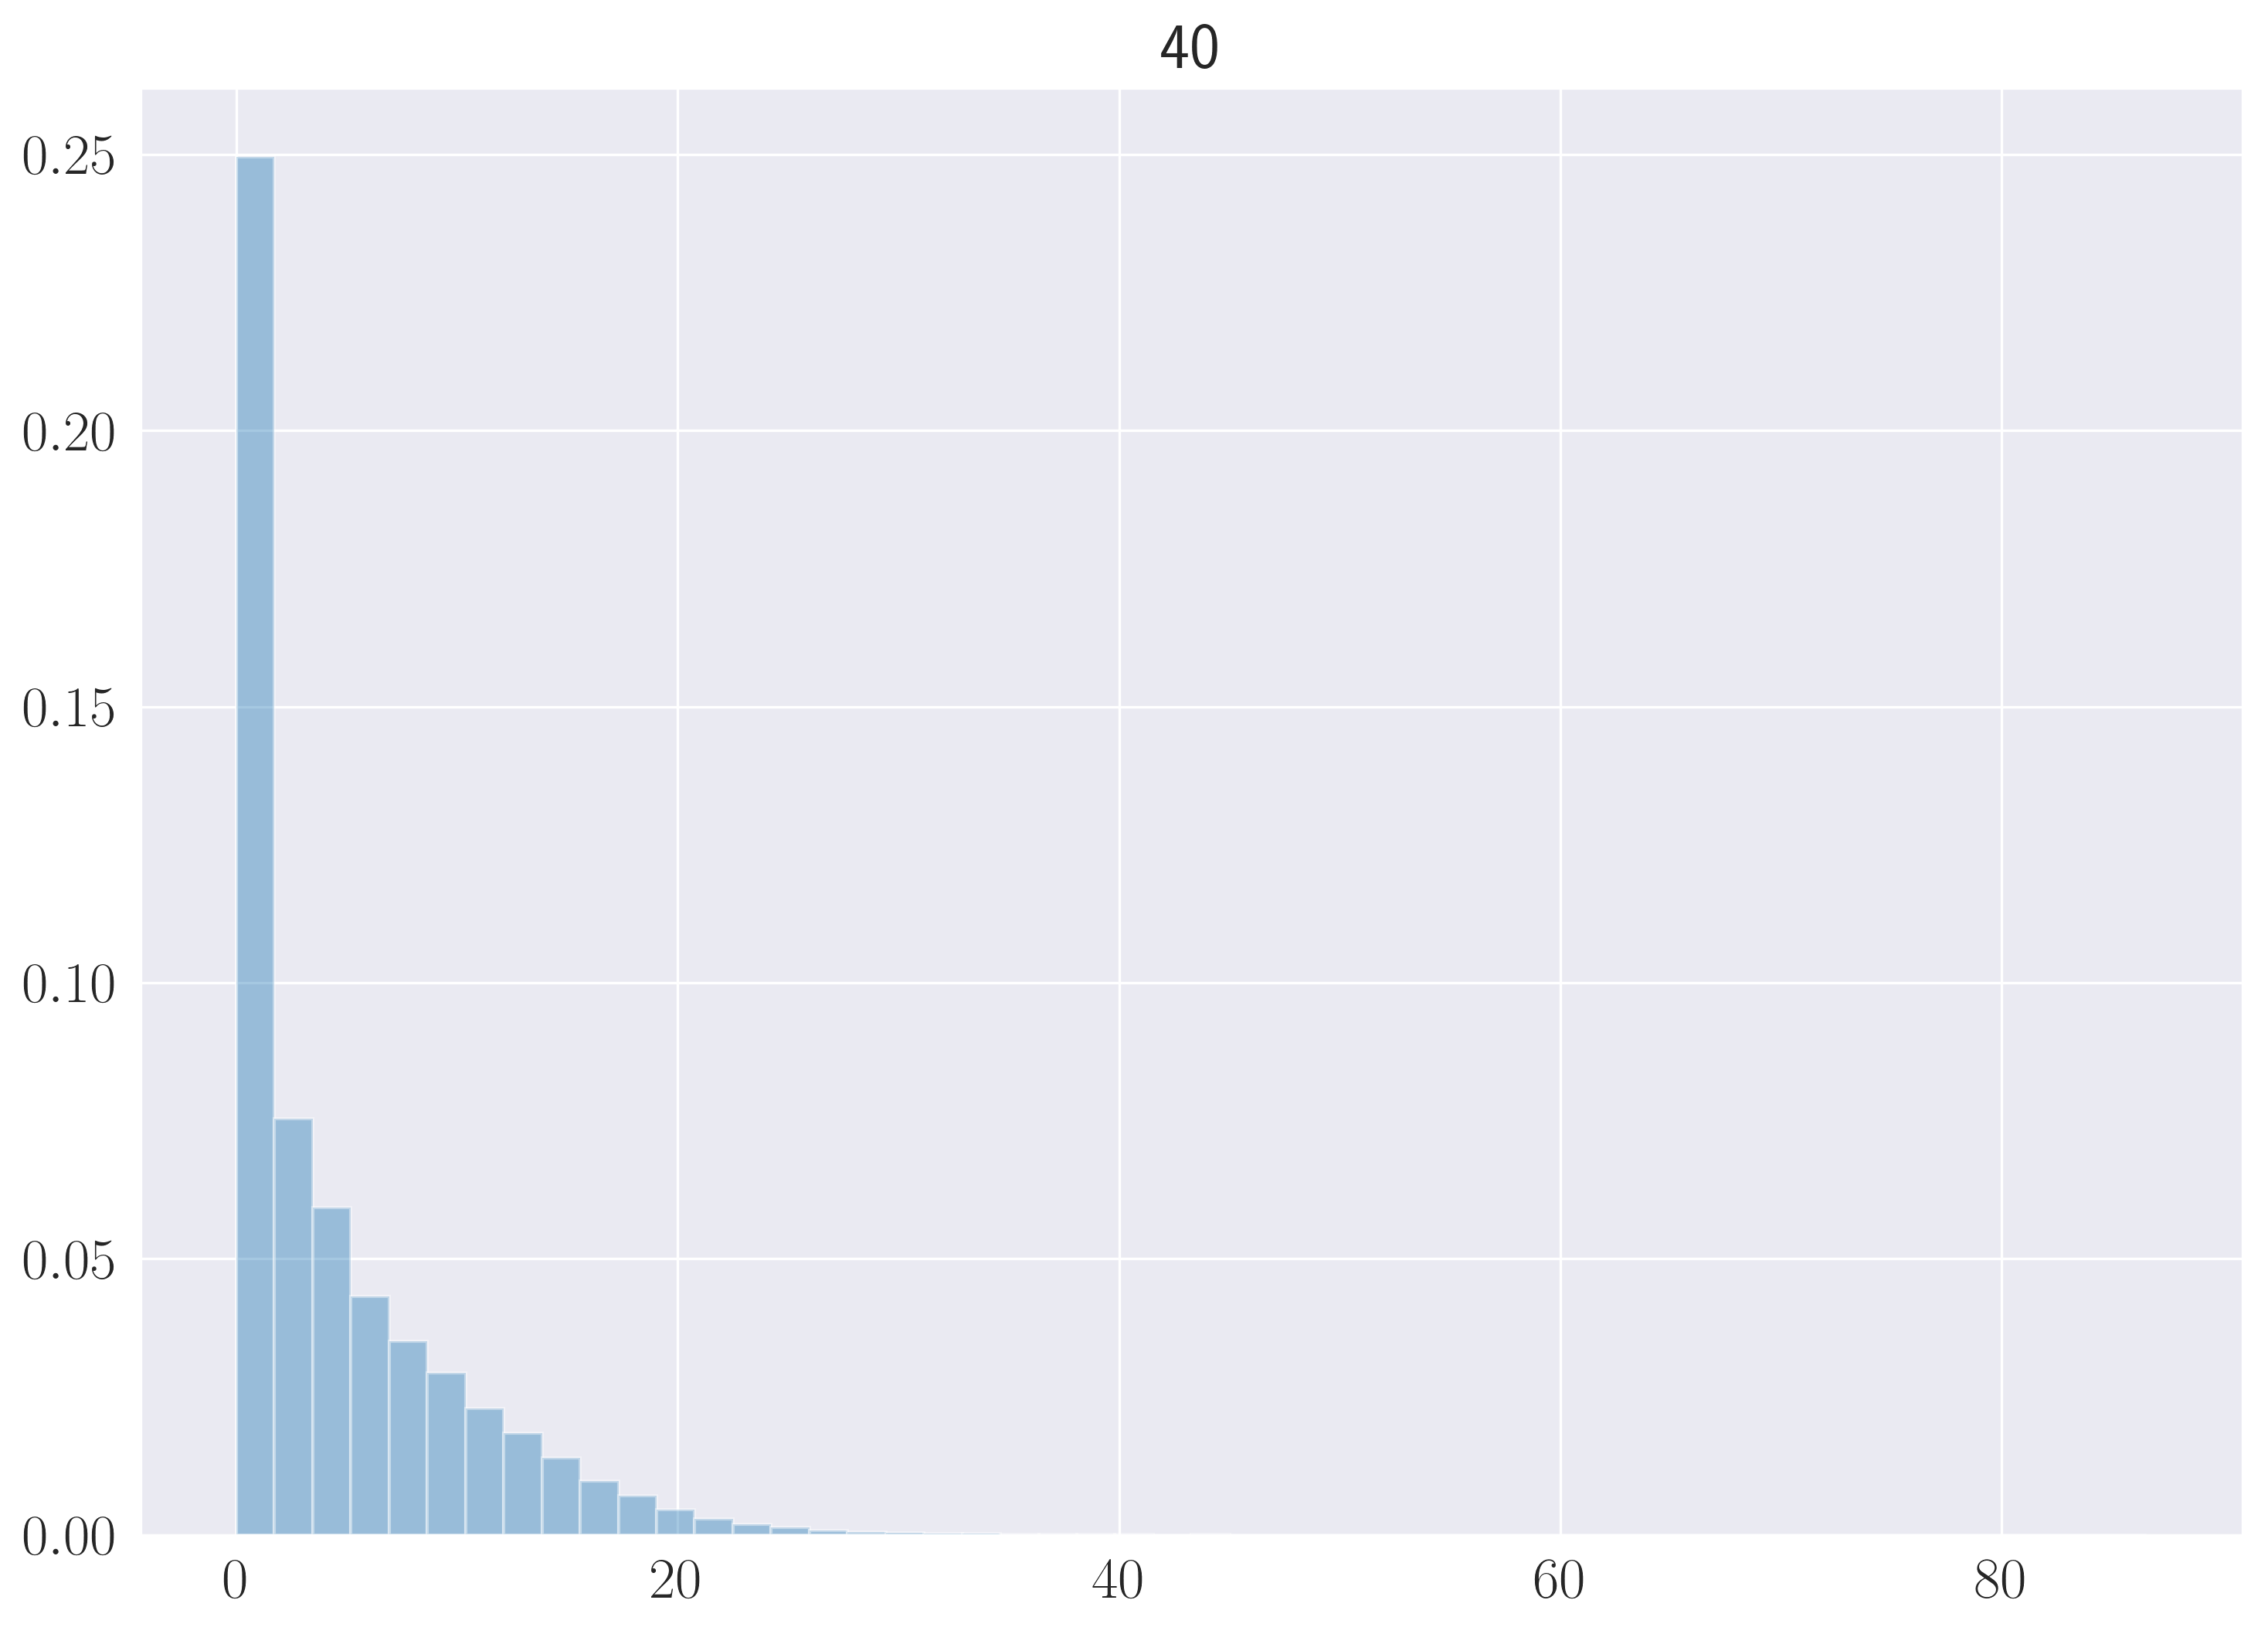

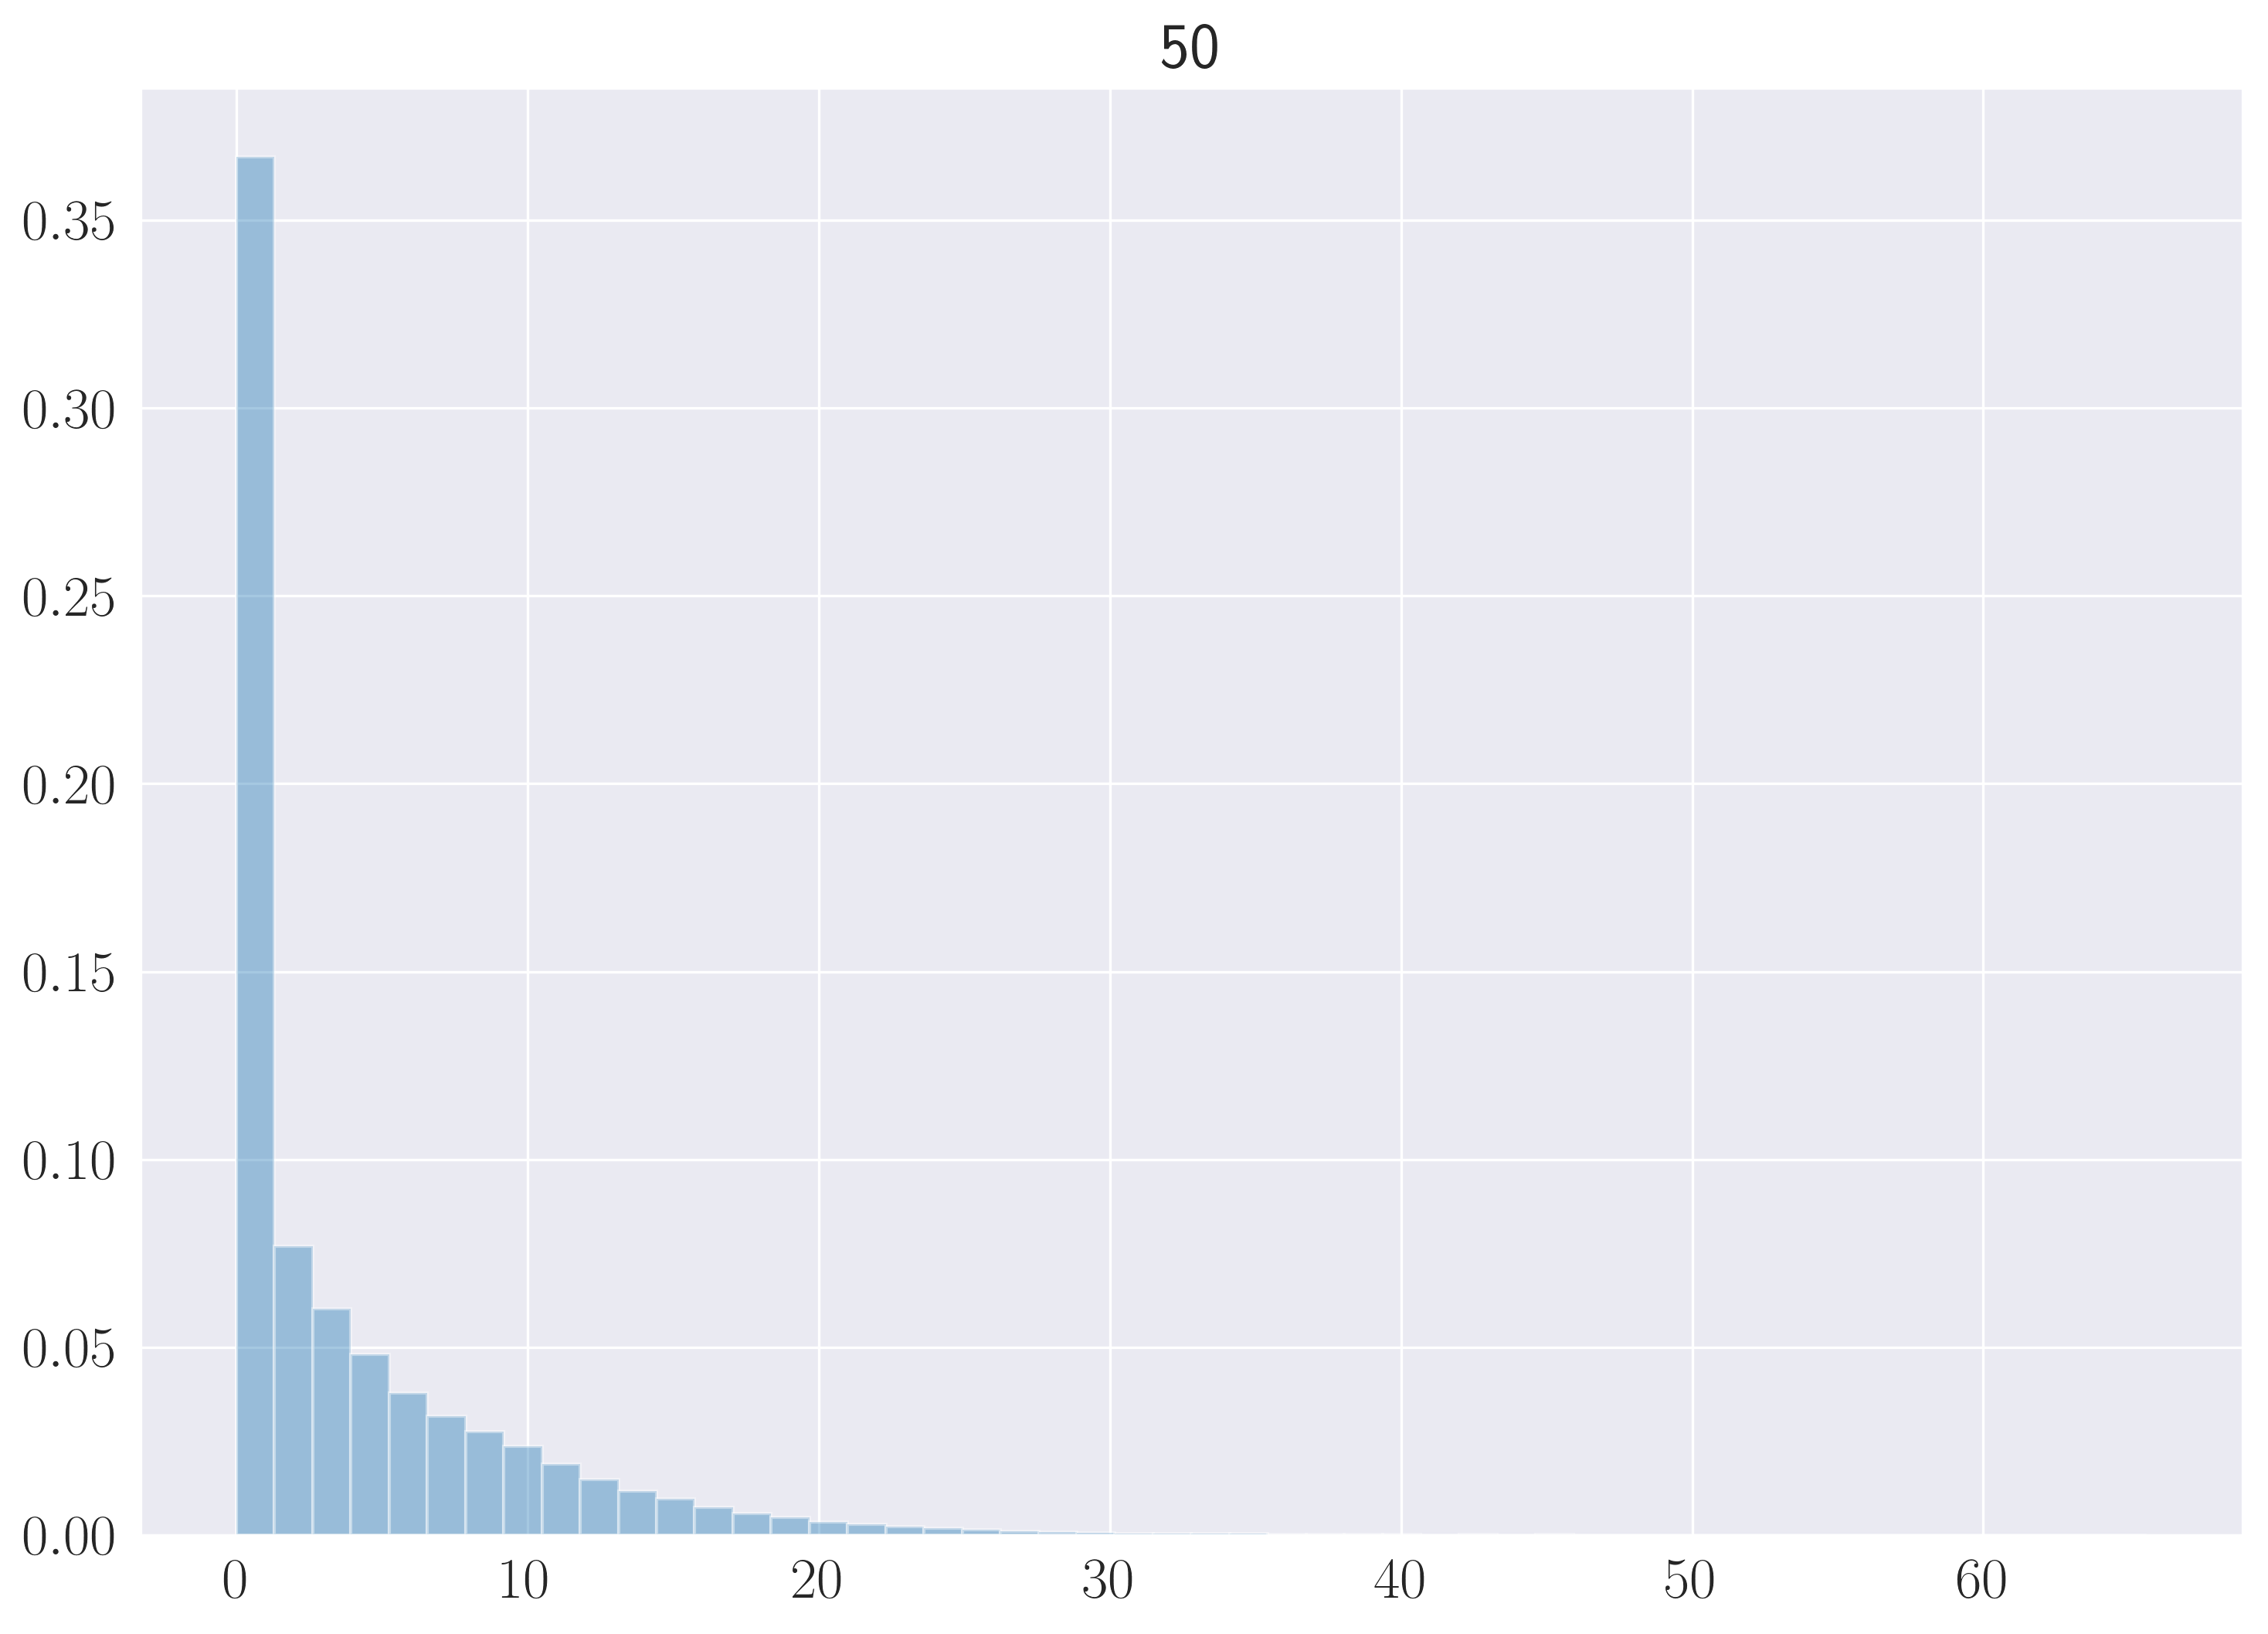

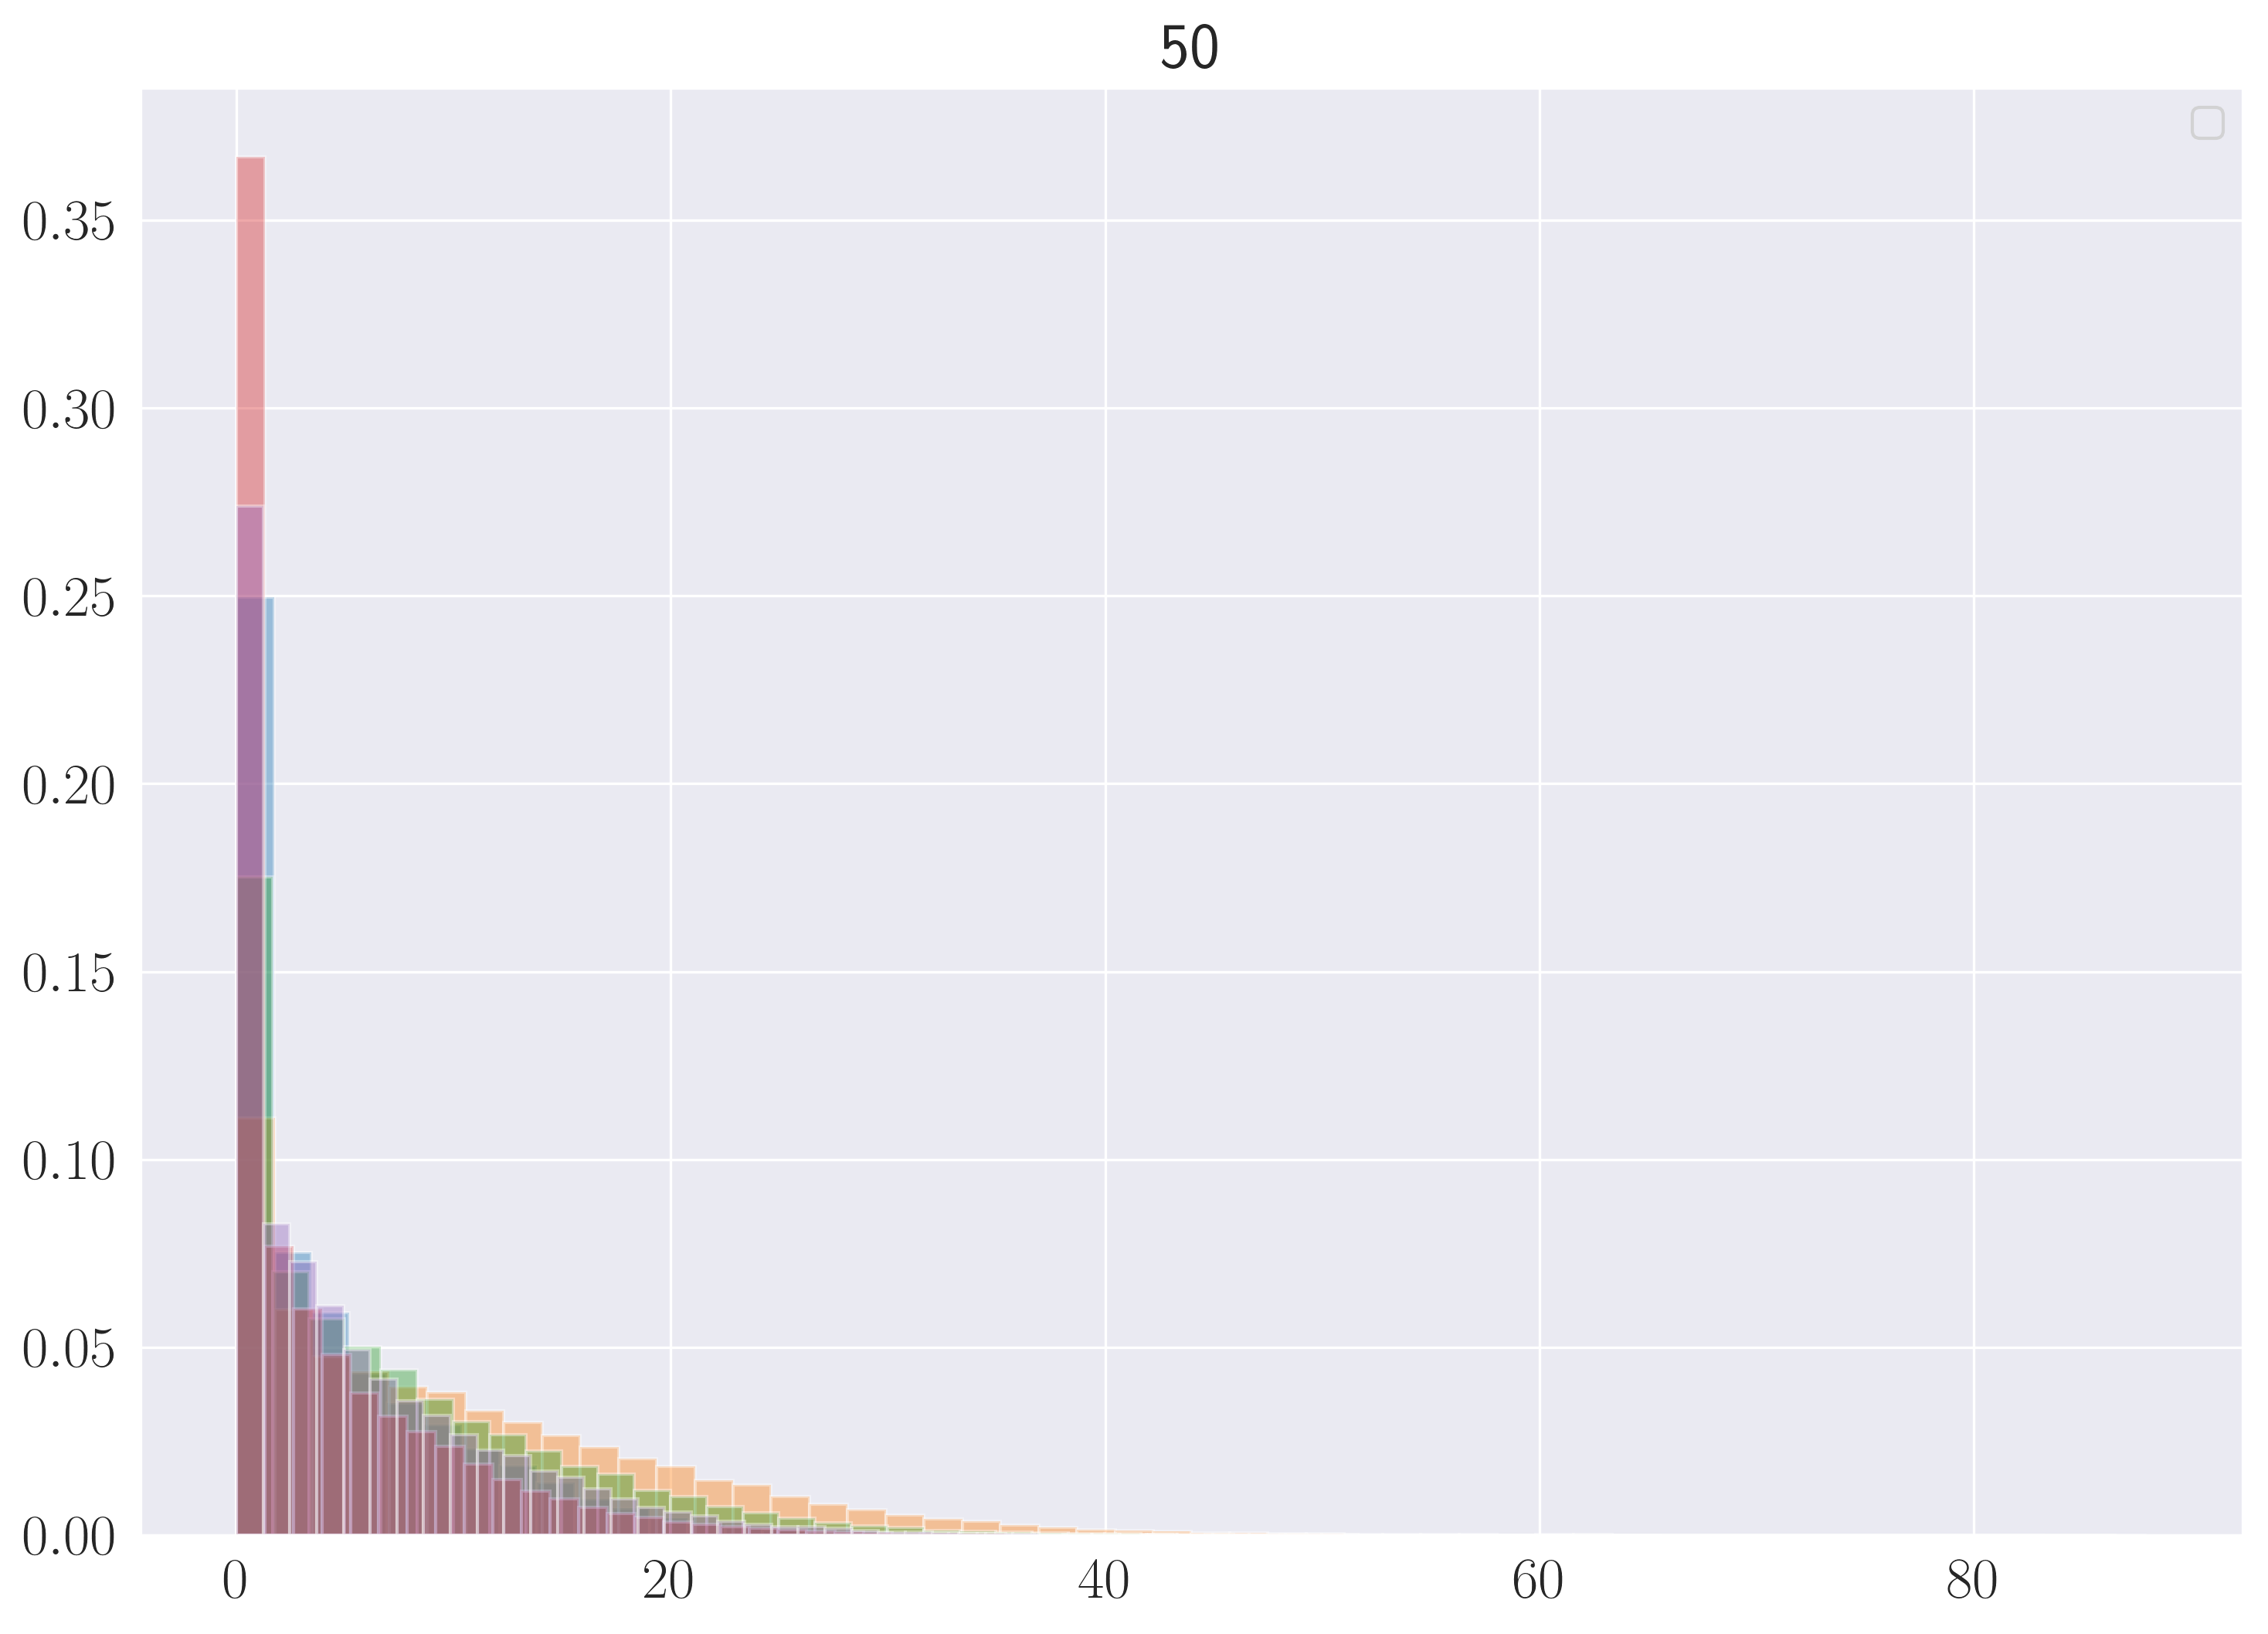

In [11]:
real_eig_dfs = {
                10: pd.DataFrame({10: real_eigs[10]})[10],
                20: pd.DataFrame({20: real_eigs[20]})[20],
                30: pd.DataFrame({30: real_eigs[30]})[30],
                40: pd.DataFrame({40: real_eigs[40]})[40],
                50: pd.DataFrame({50: real_eigs[50]})[50],
               }

histogram(real_eig_dfs[10], '')
histogram(real_eig_dfs[20], '')
histogram(real_eig_dfs[30], '')
histogram(real_eig_dfs[40], '40')
histogram(real_eig_dfs[50], '50')

histograms([real_eig_dfs[k] for k in real_eig_dfs], ['10','20','30','40','50'], log10=True)

histogram(real_eig_dfs[10], '10', log10=False)
histogram(real_eig_dfs[20], '20', log10=False)
histogram(real_eig_dfs[30], '30', log10=False)
histogram(real_eig_dfs[40], '40', log10=False)
histogram(real_eig_dfs[50], '50', log10=False)

histograms([real_eig_dfs[k] for k in real_eig_dfs], ['10','20','30','40','50'], log10=False)



# $h^{11} = 10$ runs

### $n_z = 100$. up to 10000 epochs, by 200

In [5]:
exp_path = "exp_h11_10_nz_5/"
nz = 5
gen_epochs = range(0,1001,20) # note after setting, only goes by 200
gen_epochs = [0,20,40,60,80,1000]
print 'generator epochs to study:', gen_epochs
netG_paths = [exp_path + d for d in os.listdir(exp_path) if 'pth' in d and 'netG' in d and int(d.split('/')[-1].split('_')[-1].split('.')[0]) in gen_epochs]
print 'generator files:', netG_paths


h11_10_netGs = [load_DCGAN(p,nz=nz) for p in netG_paths]
h11_10_netGs = sorted(h11_10_netGs, key = lambda x: x[1])

#show_GAN_image_sequence(h11_10_netGs, nz=nz, scale_factor = 1, dpi=500)

generator epochs to study: [0, 20, 40, 60, 80, 1000]
generator files: ['exp_h11_10_nz_5/netG_epoch_20.pth', 'exp_h11_10_nz_5/netG_epoch_80.pth', 'exp_h11_10_nz_5/netG_epoch_40.pth', 'exp_h11_10_nz_5/netG_epoch_0.pth', 'exp_h11_10_nz_5/netG_epoch_60.pth', 'exp_h11_10_nz_5/netG_epoch_1000.pth']


a

epoch: 0


/Users/jim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in log10


Wasserstein Distance GAN (no log, log): 9.596947258553762 1.2400202243545253
Wasserstein Distance Wishart (no log, log): 9.410897643512081 nan


/Users/jim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


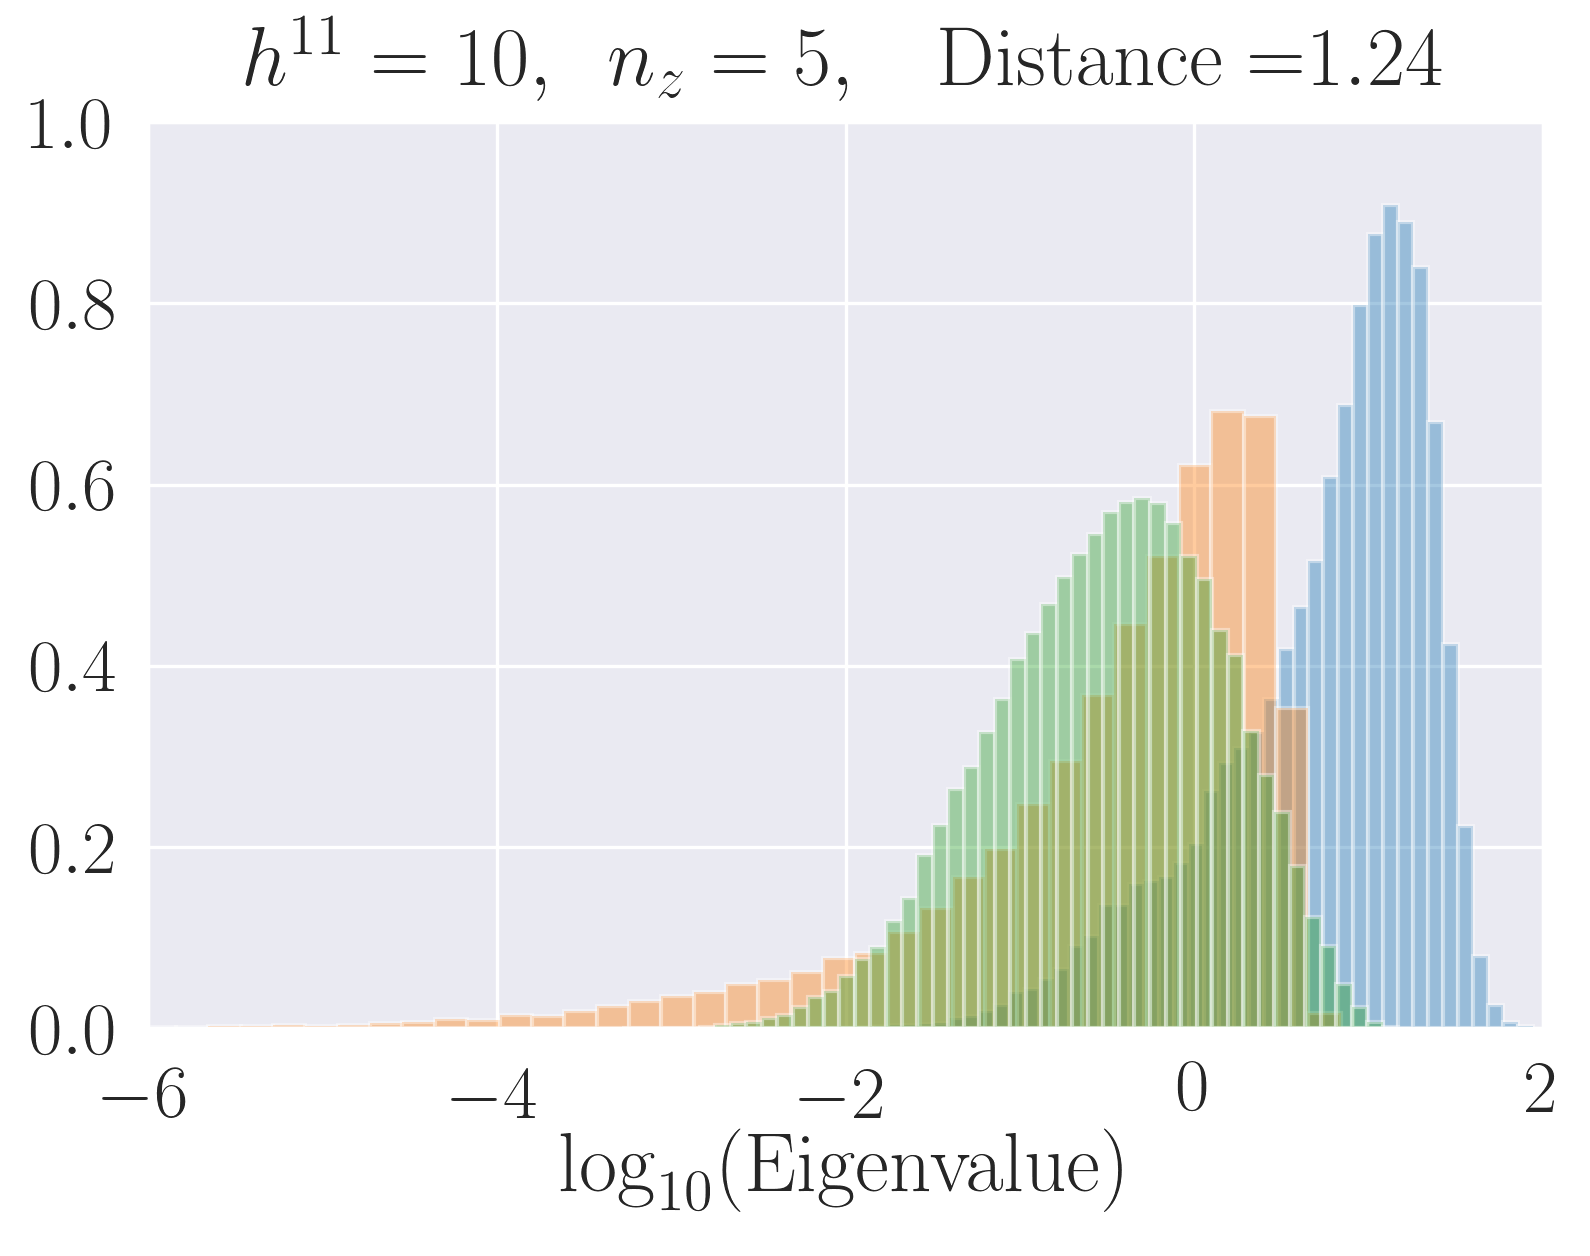

epoch: 20
Wasserstein Distance GAN (no log, log): 9.533584212750409 1.1447422307664168
Wasserstein Distance Wishart (no log, log): 9.40950380232438 nan


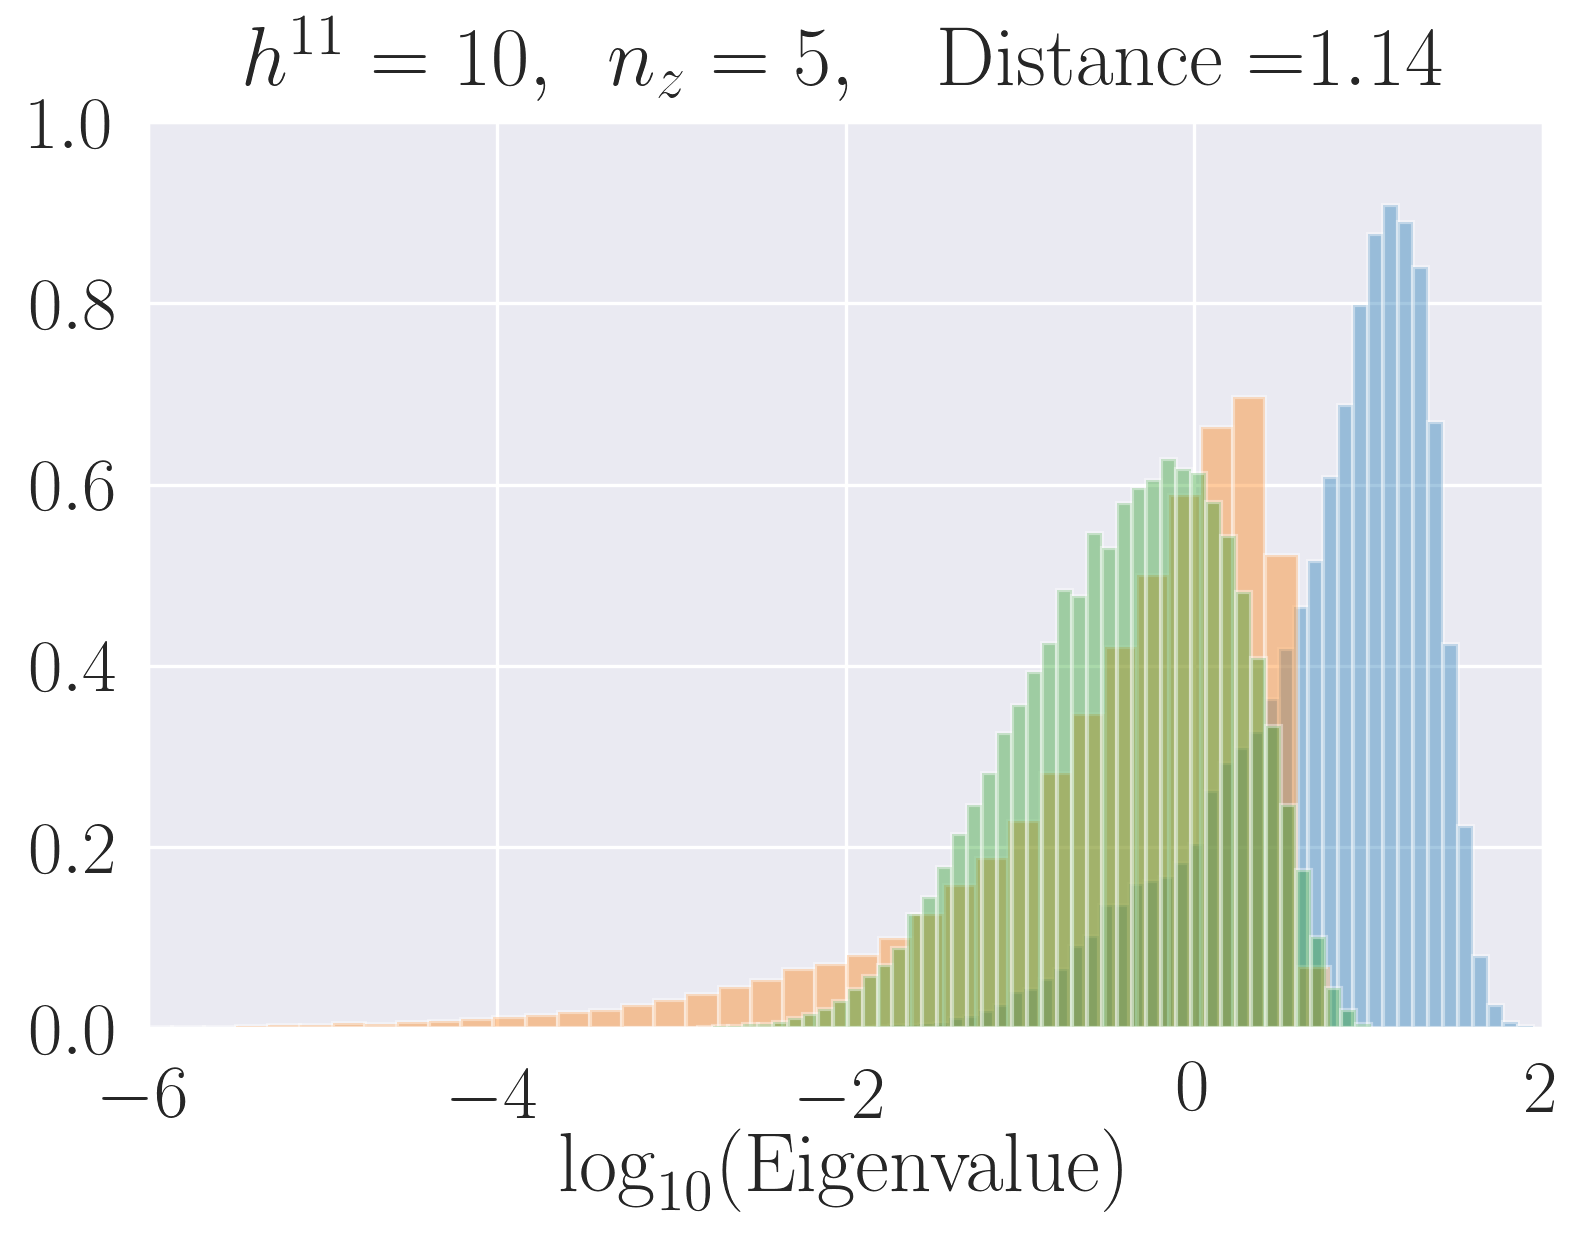

epoch: 40
Wasserstein Distance GAN (no log, log): 6.832853299828084 0.5011147942297666
Wasserstein Distance Wishart (no log, log): 9.408227079546474 nan


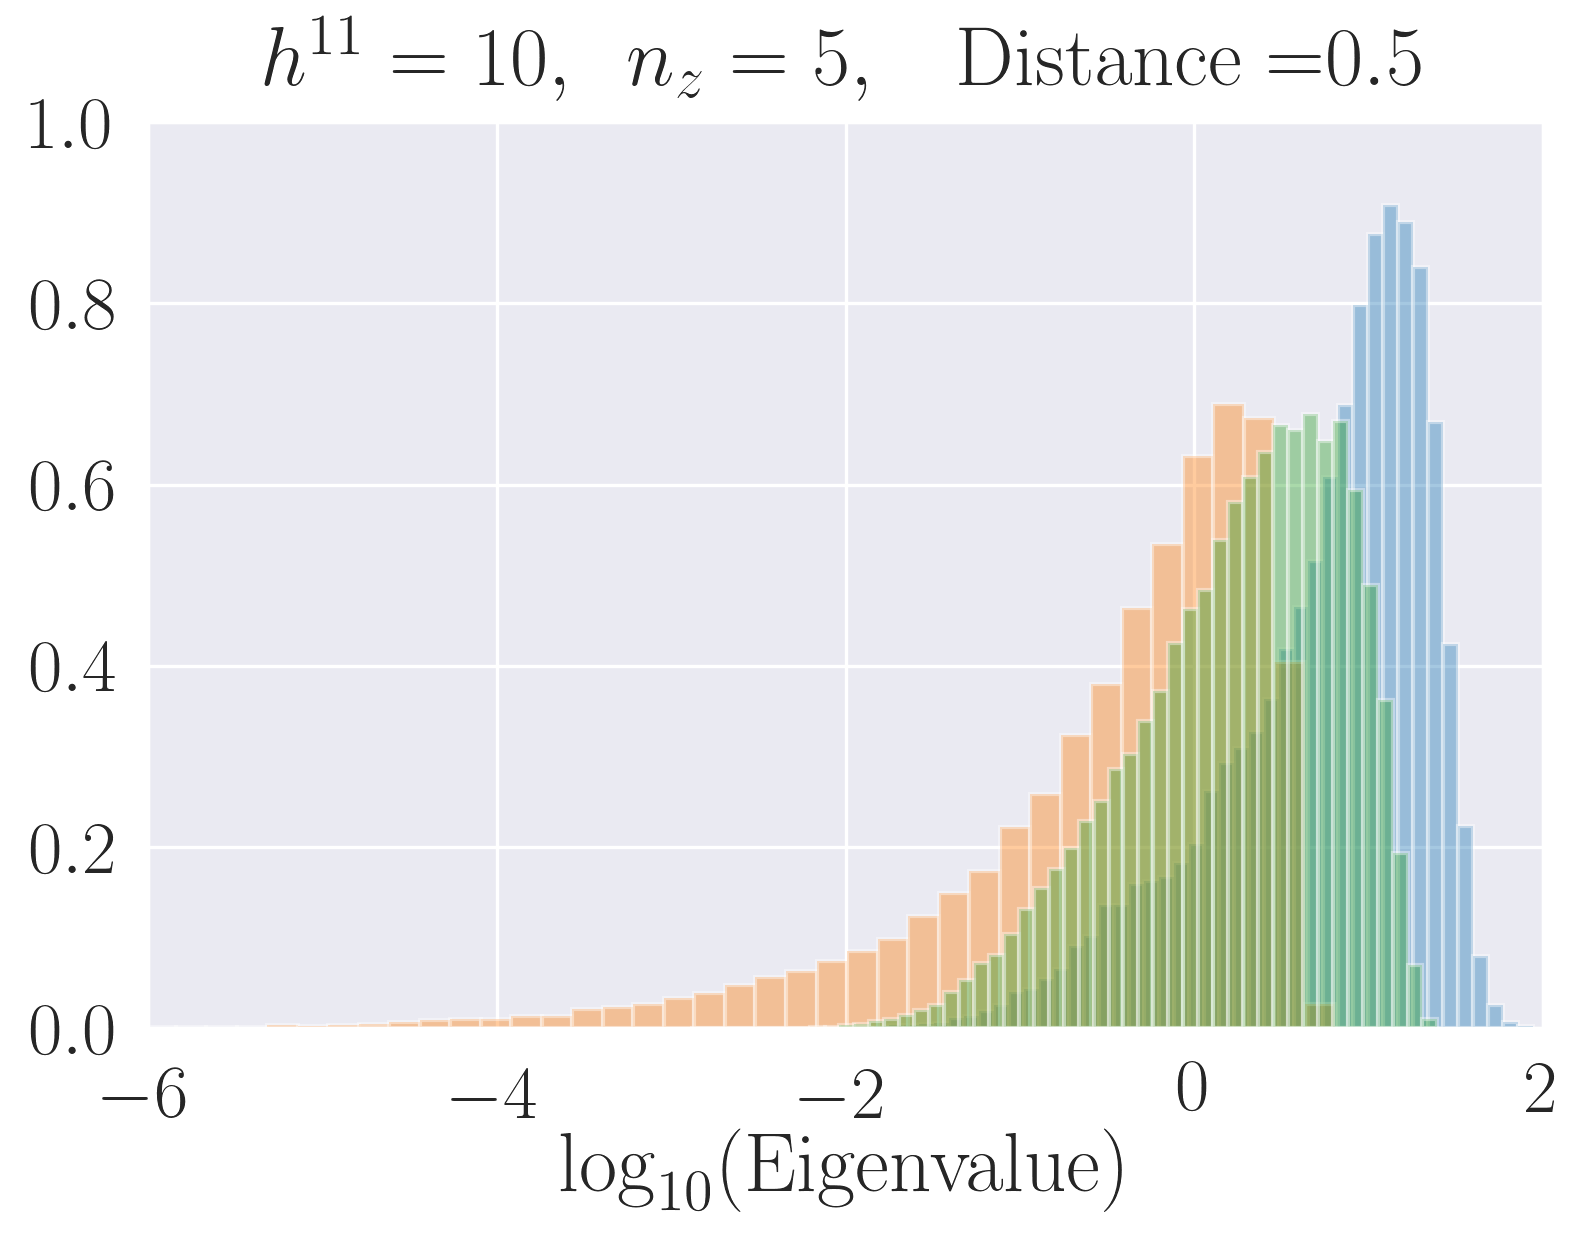

epoch: 60
Wasserstein Distance GAN (no log, log): 5.279891157353653 0.2887245704234802
Wasserstein Distance Wishart (no log, log): 9.411744592188994 nan


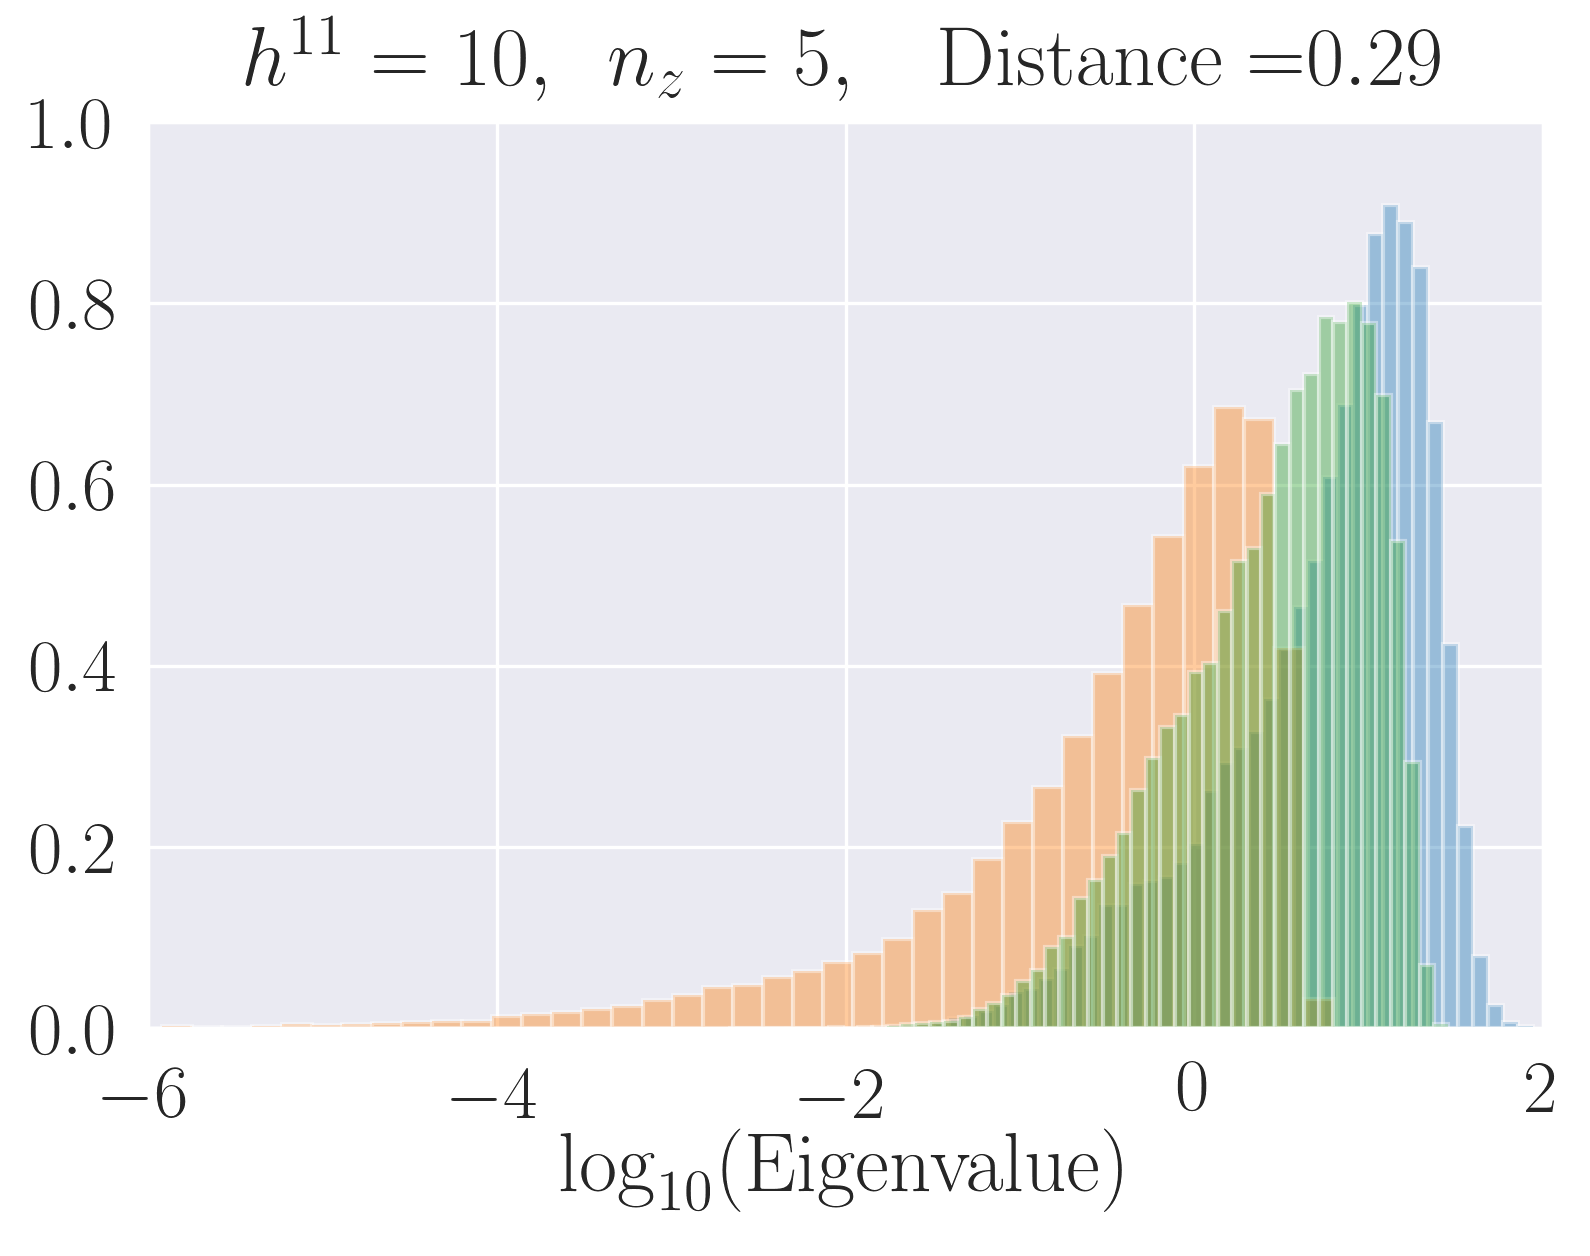

epoch: 80
Wasserstein Distance GAN (no log, log): 4.402743007507932 0.21543564539911939
Wasserstein Distance Wishart (no log, log): 9.414400968743353 nan


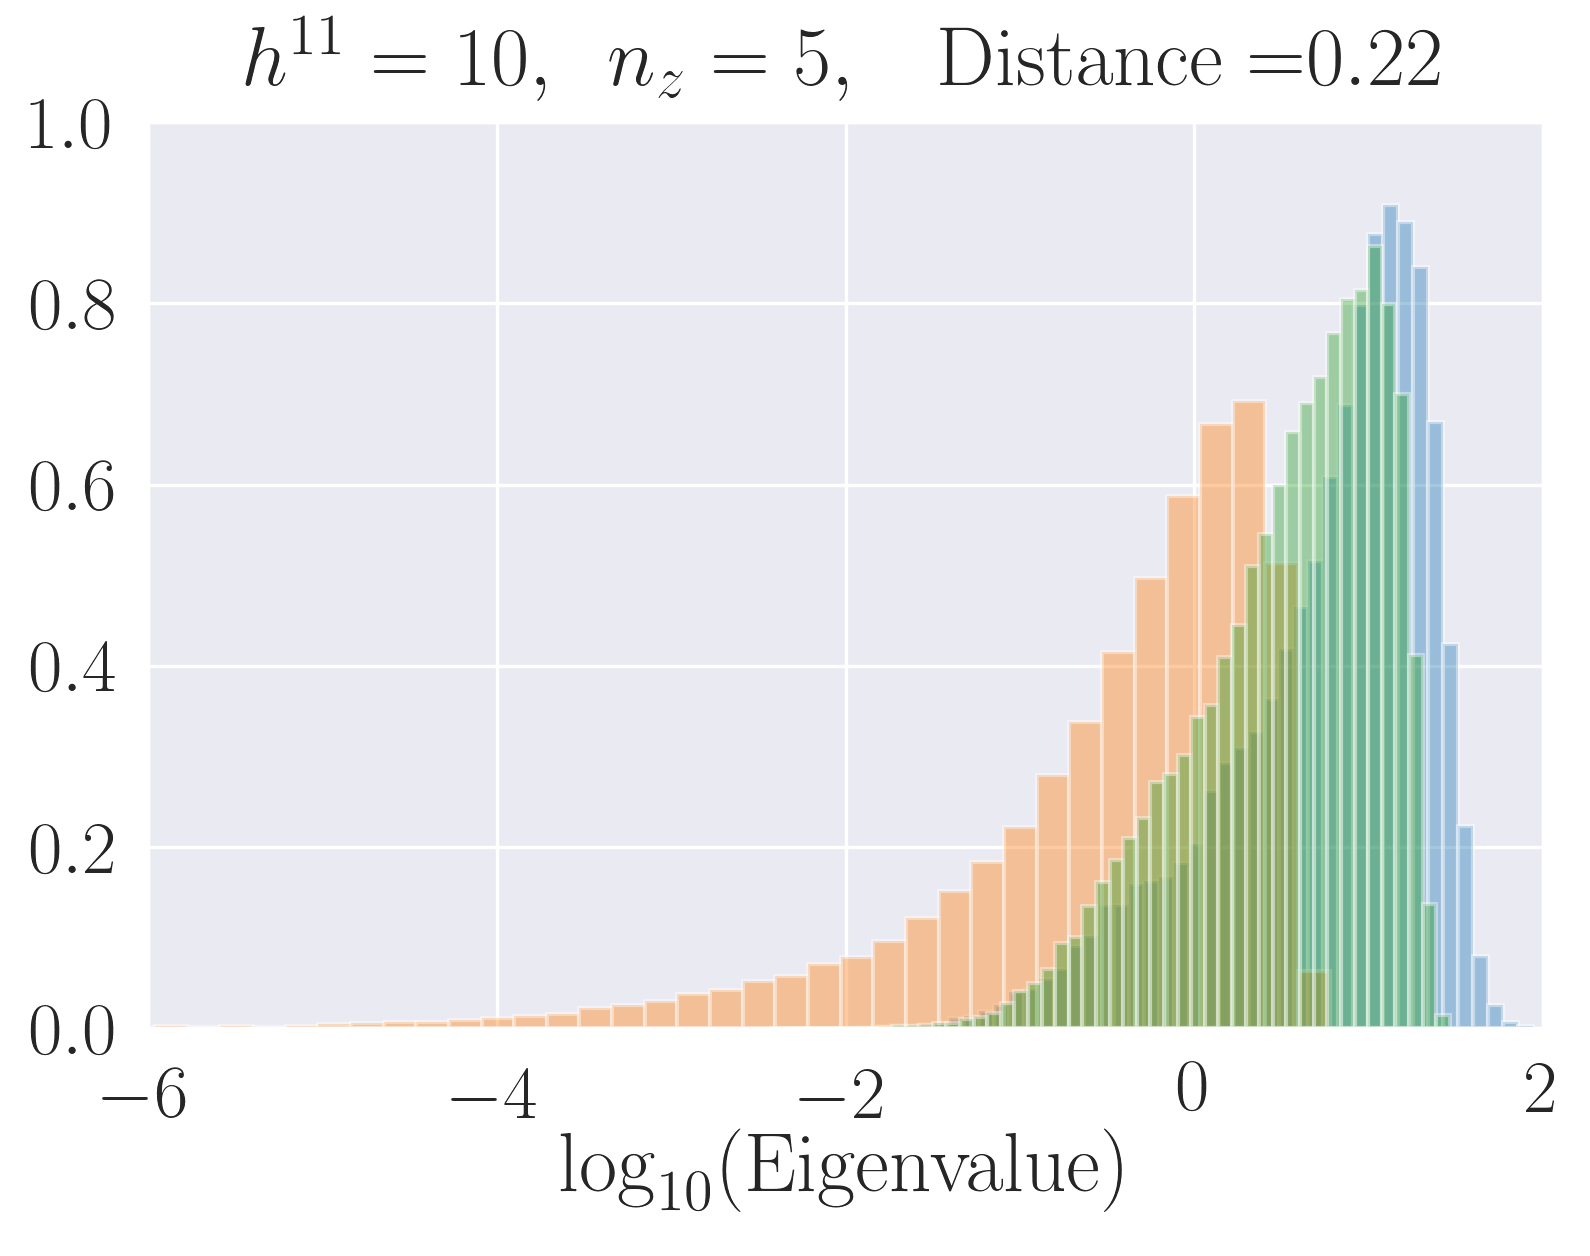

epoch: 1000
Wasserstein Distance GAN (no log, log): 1.4730768778823218 0.08310375649732675
Wasserstein Distance Wishart (no log, log): 9.41144432694903 nan


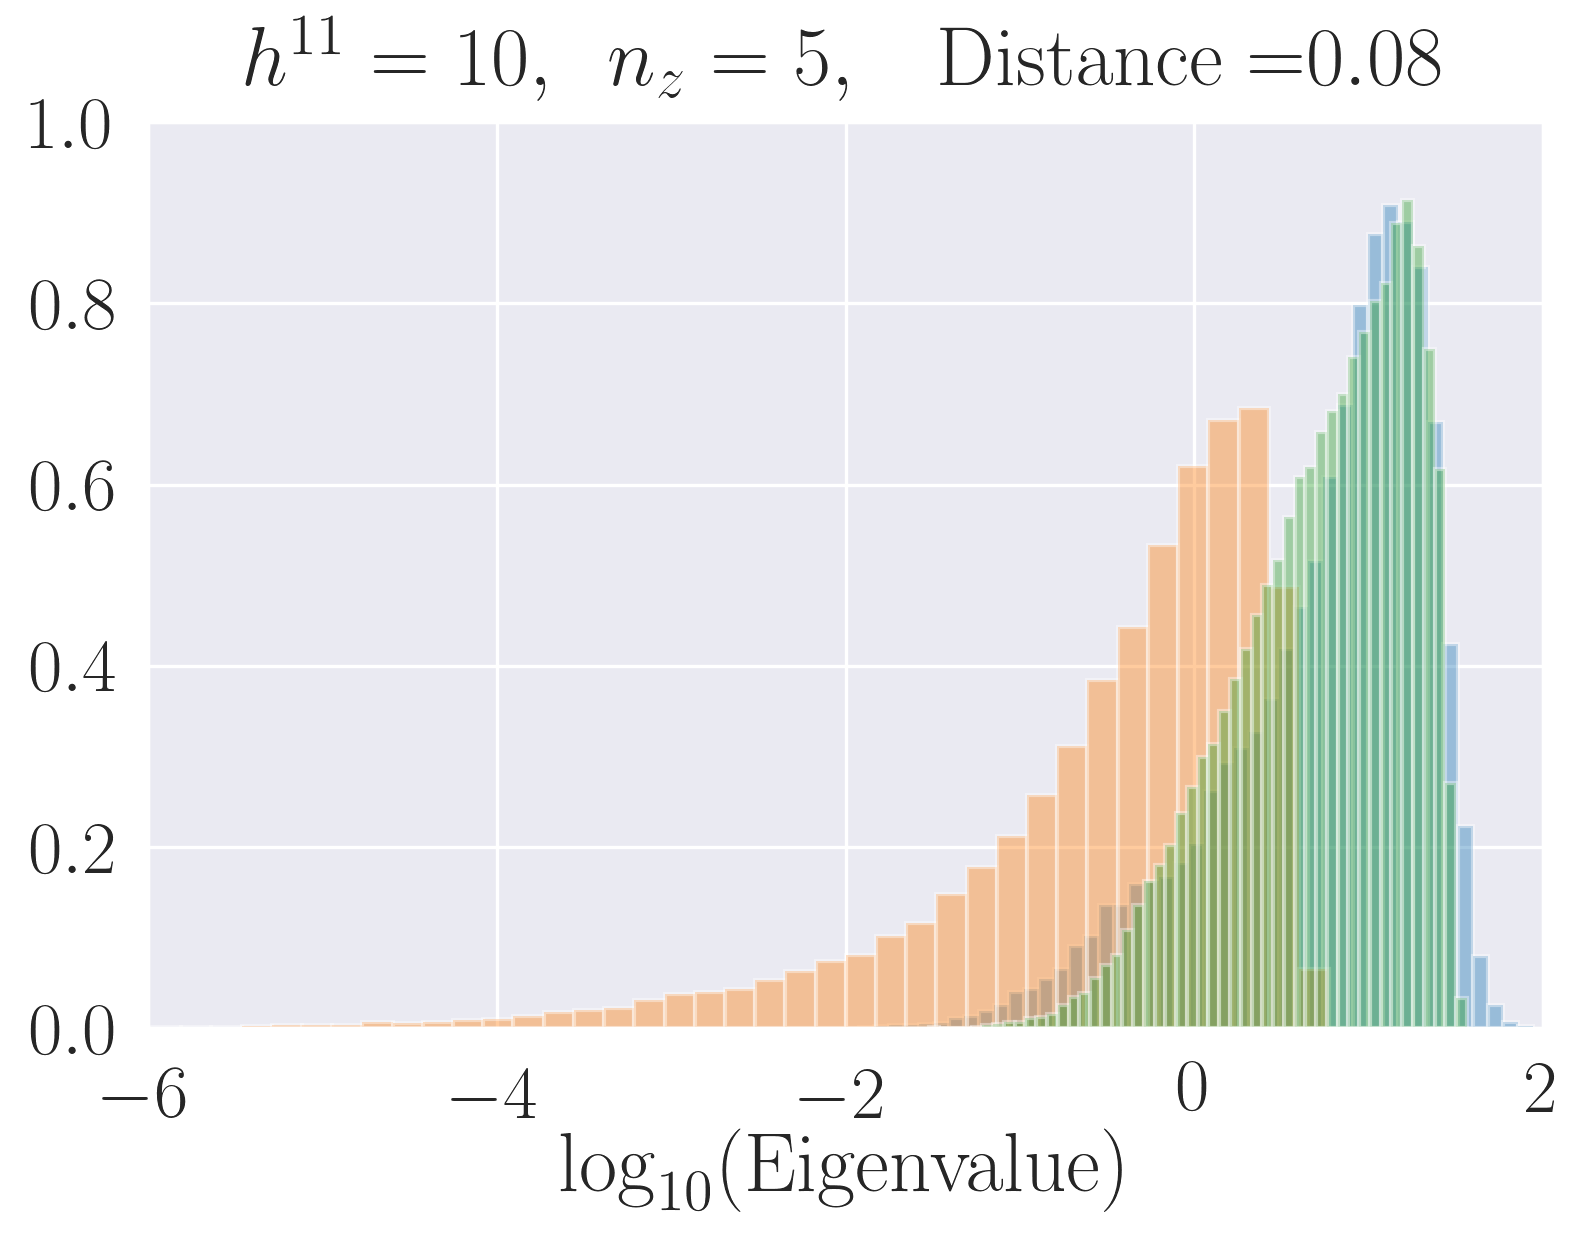

In [7]:
plt.clf() 
for _, epoch, netG in h11_10_netGs:
    print 'epoch:', epoch
    show_GAN_histogram(netG, 10, 
                       batchSize = 6282, nz=nz, log10=True, dpi=300, display_wishart = True, ylim = (0,1), xlim = (-6,2))
    
    
# batchSize = 6282    

### $n_z = 5$. up to 100 epochs, by 10

generator epochs to study: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
generator files: ['exp_h11_10_nz_5/netG_epoch_20.pth', 'exp_h11_10_nz_5/netG_epoch_100.pth', 'exp_h11_10_nz_5/netG_epoch_30.pth', 'exp_h11_10_nz_5/netG_epoch_80.pth', 'exp_h11_10_nz_5/netG_epoch_40.pth', 'exp_h11_10_nz_5/netG_epoch_50.pth', 'exp_h11_10_nz_5/netG_epoch_90.pth', 'exp_h11_10_nz_5/netG_epoch_0.pth', 'exp_h11_10_nz_5/netG_epoch_60.pth', 'exp_h11_10_nz_5/netG_epoch_70.pth', 'exp_h11_10_nz_5/netG_epoch_10.pth']
(h11, epoch): (10, 0)


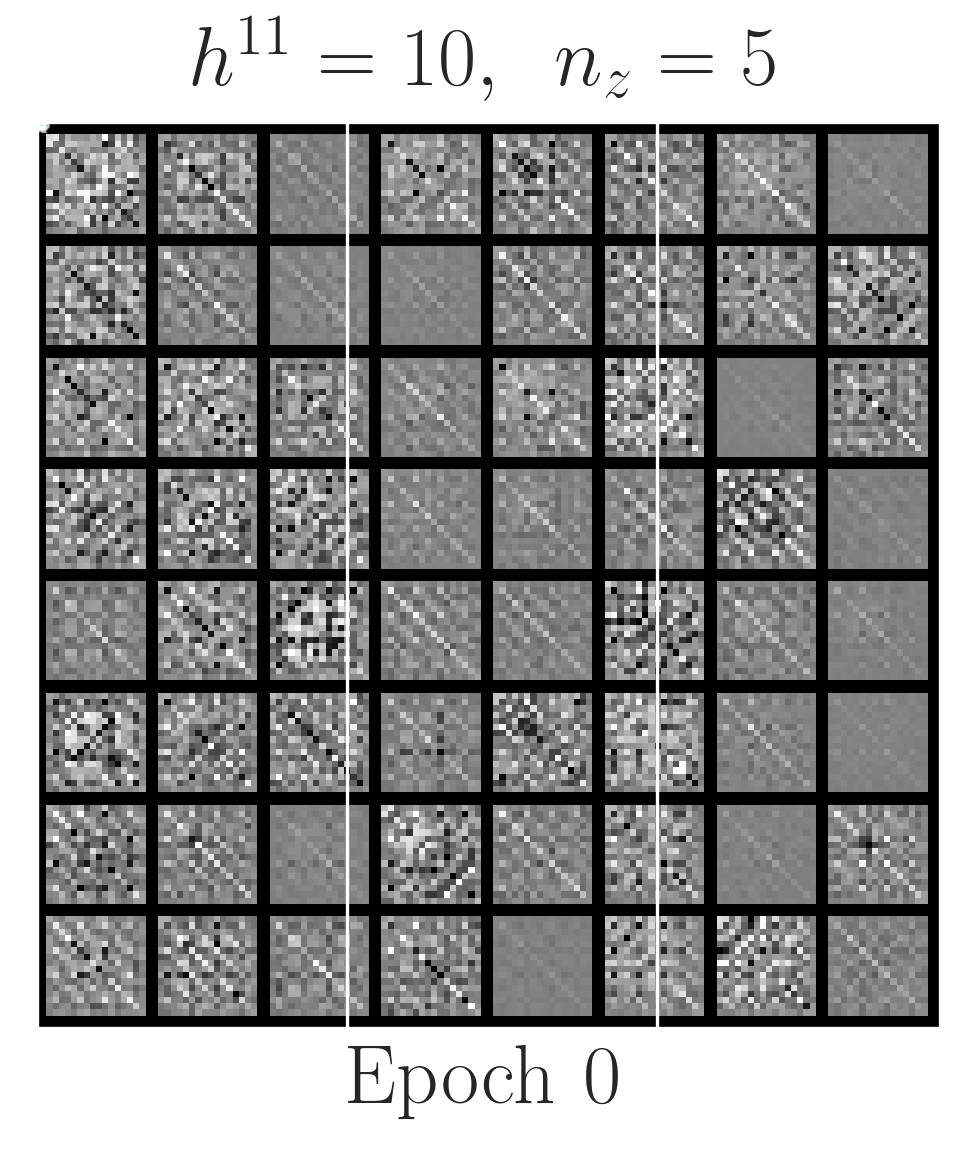

(h11, epoch): (10, 10)


KeyboardInterrupt: 

In [88]:
exp_path = "exp_h11_10_nz_5/"
gen_epochs = range(0,101,10) # note after setting, only goes by 200
print 'generator epochs to study:', gen_epochs
netG_paths = [exp_path + d for d in os.listdir(exp_path) if 'pth' in d and 'netG' in d and int(d.split('/')[-1].split('_')[-1].split('.')[0]) in gen_epochs]
print 'generator files:', netG_paths

h11_10_netGs = [load_DCGAN(p, nz=5) for p in netG_paths]
h11_10_netGs = sorted(h11_10_netGs, key = lambda x: x[1])

show_GAN_image_sequence(h11_10_netGs, nz=5, scale_factor = 1, dpi=500)

In [ ]:
for _, _, netG in h11_10_netGs:
    show_GAN_histogram(netG, 10, batchSize = 10000, nz=5, log10 = False, display_wishart = False, ylim = (0,.4))

# $n_z$ plots



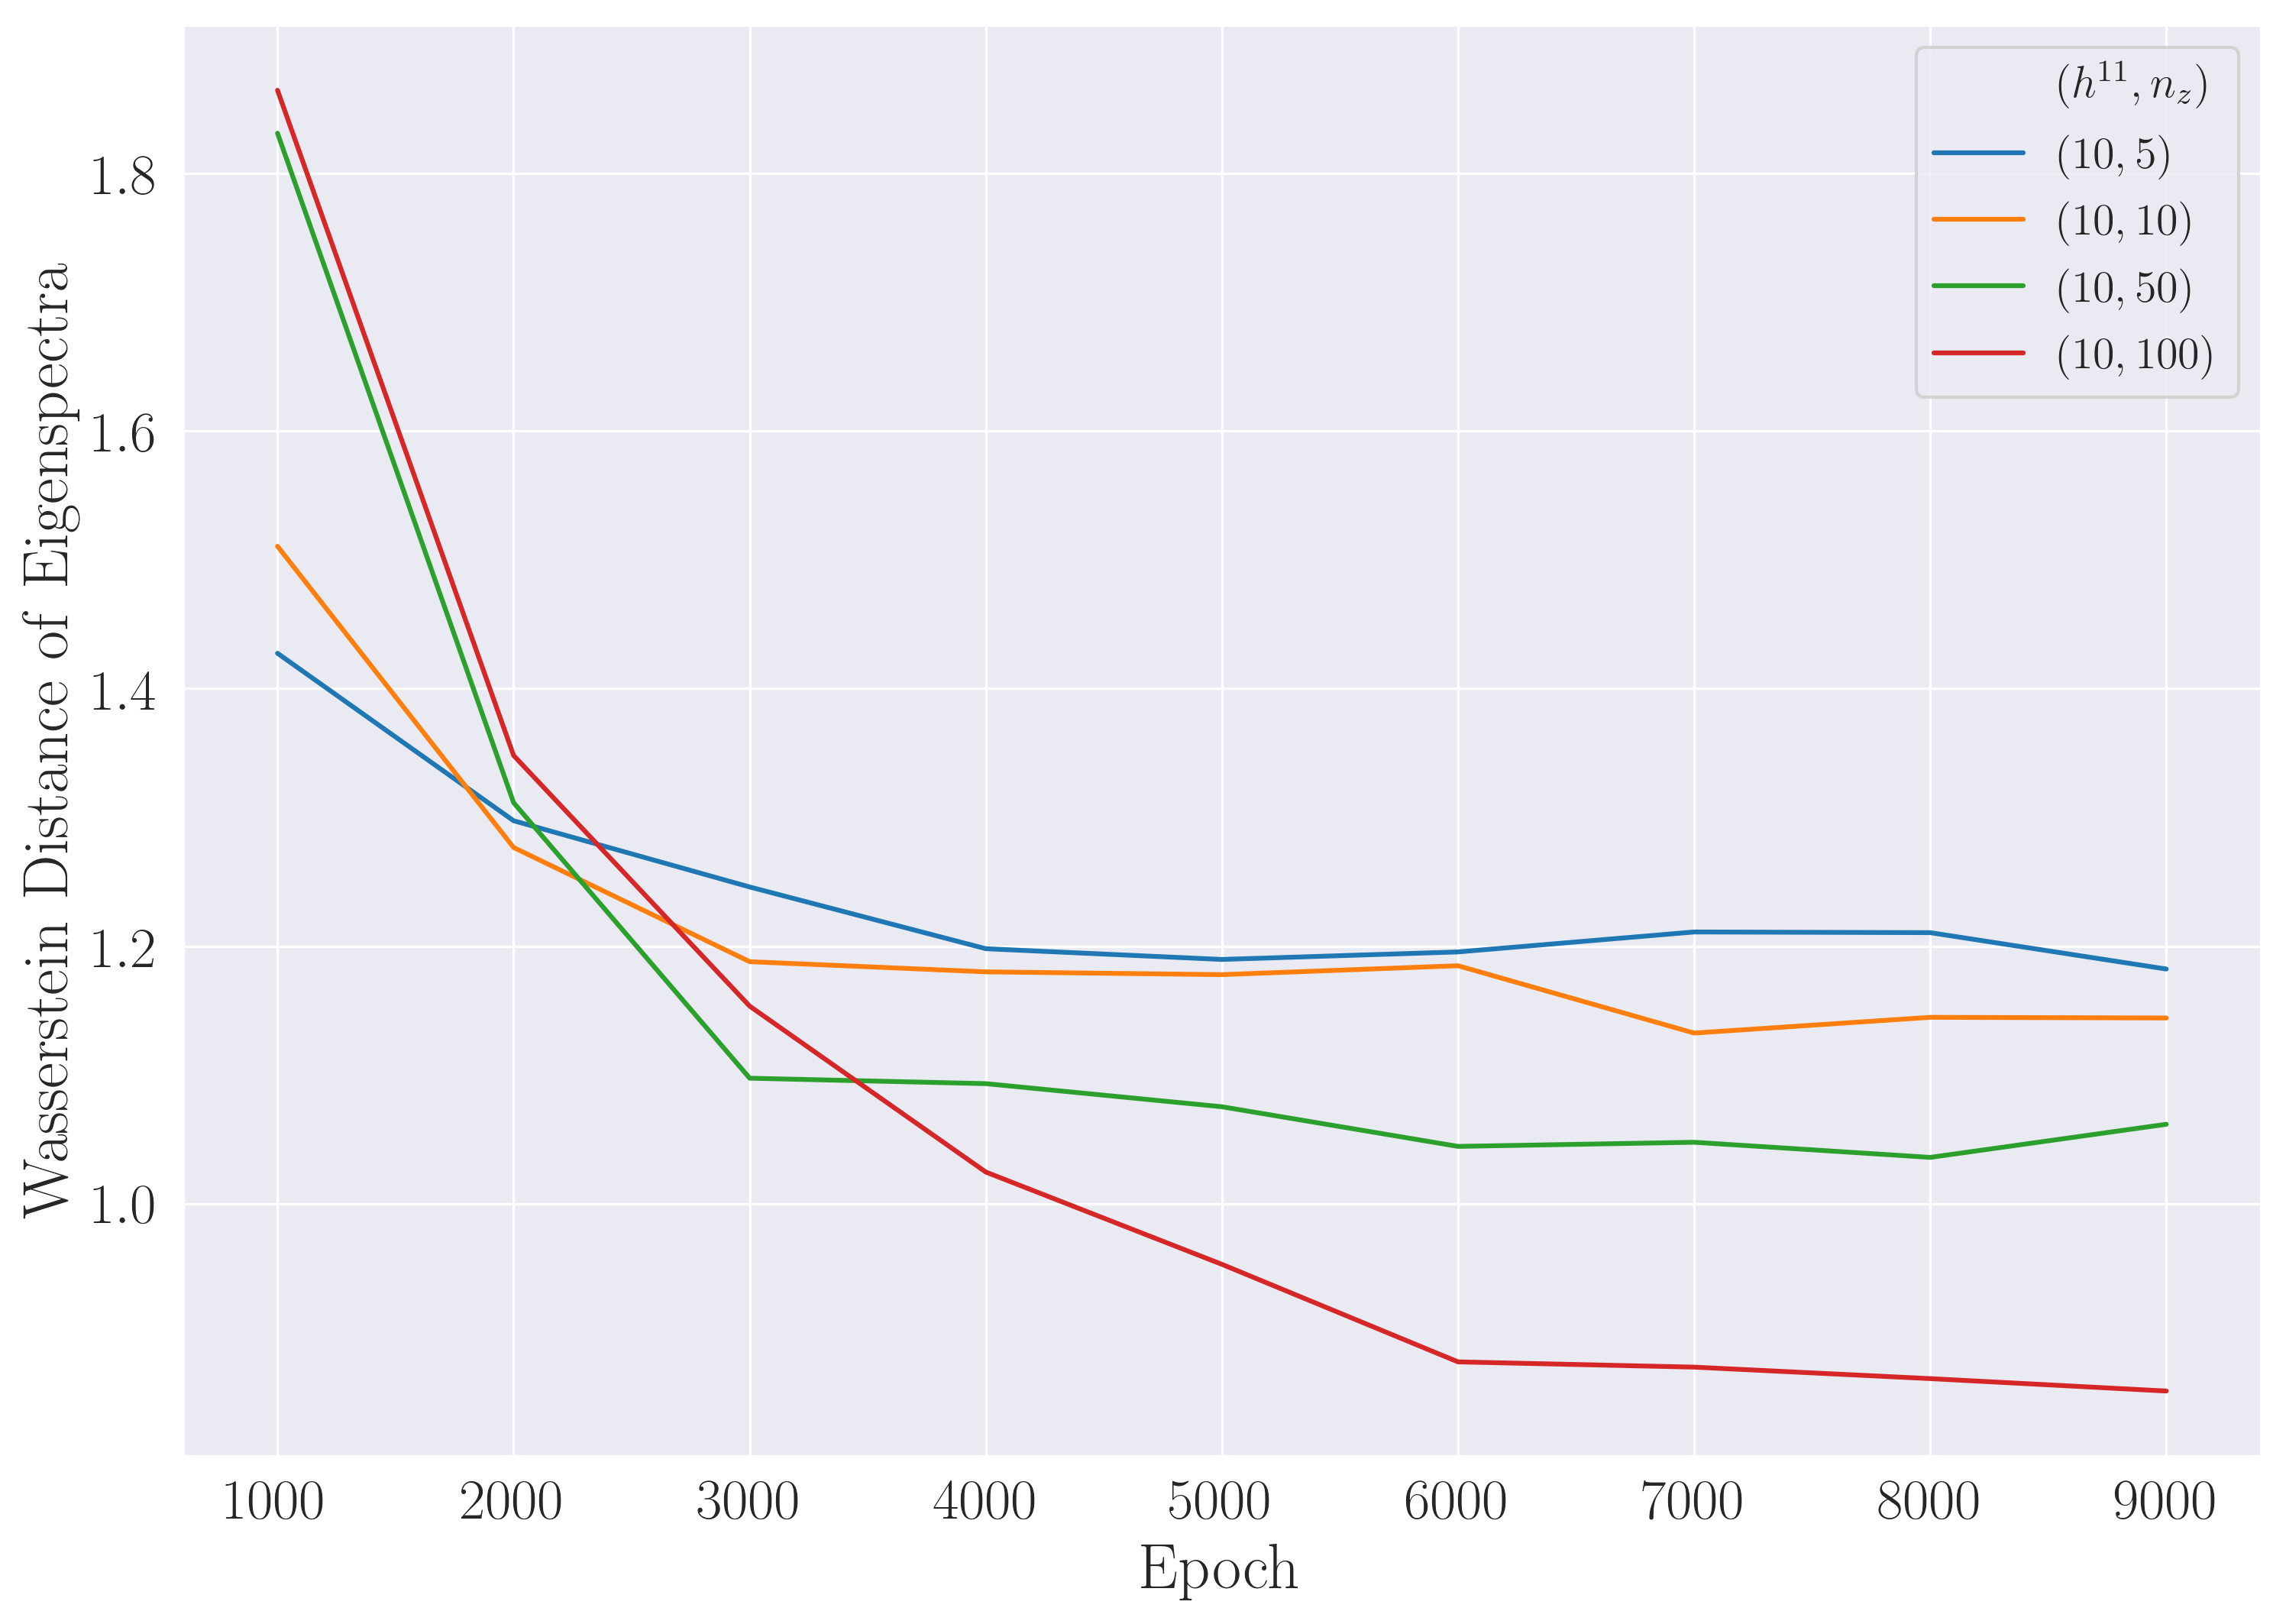

In [15]:
import cPickle as pickle
nz_data = pickle.load(open('nz_vary_more_data/nz_data_on_testdata.pickle','r'))
wasserstein_string = r'$\mathrm{Wasserstein\,\, Distance\,\, of\,\, Eigenspectra}$'
nz_data[wasserstein_string] = nz_data['GAN_dist']

epoch_string = r'$\mathrm{Epoch}$'
nz_data[epoch_string] = nz_data['epoch']

exp_string = r'$(h^{11},n_z)$'
nz_data[exp_string] = nz_data['exp']
for idx, exp in enumerate(nz_data[exp_string]):
    nz_data[exp_string][idx] = r'$'+exp+'$'

nz_df = pd.DataFrame(nz_data)
nz_df = nz_df[nz_df.epoch != 0]
nz_df = nz_df[nz_df.nz != '1']
#nz_df = nz_df[nz_df.nz != '10']
nz_df = nz_df[nz_df.nz != '20']
nz_df = nz_df[nz_df.nz != '30']
nz_df = nz_df[nz_df.nz != '40']
#nz_df = nz_df[nz_df.nz != '50']
nz_df = nz_df[nz_df.nz != '60']
nz_df = nz_df[nz_df.nz != '70']
nz_df = nz_df[nz_df.nz != '80']
nz_df = nz_df[nz_df.nz != '90']
#nz_df = nz_df[nz_df.nz != '100']

sns.set_style("darkgrid")
sns.lineplot(x=epoch_string, y=wasserstein_string, hue=exp_string, data=nz_df[nz_df.h11=='10'])
plt.show()

Index([u'$(h^{11},n_z)$', u'$\mathrm{Epoch}$',
       u'$\mathrm{Wasserstein\,\, Distance\,\, of\,\, Eigenspectra}$',
       u'GAN_dist', u'Wishart_dist', u'epoch', u'exp', u'h11', u'logGAN_dist',
       u'nz'],
      dtype='object')


/home/jim/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/jim/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


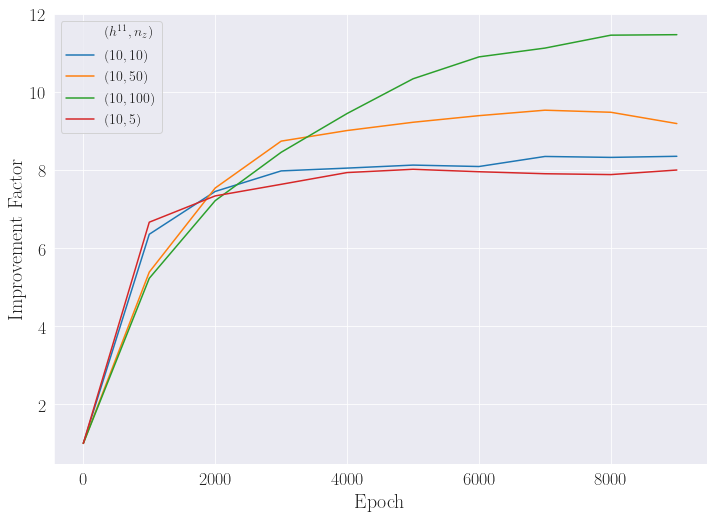

In [228]:
i_df = pd.DataFrame(nz_data)
i_df = i_df[i_df.epoch == 0]

print i_df.columns
for idx, row in nz_df.iterrows():
    for i_idx, i_row in i_df.iterrows():
        if row['exp'] == i_row['exp']:
            nz_df.set_value(idx,'INIT_GAN_dist',i_row['GAN_dist'])
            nz_df.set_value(idx,'INIT_logGAN_dist',i_row['logGAN_dist'])
            break

nz_df['Improvement'] = nz_df['INIT_GAN_dist'] / nz_df['GAN_dist']
nz_df['logImprovement'] = nz_df['INIT_logGAN_dist'] / nz_df['logGAN_dist']

improve_string = r'$\mathrm{Improvement\,\, Factor}$'
nz_df[improve_string] = nz_df['Improvement']

sns.set_style("darkgrid")
sns.lineplot(x=epoch_string, y=improve_string, hue=exp_string, data=nz_df[nz_df.h11=='10'])
plt.show()

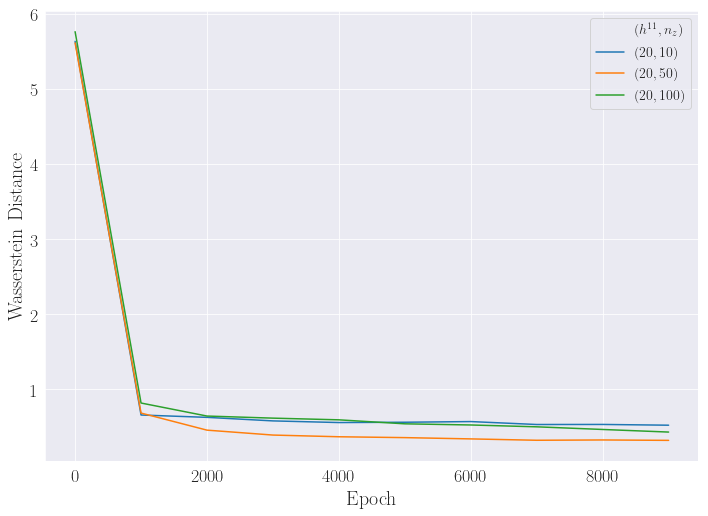

In [183]:
import cPickle as pickle
nz_data = pickle.load(open('nz_vary_more_data/nz_data.pickle','r'))
wasserstein_string = r'$\mathrm{Wasserstein\,\, Distance}$'
nz_data[wasserstein_string] = nz_data['GAN_dist']

epoch_string = r'$\mathrm{Epoch}$'
nz_data[epoch_string] = nz_data['epoch']

exp_string = r'$(h^{11},n_z)$'
nz_data[exp_string] = nz_data['exp']
for idx, exp in enumerate(nz_data[exp_string]):
    nz_data[exp_string][idx] = r'$'+exp+'$'

nz_df = pd.DataFrame(nz_data)
#nz_df = nz_df[nz_df.epoch != 0]
#nz_df = nz_df[nz_df.nz != '10']
nz_df = nz_df[nz_df.nz != '20']
nz_df = nz_df[nz_df.nz != '30']
nz_df = nz_df[nz_df.nz != '40']
#nz_df = nz_df[nz_df.nz != '50']
nz_df = nz_df[nz_df.nz != '60']
nz_df = nz_df[nz_df.nz != '70']
nz_df = nz_df[nz_df.nz != '80']
nz_df = nz_df[nz_df.nz != '90']
#nz_df = nz_df[nz_df.nz != '100']

sns.set_style("darkgrid")
sns.lineplot(x=epoch_string, y=wasserstein_string, hue=exp_string, data=nz_df[nz_df.h11=='20'])
#ax = plt.axes()
plt.show()

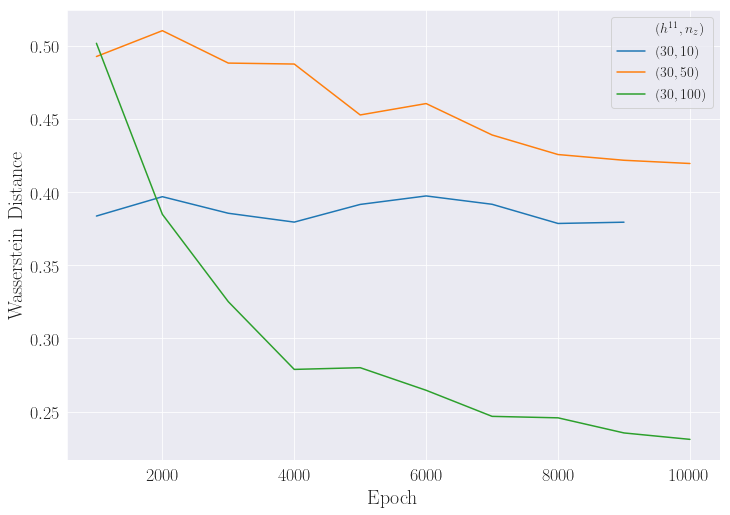

In [182]:
import cPickle as pickle
nz_data = pickle.load(open('nz_vary_more_data/nz_data.pickle','r'))
wasserstein_string = r'$\mathrm{Wasserstein\,\, Distance}$'
nz_data[wasserstein_string] = nz_data['GAN_dist']

epoch_string = r'$\mathrm{Epoch}$'
nz_data[epoch_string] = nz_data['epoch']

exp_string = r'$(h^{11},n_z)$'
nz_data[exp_string] = nz_data['exp']
for idx, exp in enumerate(nz_data[exp_string]):
    nz_data[exp_string][idx] = r'$'+exp+'$'

# Epoch 0 starts at WD ~ 4

nz_df = pd.DataFrame(nz_data)
nz_df = nz_df[nz_df.epoch != 0]
#nz_df = nz_df[nz_df.nz != '10']
nz_df = nz_df[nz_df.nz != '20']
nz_df = nz_df[nz_df.nz != '30']
nz_df = nz_df[nz_df.nz != '40']
#nz_df = nz_df[nz_df.nz != '50']
nz_df = nz_df[nz_df.nz != '60']
nz_df = nz_df[nz_df.nz != '70']
nz_df = nz_df[nz_df.nz != '80']
nz_df = nz_df[nz_df.nz != '90']
#nz_df = nz_df[nz_df.nz != '100']

sns.set_style("darkgrid")
sns.lineplot(x=epoch_string, y=wasserstein_string, hue=exp_string, data=nz_df[nz_df.h11=='30'])
#ax = plt.axes()
plt.show()

# $n_z$ on test data plots

In [ ]:
import cPickle as pickle
nz_data = pickle.load(open('nz_vary_more_data/nz_data.pickle','r'))
wasserstein_string = r'$\mathrm{Wasserstein\,\, Distance\,\, of\,\, Eigenspectra}$'
nz_data[wasserstein_string] = nz_data['GAN_dist']

epoch_string = r'$\mathrm{Epoch}$'
nz_data[epoch_string] = nz_data['epoch']

exp_string = r'$(h^{11},n_z)$'
nz_data[exp_string] = nz_data['exp']
for idx, exp in enumerate(nz_data[exp_string]):
    nz_data[exp_string][idx] = r'$'+exp+'$'

nz_df = pd.DataFrame(nz_data)
#nz_df = nz_df[nz_df.epoch != 0]
nz_df = nz_df[nz_df.nz != '1']
#nz_df = nz_df[nz_df.nz != '10']
nz_df = nz_df[nz_df.nz != '20']
nz_df = nz_df[nz_df.nz != '30']
nz_df = nz_df[nz_df.nz != '40']
#nz_df = nz_df[nz_df.nz != '50']
nz_df = nz_df[nz_df.nz != '60']
nz_df = nz_df[nz_df.nz != '70']
nz_df = nz_df[nz_df.nz != '80']
nz_df = nz_df[nz_df.nz != '90']
#nz_df = nz_df[nz_df.nz != '100']

sns.set_style("darkgrid")
sns.lineplot(x=epoch_string, y=wasserstein_string, hue=exp_string, data=nz_df[nz_df.h11=='10'])
plt.show()

# Noise, Wishart, and Data single images

(10, 10, 3) (3, 10, 10)


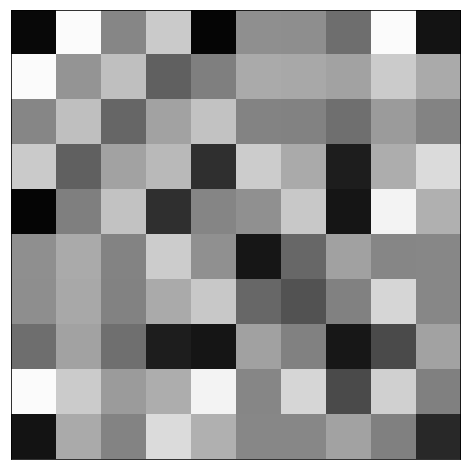

[[[0.03137255, 0.9843137, 0.5254902, 0.7921569, 0.019607844, 0.56078434, 0.5568628, 0.43137255, 0.9843137, 0.07450981], [0.9843137, 0.5803922, 0.7490196, 0.3764706, 0.49803922, 0.6666667, 0.65882355, 0.63529414, 0.79607844, 0.6666667], [0.5254902, 0.7490196, 0.4, 0.63529414, 0.7607843, 0.5137255, 0.50980395, 0.43529412, 0.60784316, 0.5137255], [0.7921569, 0.3764706, 0.63529414, 0.7254902, 0.18431373, 0.8, 0.6666667, 0.11372549, 0.6784314, 0.85882354], [0.019607844, 0.49803922, 0.7607843, 0.18431373, 0.52156866, 0.5647059, 0.78431374, 0.08235294, 0.9529412, 0.6901961], [0.56078434, 0.6666667, 0.5137255, 0.8, 0.5647059, 0.08627451, 0.40392157, 0.6313726, 0.5254902, 0.5294118], [0.5568628, 0.65882355, 0.50980395, 0.6666667, 0.78431374, 0.40392157, 0.32156864, 0.5058824, 0.8392157, 0.5294118], [0.43137255, 0.63529414, 0.43529412, 0.11372549, 0.08235294, 0.6313726, 0.5058824, 0.09019608, 0.2901961, 0.63529414], [0.9843137, 0.79607844, 0.60784316, 0.6784314, 0.9529412, 0.5254902, 0.8392157, 

In [91]:
def simple_image_show(tensor, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0, scale_factor=1, dpi=100, title = '', xlabel = '', filename = ''):
    tensor.data = tensor.data.mul(0.5).add(0.5)
    
    size = tensor.shape[2]
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=scale_factor*size),
        transforms.ToTensor()
    ])
    tensor = [transform(x_) for x_ in tensor]
    img = torchvision.utils.make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    npimg = img.detach().numpy()
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.yticks([])
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
    if xlabel != '': plt.xlabel(xlabel) #xlabel(r'$\mathrm{Number\,\, of\,\, steps}$')
    if title != '': plt.title(title)
    #print np.transpose(npimg,(1,2,0)).shape, npimg.shape
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    if filename != '': plt.savefig(filename,dpi=dpi)
    plt.show()
    
    return npimg

img = simple_image_show(torch.FloatTensor(test_Ks[0]).view(1,1,10,10))
print list([list([list(p) for p in k]) for k in img])

In [74]:
import os
import cPickle as pickle

num_geometries = 3000
test_Ks = []
for h11 in [10]:
    files_list = [d for d in os.listdir('../../KS4/data') if "_"+str(h11)+"_" in d and '_' in d and 'K.' in d]
    train_list = files_list[:num_geometries]
    test_list = [t for t in files_list if t not in train_list]
    print "h11, NUM TRAIN, NUM TEST:", h11, len(train_list), len(test_list)
    
    cur_evals = []
    for test_file in test_list:
        test_Ks.append(pickle.load(open('../../KS4/data/'+test_file,'r')))

print 'number of test kahler metrics', len(test_Ks)

h11, NUM TRAIN, NUM TEST: 10 3000 6282
number of test kahler metrics 6282


In [39]:
torch.tensor(test_Ks[0]).view(1,1,10,10).shape

torch.Size([1, 1, 10, 10])

(10, 10, 3) (3, 10, 10)


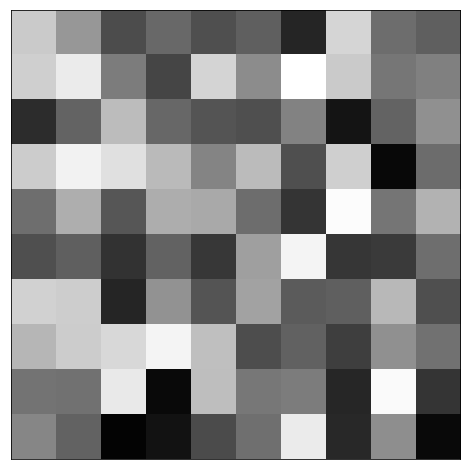

(10, 10, 3) (3, 10, 10)


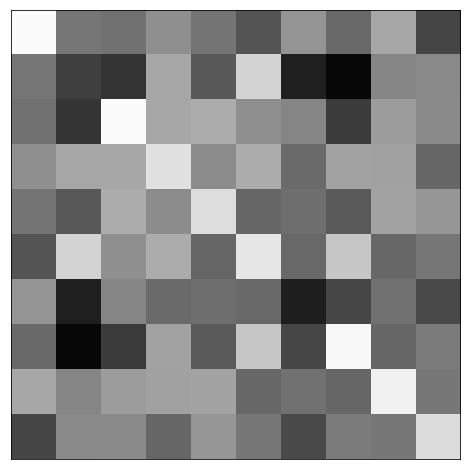

(10, 10, 3) (3, 10, 10)


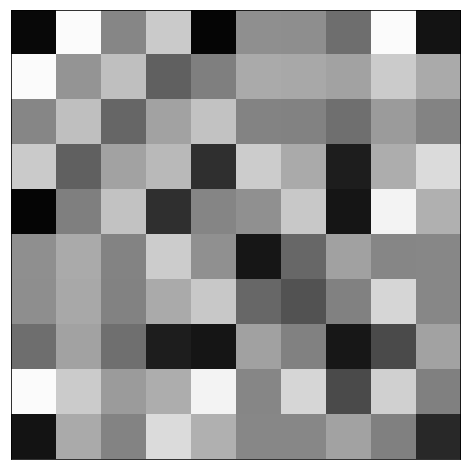

(10, 10, 3) (3, 10, 10)


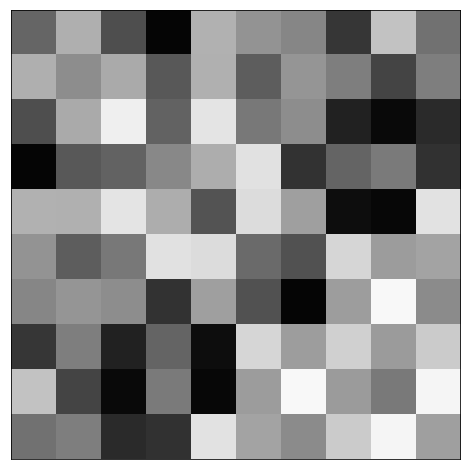

(10, 10, 3) (3, 10, 10)


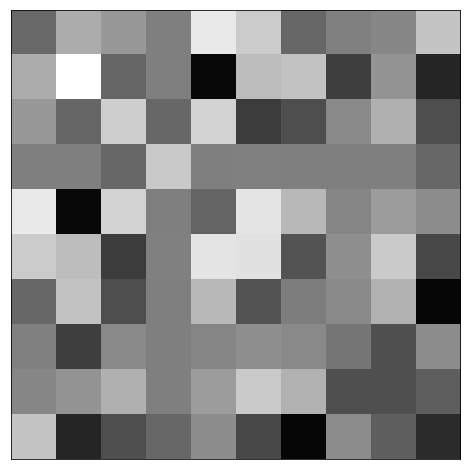

(10, 10, 3) (3, 10, 10)


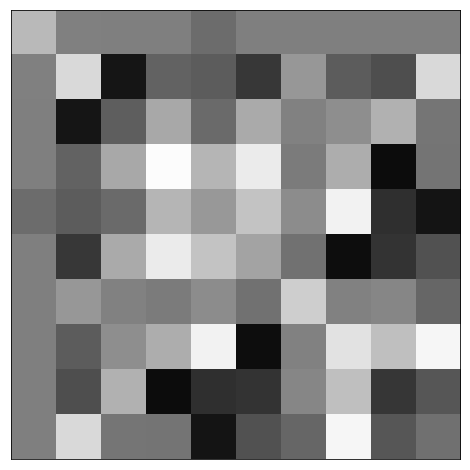

(10, 10, 3) (3, 10, 10)


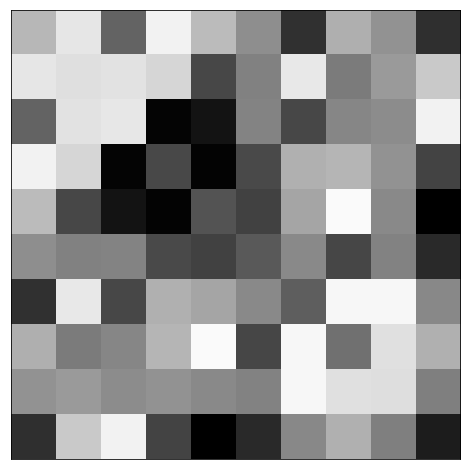

(10, 10, 3) (3, 10, 10)


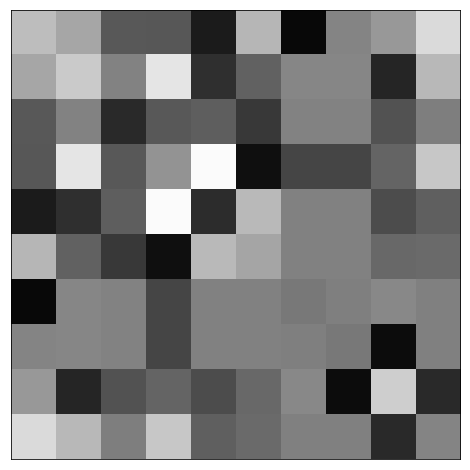

(10, 10, 3) (3, 10, 10)


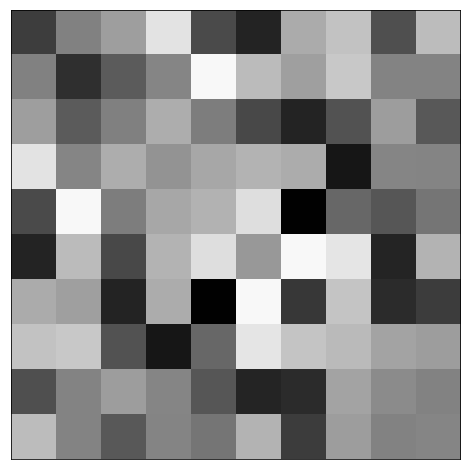

(10, 10, 3) (3, 10, 10)


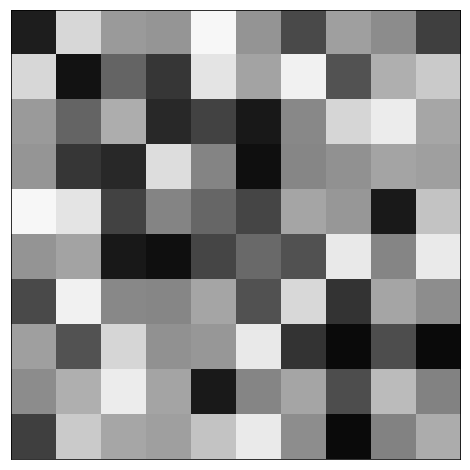

(10, 10, 3) (3, 10, 10)


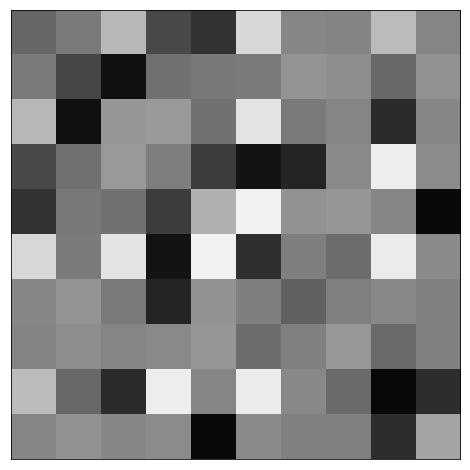

(10, 10, 3) (3, 10, 10)


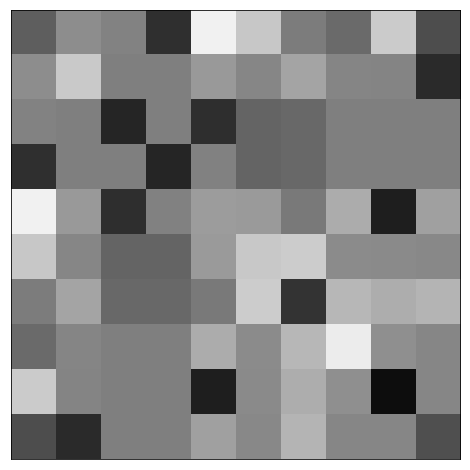

(10, 10, 3) (3, 10, 10)


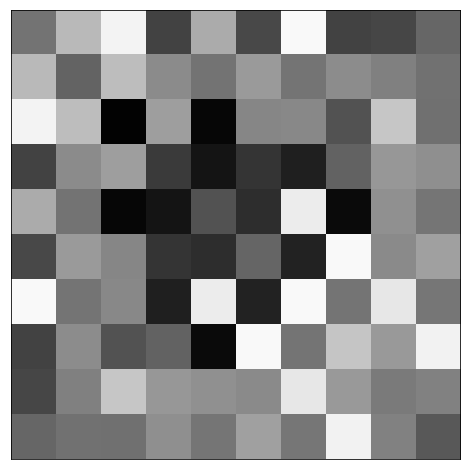

(10, 10, 3) (3, 10, 10)


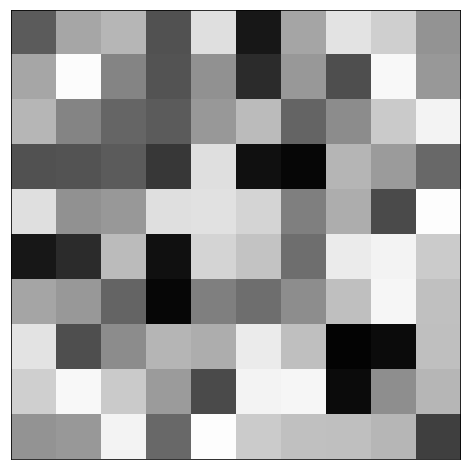

(10, 10, 3) (3, 10, 10)


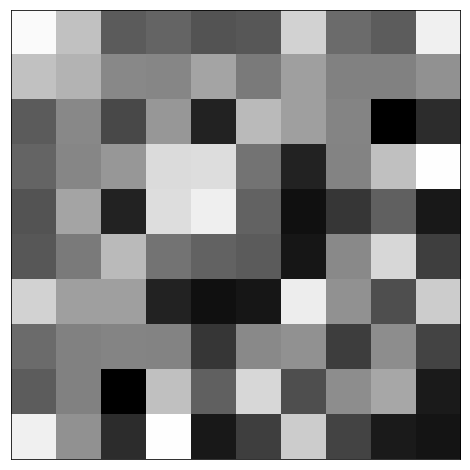

(10, 10, 3) (3, 10, 10)


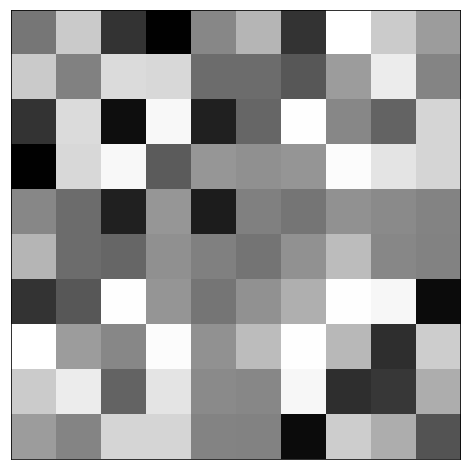

(10, 10, 3) (3, 10, 10)


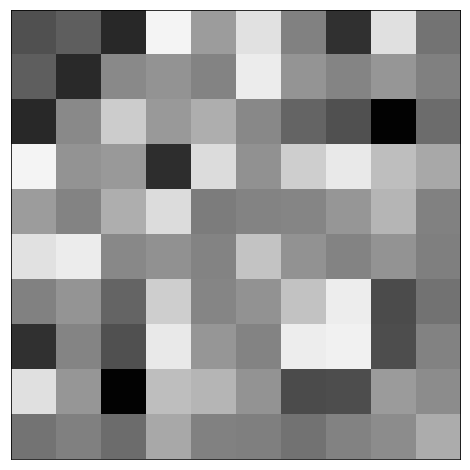

(10, 10, 3) (3, 10, 10)


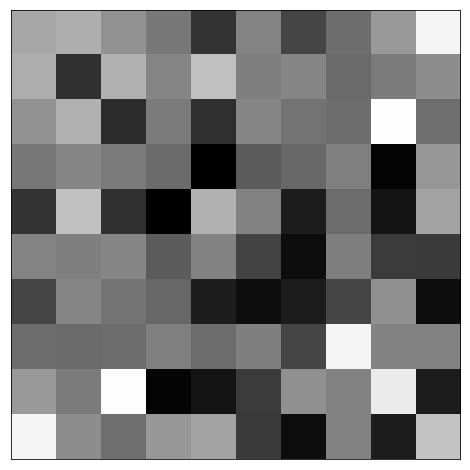

(10, 10, 3) (3, 10, 10)


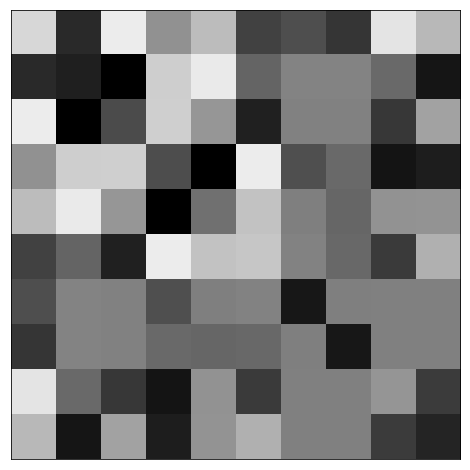

(10, 10, 3) (3, 10, 10)


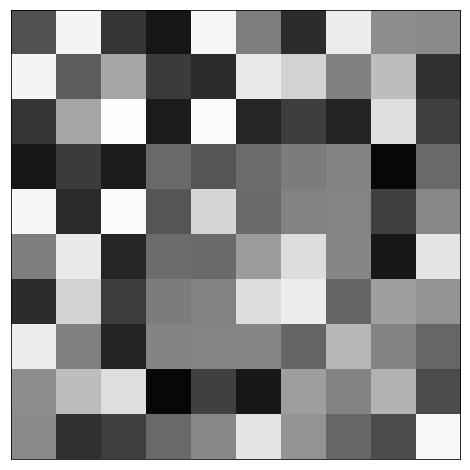

(10, 10, 3) (3, 10, 10)


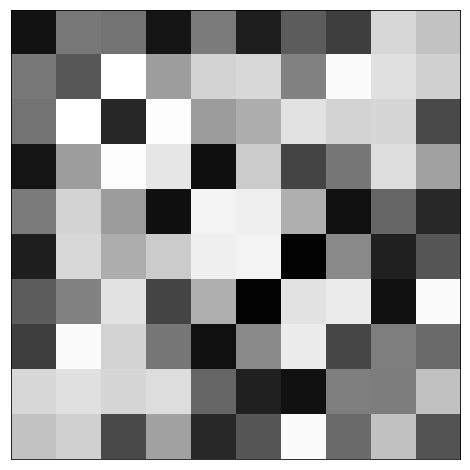

(10, 10, 3) (3, 10, 10)


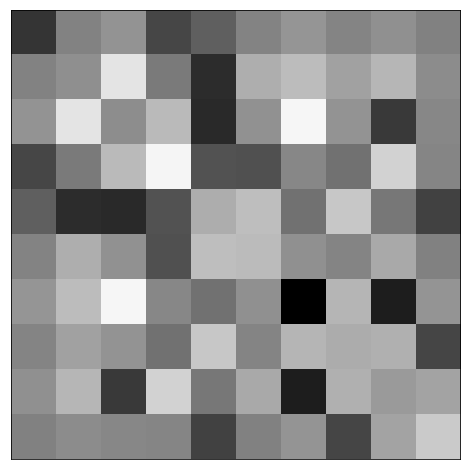

(10, 10, 3) (3, 10, 10)


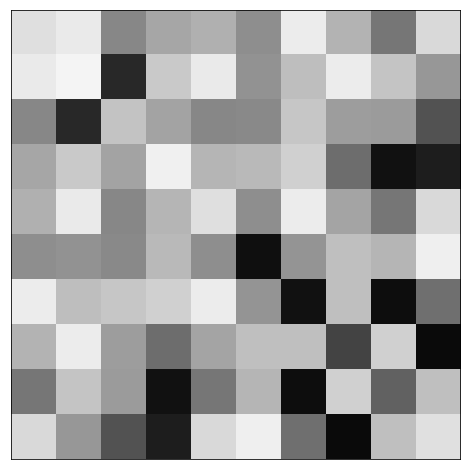

(10, 10, 3) (3, 10, 10)


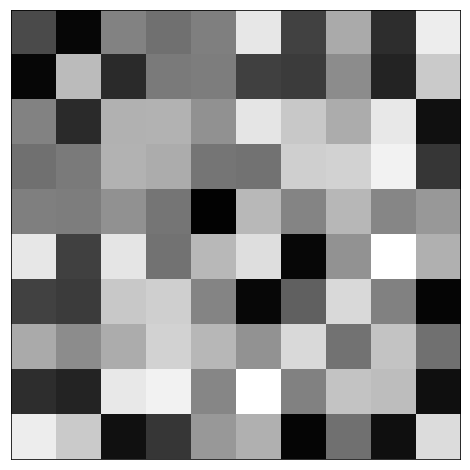

(10, 10, 3) (3, 10, 10)


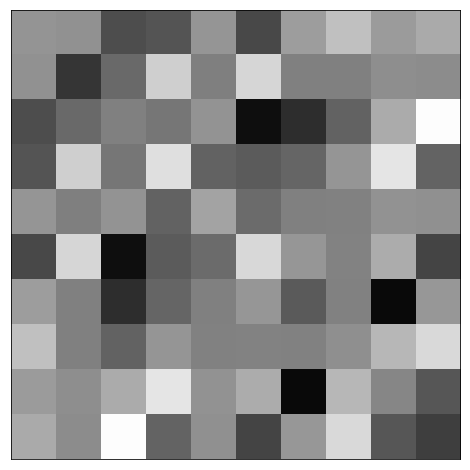

(10, 10, 3) (3, 10, 10)


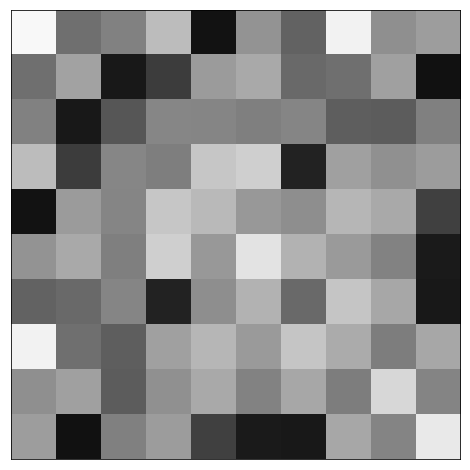

(10, 10, 3) (3, 10, 10)


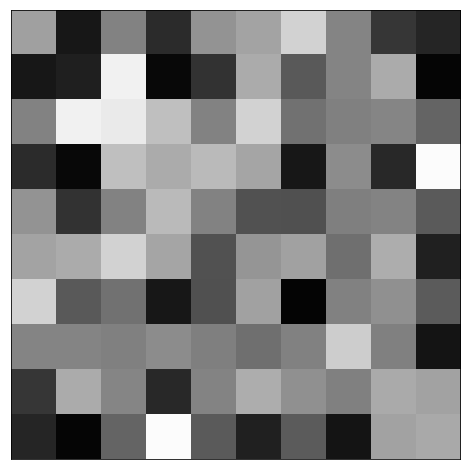

(10, 10, 3) (3, 10, 10)


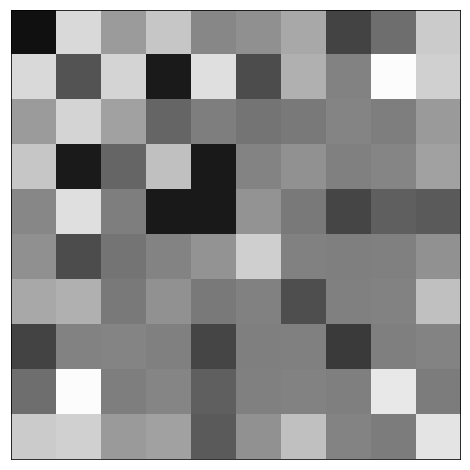

(10, 10, 3) (3, 10, 10)


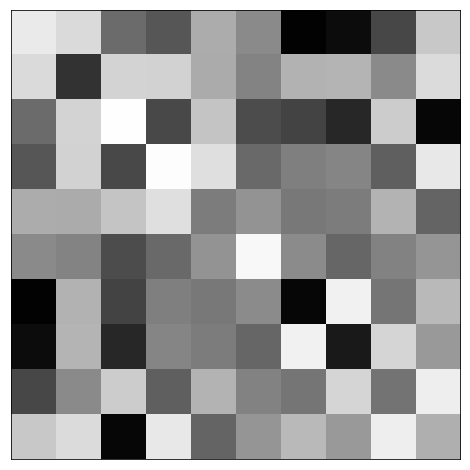

(10, 10, 3) (3, 10, 10)


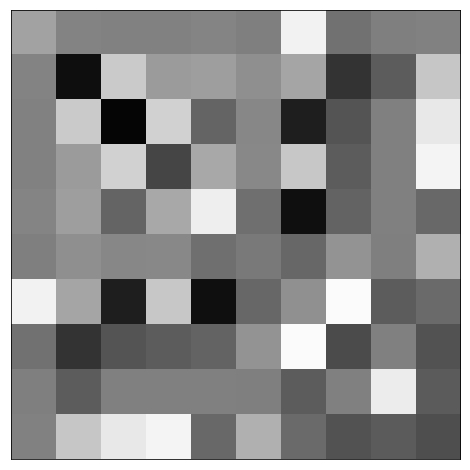

(10, 10, 3) (3, 10, 10)


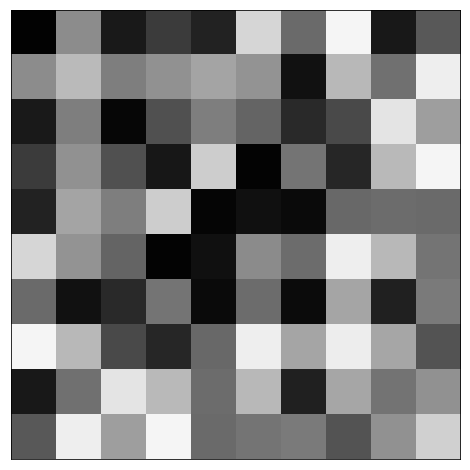

(10, 10, 3) (3, 10, 10)


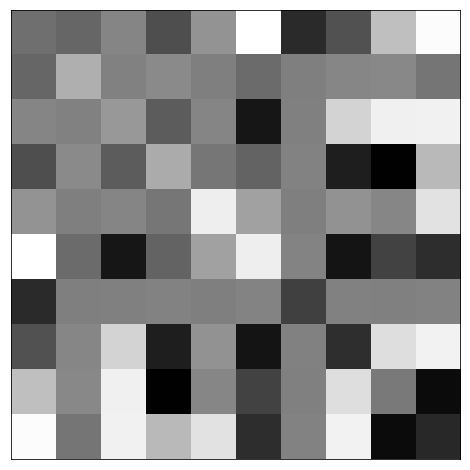

(10, 10, 3) (3, 10, 10)


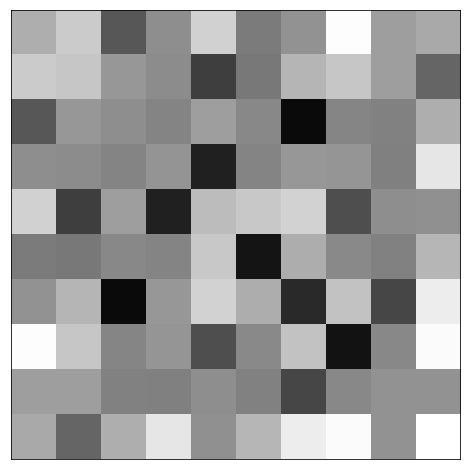

(10, 10, 3) (3, 10, 10)


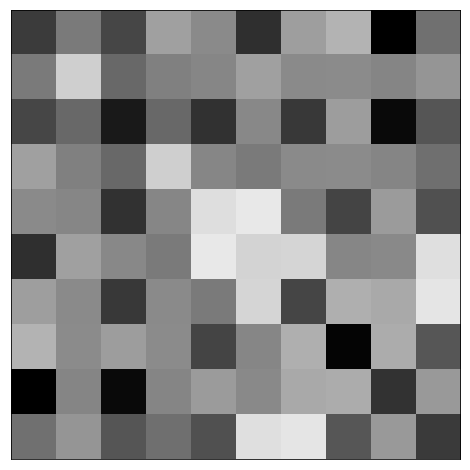

(10, 10, 3) (3, 10, 10)


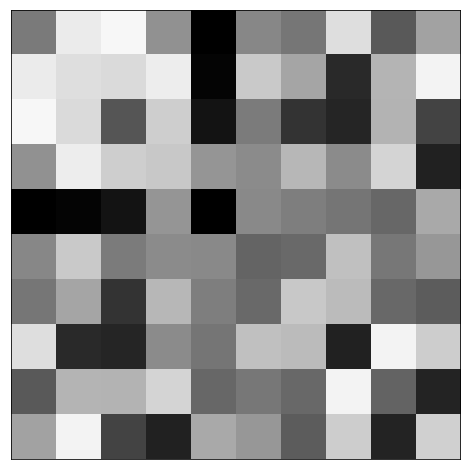

(10, 10, 3) (3, 10, 10)


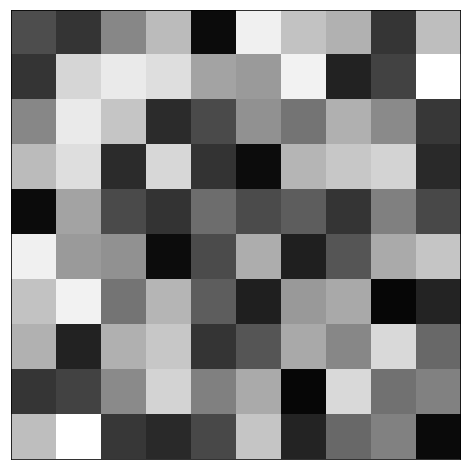

(10, 10, 3) (3, 10, 10)


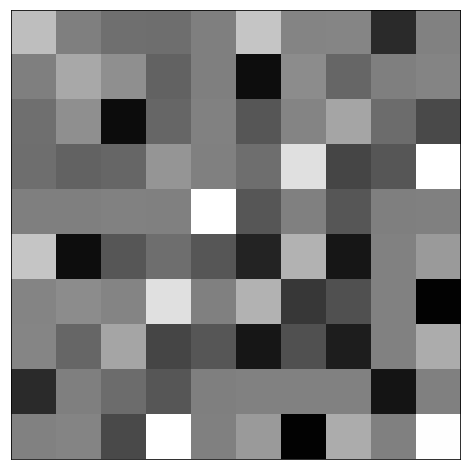

(10, 10, 3) (3, 10, 10)


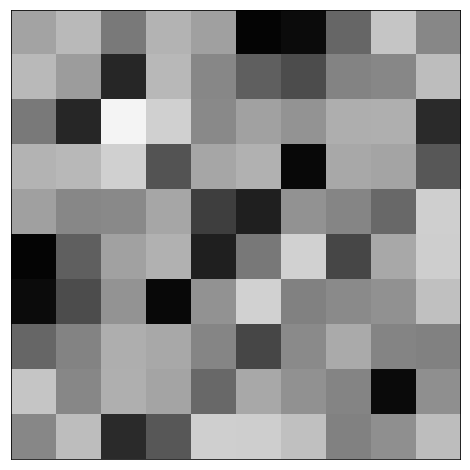

(10, 10, 3) (3, 10, 10)


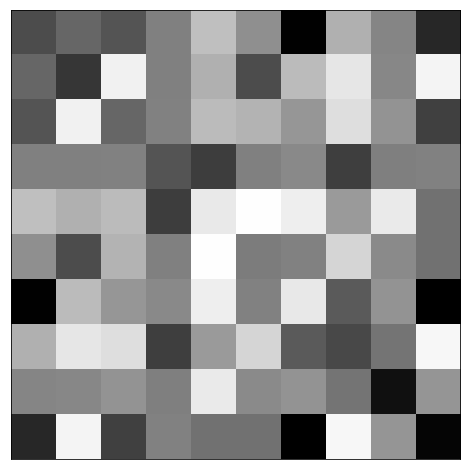

(10, 10, 3) (3, 10, 10)


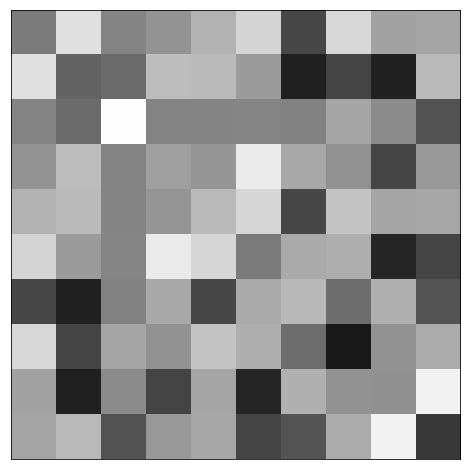

(10, 10, 3) (3, 10, 10)


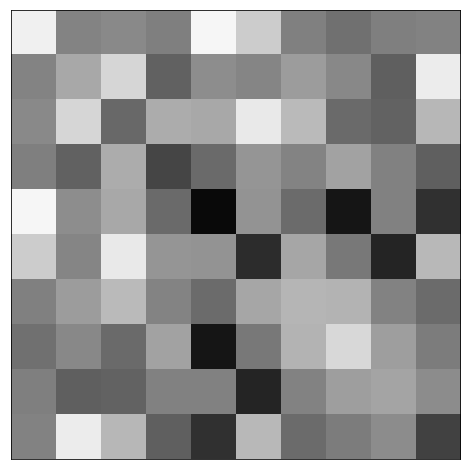

(10, 10, 3) (3, 10, 10)


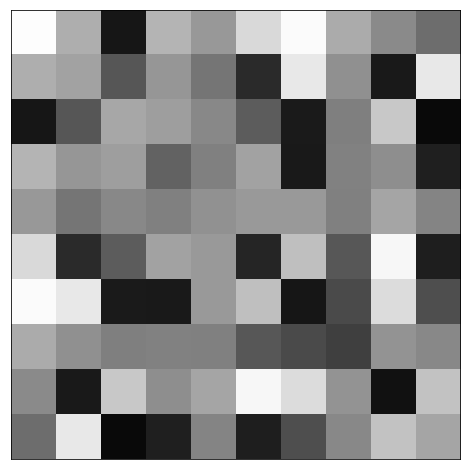

(10, 10, 3) (3, 10, 10)


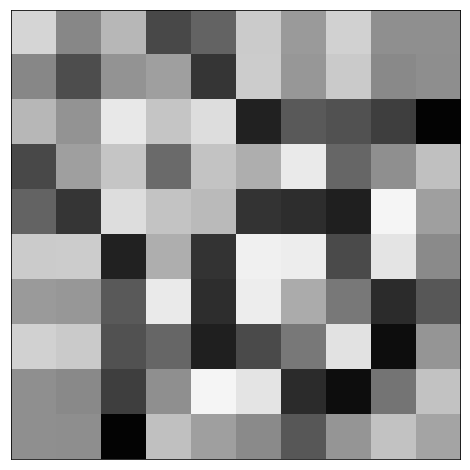

(10, 10, 3) (3, 10, 10)


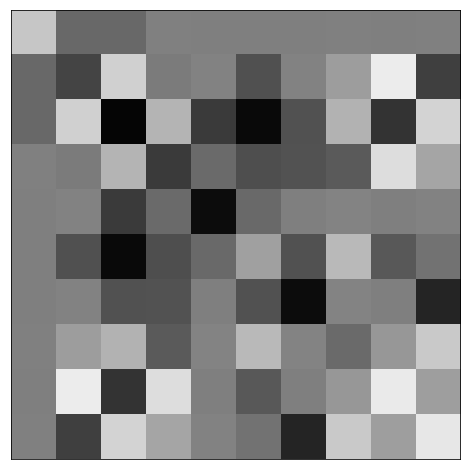

(10, 10, 3) (3, 10, 10)


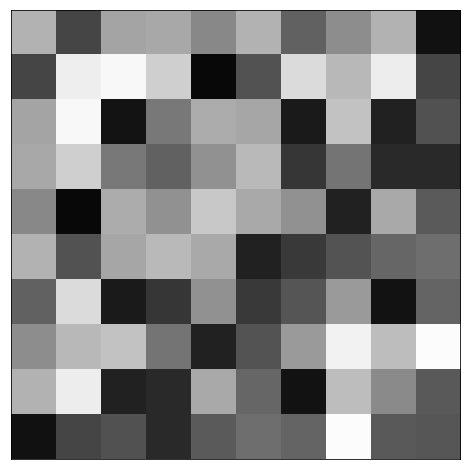

(10, 10, 3) (3, 10, 10)


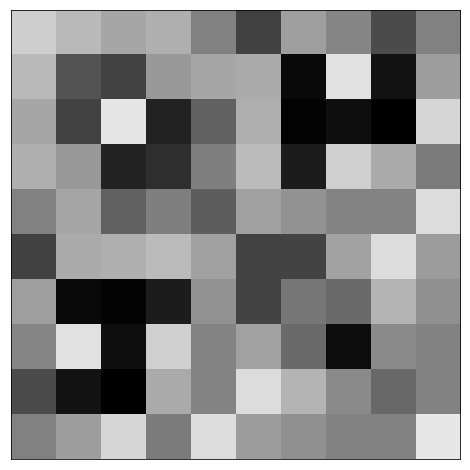

(10, 10, 3) (3, 10, 10)


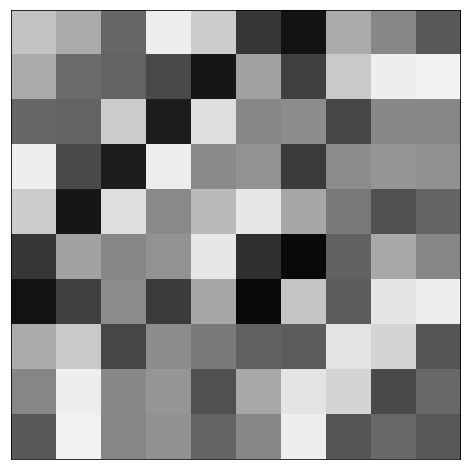

(10, 10, 3) (3, 10, 10)


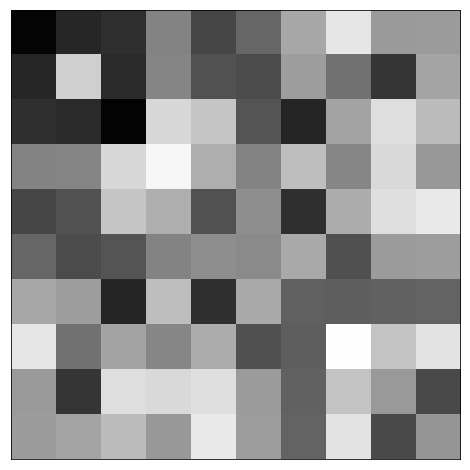

(10, 10, 3) (3, 10, 10)


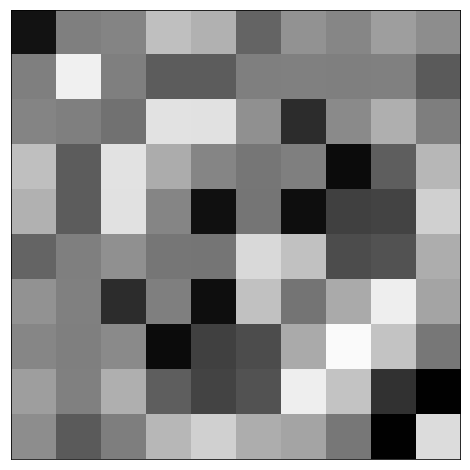

(10, 10, 3) (3, 10, 10)


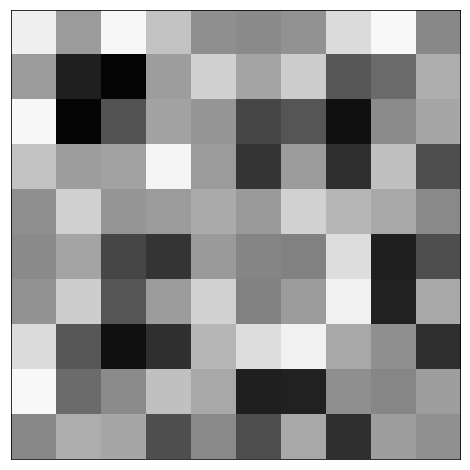

(10, 10, 3) (3, 10, 10)


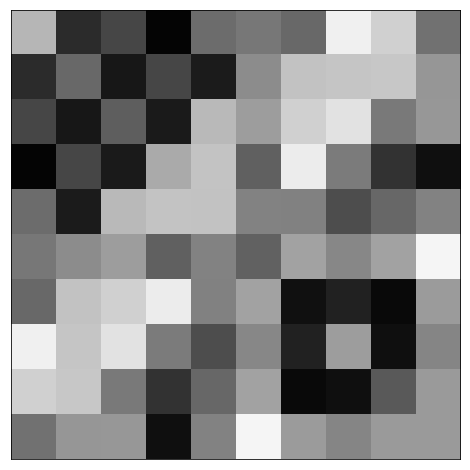

(10, 10, 3) (3, 10, 10)


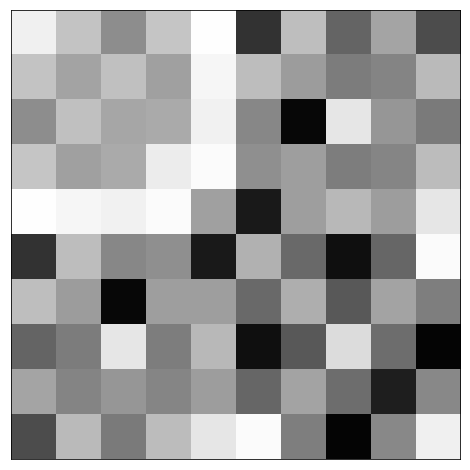

(10, 10, 3) (3, 10, 10)


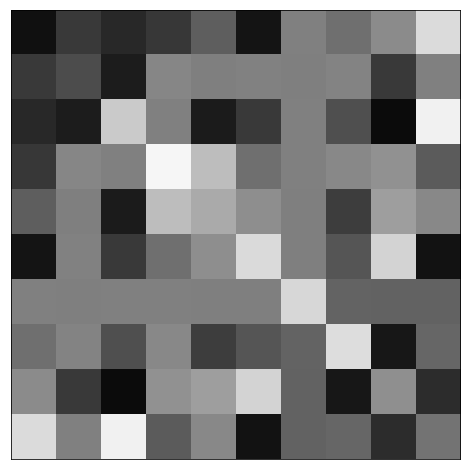

(10, 10, 3) (3, 10, 10)


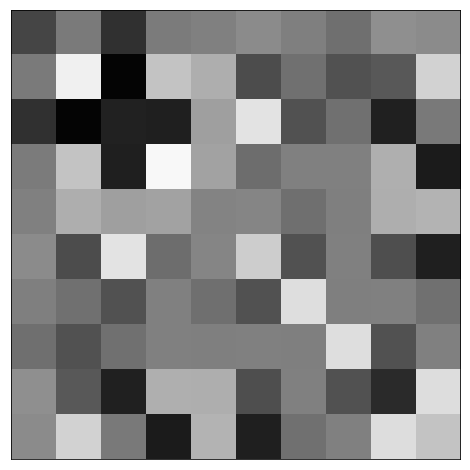

(10, 10, 3) (3, 10, 10)


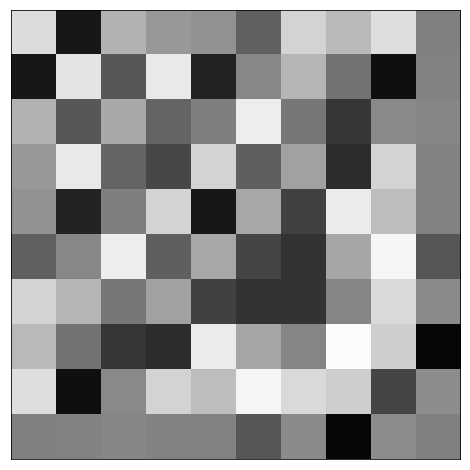

(10, 10, 3) (3, 10, 10)


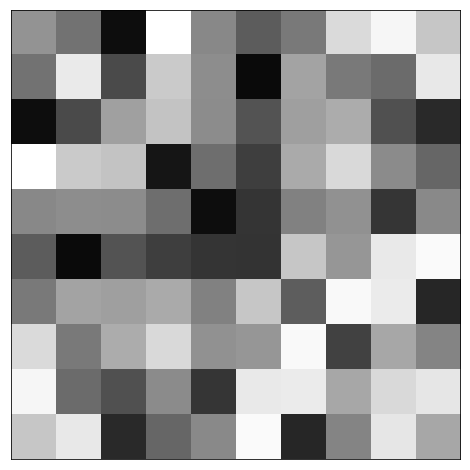

(10, 10, 3) (3, 10, 10)


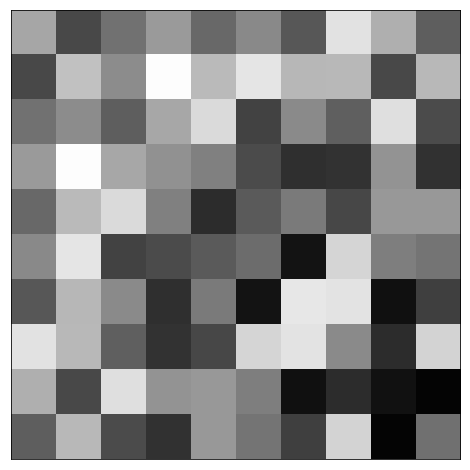

(10, 10, 3) (3, 10, 10)


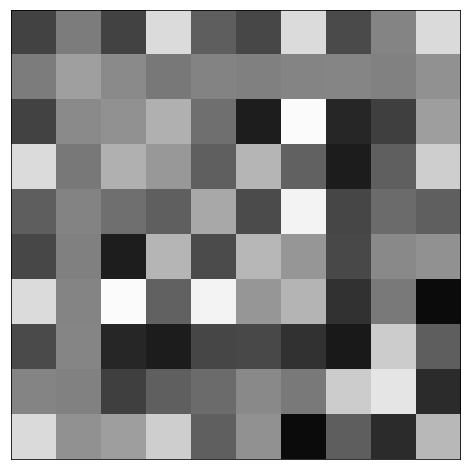

(10, 10, 3) (3, 10, 10)


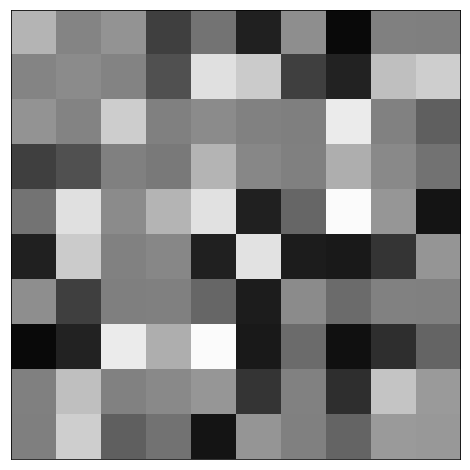

(10, 10, 3) (3, 10, 10)


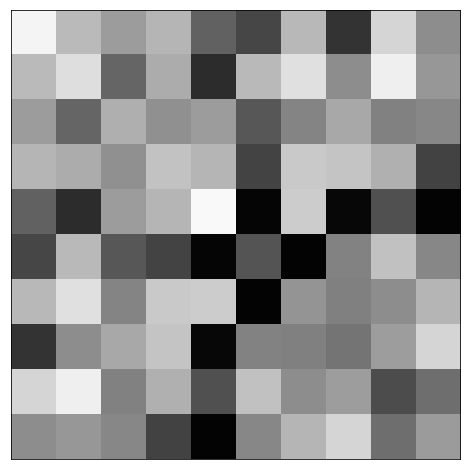

(10, 10, 3) (3, 10, 10)


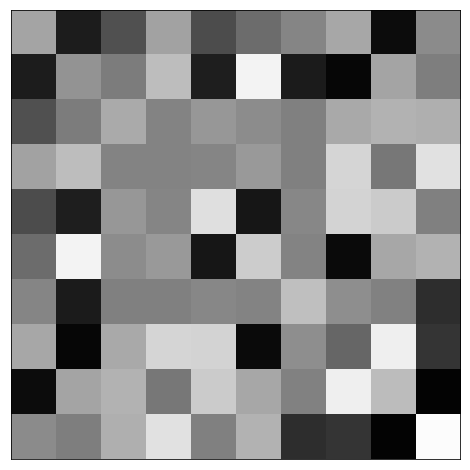

(10, 10, 3) (3, 10, 10)


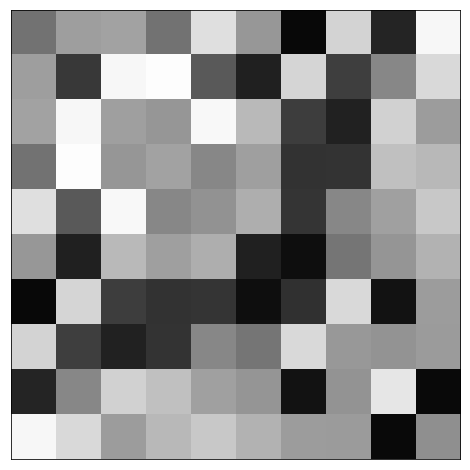

(10, 10, 3) (3, 10, 10)


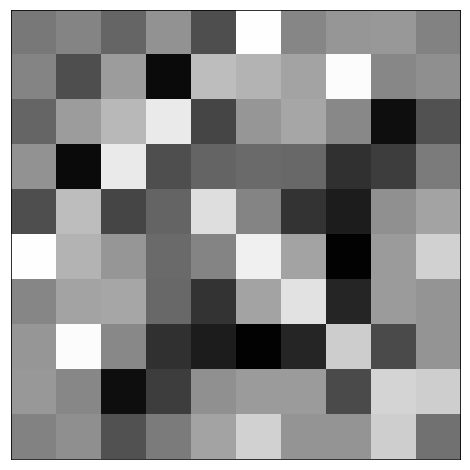

(10, 10, 3) (3, 10, 10)


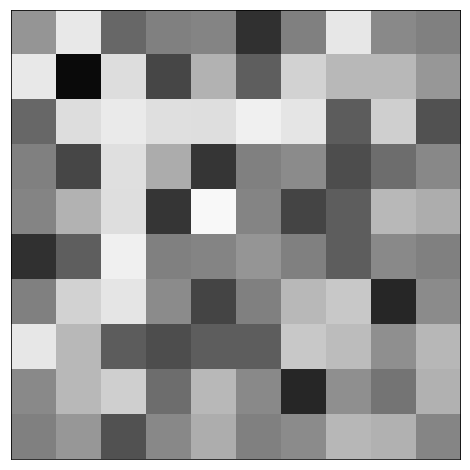

(10, 10, 3) (3, 10, 10)


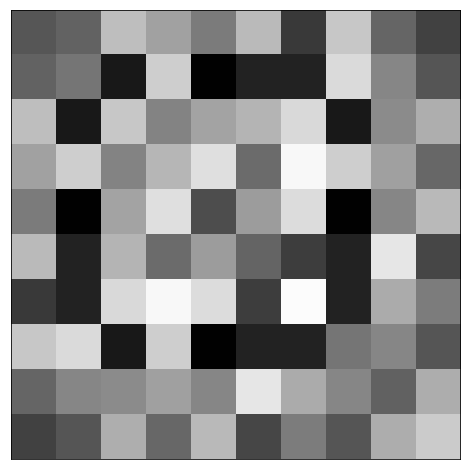

(10, 10, 3) (3, 10, 10)


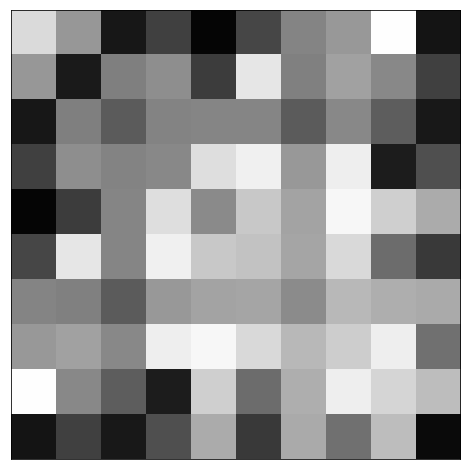

(10, 10, 3) (3, 10, 10)


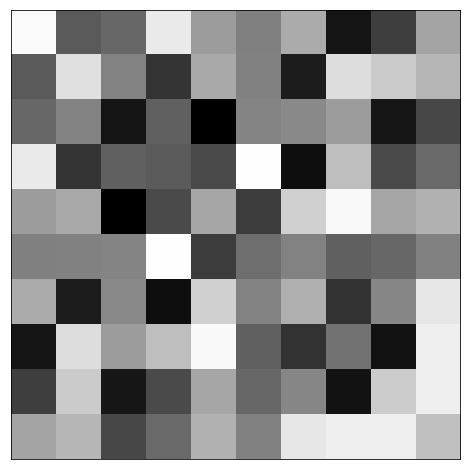

(10, 10, 3) (3, 10, 10)


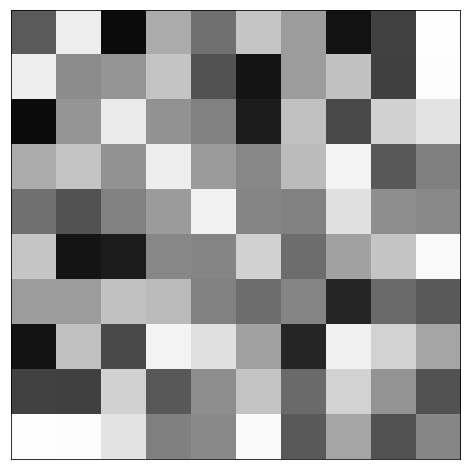

(10, 10, 3) (3, 10, 10)


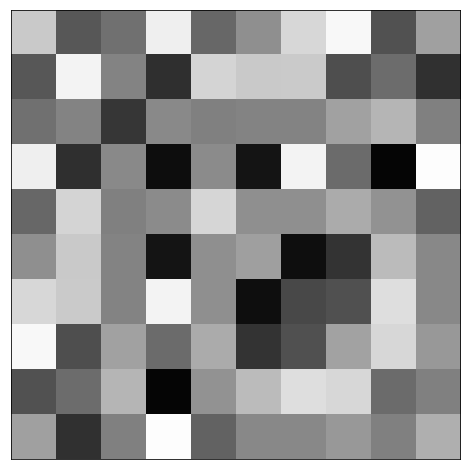

(10, 10, 3) (3, 10, 10)


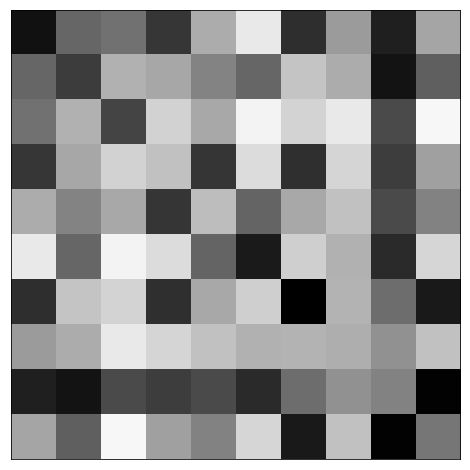

(10, 10, 3) (3, 10, 10)


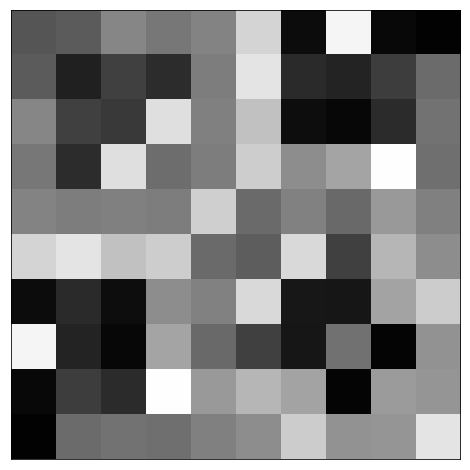

(10, 10, 3) (3, 10, 10)


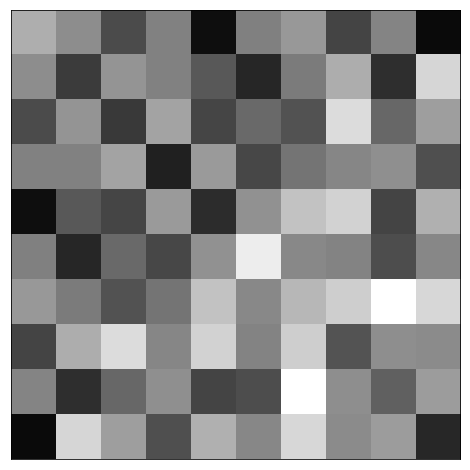

(10, 10, 3) (3, 10, 10)


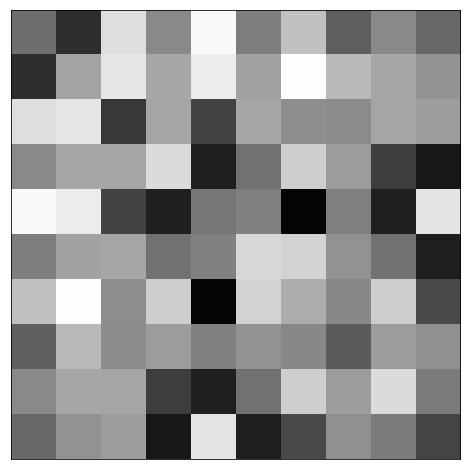

(10, 10, 3) (3, 10, 10)


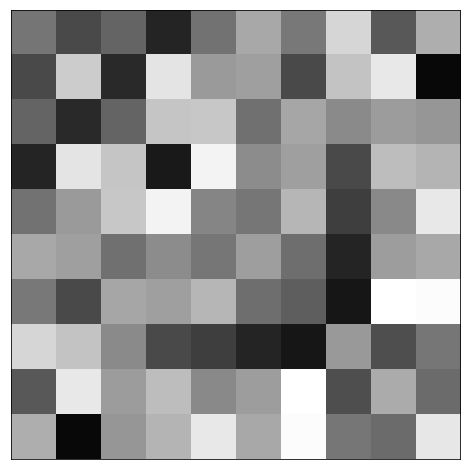

(10, 10, 3) (3, 10, 10)


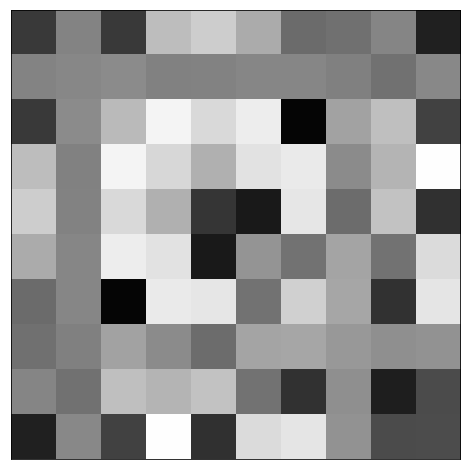

(10, 10, 3) (3, 10, 10)


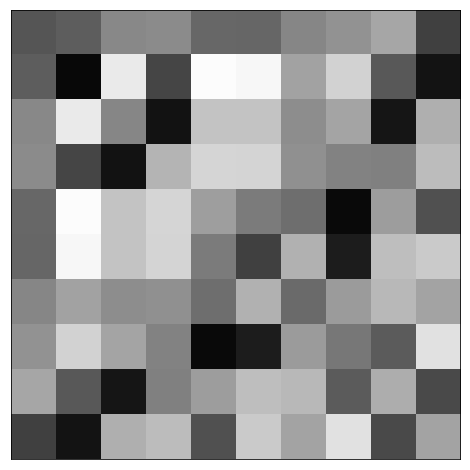

(10, 10, 3) (3, 10, 10)


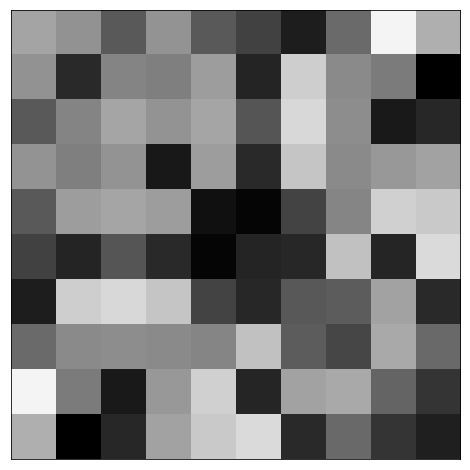

(10, 10, 3) (3, 10, 10)


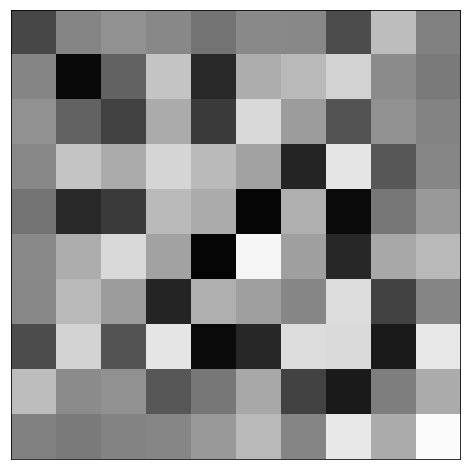

(10, 10, 3) (3, 10, 10)


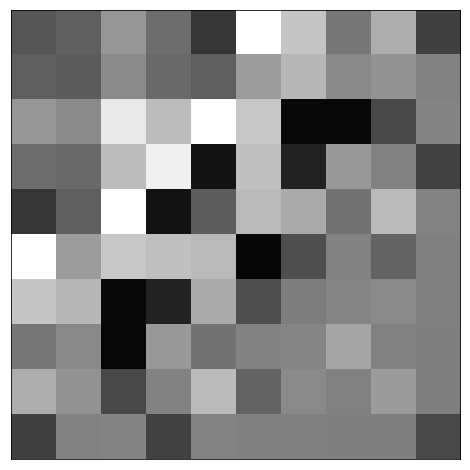

(10, 10, 3) (3, 10, 10)


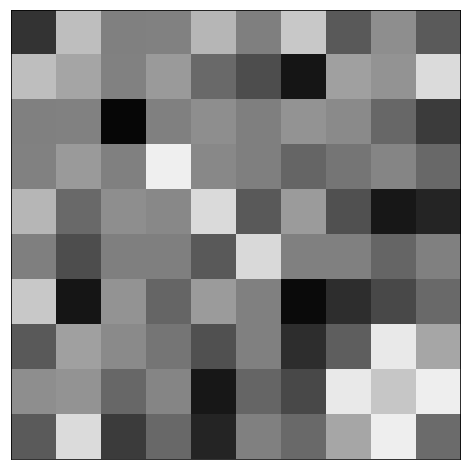

(10, 10, 3) (3, 10, 10)


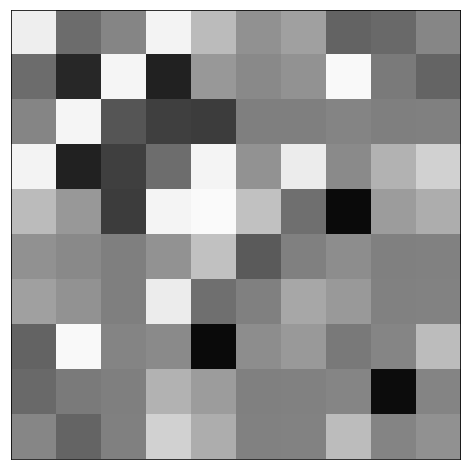

(10, 10, 3) (3, 10, 10)


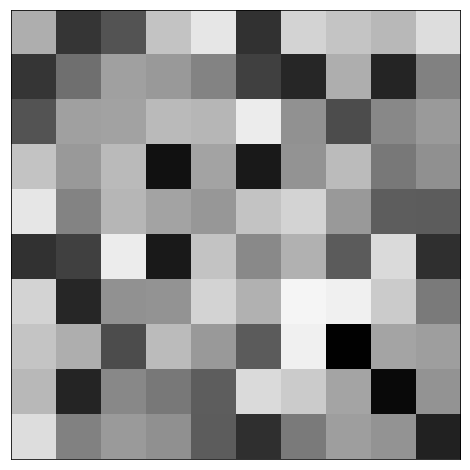

(10, 10, 3) (3, 10, 10)


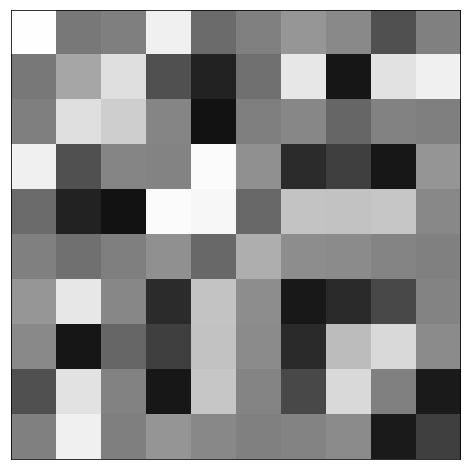

(10, 10, 3) (3, 10, 10)


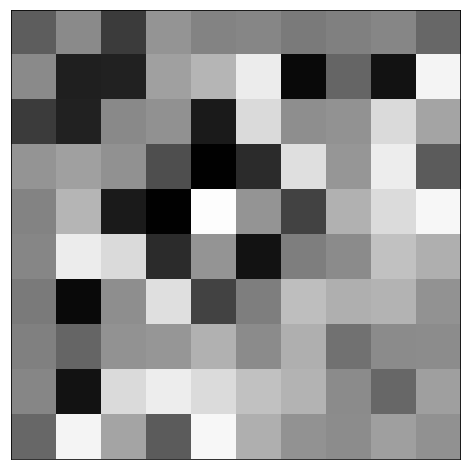

(10, 10, 3) (3, 10, 10)


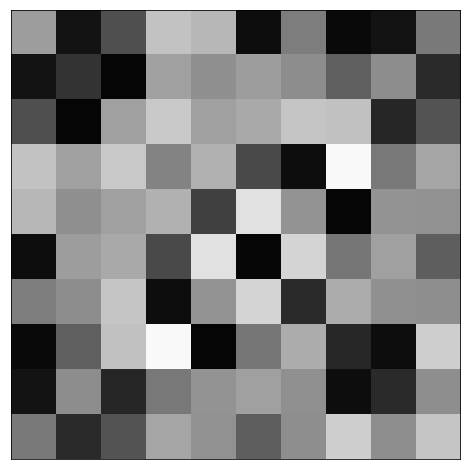

(10, 10, 3) (3, 10, 10)


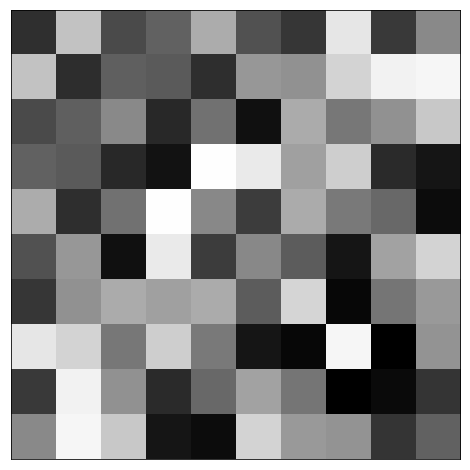

(10, 10, 3) (3, 10, 10)


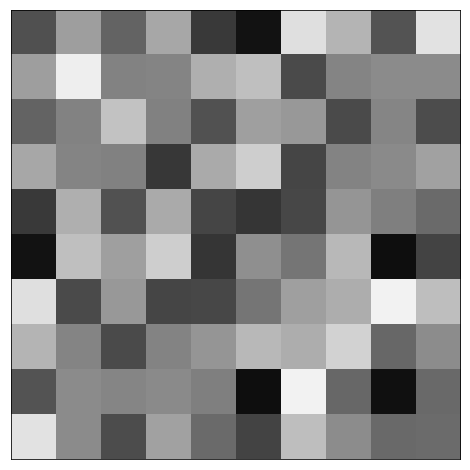

(10, 10, 3) (3, 10, 10)


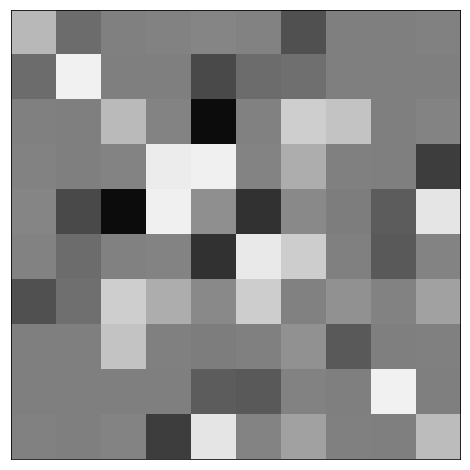

(10, 10, 3) (3, 10, 10)


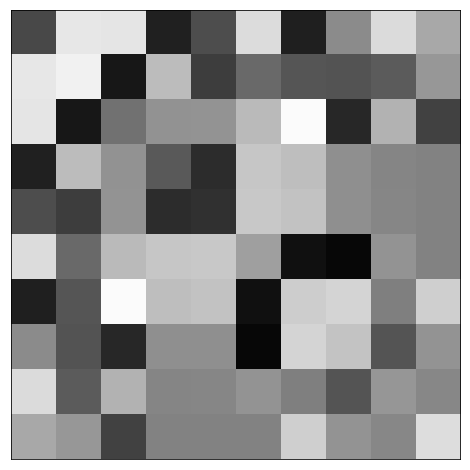

(10, 10, 3) (3, 10, 10)


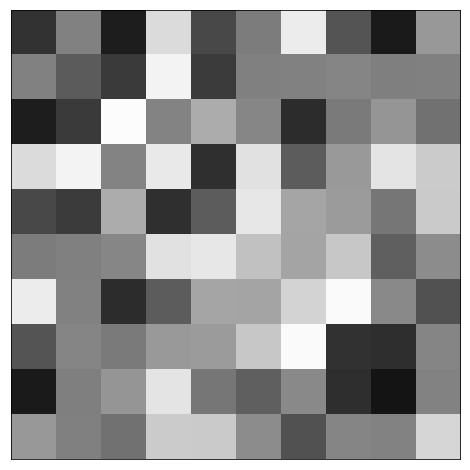

(10, 10, 3) (3, 10, 10)


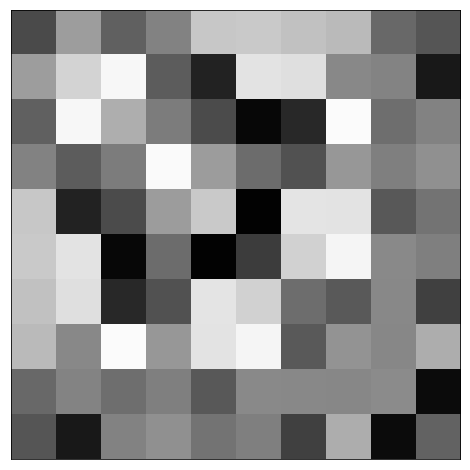

(10, 10, 3) (3, 10, 10)


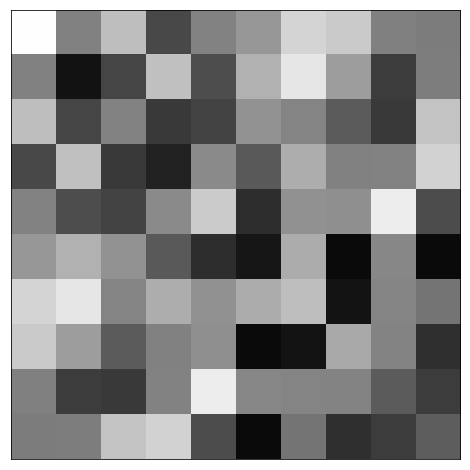

(10, 10, 3) (3, 10, 10)


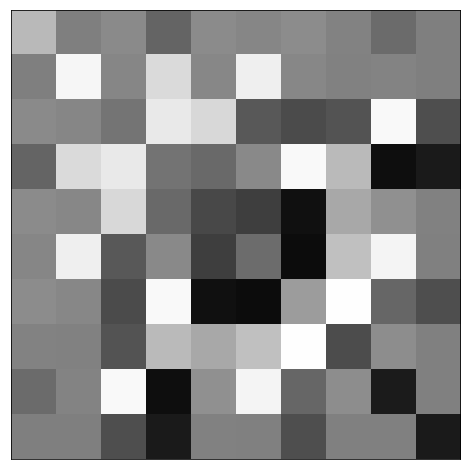

(10, 10, 3) (3, 10, 10)


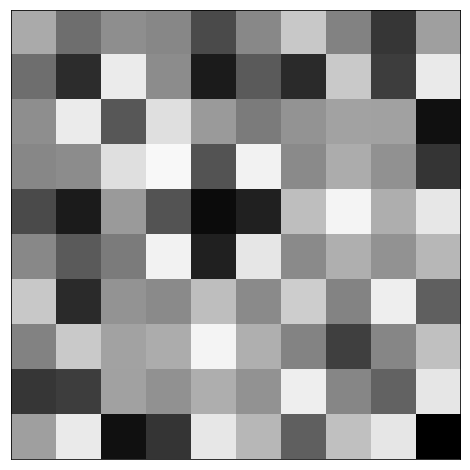

(10, 10, 3) (3, 10, 10)


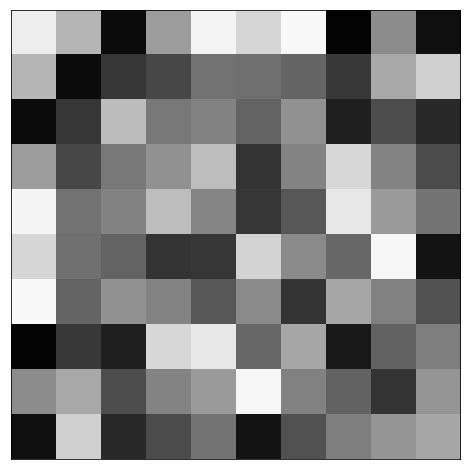

(10, 10, 3) (3, 10, 10)


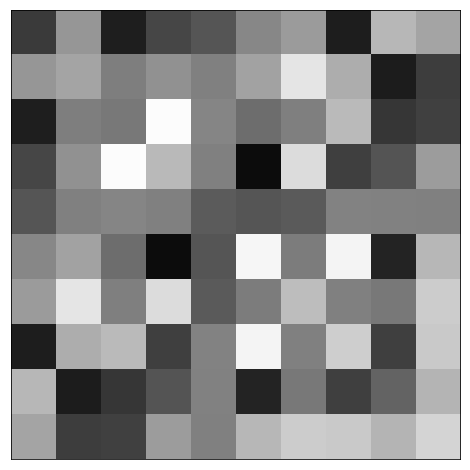

(10, 10, 3) (3, 10, 10)


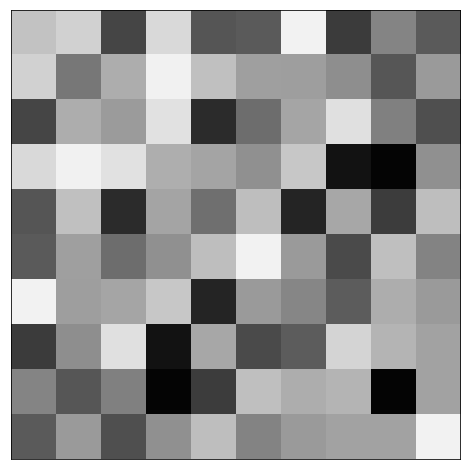

(10, 10, 3) (3, 10, 10)


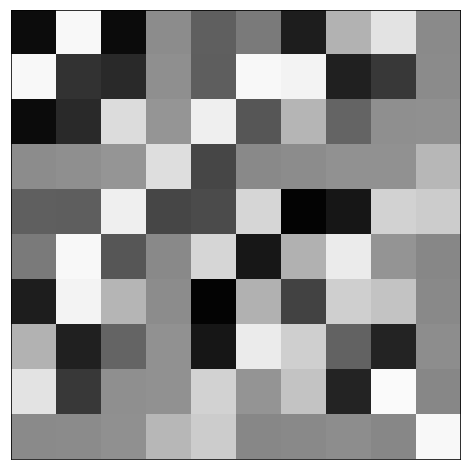

(10, 10, 3) (3, 10, 10)


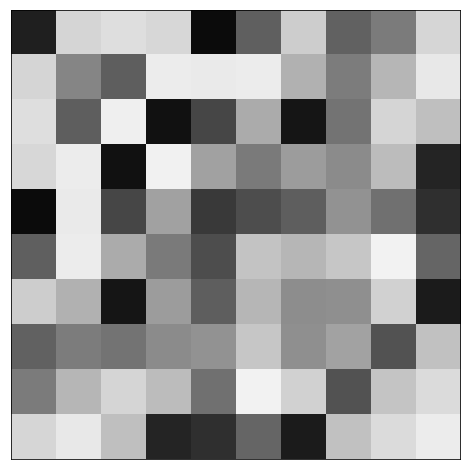

(10, 10, 3) (3, 10, 10)


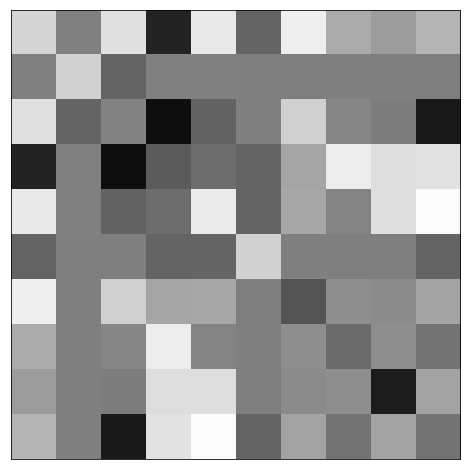

(10, 10, 3) (3, 10, 10)


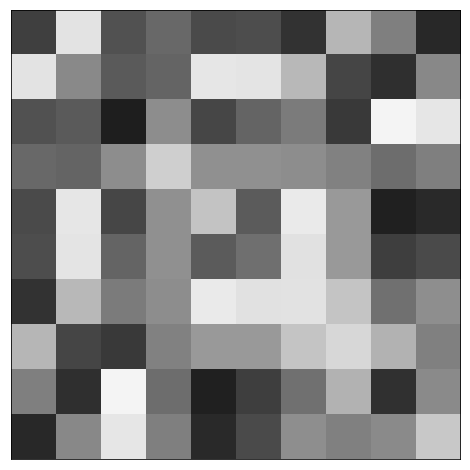

(10, 10, 3) (3, 10, 10)


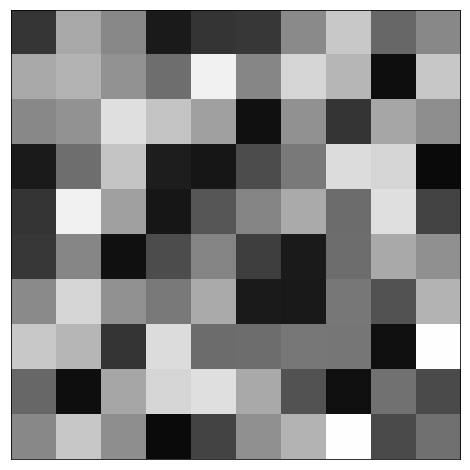

[[7.097864438709227, -1.0416776808650763, 0.05615237002392572, -3.435193405511793, -0.9593208714966521, 0.1254069597201003, 0.11979172271770847, -2.1527216974363226, 0.9733077470813793, -0.8508713687937245], [-1.0416776808650763, 6.191902286986556, -3.5180437597577034, 1.7681850526986762, 2.010254846856545, 0.3350424744760897, 0.32004057263387864, -1.7438057981841442, 2.6003296526502586, 0.34004310842349644], [0.05615237002392572, -3.5180437597577034, 7.837772019575072, 0.27112375675731365, -3.4996056681080563, 0.028076185011962823, 0.02681904239948704, -0.12427087528512284, 0.21790471949583173, 0.028495232549455008], [-3.435193405511793, 1.7681850526986762, 0.27112375675731365, 10.49344853976052, 3.38852082200268, 0.6055097234246648, 0.33385982920361434, -2.7860748016854564, -1.6584970317182748, -3.2980531147419097], [-0.9593208714966521, 2.010254846856545, -3.4996056681080563, 3.38852082200268, 10.082525868412132, 0.13168336061497948, -7.465825425297187, -0.8338021657665518, 2.919923

In [93]:
import torchvision

simple_image_show(torch.randn(1,1,10,10))
simple_image_show(gen_wishart_matrices(10,batchSize = 1))
for K in test_Ks[:100]:
    img = simple_image_show(torch.FloatTensor(K).view(1,1,10,10))

print list([list(t) for t in test_Ks[0]])

print np.matrix(test_Ks[0])
# noise = torch.randn(1,1,10,10)
# noise.data = noise.data.mul(0.5).add(0.5)
# grid_img = make_grid(noise)
# print grid_img.shape
# plt.imshow(grid_img.permute(1,2,0))
# plt.show()

# wishart = gen_wishart_matrices(10,batchSize = 1)
# noise.data = noise.data.mul(0.5).add(0.5)
# grid_img = make_grid(noise)
# print grid_img.shape
# plt.imshow(grid_img.permute(1,2,0))
# plt.show()


In [71]:
img

array([[[0.03137255, 0.9843137 , 0.5254902 , 0.7921569 , 0.01960784,
         0.56078434, 0.5568628 , 0.43137255, 0.9843137 , 0.07450981],
        [0.9843137 , 0.5803922 , 0.7490196 , 0.3764706 , 0.49803922,
         0.6666667 , 0.65882355, 0.63529414, 0.79607844, 0.6666667 ],
        [0.5254902 , 0.7490196 , 0.4       , 0.63529414, 0.7607843 ,
         0.5137255 , 0.50980395, 0.43529412, 0.60784316, 0.5137255 ],
        [0.7921569 , 0.3764706 , 0.63529414, 0.7254902 , 0.18431373,
         0.8       , 0.6666667 , 0.11372549, 0.6784314 , 0.85882354],
        [0.01960784, 0.49803922, 0.7607843 , 0.18431373, 0.52156866,
         0.5647059 , 0.78431374, 0.08235294, 0.9529412 , 0.6901961 ],
        [0.56078434, 0.6666667 , 0.5137255 , 0.8       , 0.5647059 ,
         0.08627451, 0.40392157, 0.6313726 , 0.5254902 , 0.5294118 ],
        [0.5568628 , 0.65882355, 0.50980395, 0.6666667 , 0.78431374,
         0.40392157, 0.32156864, 0.5058824 , 0.8392157 , 0.5294118 ],
        [0.43137255, 0.6352

loading GAN: ./exp_h11_10_nz_5/netG_epoch_100.pth 10 5
	epoch: 100
Wasserstein Distance GAN (no log, log): 3.4783354909282993 0.1532885214696951
Wasserstein Distance Wishart (no log, log): 9.397027870635767 1.219045646882771


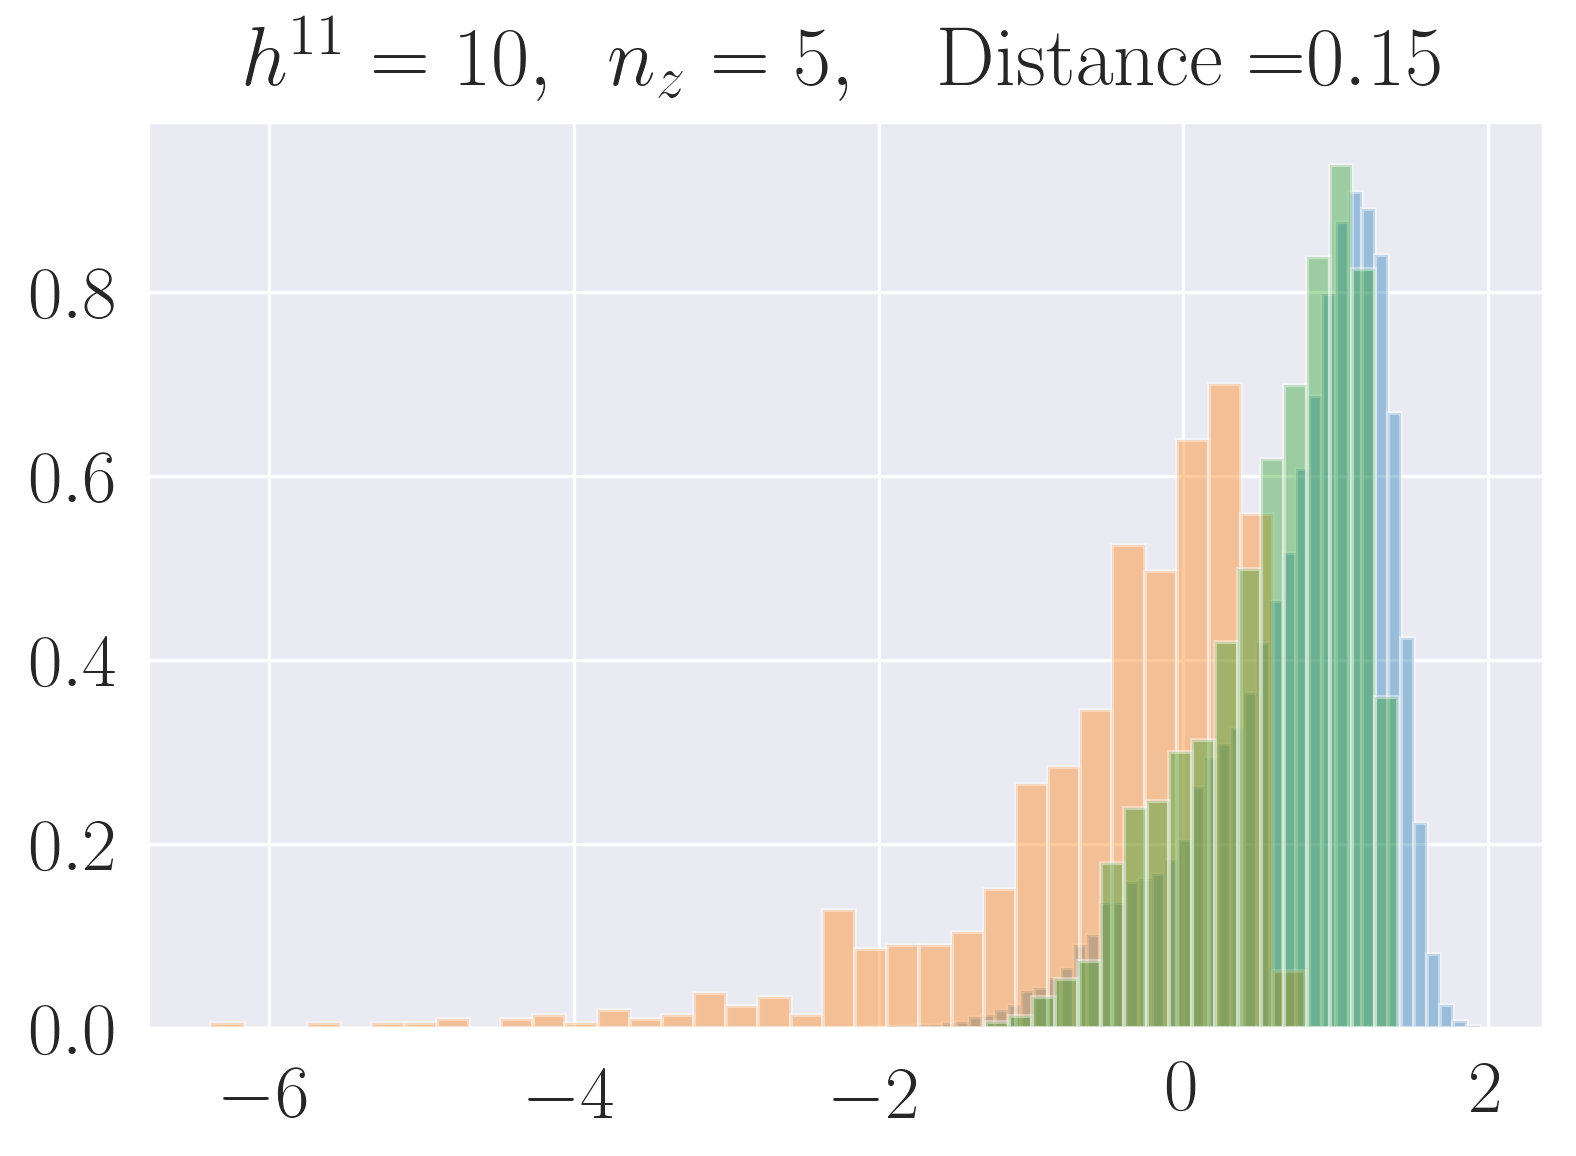

loading GAN: ./exp_h11_10_nz_2/netG_epoch_1000.pth 10 2
	epoch: 1000
Wasserstein Distance GAN (no log, log): 2.4485728705033654 0.1205316252236374
Wasserstein Distance Wishart (no log, log): 9.401330233025595 1.2400056607600225


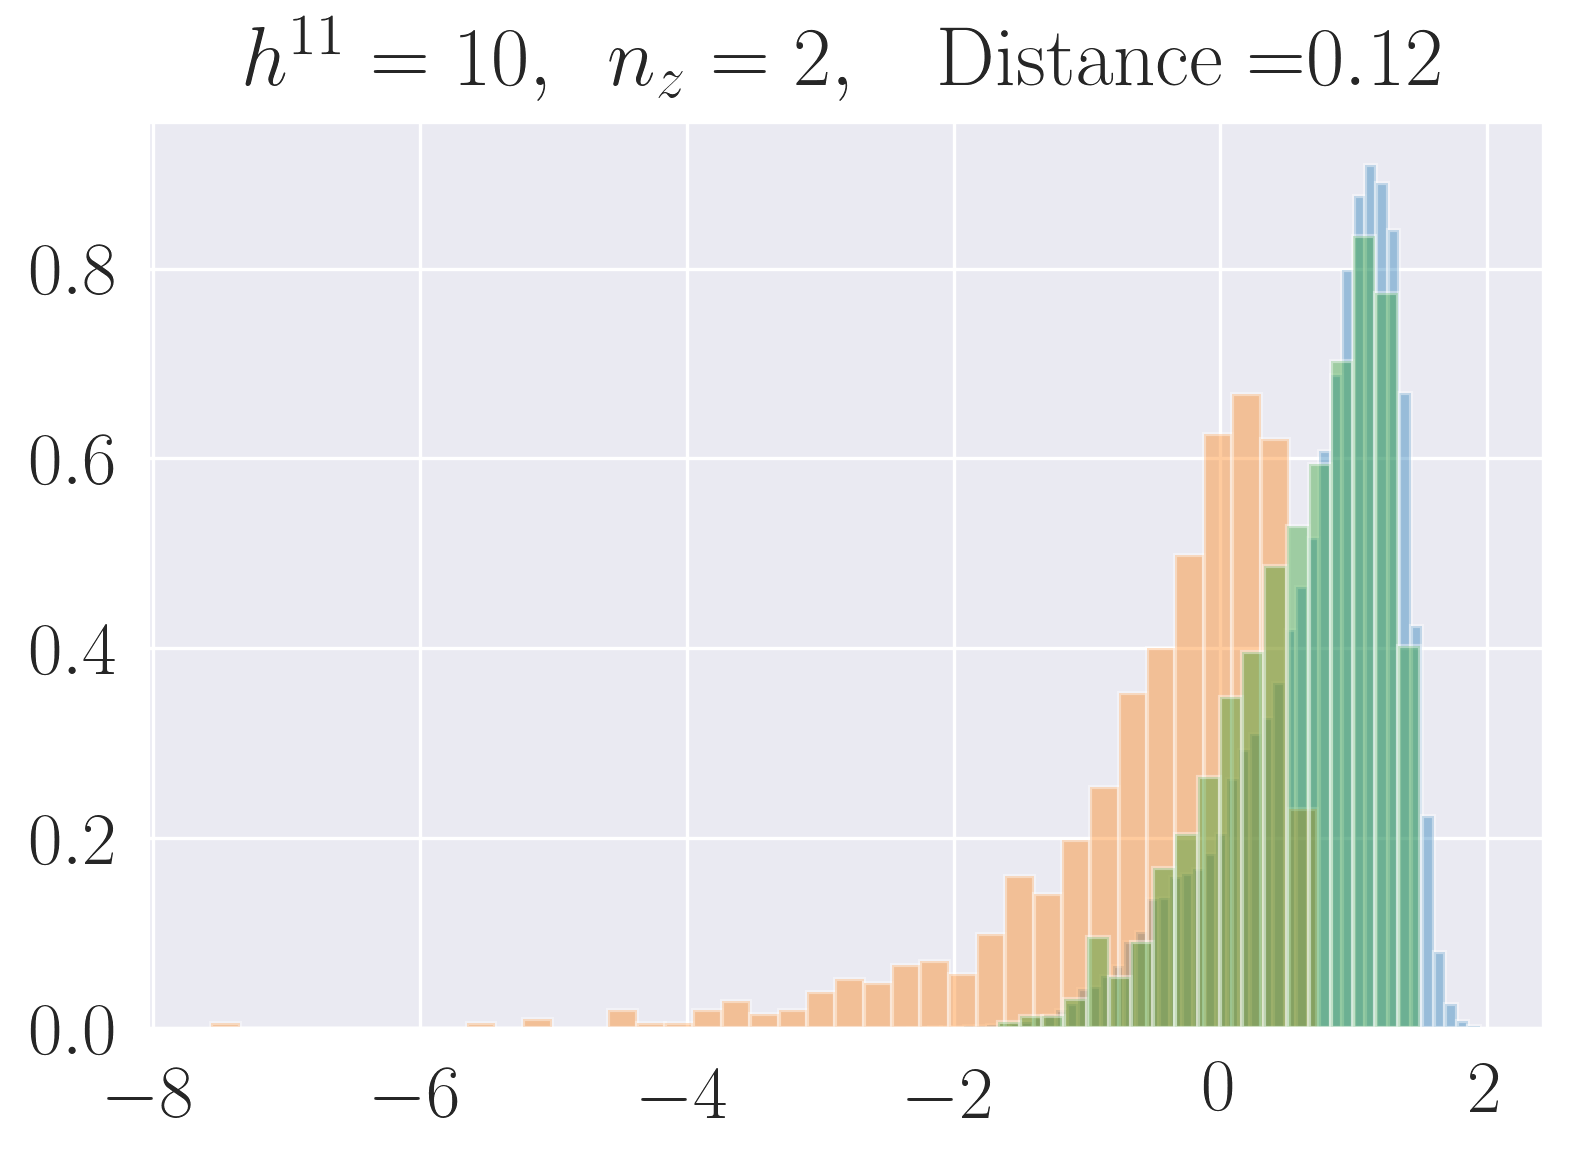

loading GAN: ./exp_h11_30_nz_5/netG_epoch_1000.pth 30 5
loading GAN: ./exp_h11_30_nz_50/netG_epoch_1000.pth 30 50
loading GAN: ./exp_h11_10_nz_3/netG_epoch_1000.pth 10 3
	epoch: 1000
Wasserstein Distance GAN (no log, log): 1.5554448029240937 0.07780364048897184
Wasserstein Distance Wishart (no log, log): 9.382654302394558 1.1858253761110051


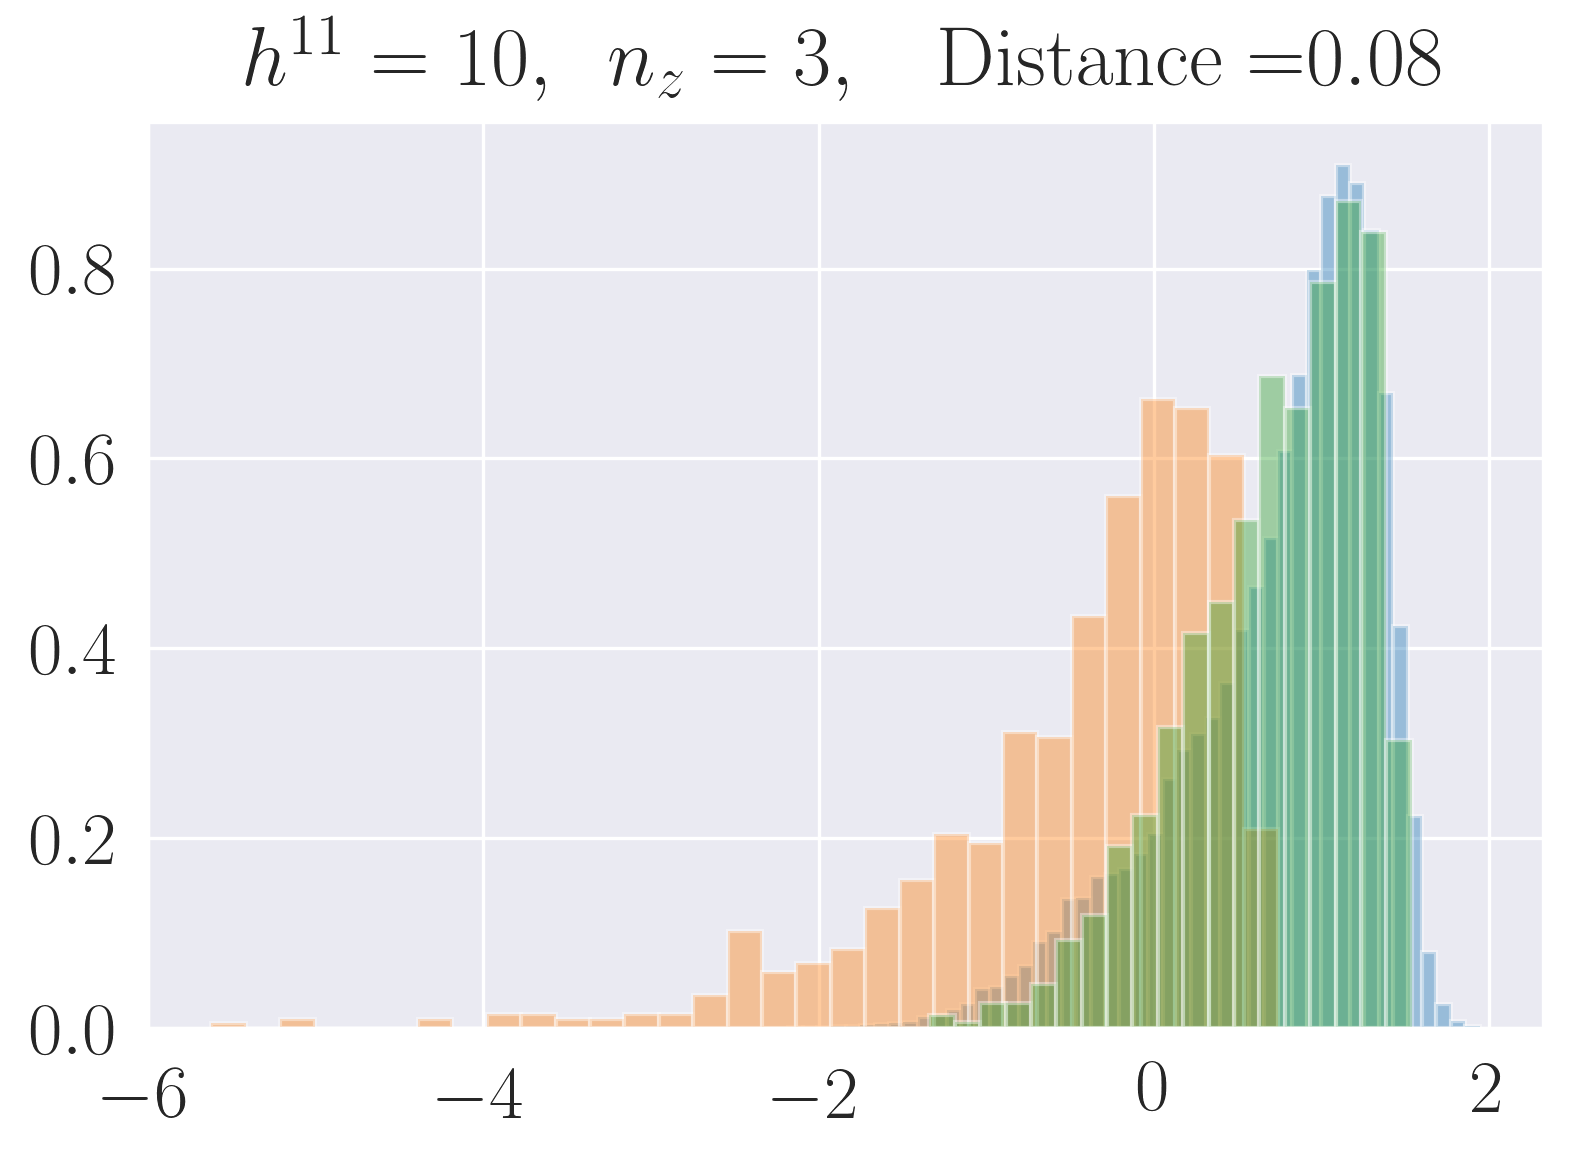

loading GAN: ./exp_h11_10/netG_epoch_10000.pth 10 100
	epoch: 10000
Wasserstein Distance GAN (no log, log): 1.0234402197403432 0.07039323549377334
Wasserstein Distance Wishart (no log, log): 9.406529405920855 1.2317672613972779


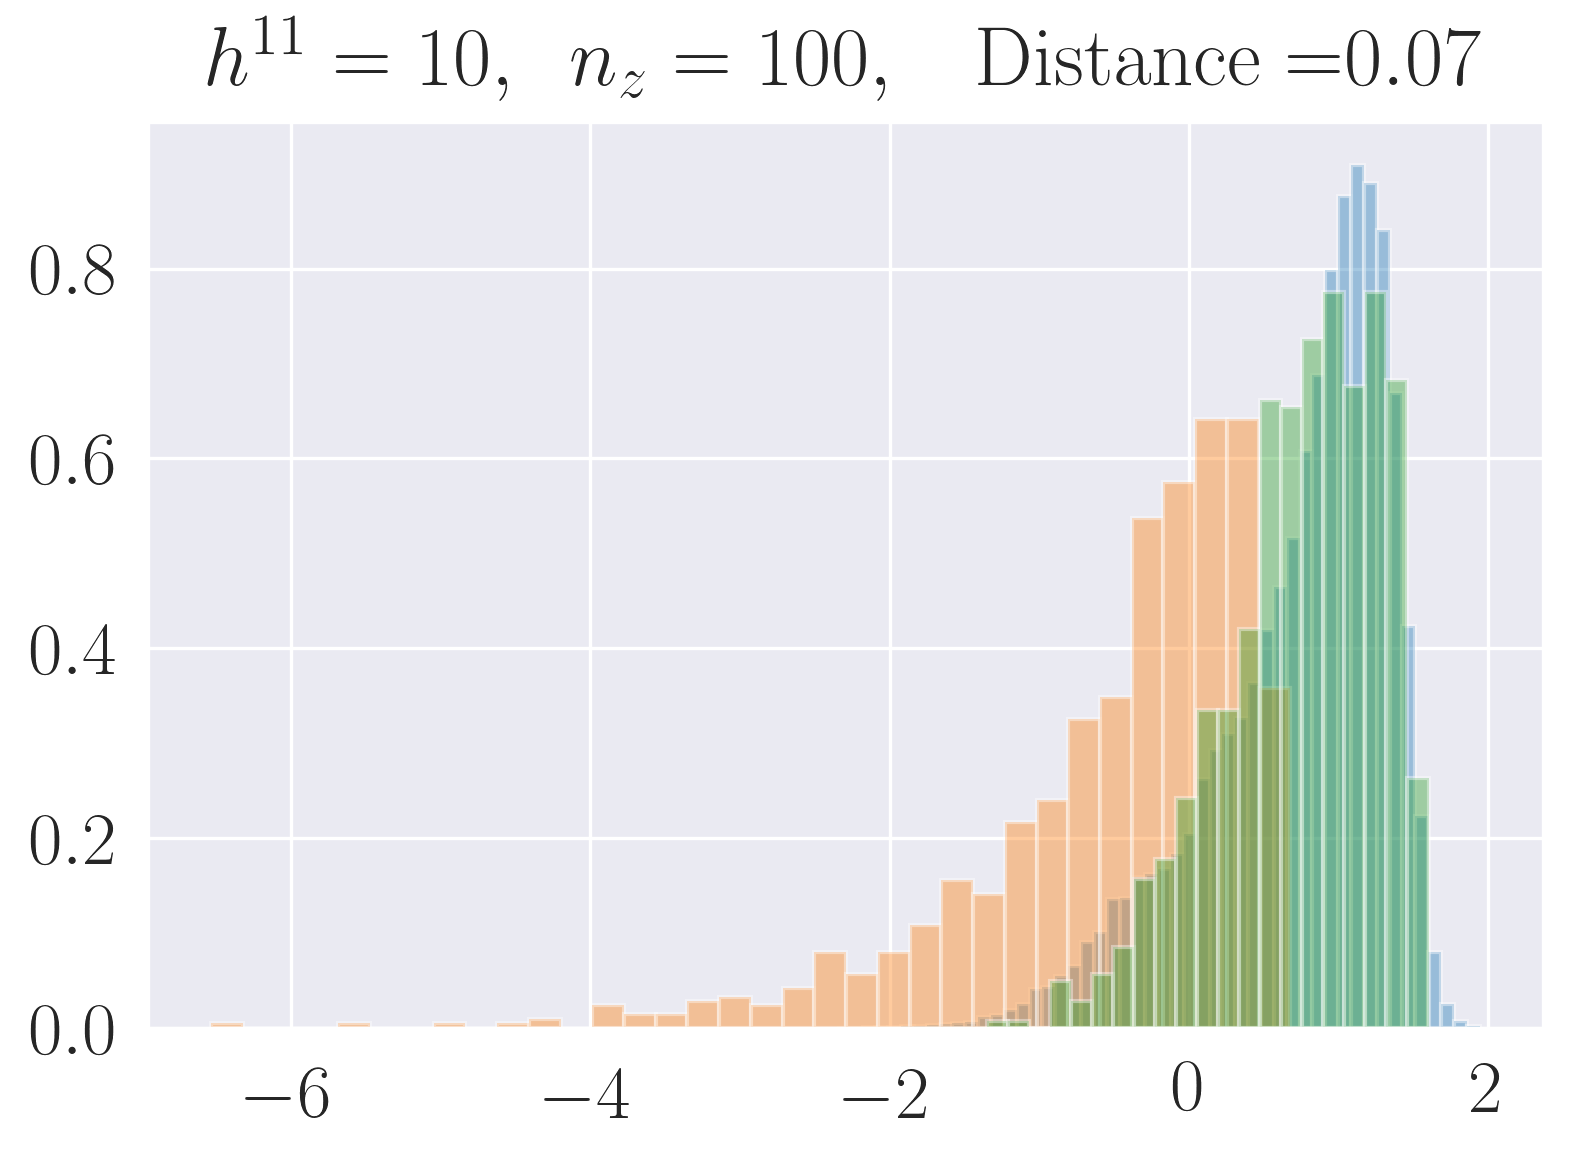

loading GAN: ./exp_h11_10_nz_50/netG_epoch_1000.pth 10 50
	epoch: 1000
Wasserstein Distance GAN (no log, log): 1.9259908383683007 0.10124844705390489
Wasserstein Distance Wishart (no log, log): 9.405336901515552 1.2327853424074953


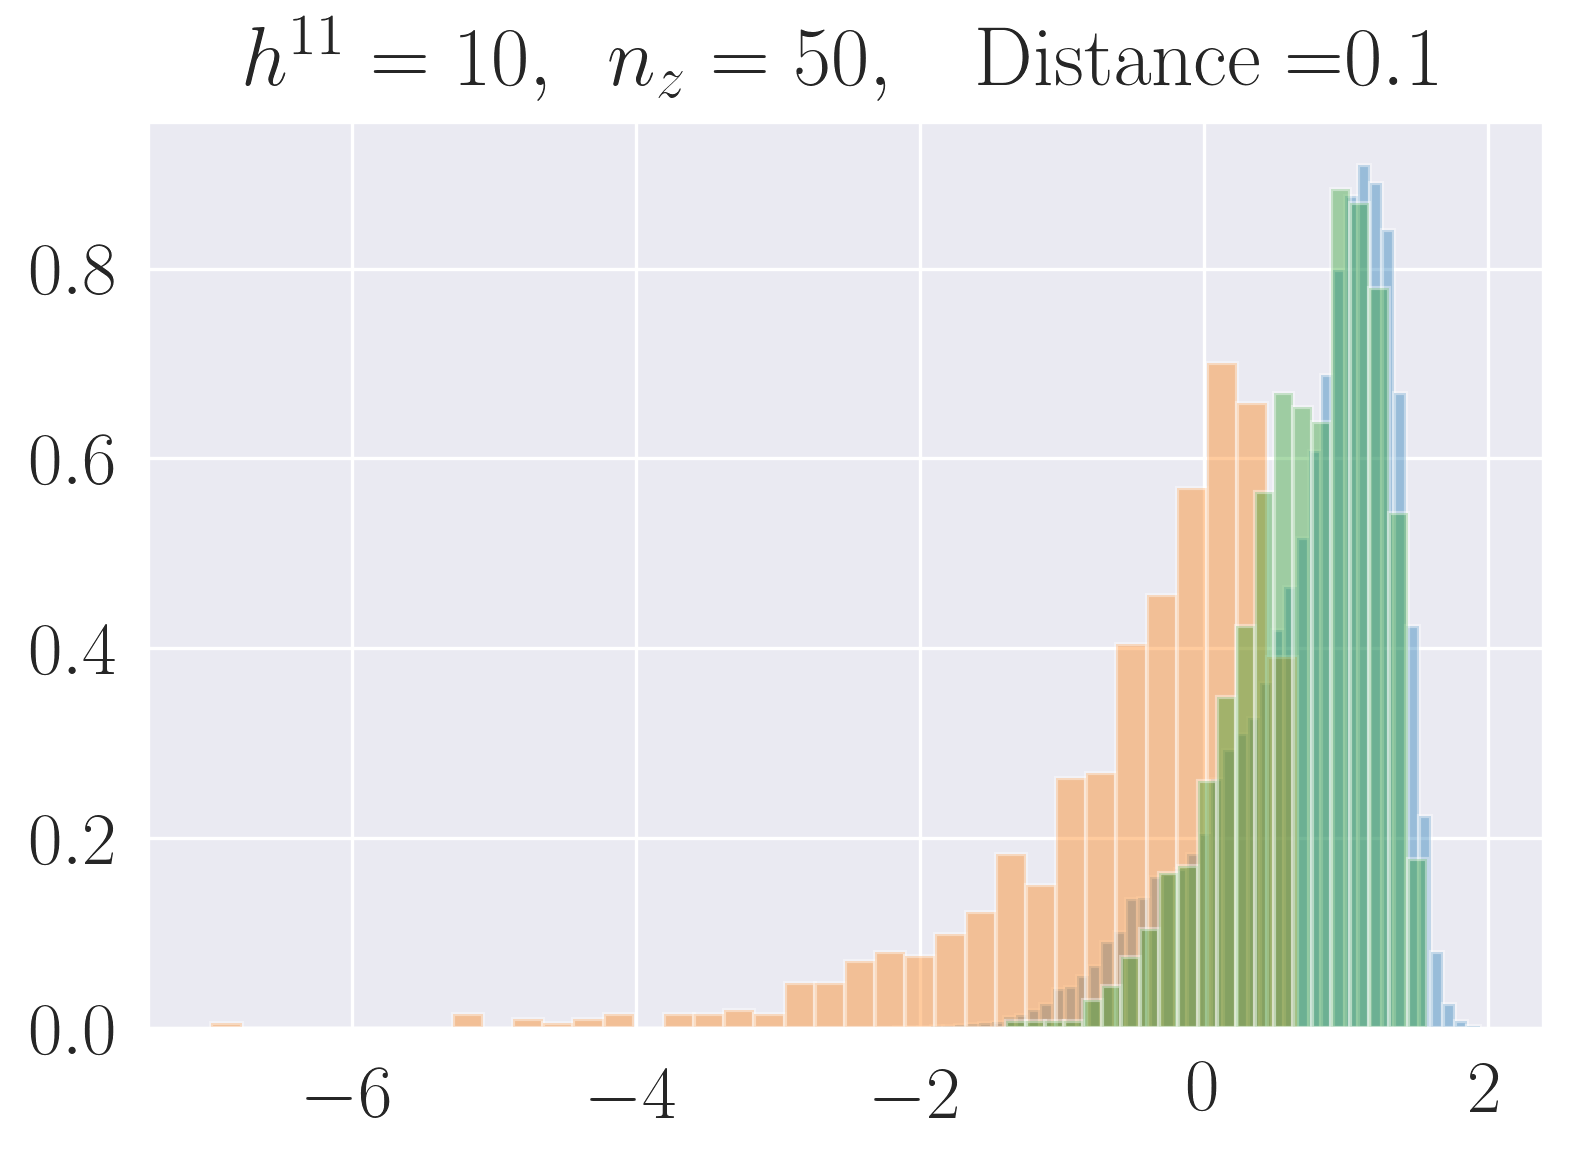

loading GAN: ./exp_h11_20/netG_epoch_10000.pth 10 100
Runtime Error on: ./exp_h11_20/netG_epoch_10000.pth
loading GAN: ./exp_h11_20_nz_5/netG_epoch_1000.pth 20 5
loading GAN: ./exp_h11_10_nz_20/netG_epoch_1000.pth 10 20
	epoch: 1000
Wasserstein Distance GAN (no log, log): 1.4708966733291686 0.0841125543827441
Wasserstein Distance Wishart (no log, log): 9.405558098738195 1.223022001945249


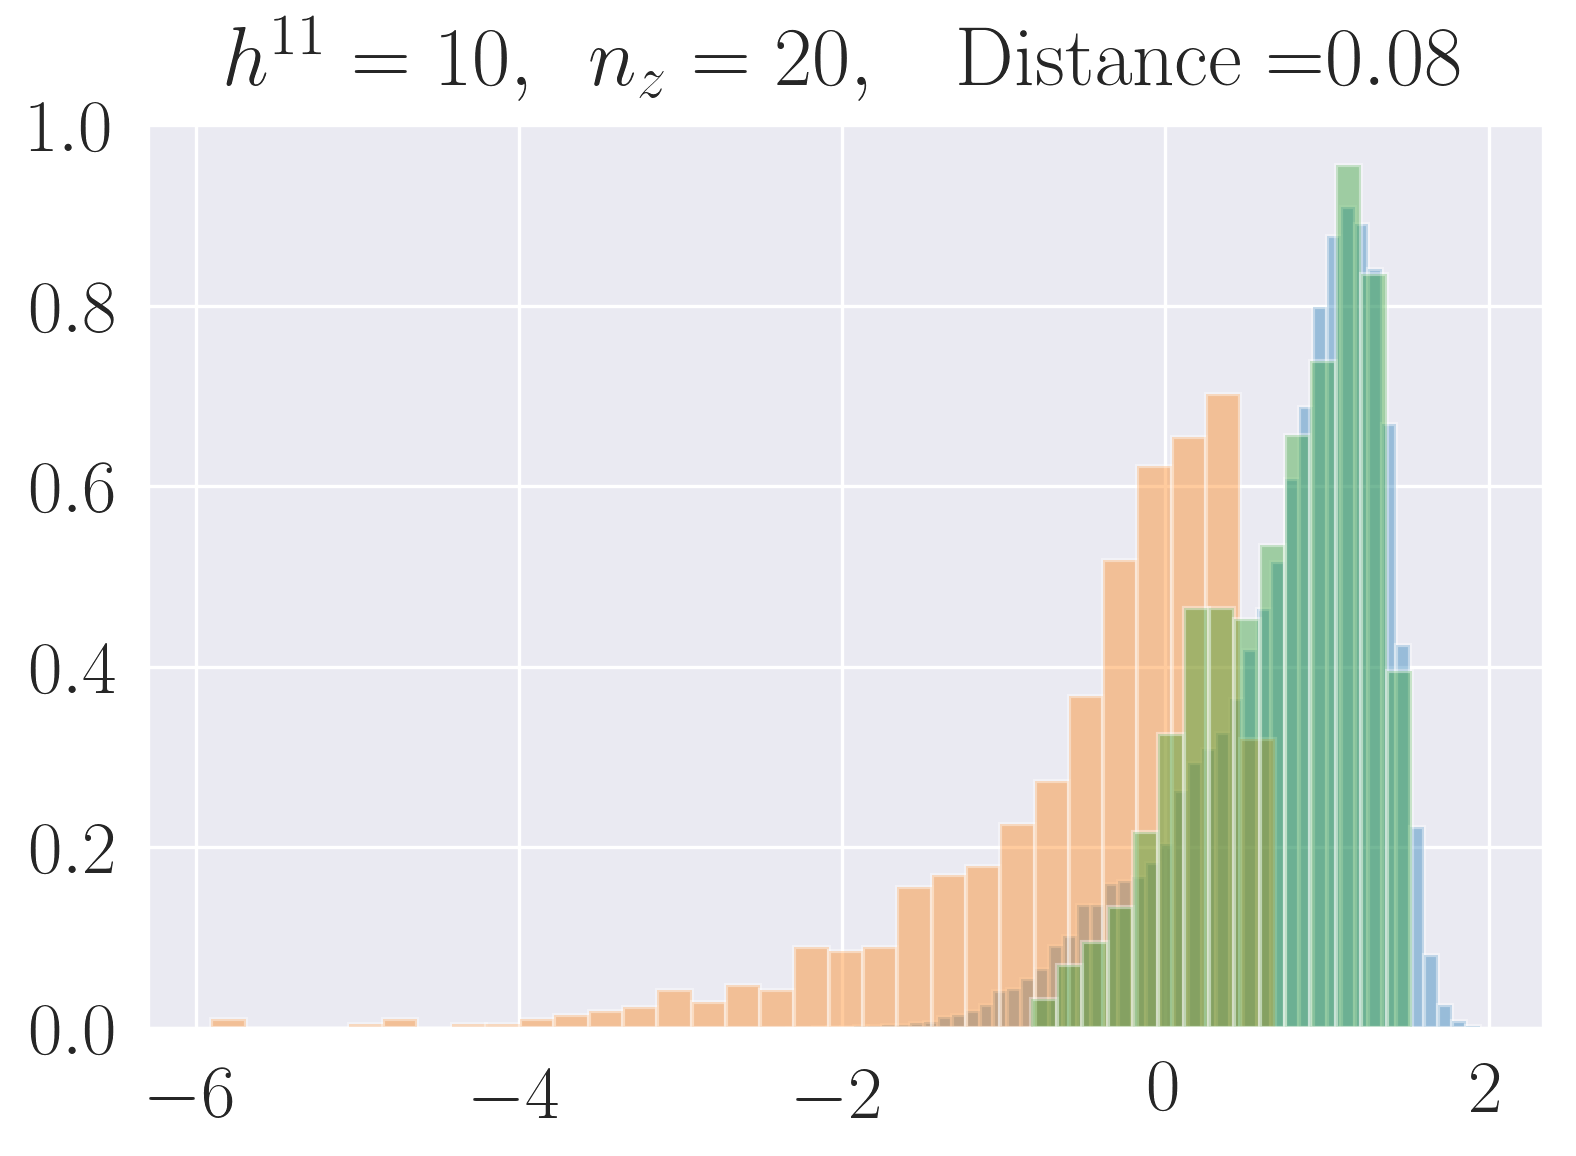

loading GAN: ./exp_h11_10_play/netG_epoch_500.pth 10 100
Runtime Error on: ./exp_h11_10_play/netG_epoch_500.pth
loading GAN: ./exp_h11_10_nz_10/netG_epoch_1000.pth 10 10
	epoch: 1000
Wasserstein Distance GAN (no log, log): 1.4386840577752271 0.07857942342550742
Wasserstein Distance Wishart (no log, log): 9.427645096700452 nan


/Users/jim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in log10
/Users/jim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


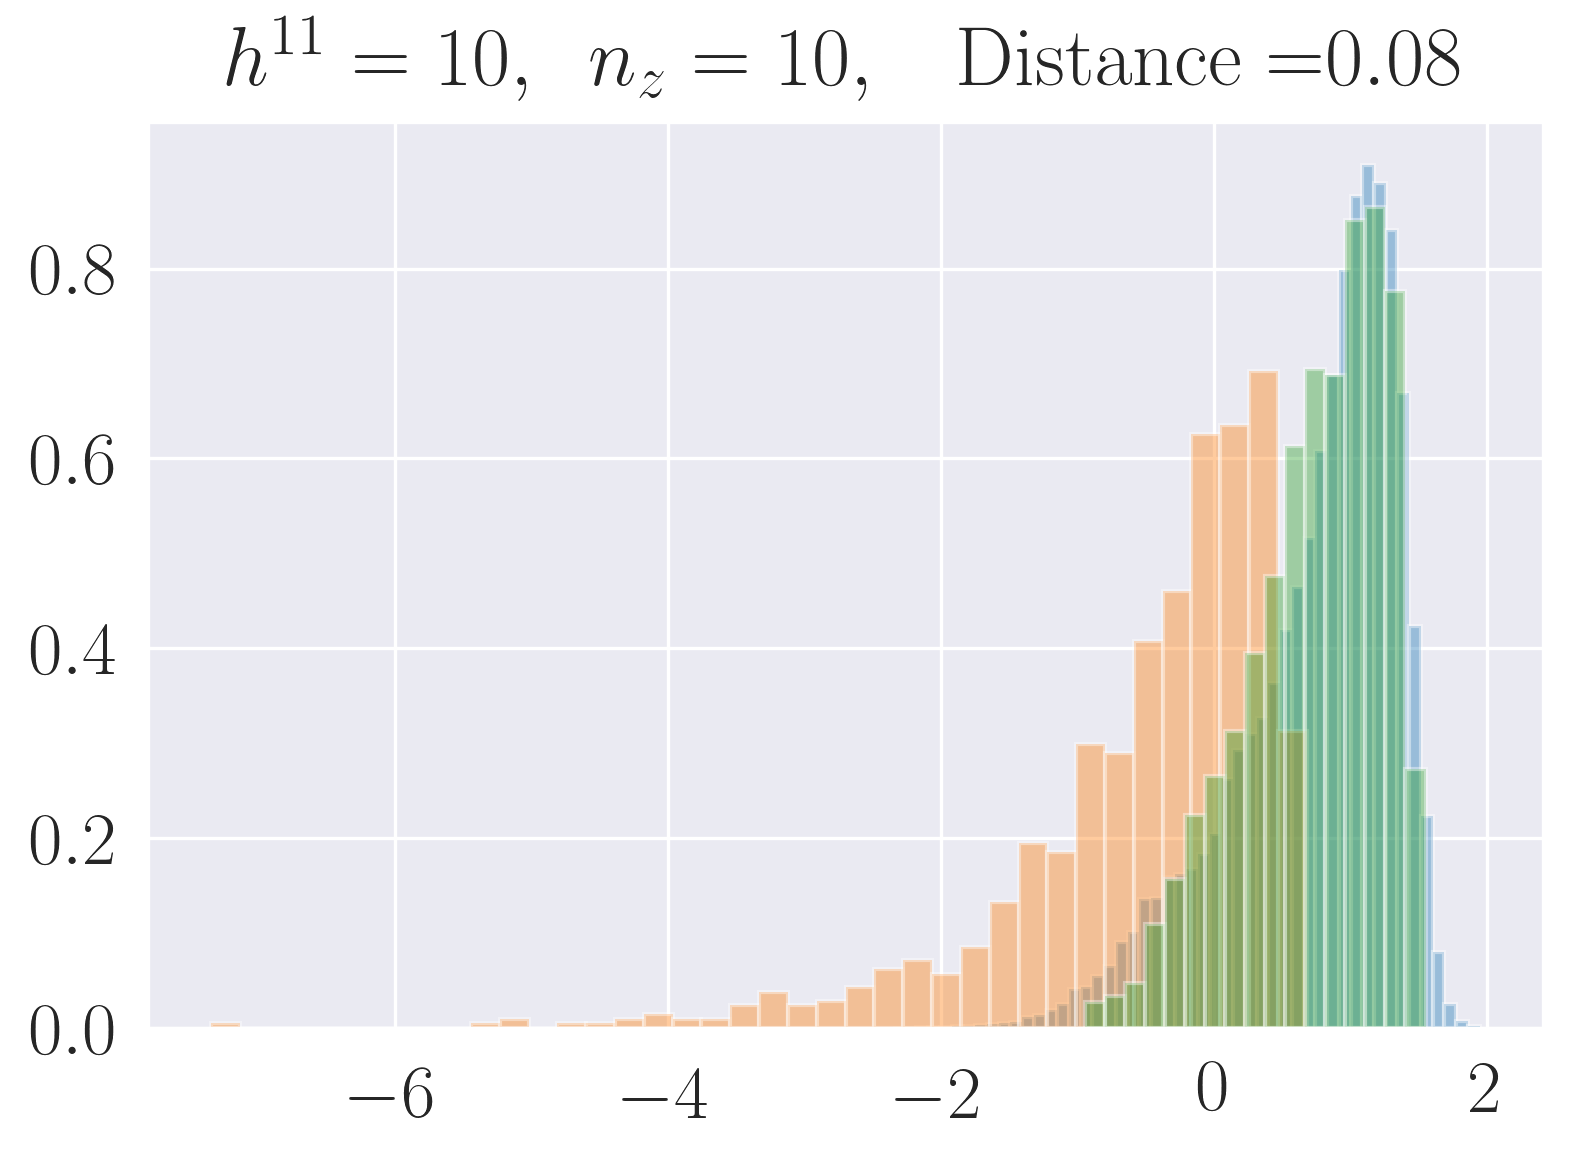

loading GAN: ./exp_h11_30_nz_20/netG_epoch_1000.pth 30 20
loading GAN: ./exp_h11_10_nz_1/netG_epoch_1000.pth 10 1
	epoch: 1000
Wasserstein Distance GAN (no log, log): 5.626276731856059 0.44346150033986004
Wasserstein Distance Wishart (no log, log): 9.434826395760412 1.2237088855993765


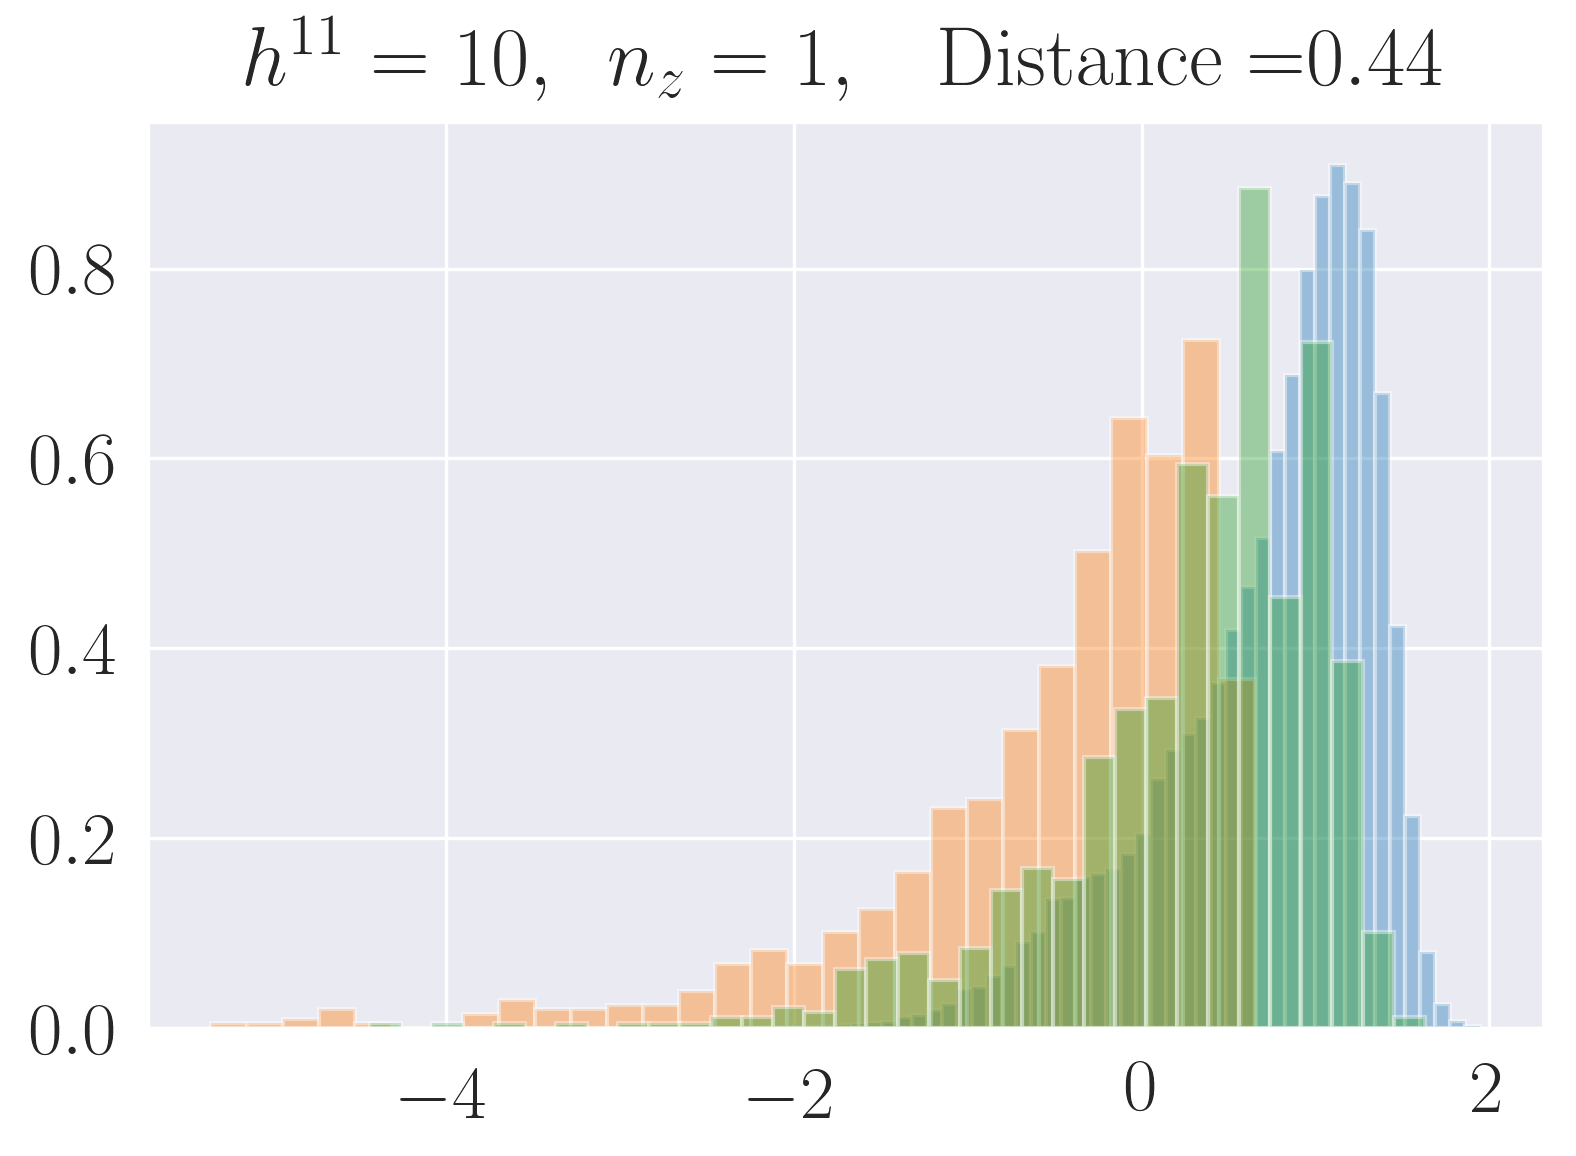

loading GAN: ./exp_h11_20_nz_50/netG_epoch_1000.pth 20 50
loading GAN: ./exp_h11_10_nz_100/netG_epoch_1000.pth 10 100
	epoch: 1000
Wasserstein Distance GAN (no log, log): 2.3435213411074836 0.09949776458557893
Wasserstein Distance Wishart (no log, log): 9.401433769703443 1.2253277768369977


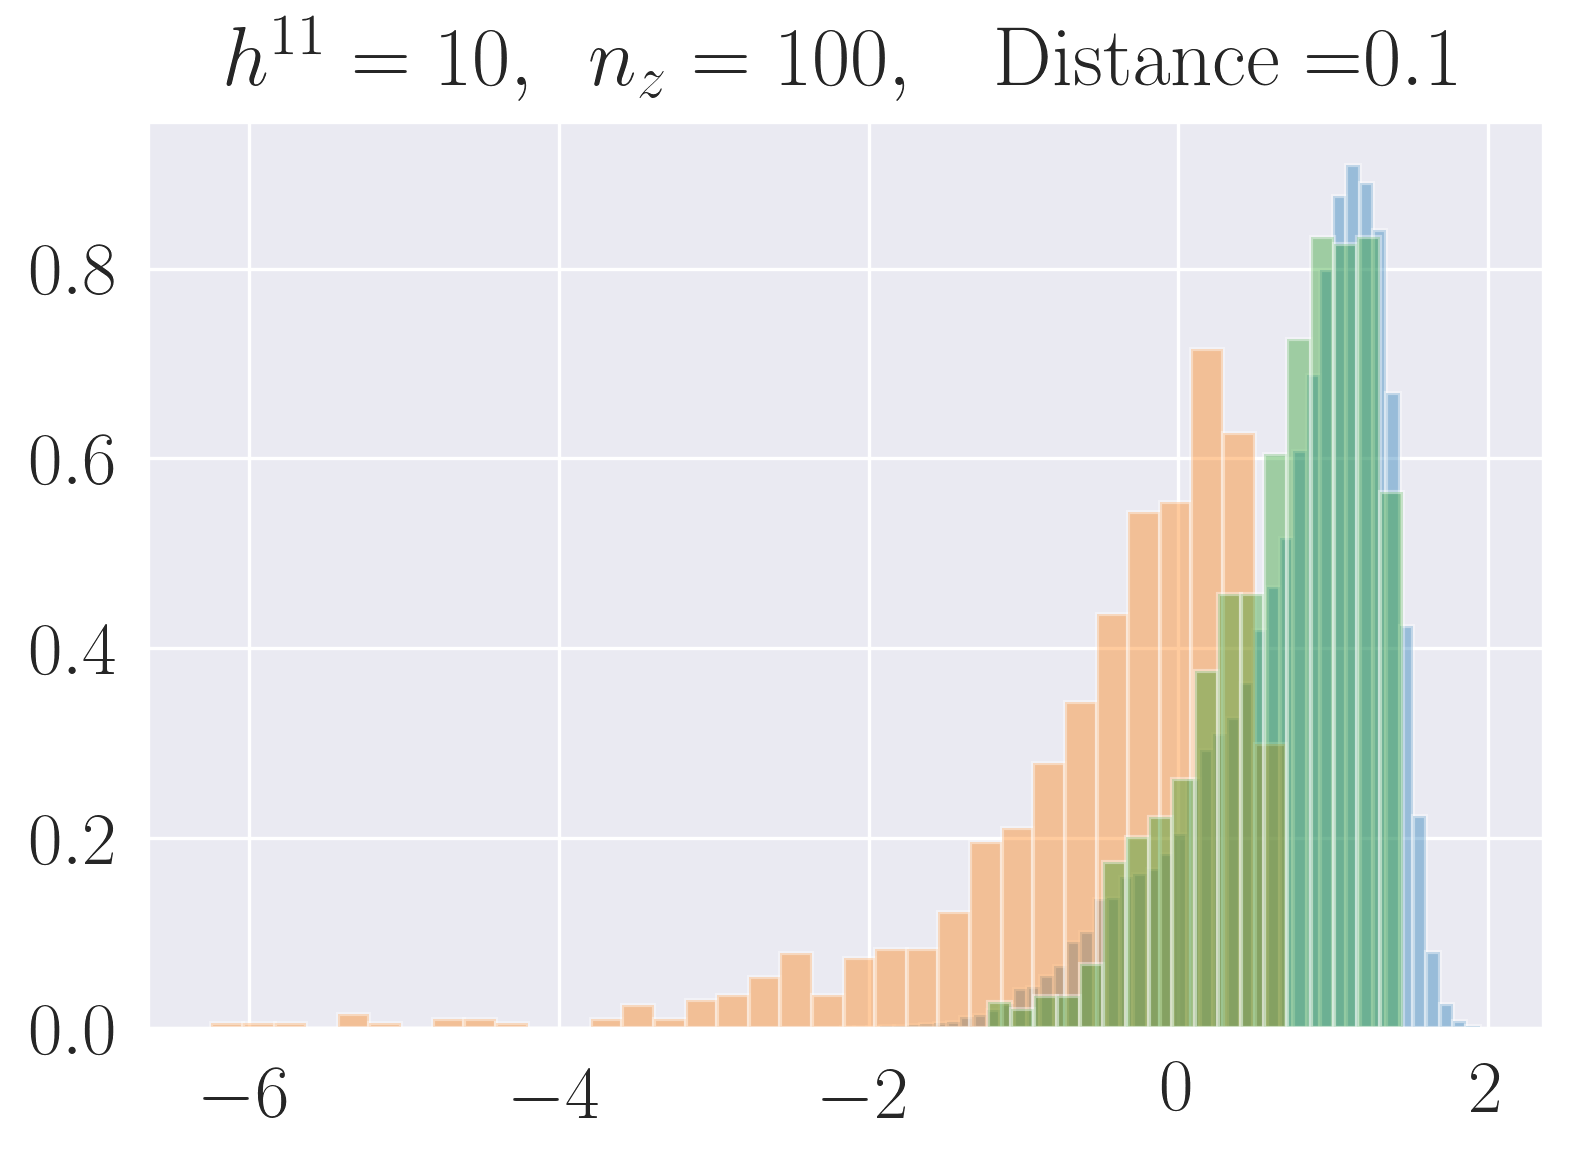

loading GAN: ./exp_h11_10_nz_500/netG_epoch_1000.pth 10 500
	epoch: 1000
Wasserstein Distance GAN (no log, log): 2.620061277530816 0.11333312952543194
Wasserstein Distance Wishart (no log, log): 9.400063160208457 1.226419188873561


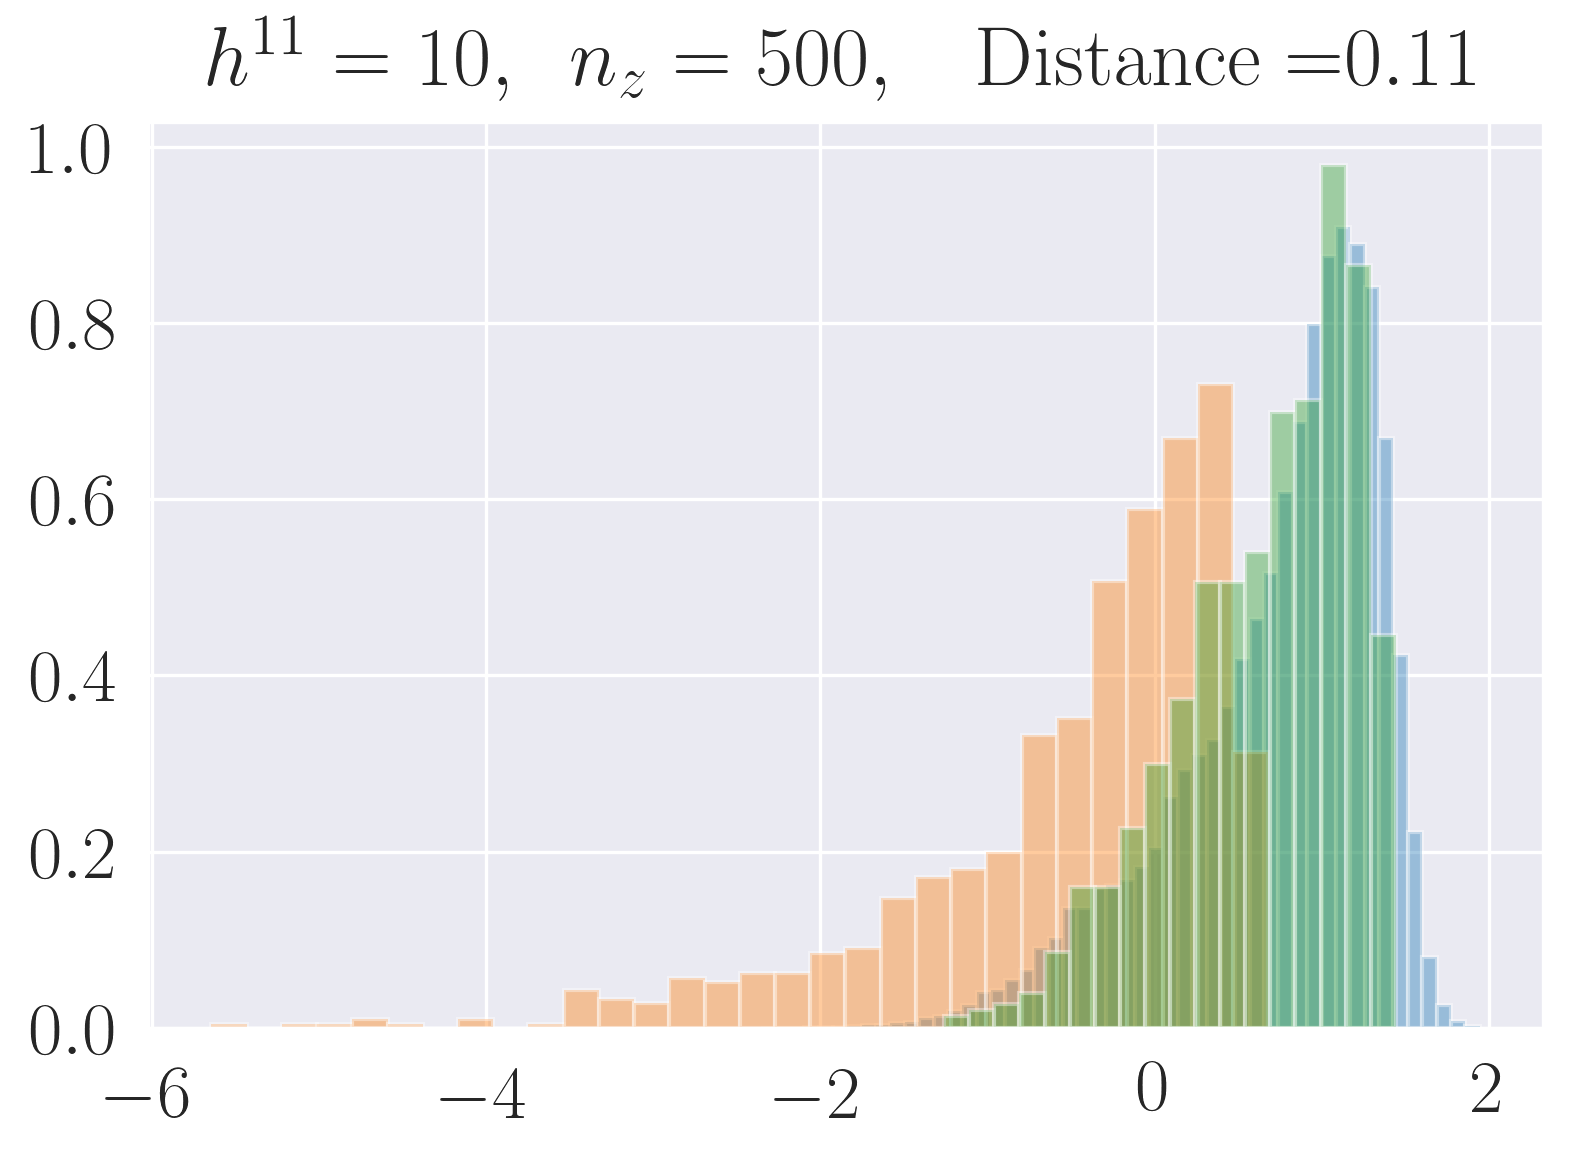

loading GAN: ./exp_h11_30_nz_1000/netG_epoch_80000.pth 30 1000
loading GAN: ./exp_h11_30_nz_1/netG_epoch_1000.pth 30 1
loading GAN: ./exp_h11_30/netG_epoch_10000.pth 30 100
loading GAN: ./exp_h11_10_nz_200/netG_epoch_10000.pth 10 200
Runtime Error on: ./exp_h11_10_nz_200/netG_epoch_10000.pth
loading GAN: ./exp_h11_20_nz_500/netG_epoch_1000.pth 20 500
loading GAN: ./exp_h11_20_nz_1/netG_epoch_1000.pth 20 1
loading GAN: ./exp_h11_20_nz_100/netG_epoch_1000.pth 20 100
loading GAN: ./exp_h11_20_nz_20/netG_epoch_1000.pth 20 20
loading GAN: ./exp_h11_30_nz_100/netG_epoch_1000.pth 30 100
loading GAN: ./exp_h11_30_nz_500/netG_epoch_1000.pth 30 500
loading GAN: nz_vary/exp_h11_10_nz_5/netG_epoch_2000.pth 10 5
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.154507570911759 0.0717135886806614
Wasserstein Distance Wishart (no log, log): 9.428298321993925 1.2612293872473044


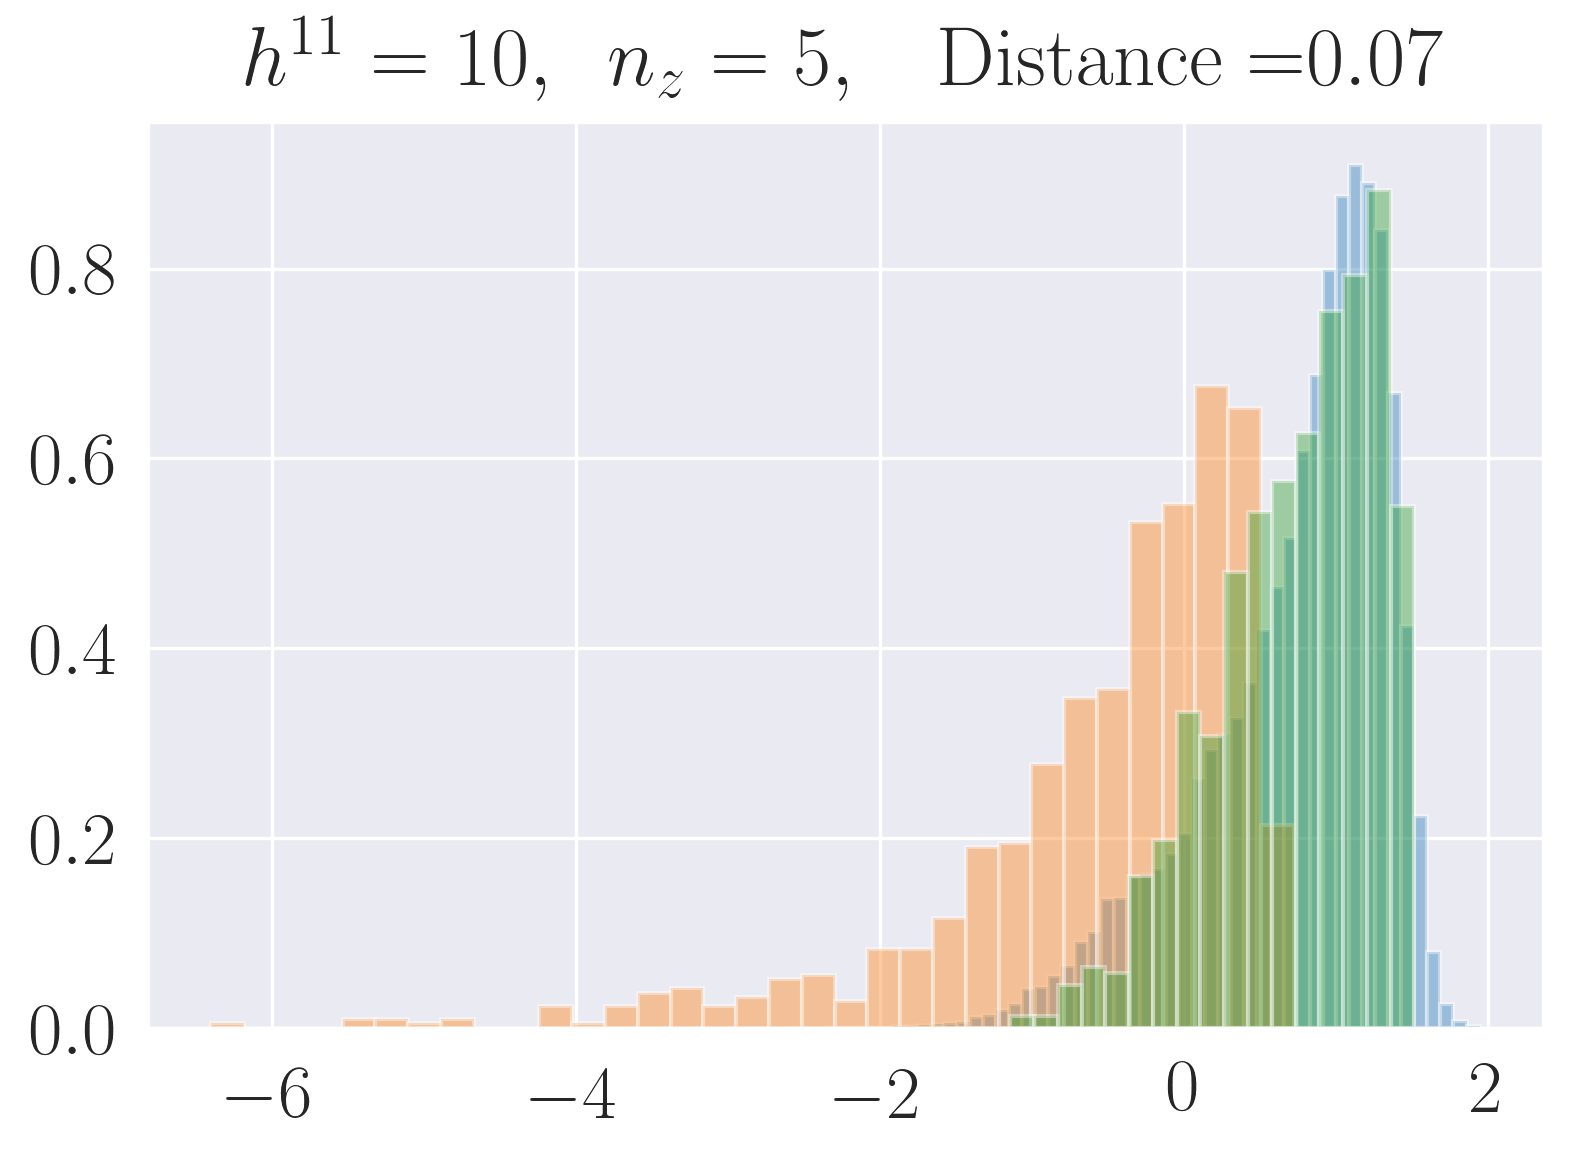

loading GAN: nz_vary/exp_h11_20_nz_65/netG_epoch_2000.pth 20 65
loading GAN: nz_vary/exp_h11_30_nz_60/netG_epoch_2000.pth 30 60
loading GAN: nz_vary/exp_h11_20_nz_30/netG_epoch_2000.pth 20 30
loading GAN: nz_vary/exp_h11_30_nz_5/netG_epoch_2000.pth 30 5
loading GAN: nz_vary/exp_h11_30_nz_35/netG_epoch_2000.pth 30 35
loading GAN: nz_vary/exp_h11_30_nz_95/netG_epoch_2000.pth 30 95
loading GAN: nz_vary/exp_h11_20_nz_55/netG_epoch_2000.pth 20 55
loading GAN: nz_vary/exp_h11_30_nz_50/netG_epoch_2000.pth 30 50
loading GAN: nz_vary/exp_h11_20_nz_90/netG_epoch_2000.pth 20 90
loading GAN: nz_vary/exp_h11_10_nz_35/netG_epoch_2000.pth 10 35
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.0954748308018514 0.08123400676744202
Wasserstein Distance Wishart (no log, log): 9.386735858137884 1.2226366770636037


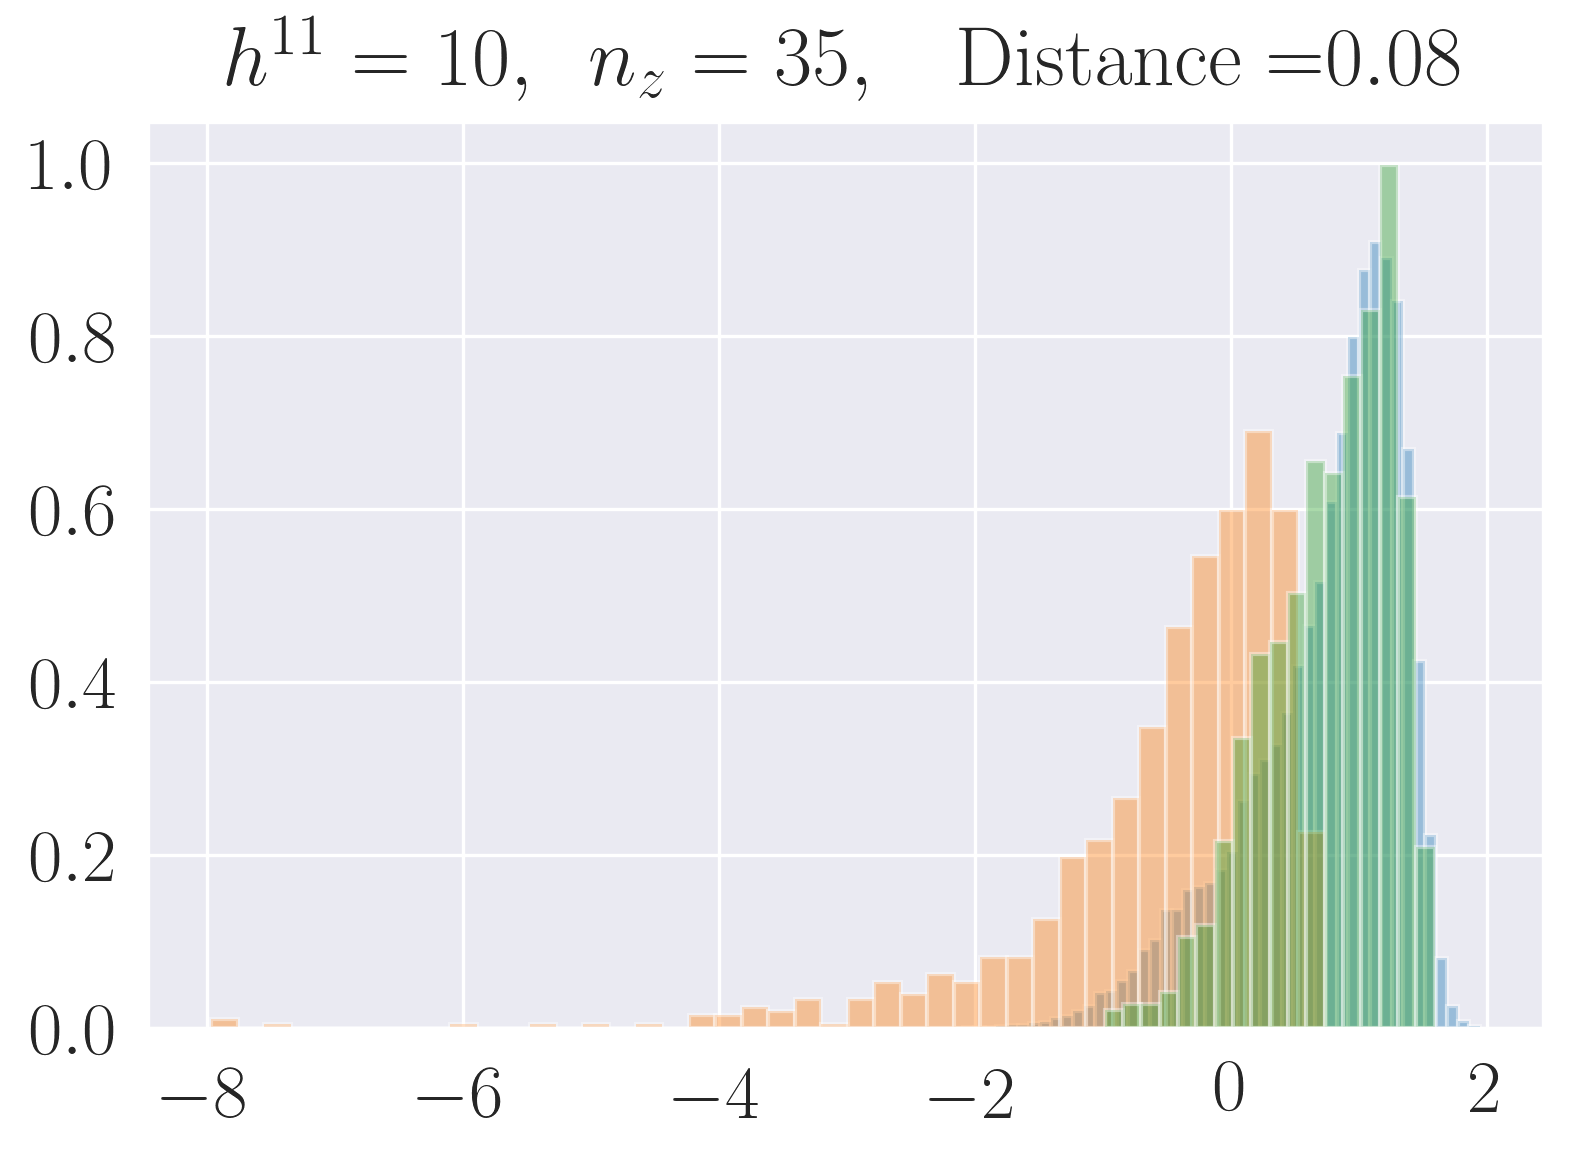

loading GAN: nz_vary/exp_h11_10_nz_50/netG_epoch_2000.pth 10 50
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.3696513120070826 0.08867494682666363
Wasserstein Distance Wishart (no log, log): 9.421053805799003 1.2282263618446183


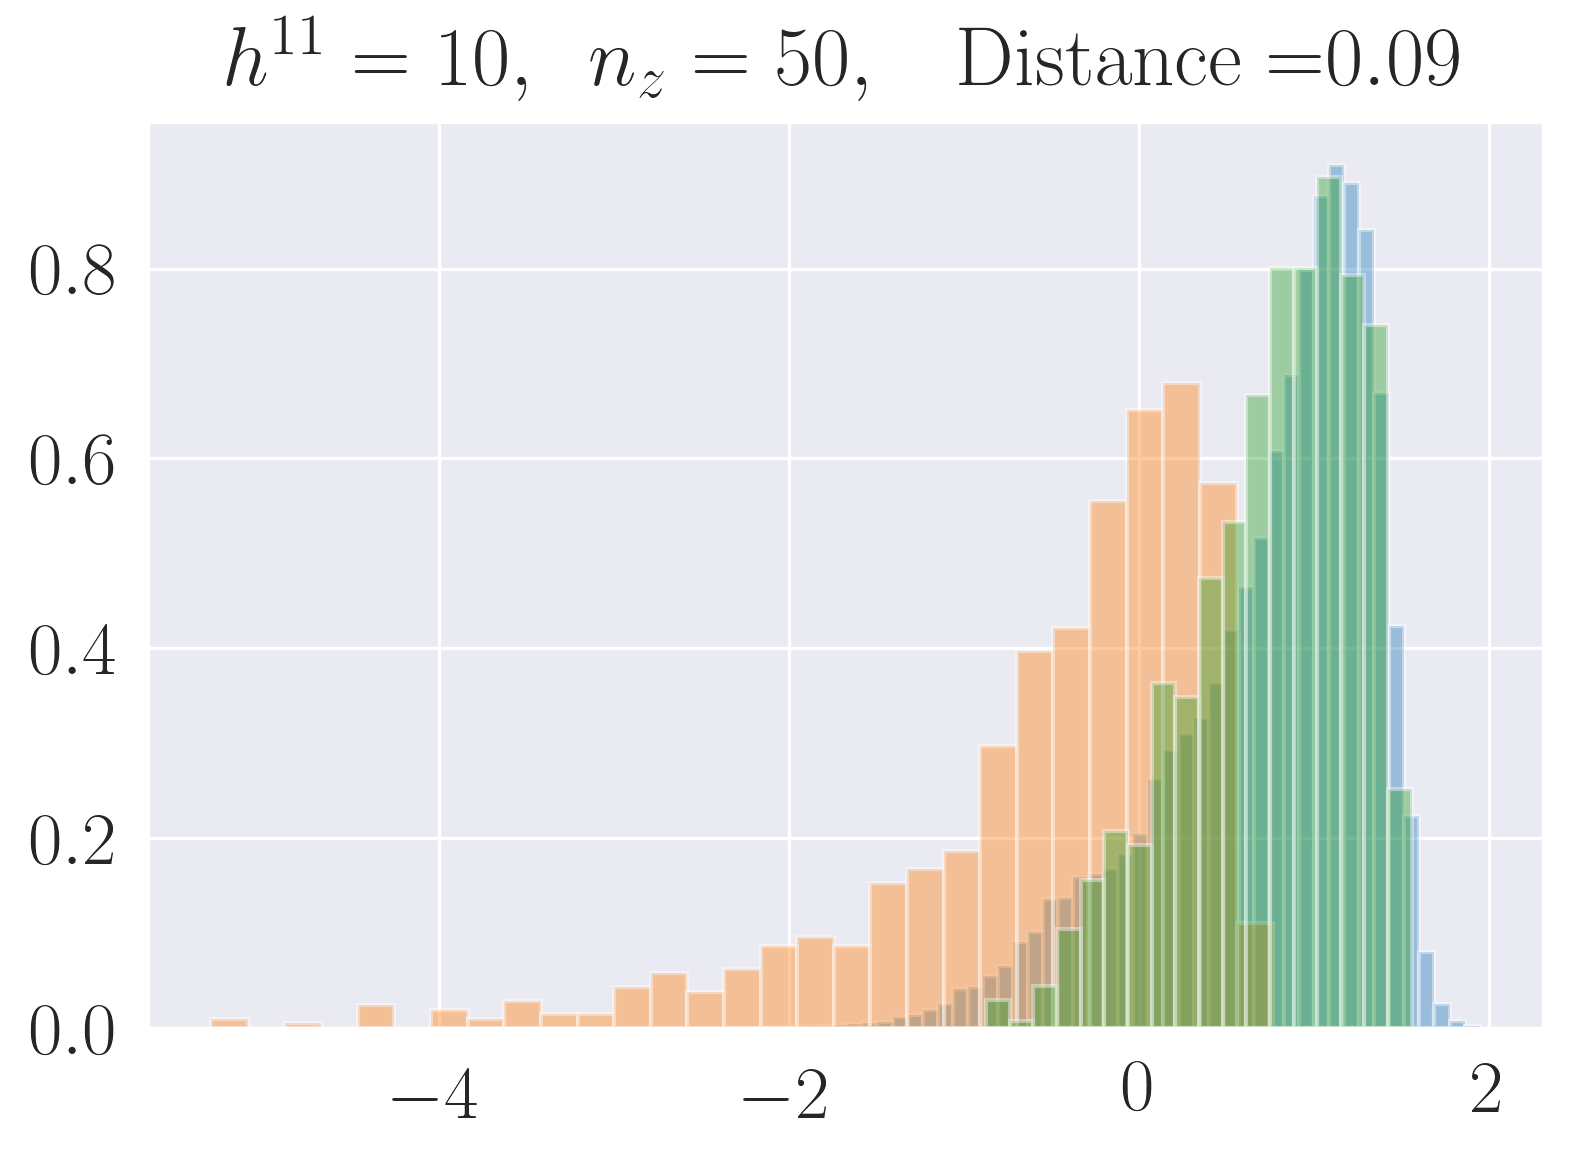

loading GAN: nz_vary/exp_h11_10_nz_95/netG_epoch_2000.pth 10 95
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.4383470867426975 0.08271381881873938
Wasserstein Distance Wishart (no log, log): 9.401165653213681 1.2424779727438096


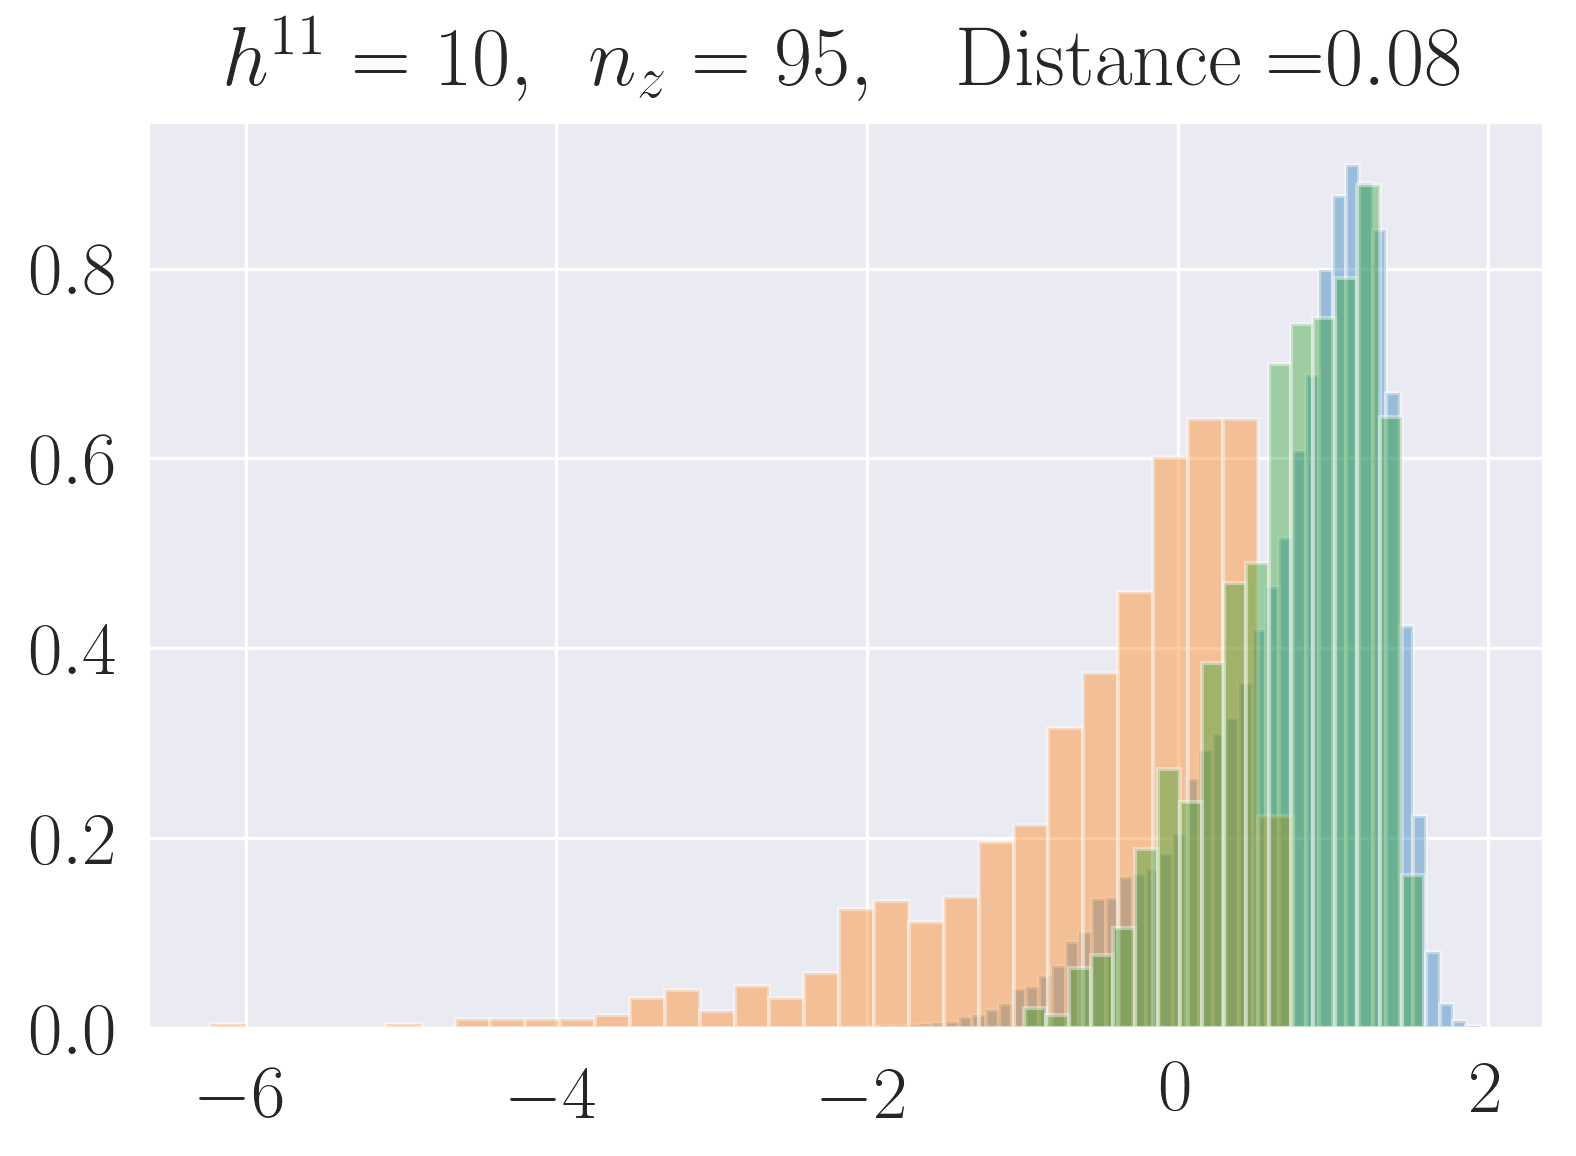

loading GAN: nz_vary/exp_h11_10_nz_60/netG_epoch_2000.pth 10 60
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.2896534044101897 0.08013720127369586
Wasserstein Distance Wishart (no log, log): 9.417092777158572 1.231995336136383


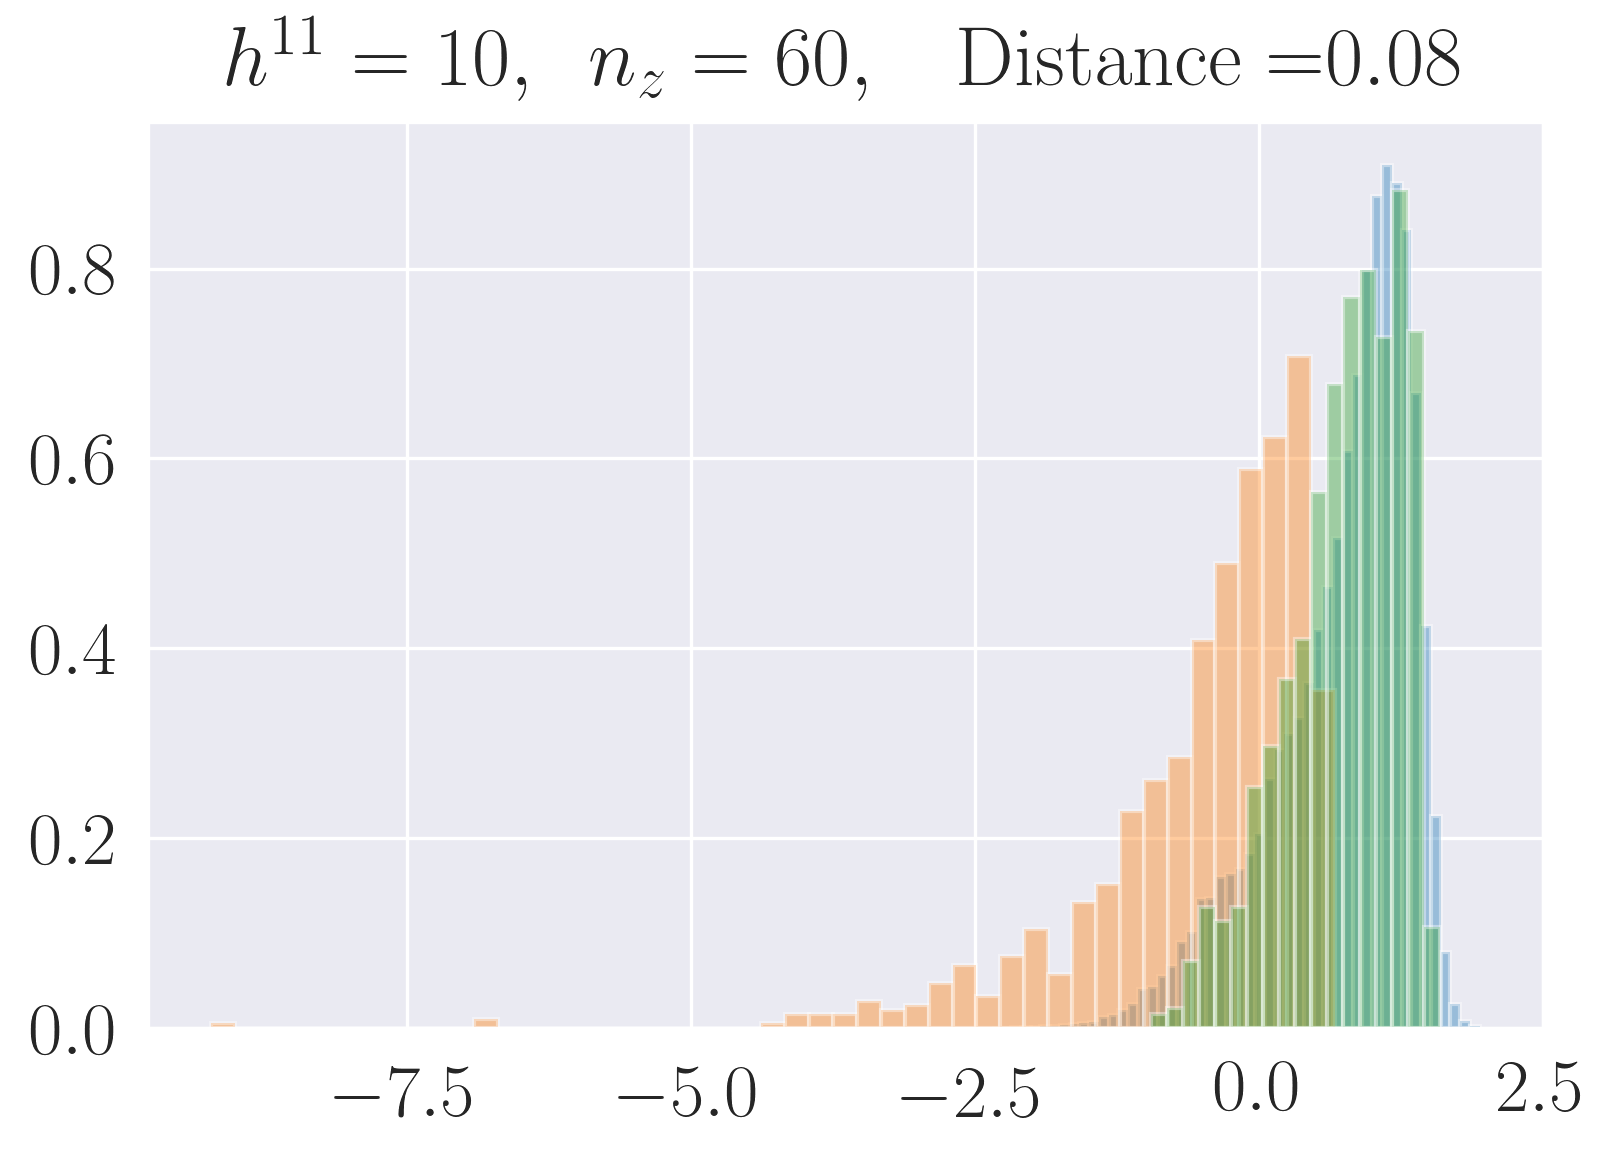

loading GAN: nz_vary/exp_h11_10_nz_80/netG_epoch_2000.pth 10 80
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.4438901377234485 0.08226563356525607
Wasserstein Distance Wishart (no log, log): 9.41432948353587 1.2569191698301099


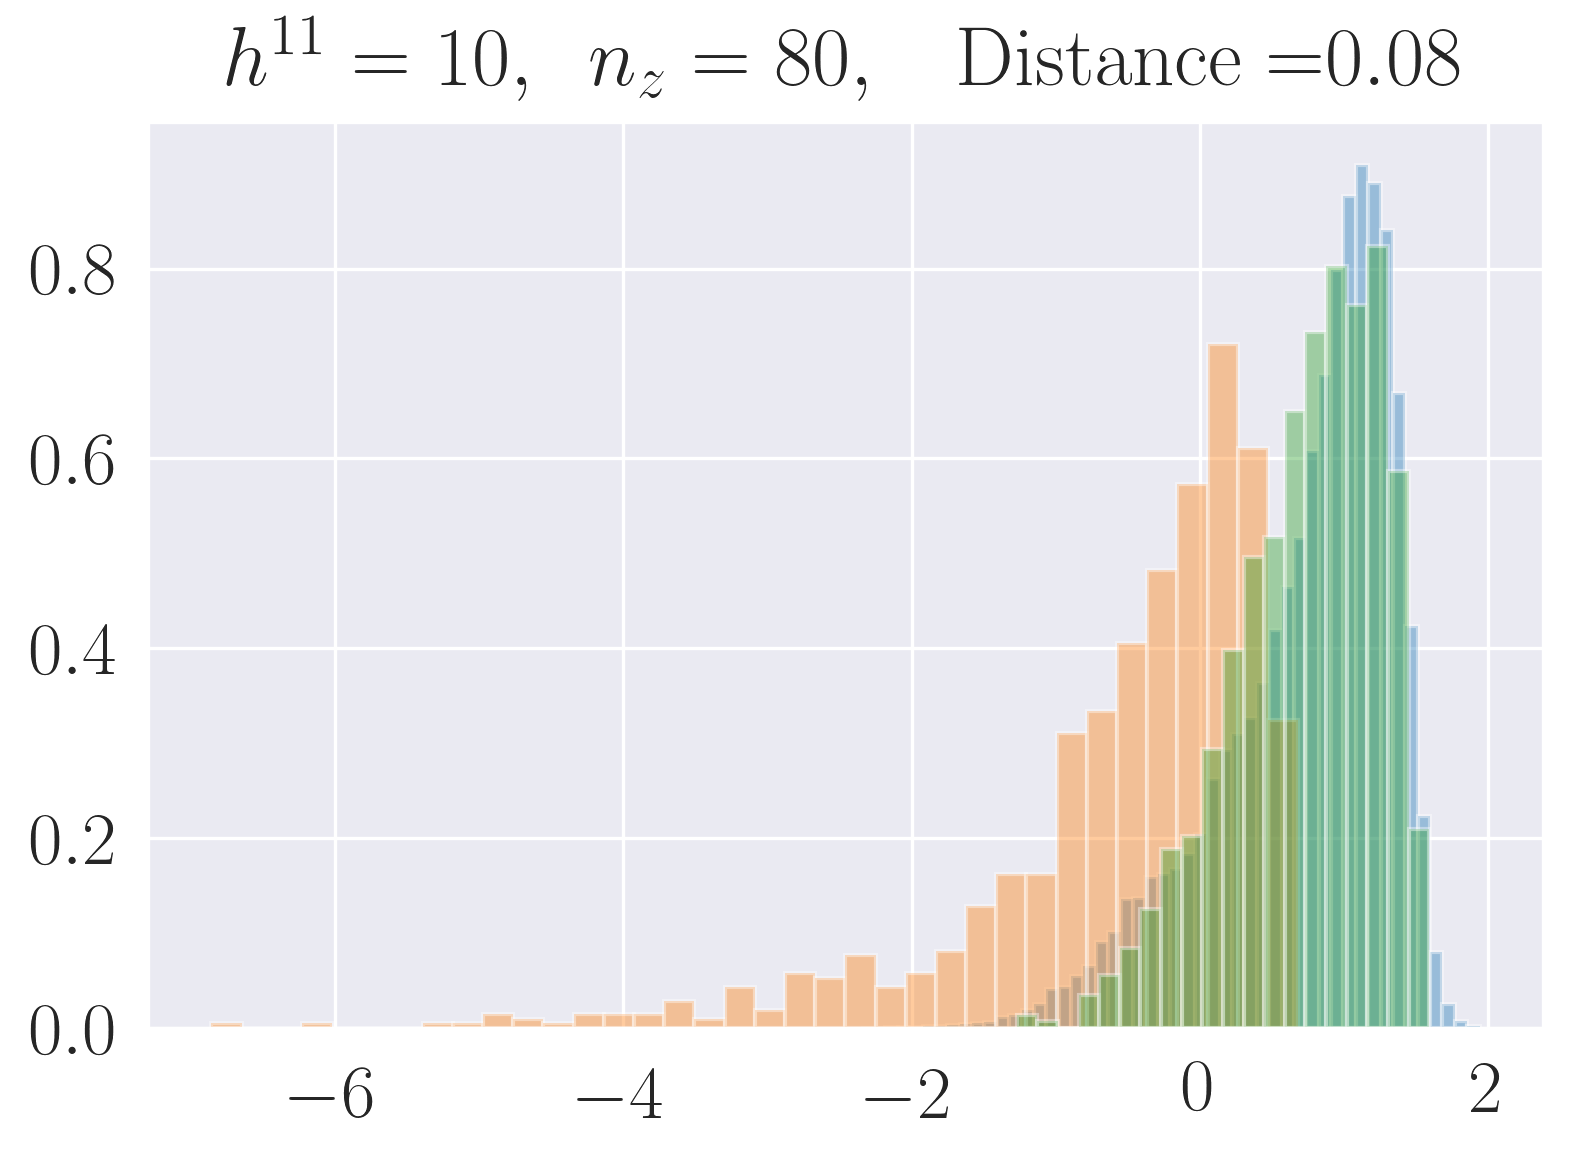

loading GAN: nz_vary/exp_h11_20_nz_5/netG_epoch_2000.pth 20 5
loading GAN: nz_vary/exp_h11_10_nz_45/netG_epoch_2000.pth 10 45
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.2554884015816494 0.07653247931759975
Wasserstein Distance Wishart (no log, log): 9.390192104341073 1.225251484487332


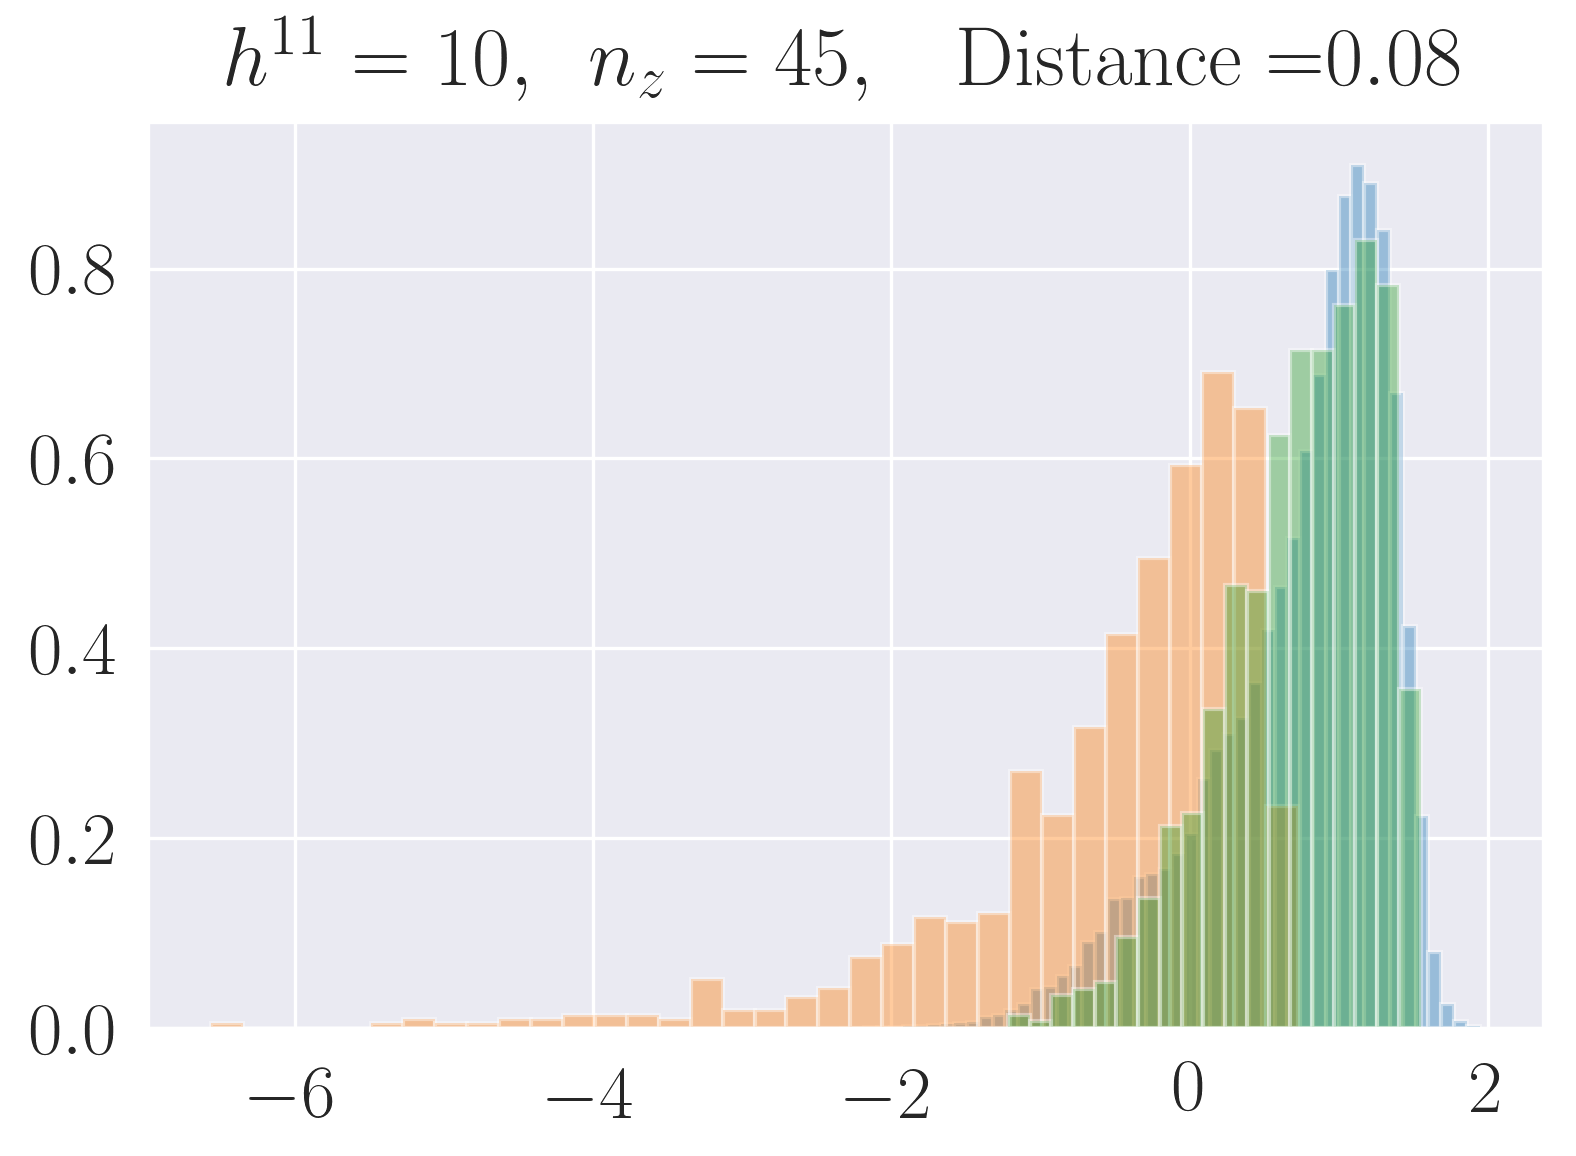

loading GAN: nz_vary/exp_h11_10_nz_20/netG_epoch_2000.pth 10 20
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.0828374882953526 0.0729684401269137
Wasserstein Distance Wishart (no log, log): 9.42205698504827 1.269905437351505


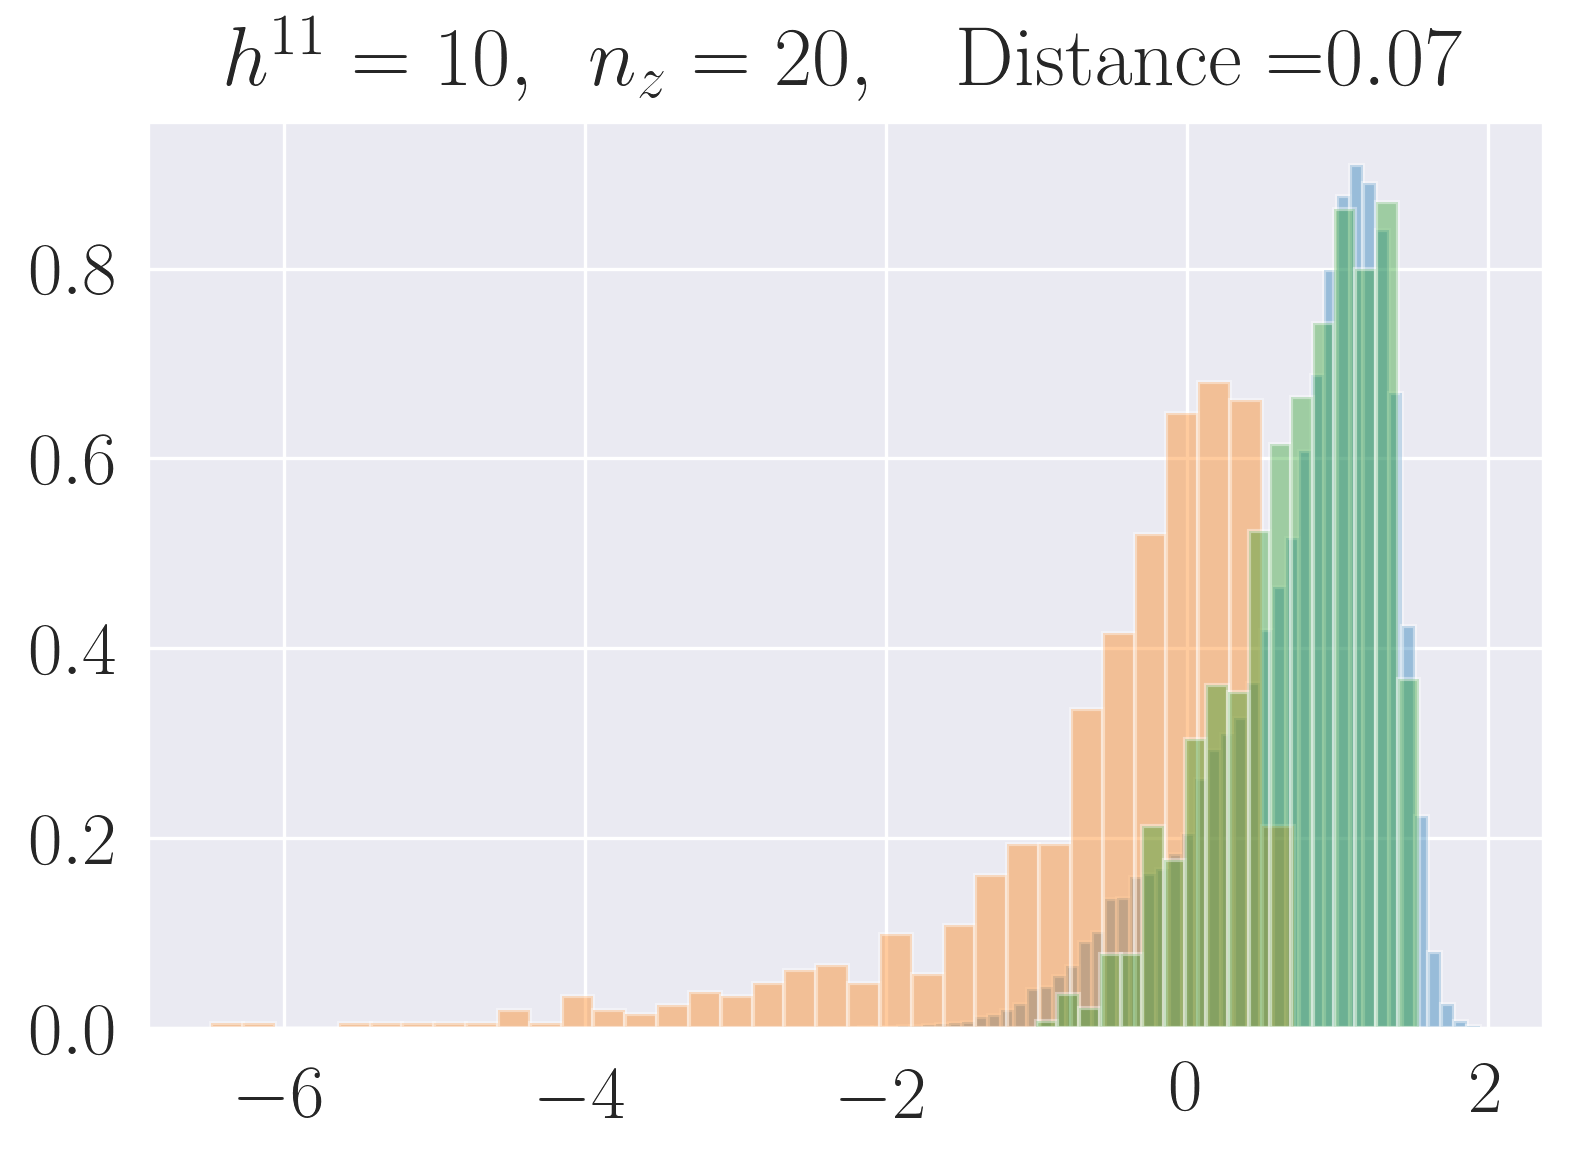

loading GAN: nz_vary/exp_h11_10_nz_75/netG_epoch_2000.pth 10 75
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.2266678319903324 0.08220284094823456
Wasserstein Distance Wishart (no log, log): 9.392965538613185 1.2316985628613717


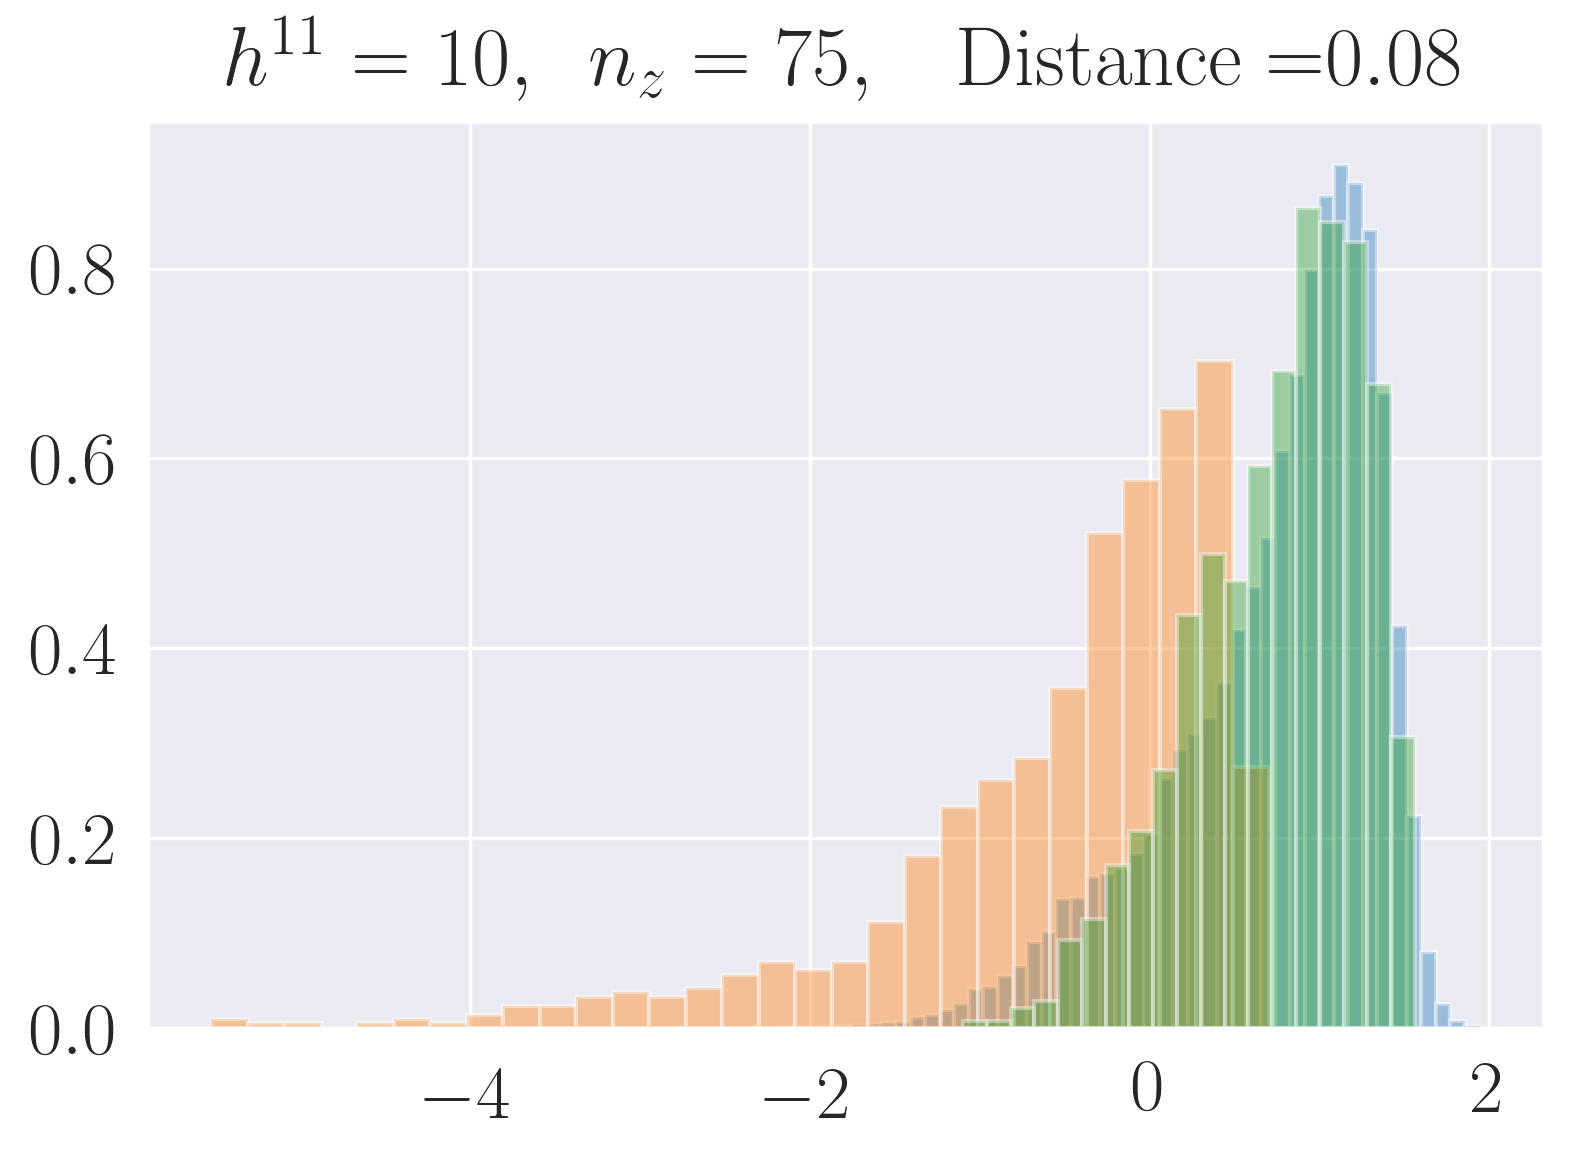

loading GAN: nz_vary/exp_h11_10_nz_10/netG_epoch_2000.pth 10 10
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.2271944837730653 0.08463130537258536
Wasserstein Distance Wishart (no log, log): 9.38825475317806 1.234963608014898


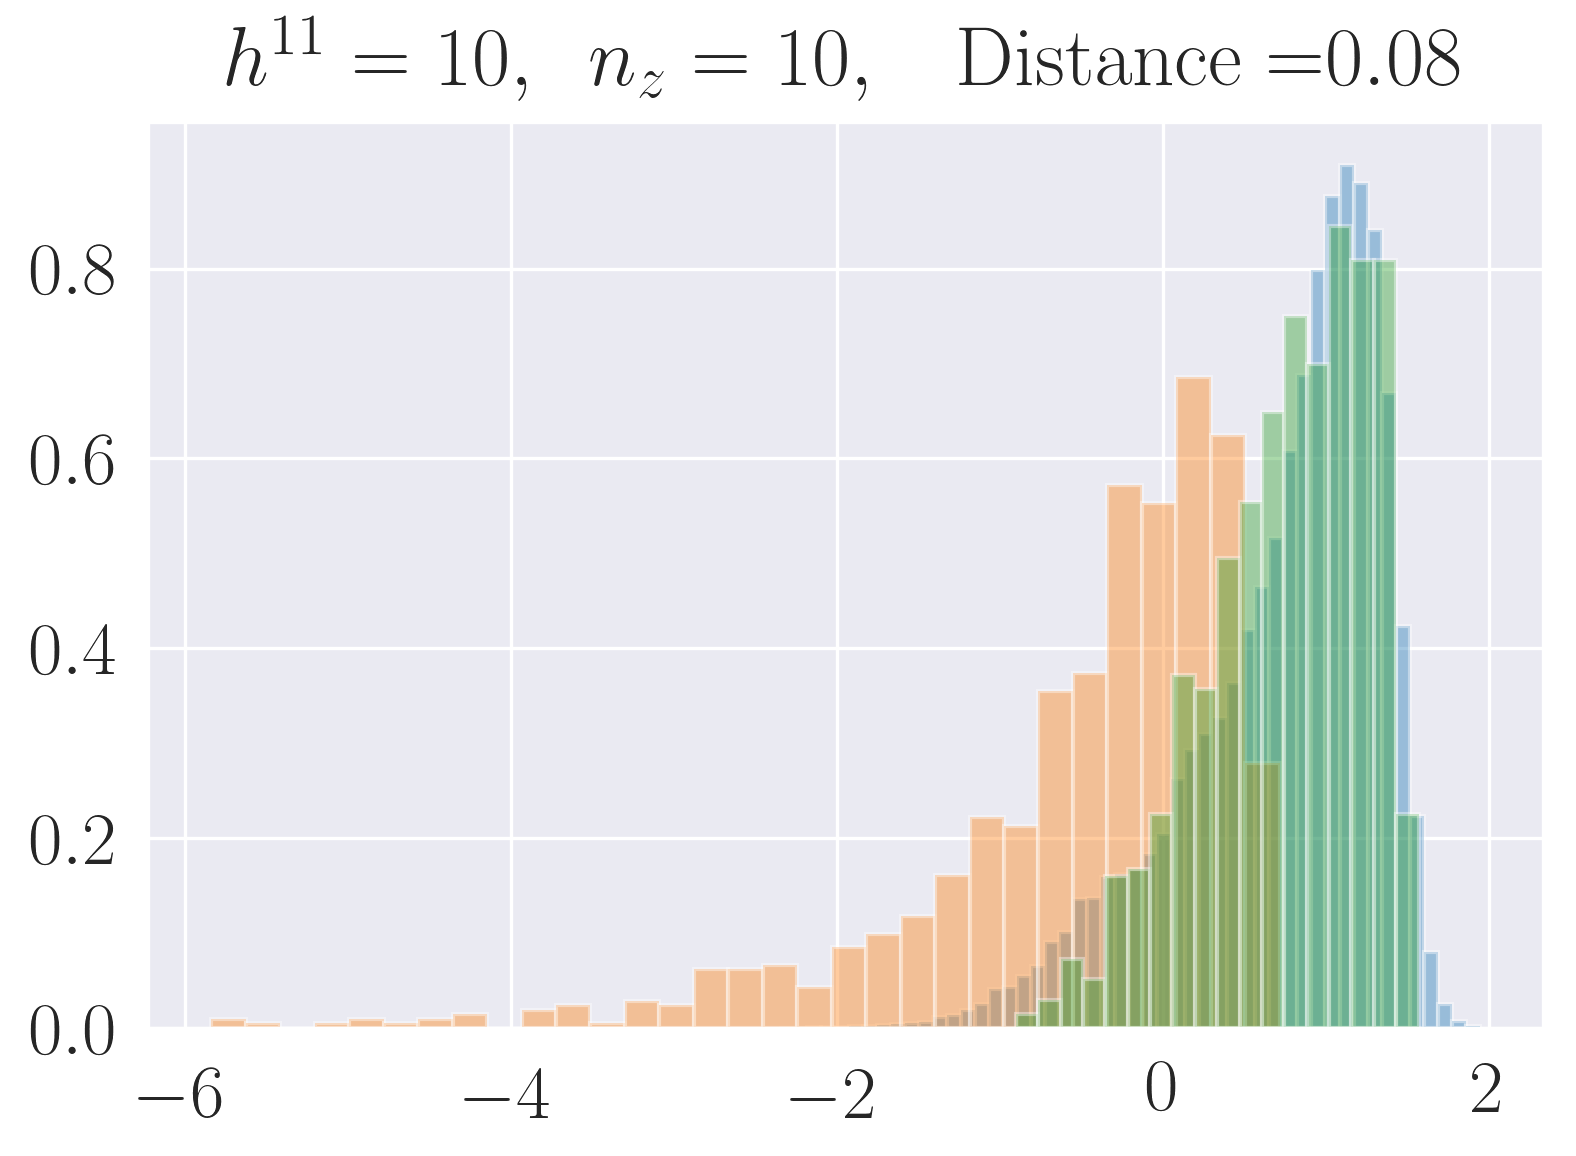

loading GAN: nz_vary/exp_h11_30_nz_75/netG_epoch_2000.pth 30 75
loading GAN: nz_vary/exp_h11_20_nz_70/netG_epoch_2000.pth 20 70
loading GAN: nz_vary/exp_h11_30_nz_10/netG_epoch_2000.pth 30 10
loading GAN: nz_vary/exp_h11_20_nz_15/netG_epoch_2000.pth 20 15
loading GAN: nz_vary/exp_h11_20_nz_85/netG_epoch_2000.pth 20 85
loading GAN: nz_vary/exp_h11_30_nz_45/netG_epoch_2000.pth 30 45
loading GAN: nz_vary/exp_h11_20_nz_40/netG_epoch_2000.pth 20 40
loading GAN: nz_vary/exp_h11_30_nz_80/netG_epoch_2000.pth 30 80
loading GAN: nz_vary/exp_h11_30_nz_20/netG_epoch_2000.pth 30 20
loading GAN: nz_vary/exp_h11_20_nz_25/netG_epoch_2000.pth 20 25
loading GAN: nz_vary/exp_h11_30_nz_55/netG_epoch_2000.pth 30 55
loading GAN: nz_vary/exp_h11_20_nz_95/netG_epoch_2000.pth 20 95
loading GAN: nz_vary/exp_h11_30_nz_90/netG_epoch_2000.pth 30 90
loading GAN: nz_vary/exp_h11_20_nz_50/netG_epoch_2000.pth 20 50
loading GAN: nz_vary/exp_h11_30_nz_30/netG_epoch_2000.pth 30 30
loading GAN: nz_vary/exp_h11_20_nz_35/ne

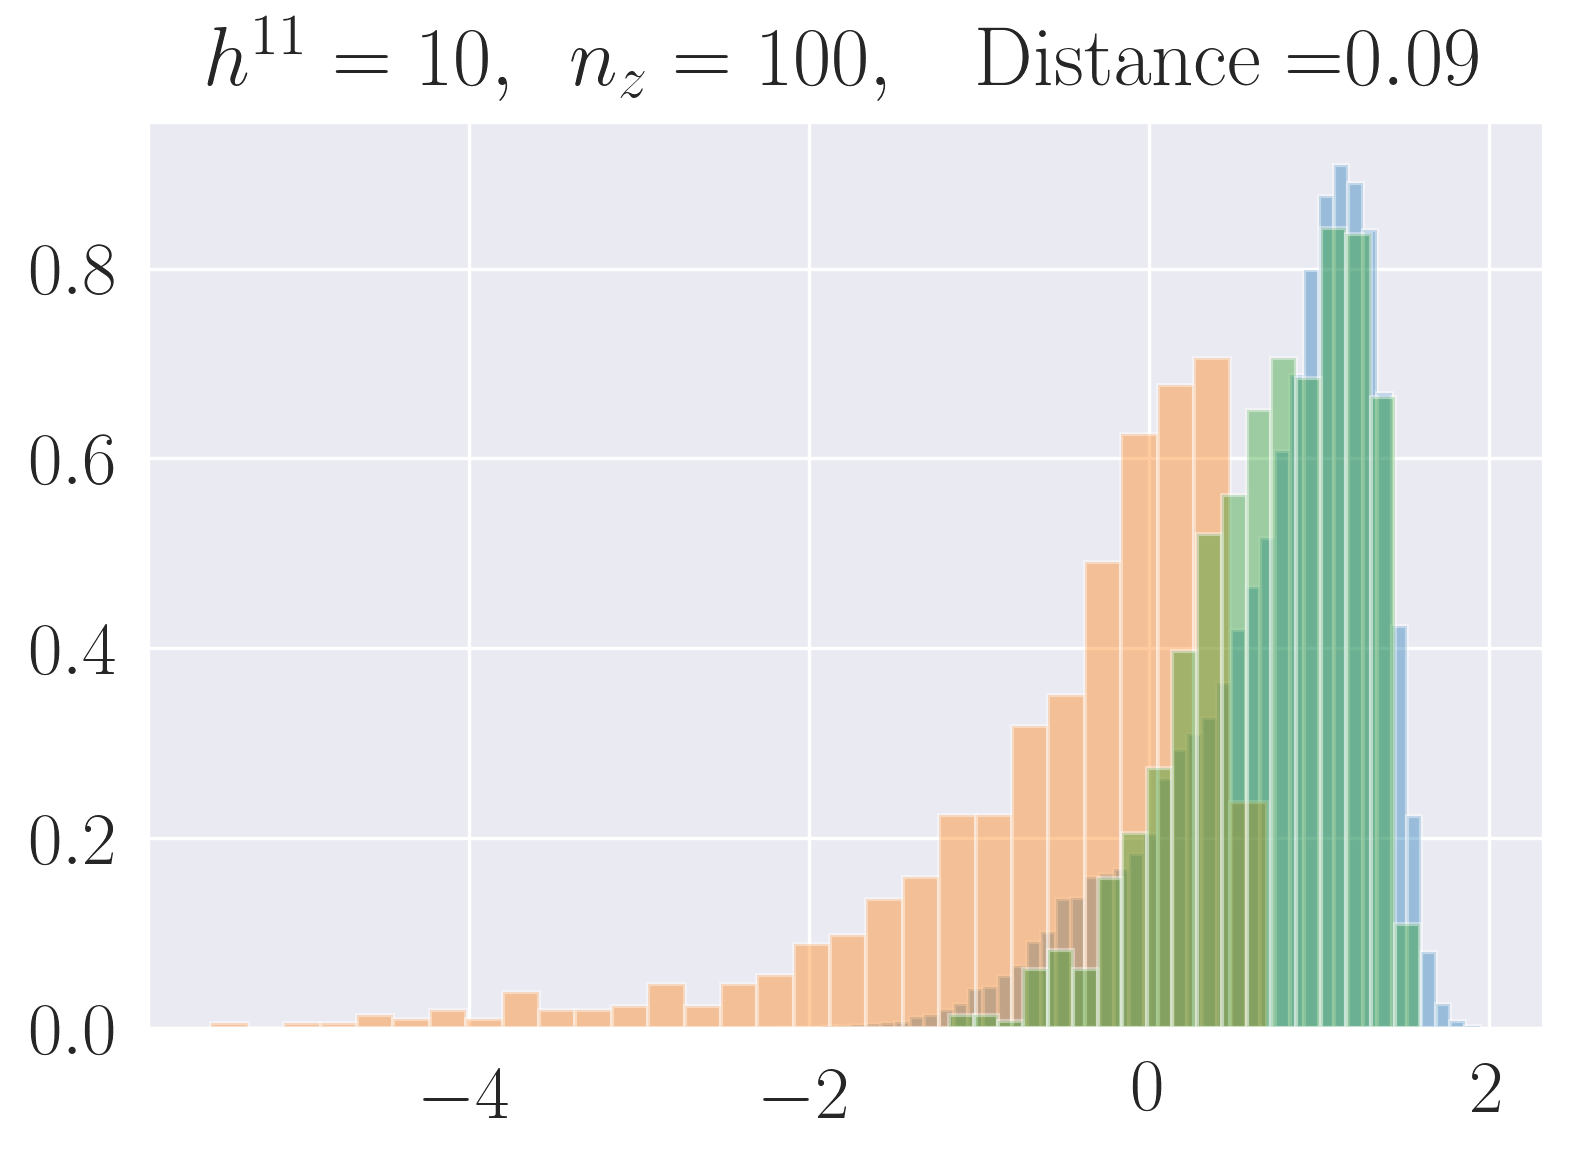

loading GAN: nz_vary/exp_h11_30_nz_65/netG_epoch_2000.pth 30 65
loading GAN: nz_vary/exp_h11_20_nz_60/netG_epoch_2000.pth 20 60
loading GAN: nz_vary/exp_h11_10_nz_65/netG_epoch_2000.pth 10 65
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.430747593657712 0.09029535572750289
Wasserstein Distance Wishart (no log, log): 9.427045279205608 1.2561464266924107


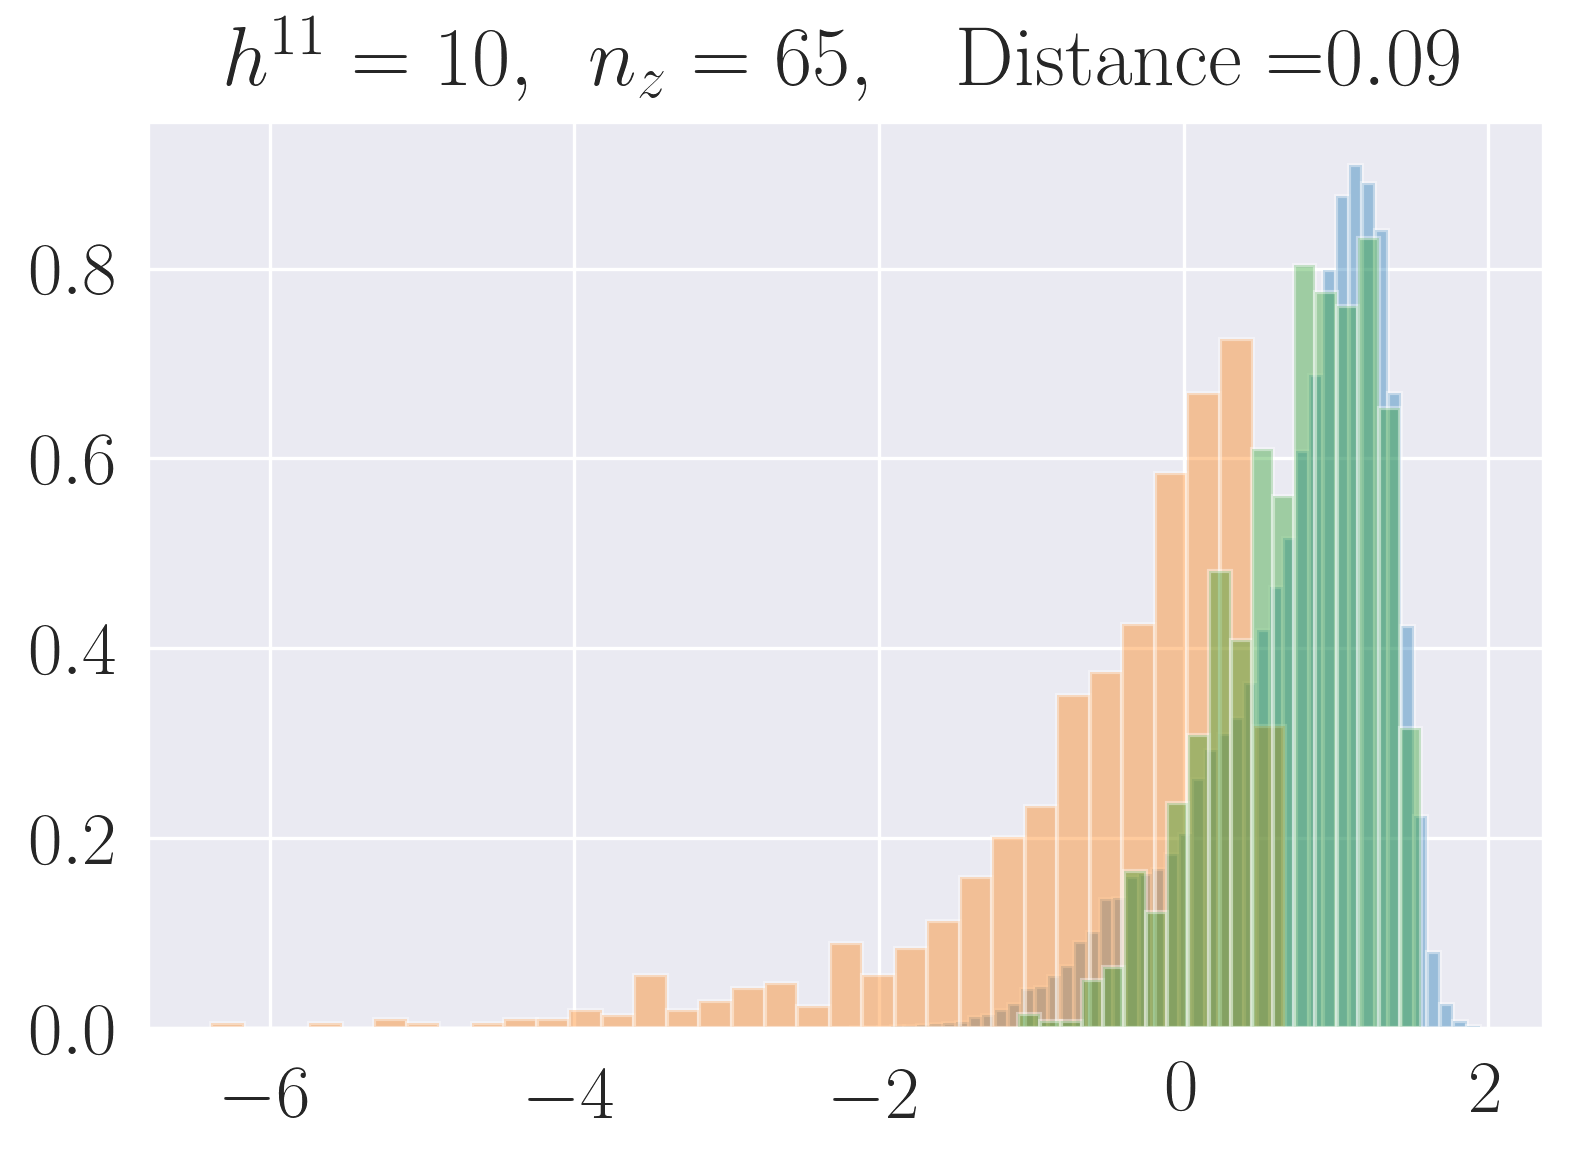

loading GAN: nz_vary/exp_h11_10_nz_90/netG_epoch_2000.pth 10 90
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.2780631946939356 0.0780037113933436
Wasserstein Distance Wishart (no log, log): 9.407400040962074 1.241110570878848


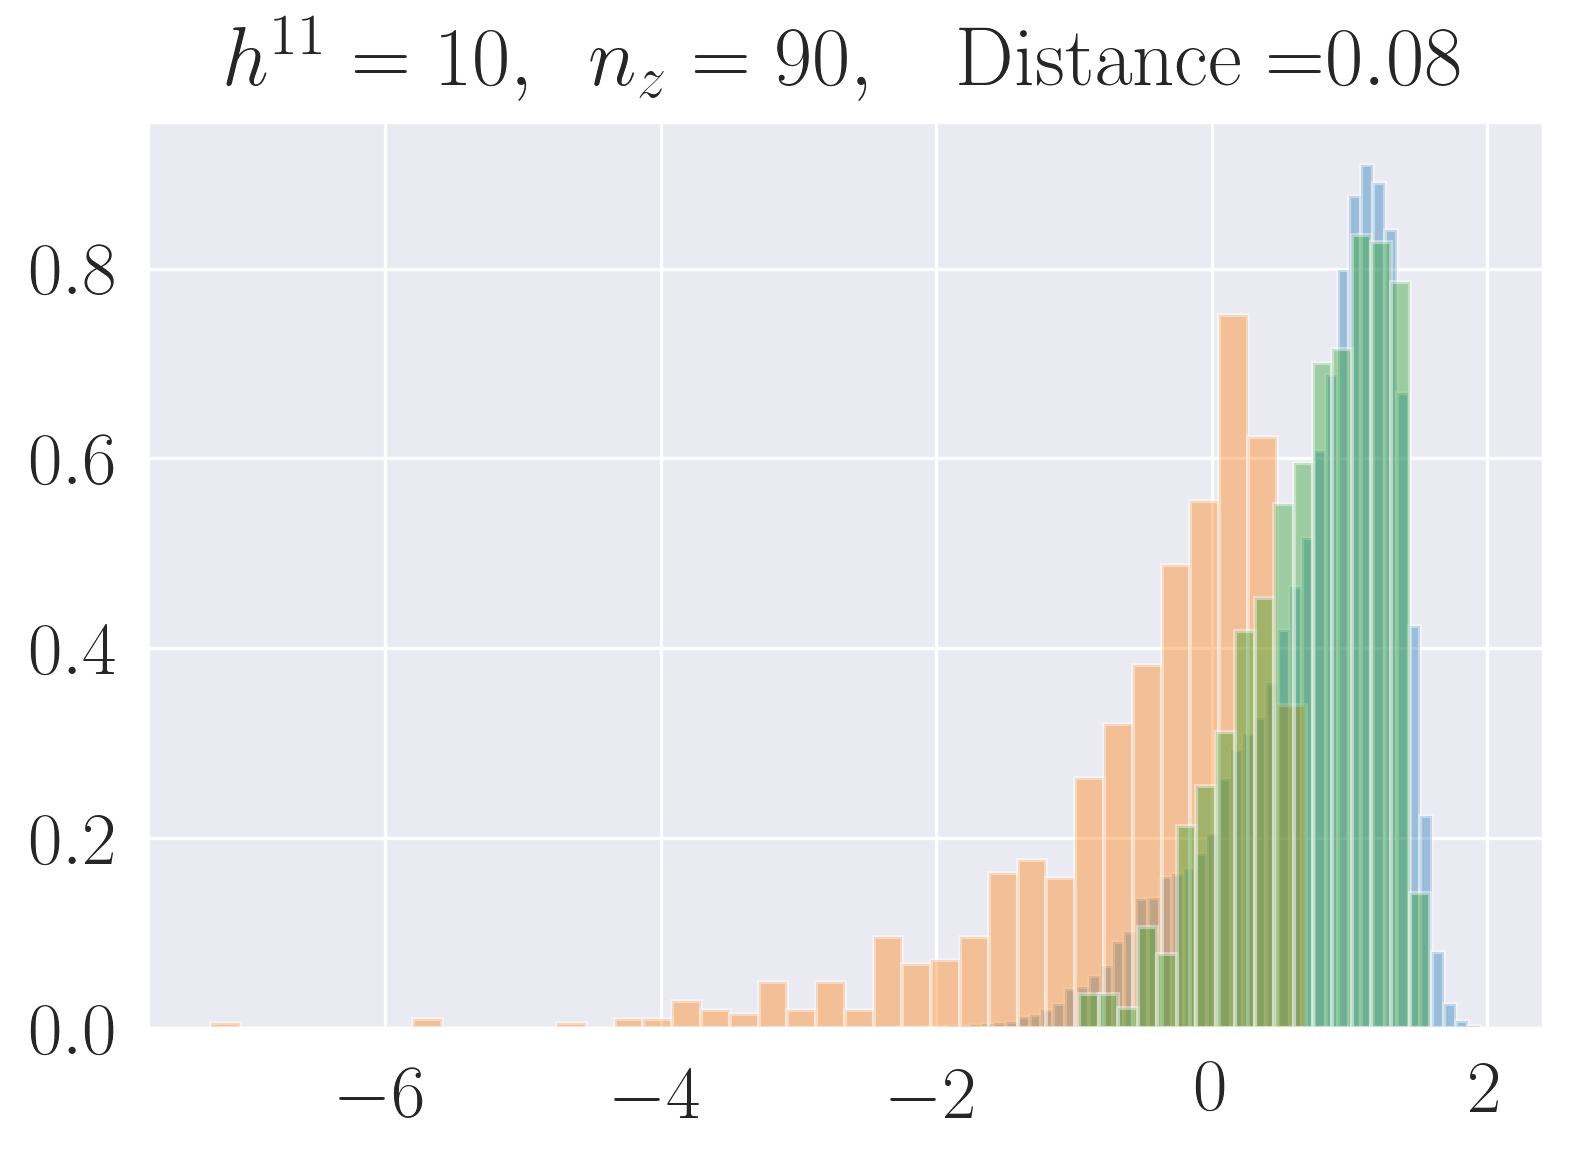

loading GAN: nz_vary/exp_h11_10_nz_55/netG_epoch_2000.pth 10 55
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.4397175811061473 0.08851452548767944
Wasserstein Distance Wishart (no log, log): 9.393478790018518 1.2414675004851403


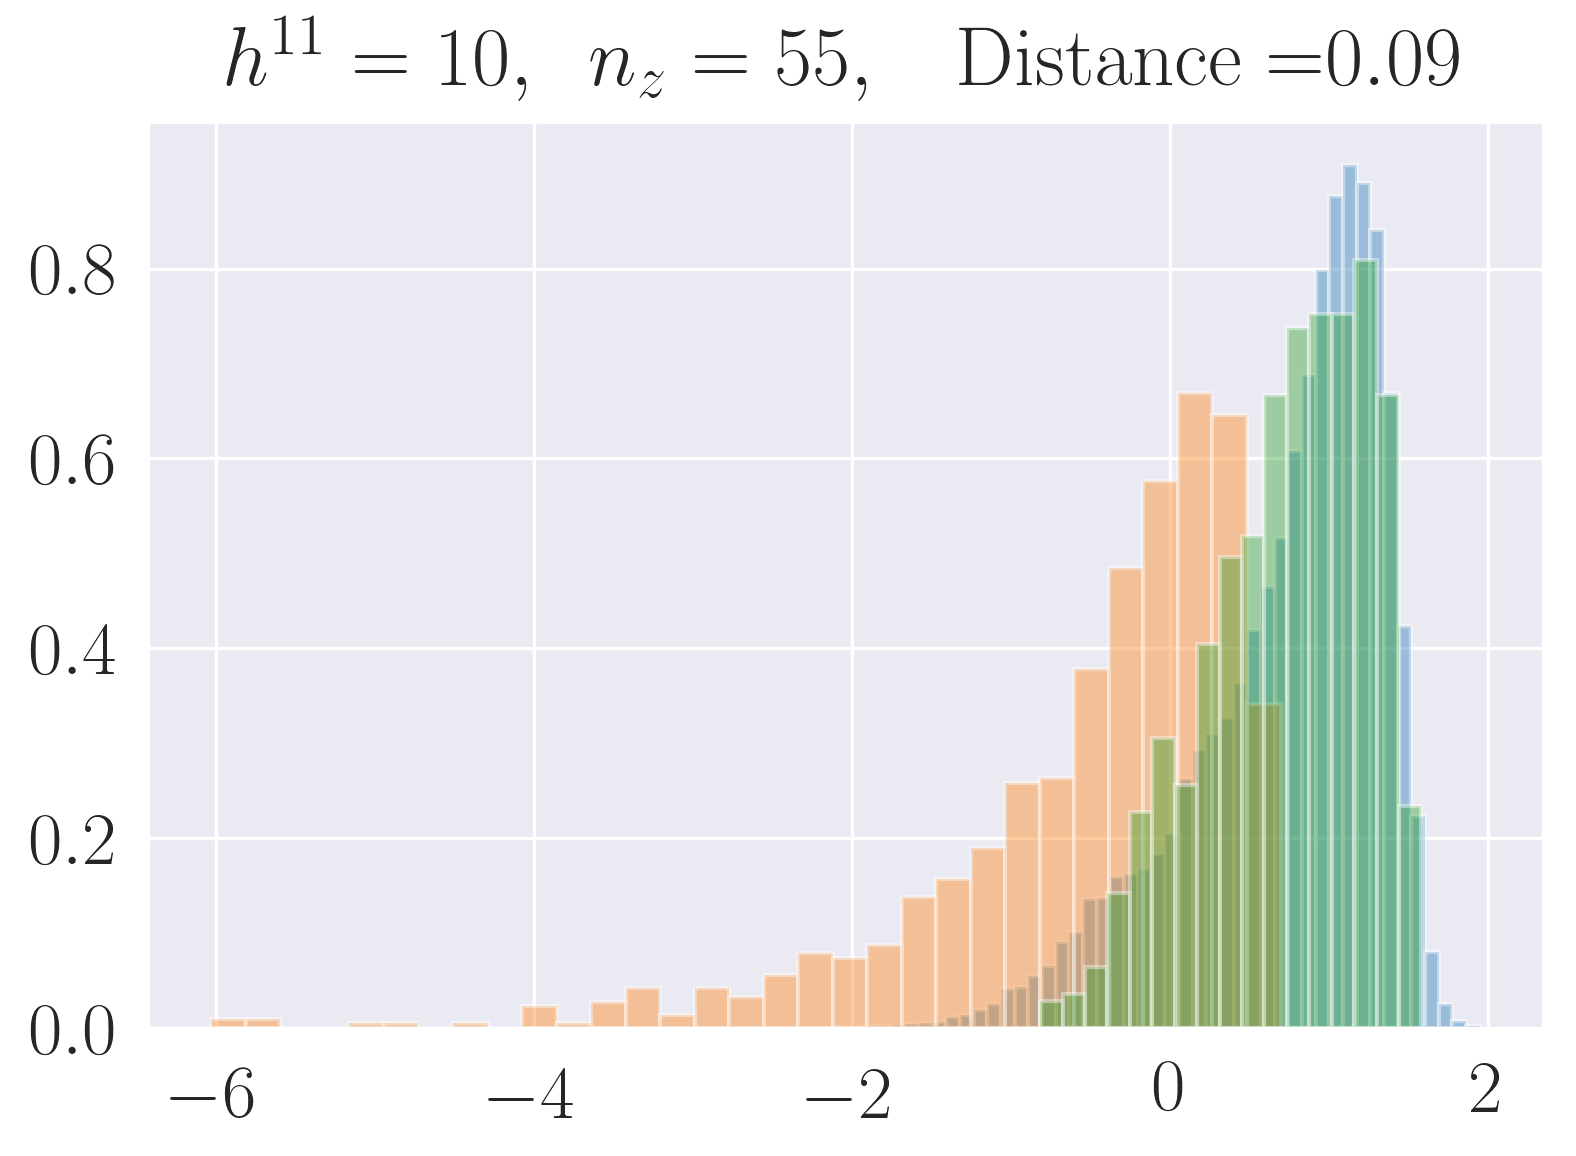

loading GAN: nz_vary/exp_h11_10_nz_30/netG_epoch_2000.pth 10 30
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.1656731957983968 0.0863311713332036
Wasserstein Distance Wishart (no log, log): 9.438464322977683 1.249269100453336


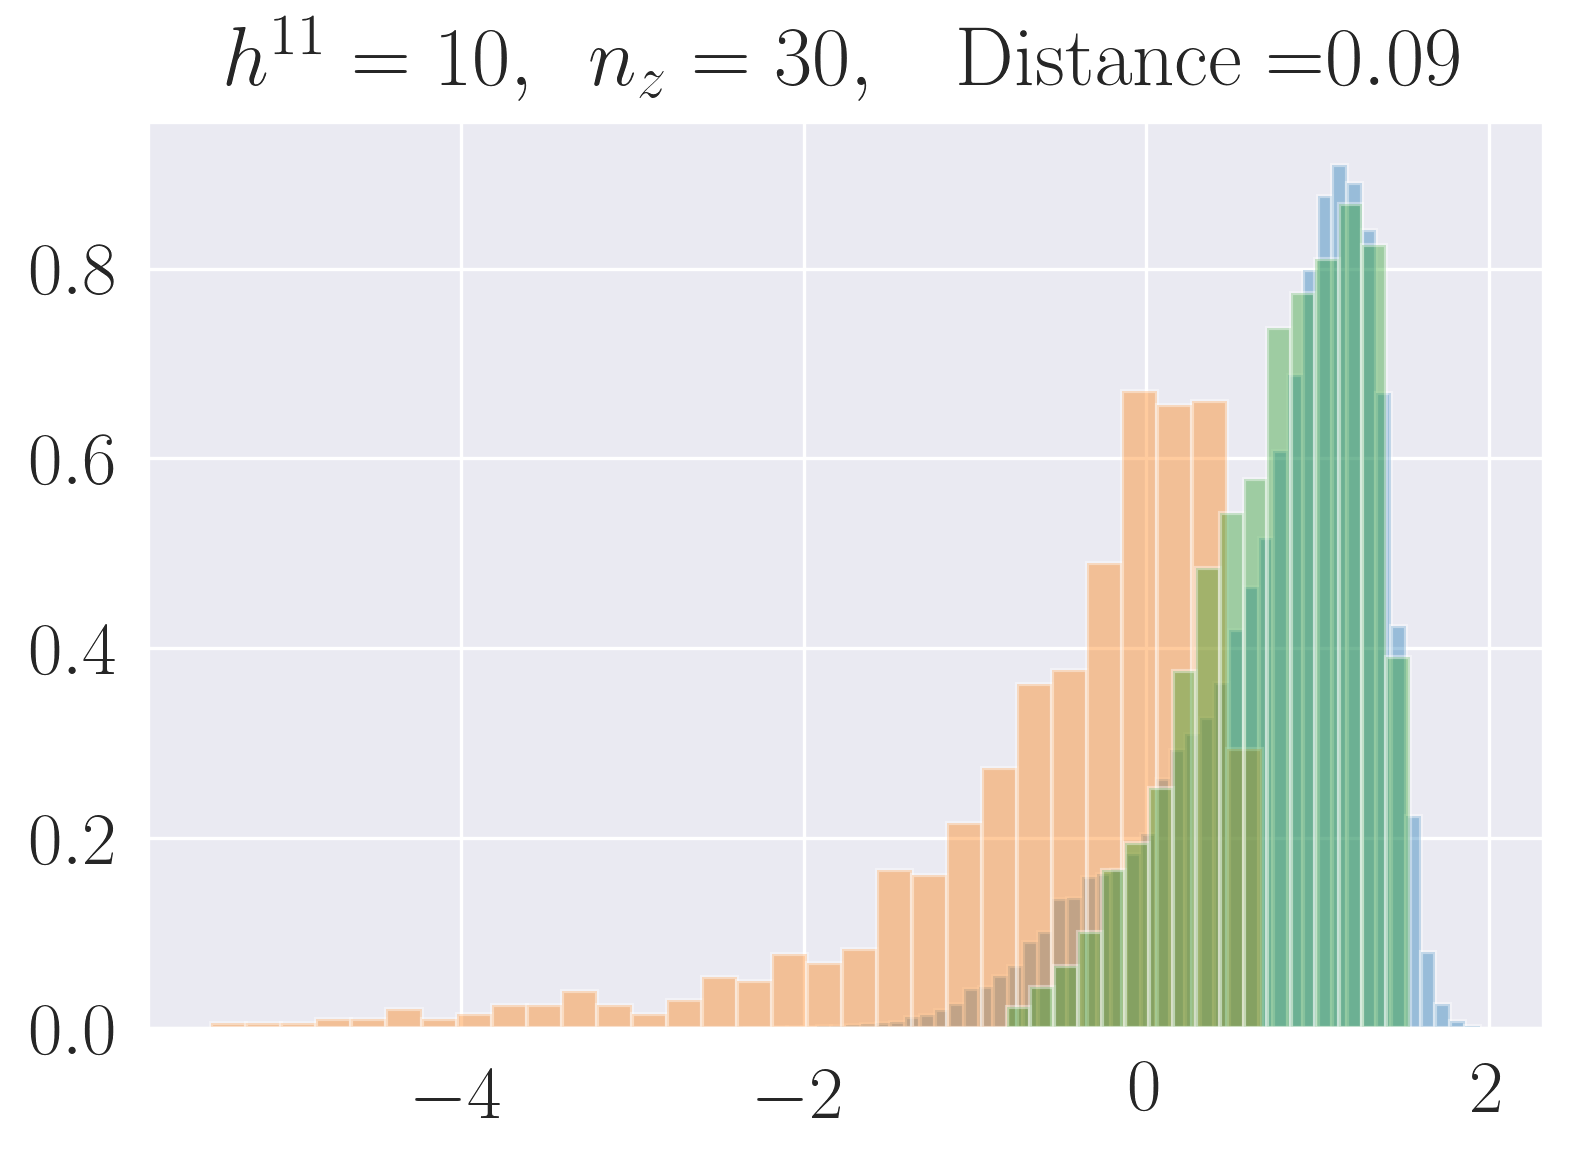

loading GAN: nz_vary/exp_h11_10_nz_15/netG_epoch_2000.pth 10 15
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.1792351321745382 0.0861100972855091
Wasserstein Distance Wishart (no log, log): 9.413789858611645 1.2231021761746765


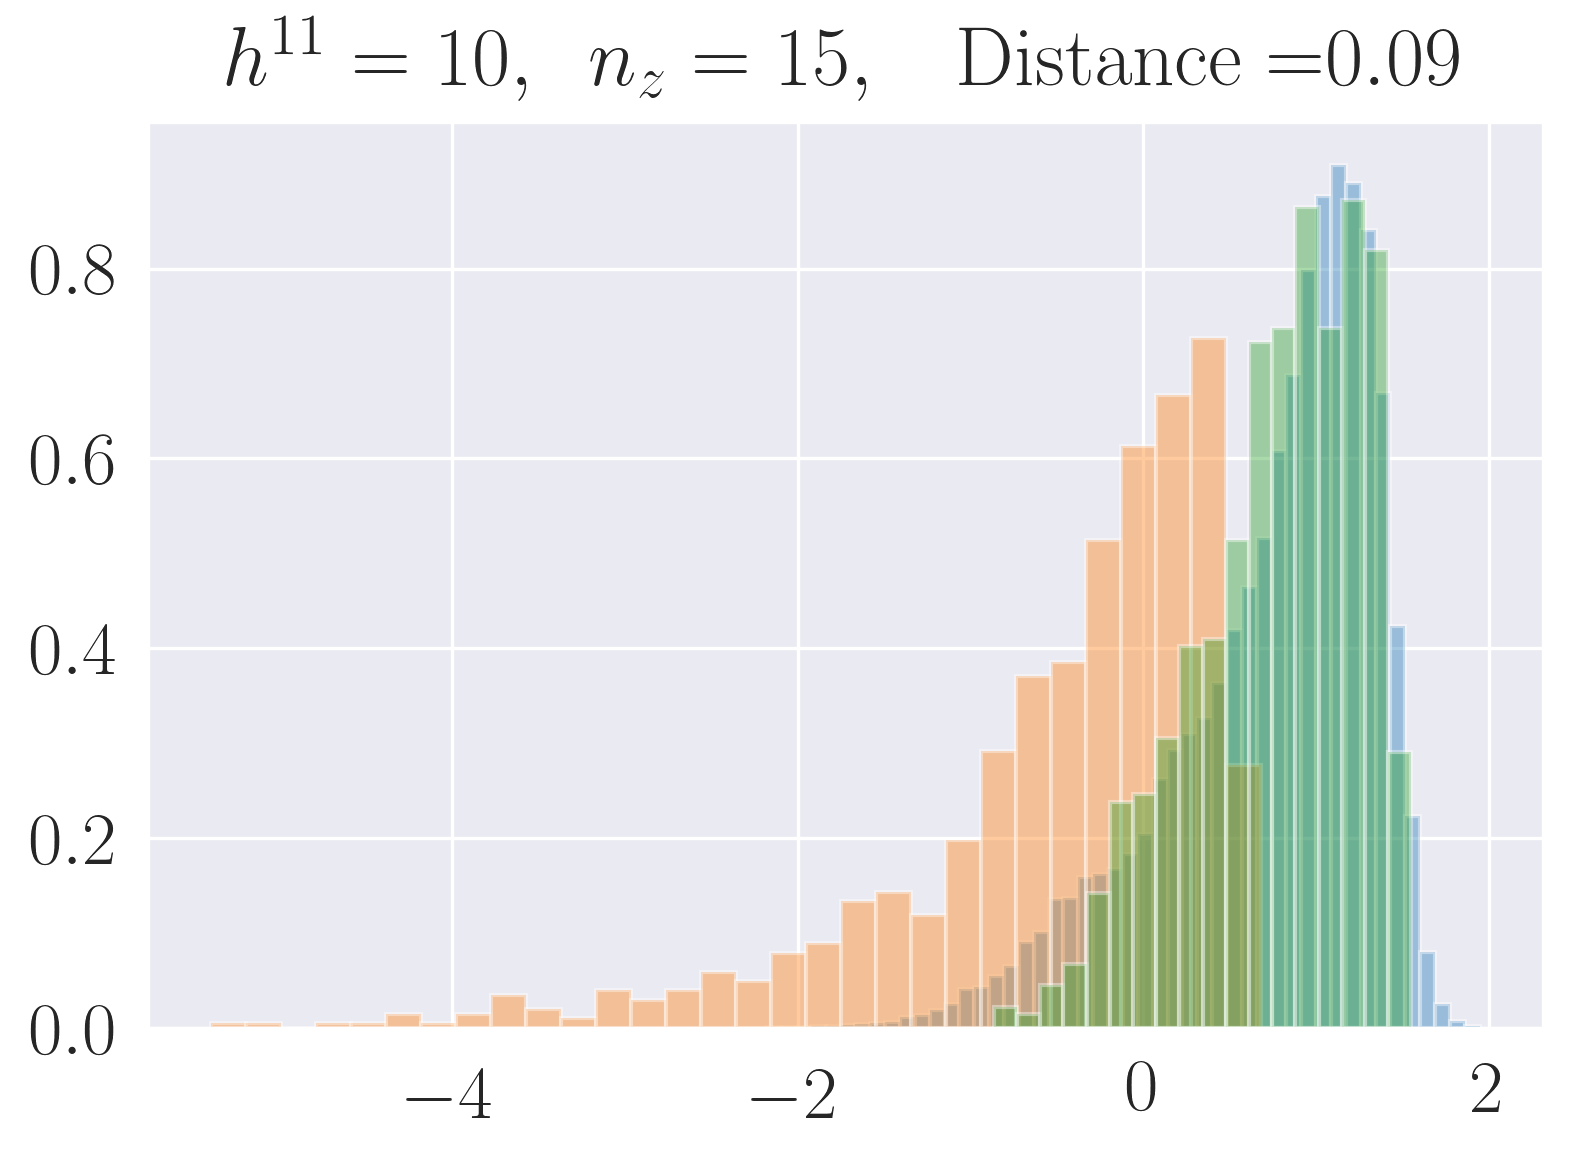

loading GAN: nz_vary/exp_h11_10_nz_70/netG_epoch_2000.pth 10 70
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.3741280766968607 0.08578517294489013
Wasserstein Distance Wishart (no log, log): 9.41200855801706 1.2379282885161906


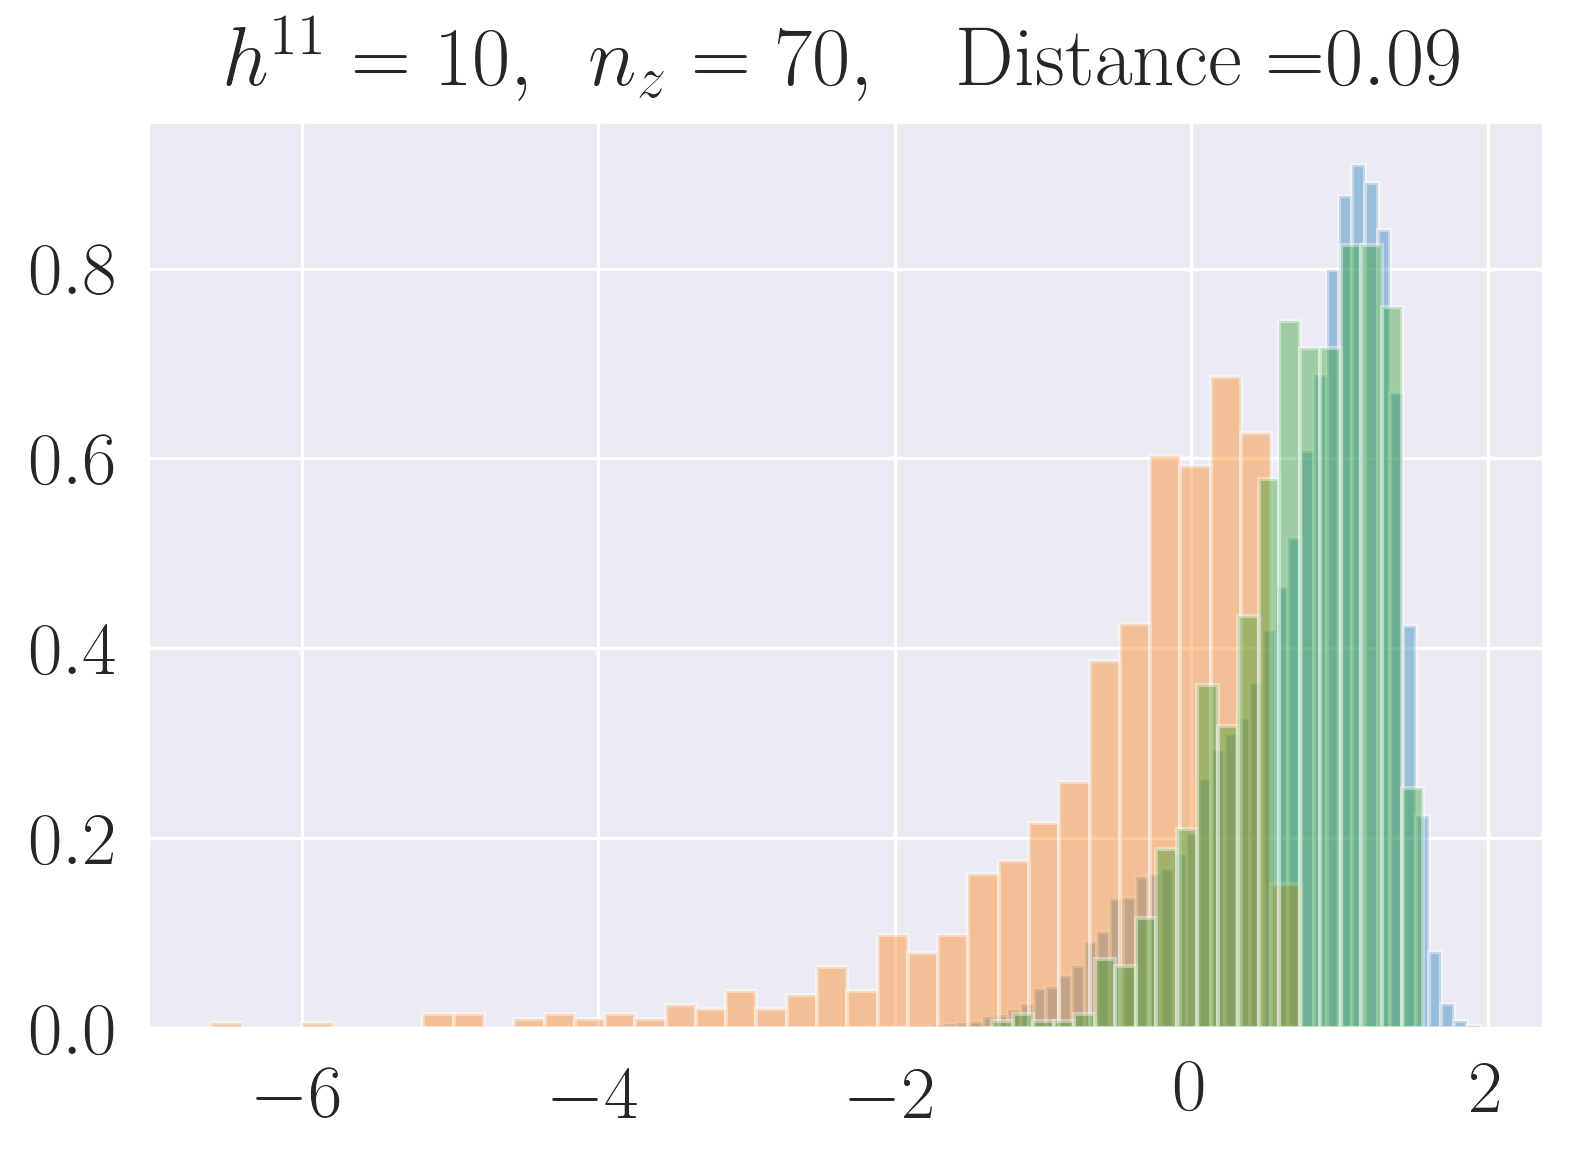

loading GAN: nz_vary/exp_h11_10_nz_25/netG_epoch_2000.pth 10 25
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.2032873771180301 0.08407337179094018
Wasserstein Distance Wishart (no log, log): 9.417547255997246 1.2432349623773613


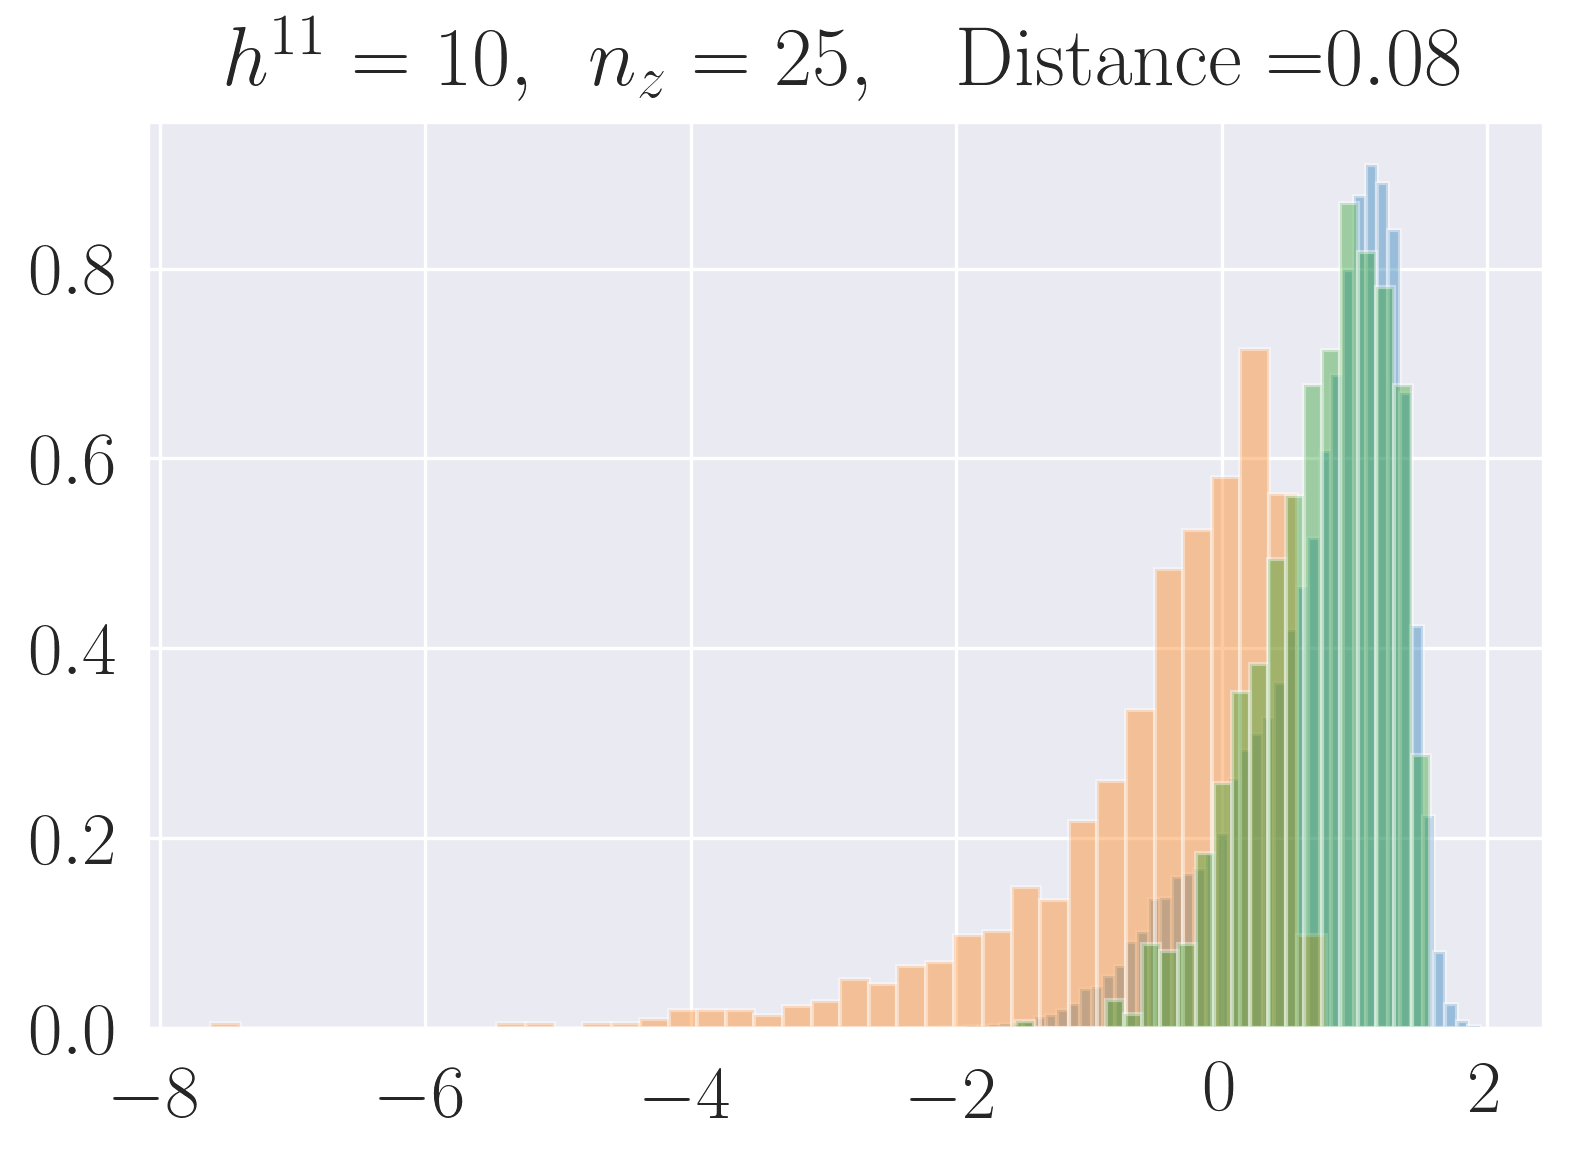

loading GAN: nz_vary/exp_h11_20_nz_100/netG_epoch_2000.pth 20 100
loading GAN: nz_vary/exp_h11_10_nz_40/netG_epoch_2000.pth 10 40
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.4111136623278786 0.09092416913129202
Wasserstein Distance Wishart (no log, log): 9.415328178248995 1.2253994472268481


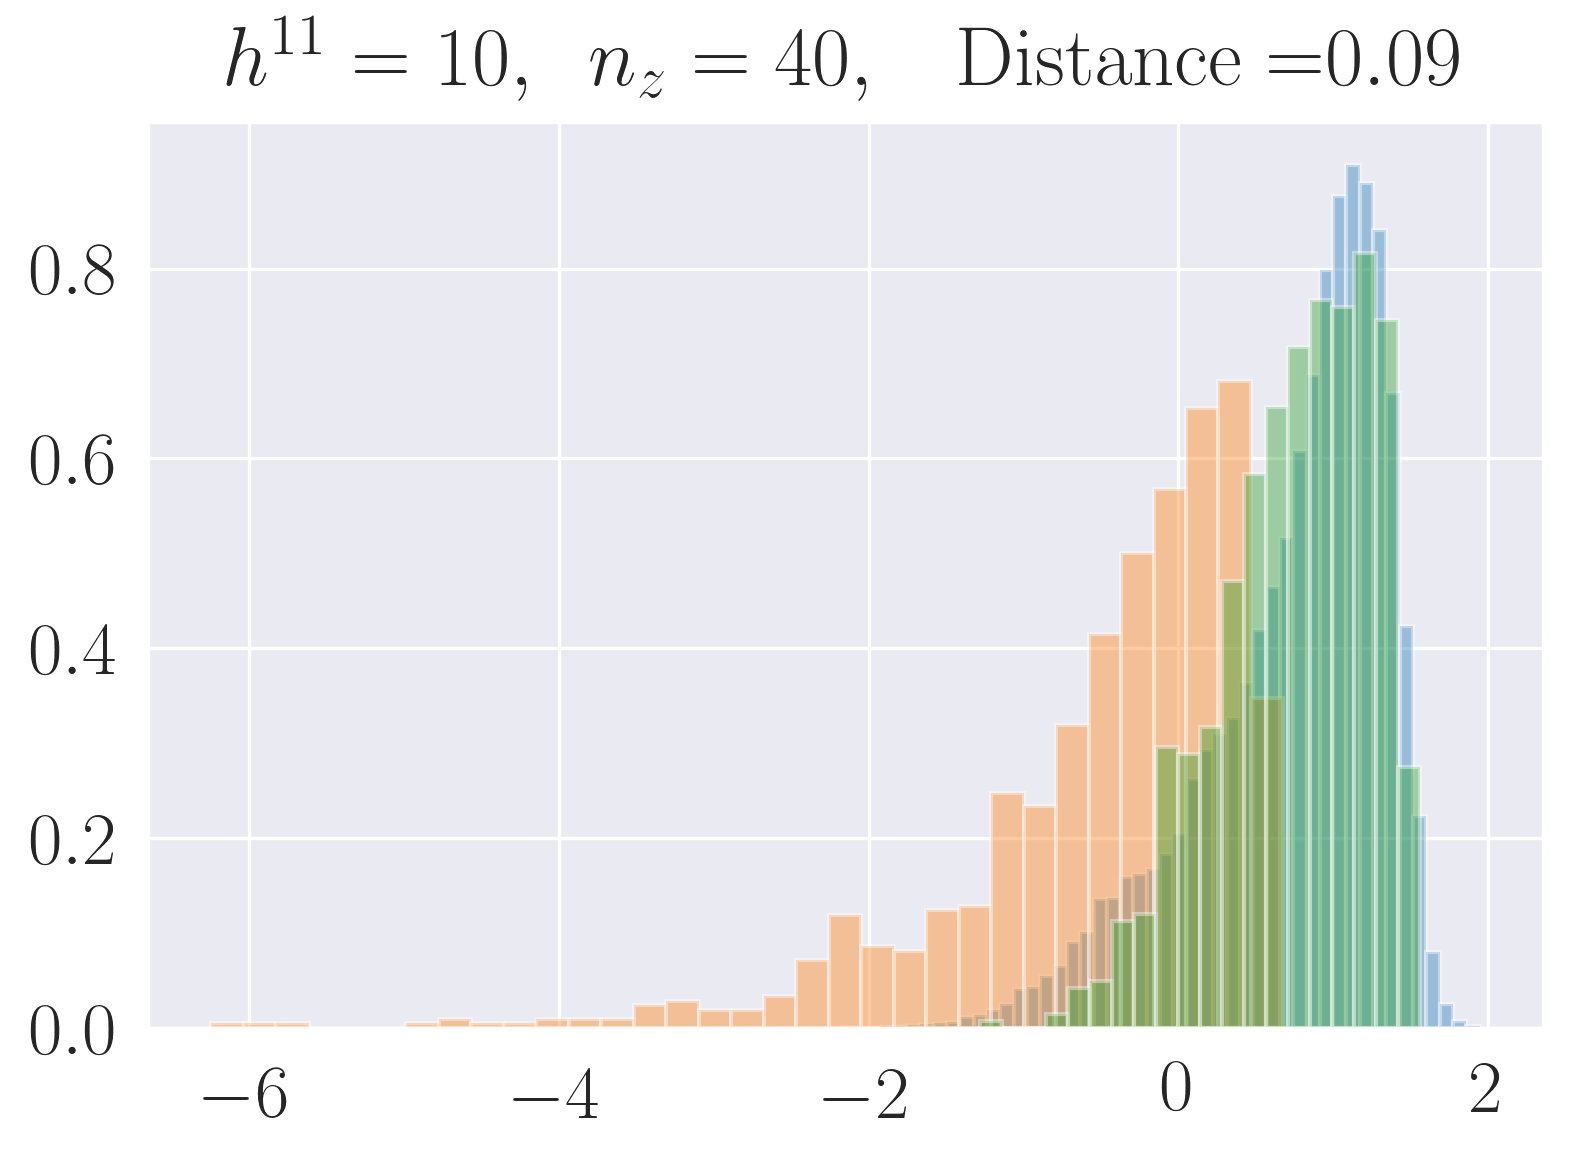

loading GAN: nz_vary/exp_h11_10_nz_85/netG_epoch_2000.pth 10 85
	epoch: 2000
Wasserstein Distance GAN (no log, log): 1.6001590104971641 0.11258277815885179
Wasserstein Distance Wishart (no log, log): 9.387264013365408 1.2469964330907193


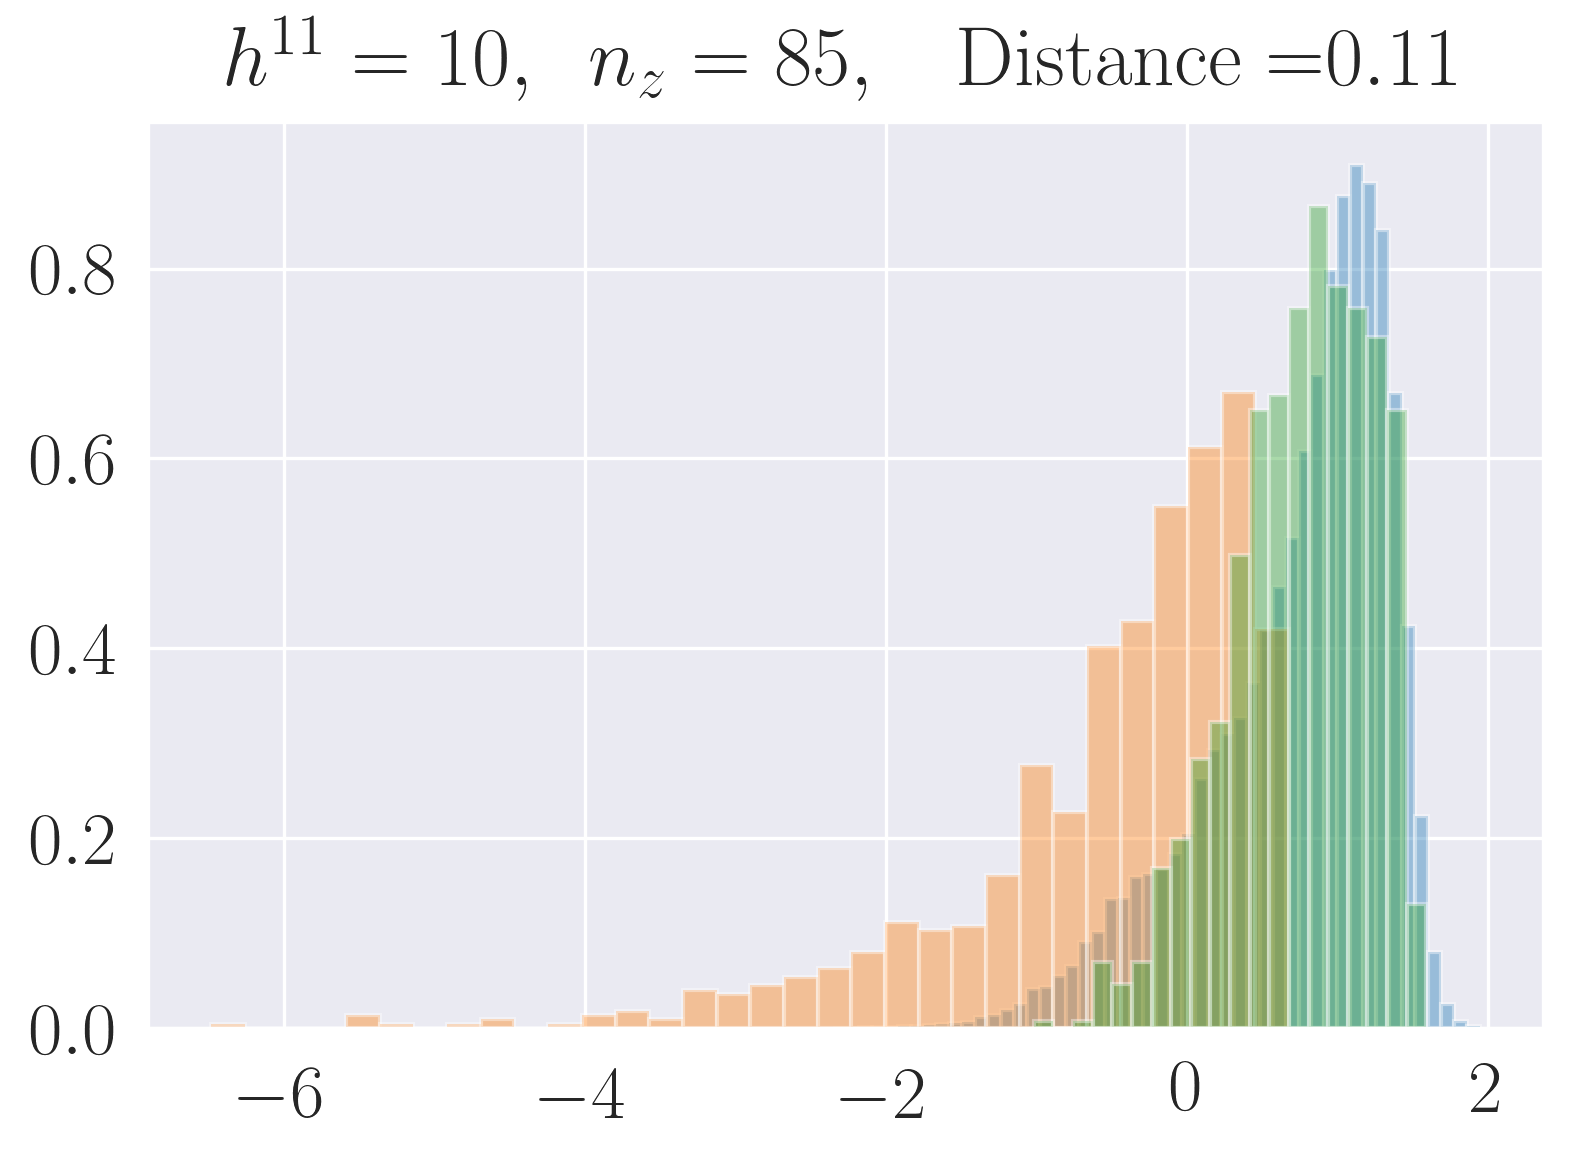

loading GAN: nz_vary/exp_h11_20_nz_20/netG_epoch_2000.pth 20 20
loading GAN: nz_vary/exp_h11_30_nz_25/netG_epoch_2000.pth 30 25
loading GAN: nz_vary/exp_h11_20_nz_45/netG_epoch_2000.pth 20 45
loading GAN: nz_vary/exp_h11_30_nz_100/netG_epoch_2000.pth 30 100
loading GAN: nz_vary/exp_h11_30_nz_85/netG_epoch_2000.pth 30 85
loading GAN: nz_vary/exp_h11_20_nz_80/netG_epoch_2000.pth 20 80
loading GAN: nz_vary/exp_h11_30_nz_40/netG_epoch_2000.pth 30 40
loading GAN: nz_vary/exp_h11_20_nz_10/netG_epoch_2000.pth 20 10
loading GAN: nz_vary/exp_h11_30_nz_15/netG_epoch_2000.pth 30 15
loading GAN: nz_vary/exp_h11_20_nz_75/netG_epoch_2000.pth 20 75
loading GAN: nz_vary/exp_h11_30_nz_70/netG_epoch_2000.pth 30 70
loading GAN: nz_vary_more_data/exp_h11_10_nz_5/netG_epoch_9000.pth 10 5
	epoch: 9000
Wasserstein Distance GAN (no log, log): 1.086920277135365 0.07697415033925313
Wasserstein Distance Wishart (no log, log): 9.395530083134755 1.2243765354568774


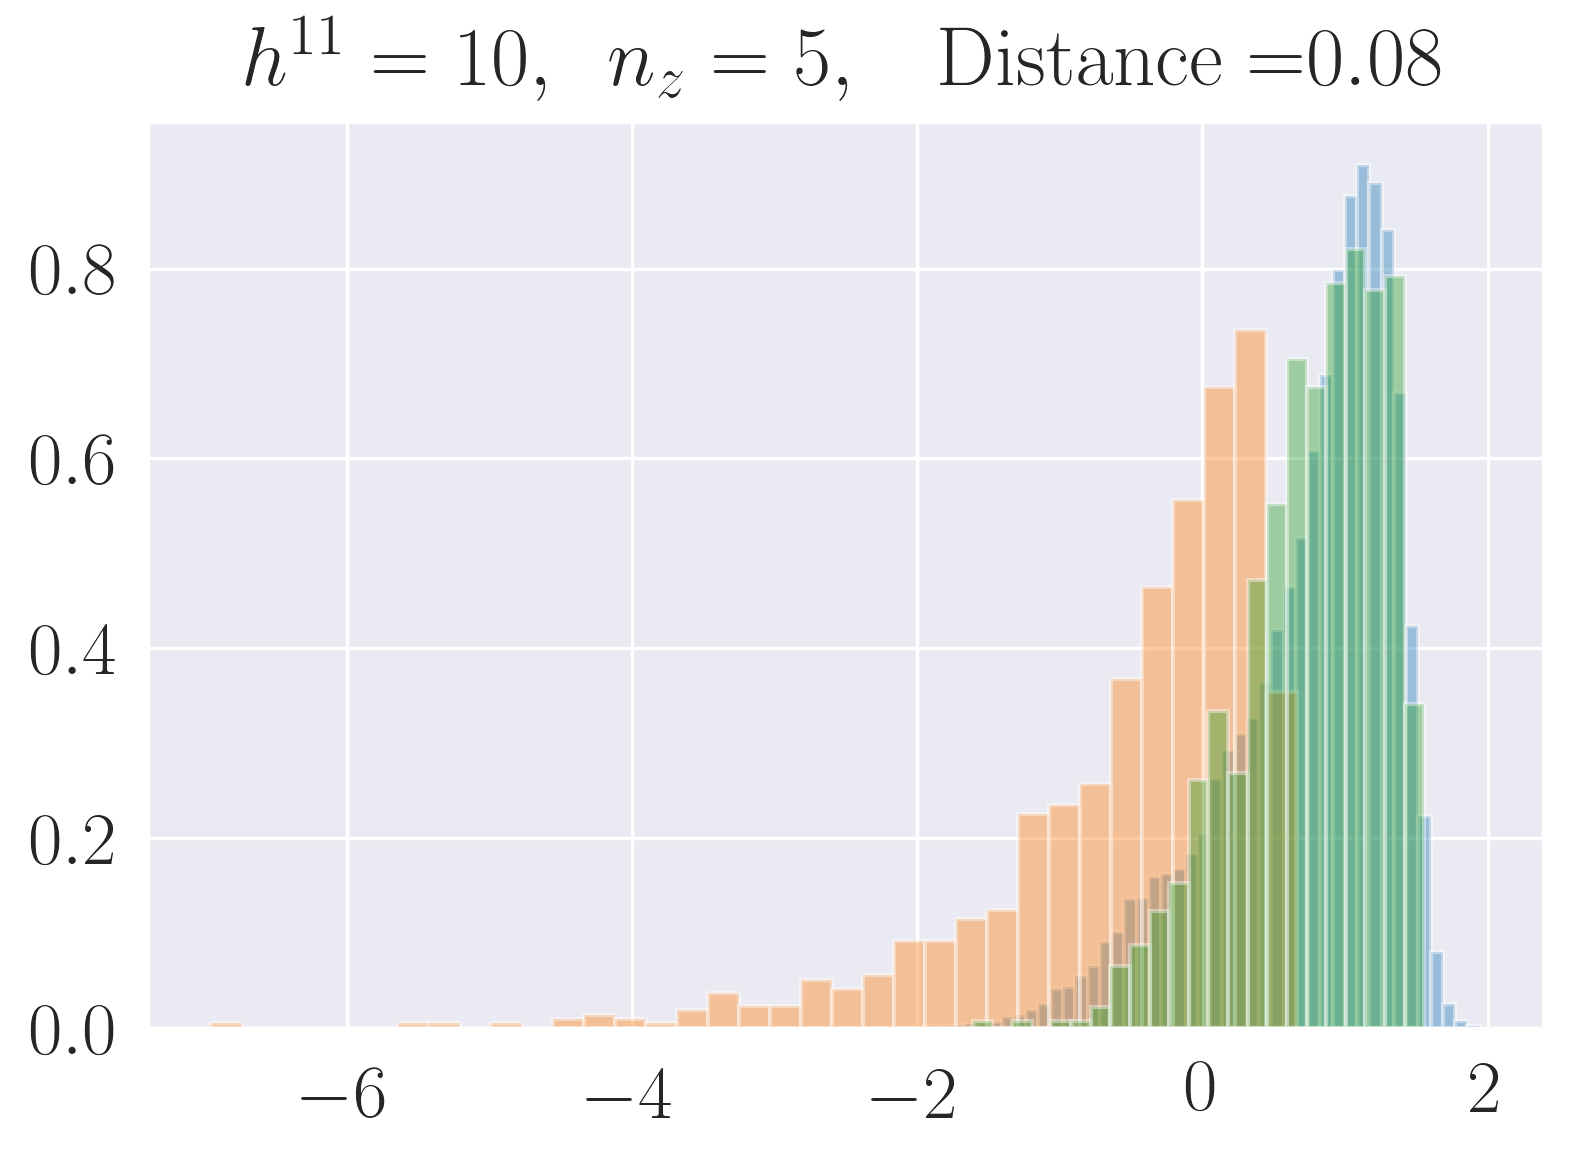

loading GAN: nz_vary_more_data/exp_h11_30_nz_60/netG_epoch_10000.pth 30 60
loading GAN: nz_vary_more_data/exp_h11_20_nz_30/netG_epoch_9000.pth 20 30
loading GAN: nz_vary_more_data/exp_h11_30_nz_5/netG_epoch_9000.pth 30 5
loading GAN: nz_vary_more_data/exp_h11_30_nz_50/netG_epoch_10000.pth 30 50
loading GAN: nz_vary_more_data/exp_h11_20_nz_90/netG_epoch_9000.pth 20 90
loading GAN: nz_vary_more_data/exp_h11_10_nz_50/netG_epoch_9000.pth 10 50
	epoch: 9000
Wasserstein Distance GAN (no log, log): 1.1870548480786387 0.08184313704603169
Wasserstein Distance Wishart (no log, log): 9.423264192027688 1.2412682900587084


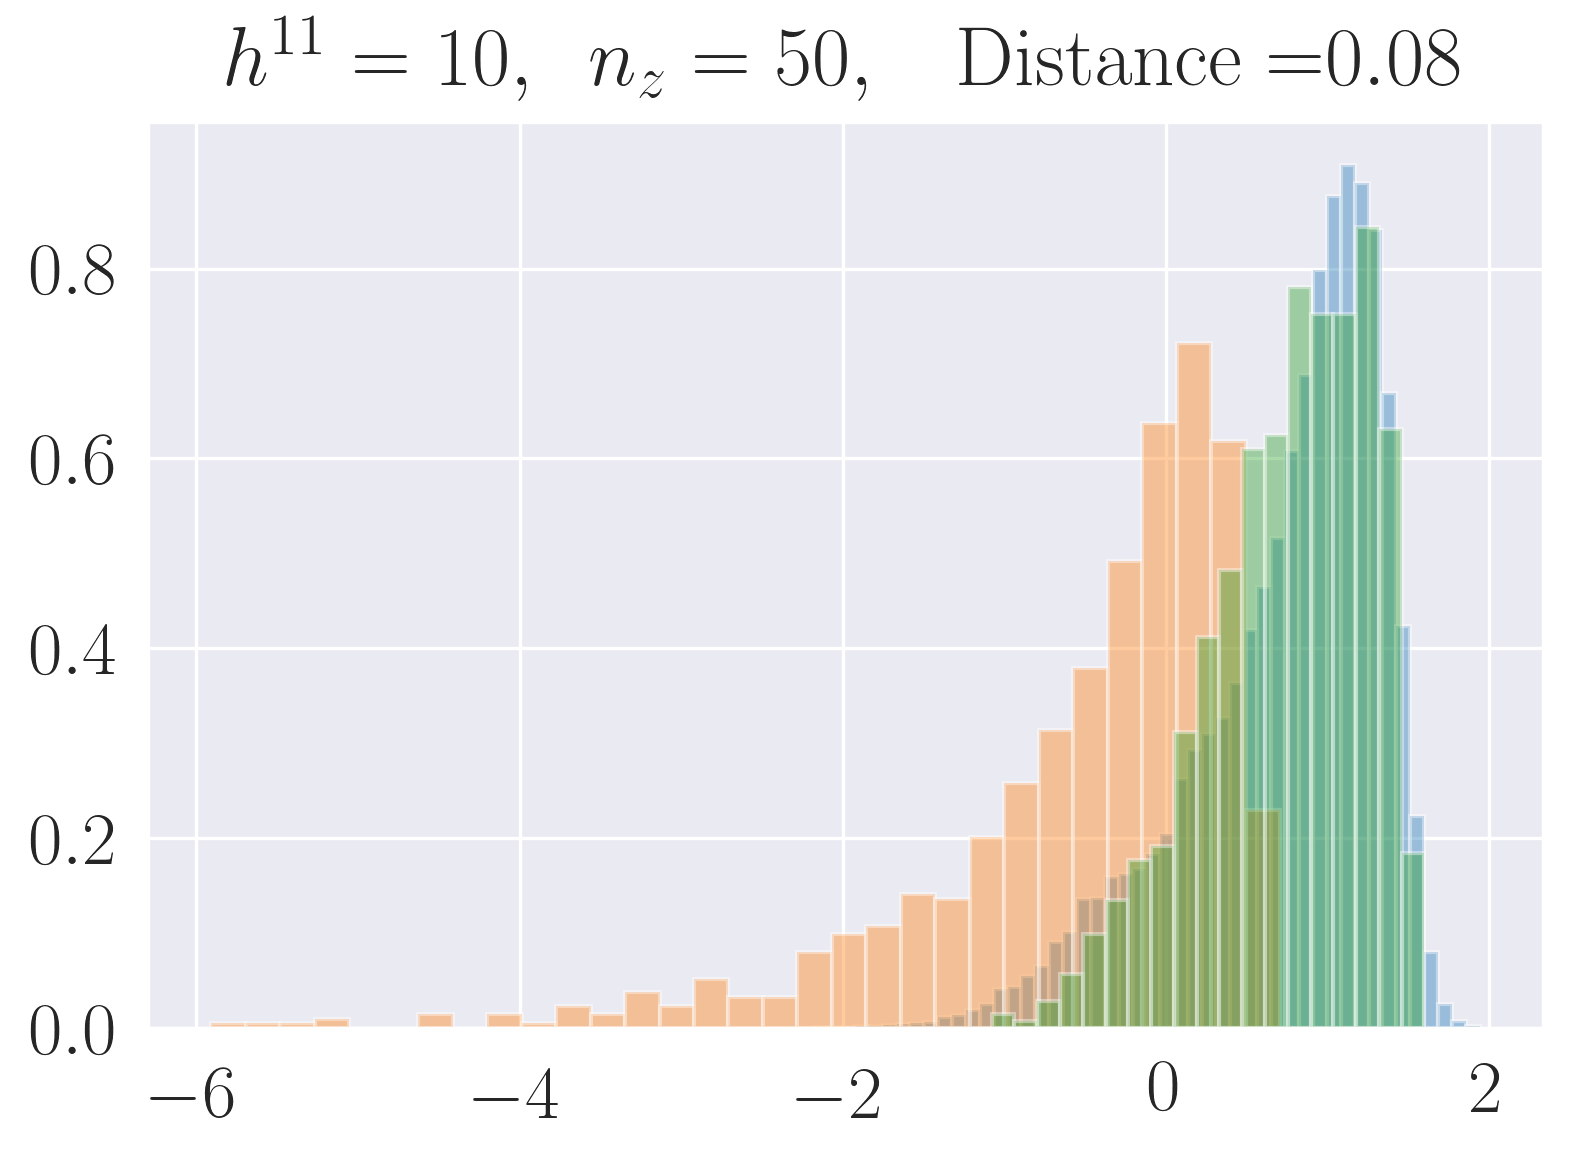

loading GAN: nz_vary_more_data/exp_h11_10_nz_60/netG_epoch_9000.pth 10 60
	epoch: 9000
Wasserstein Distance GAN (no log, log): 1.0970256317151839 0.0751832559454122
Wasserstein Distance Wishart (no log, log): 9.400518810196383 1.241639820365303


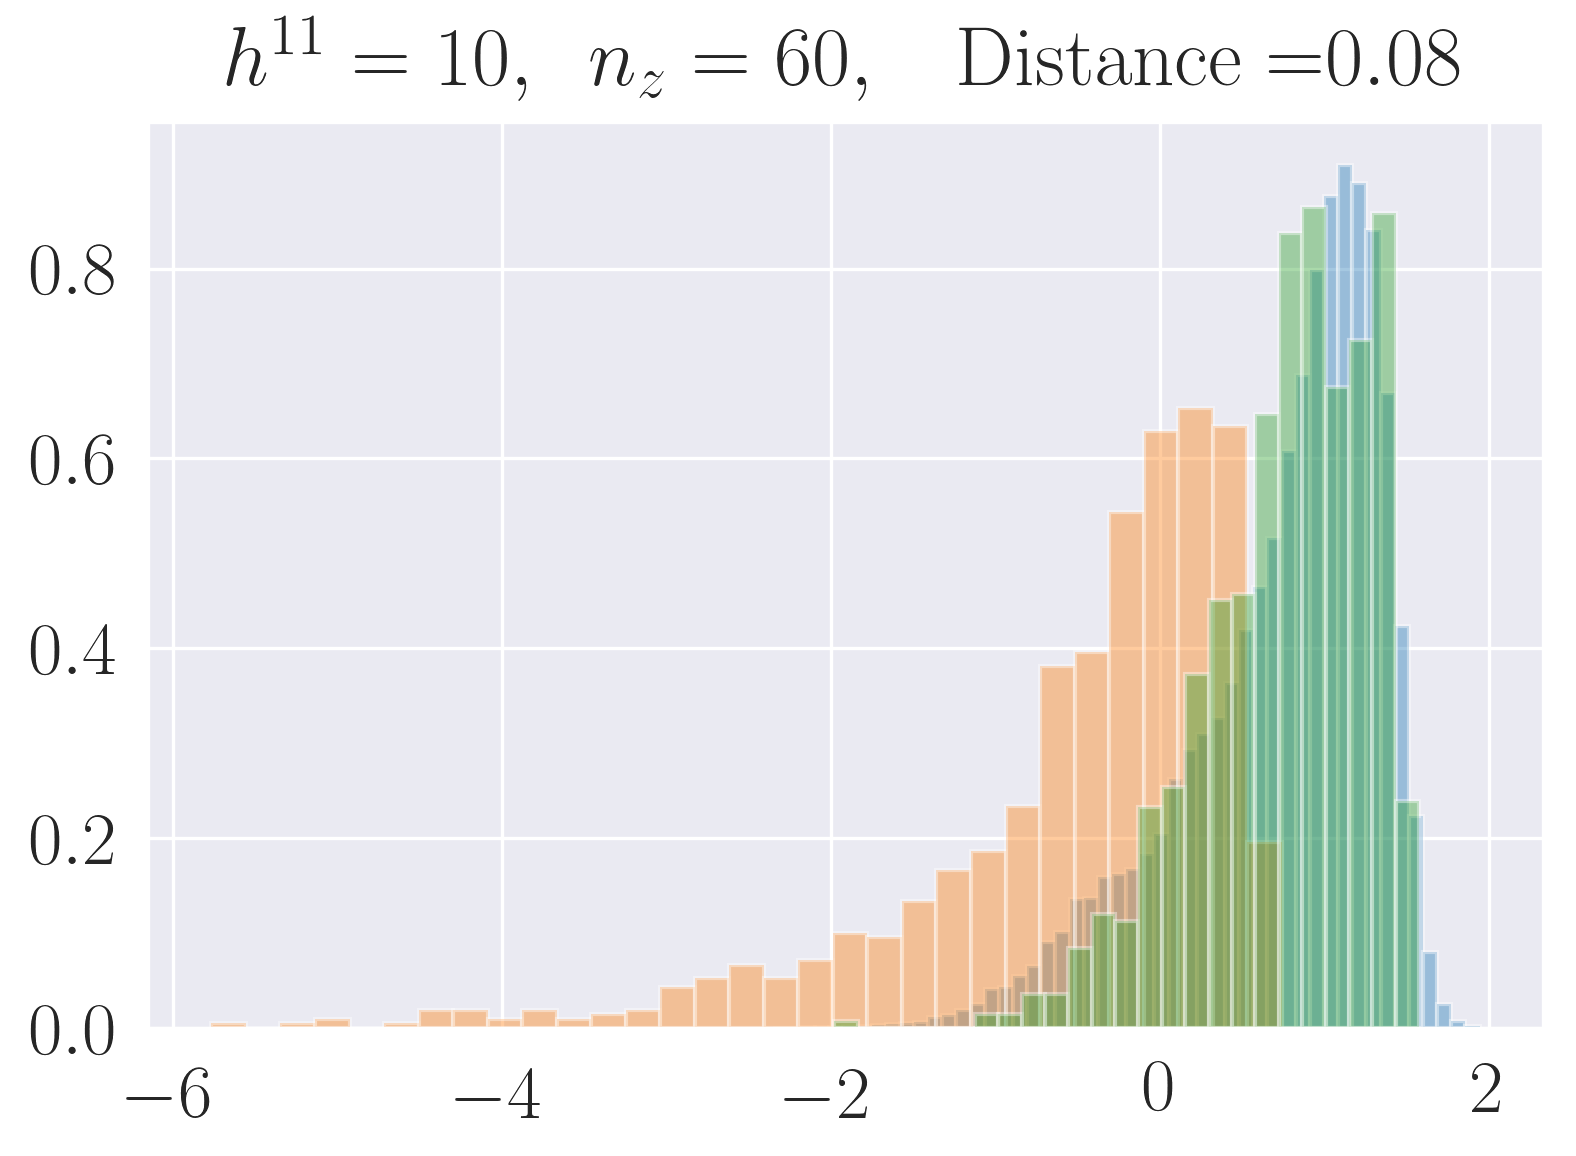

loading GAN: nz_vary_more_data/exp_h11_10_nz_80/netG_epoch_9000.pth 10 80
	epoch: 9000
Wasserstein Distance GAN (no log, log): 1.005666601625542 0.07994712042414114
Wasserstein Distance Wishart (no log, log): 9.422223863449663 1.2456423735550586


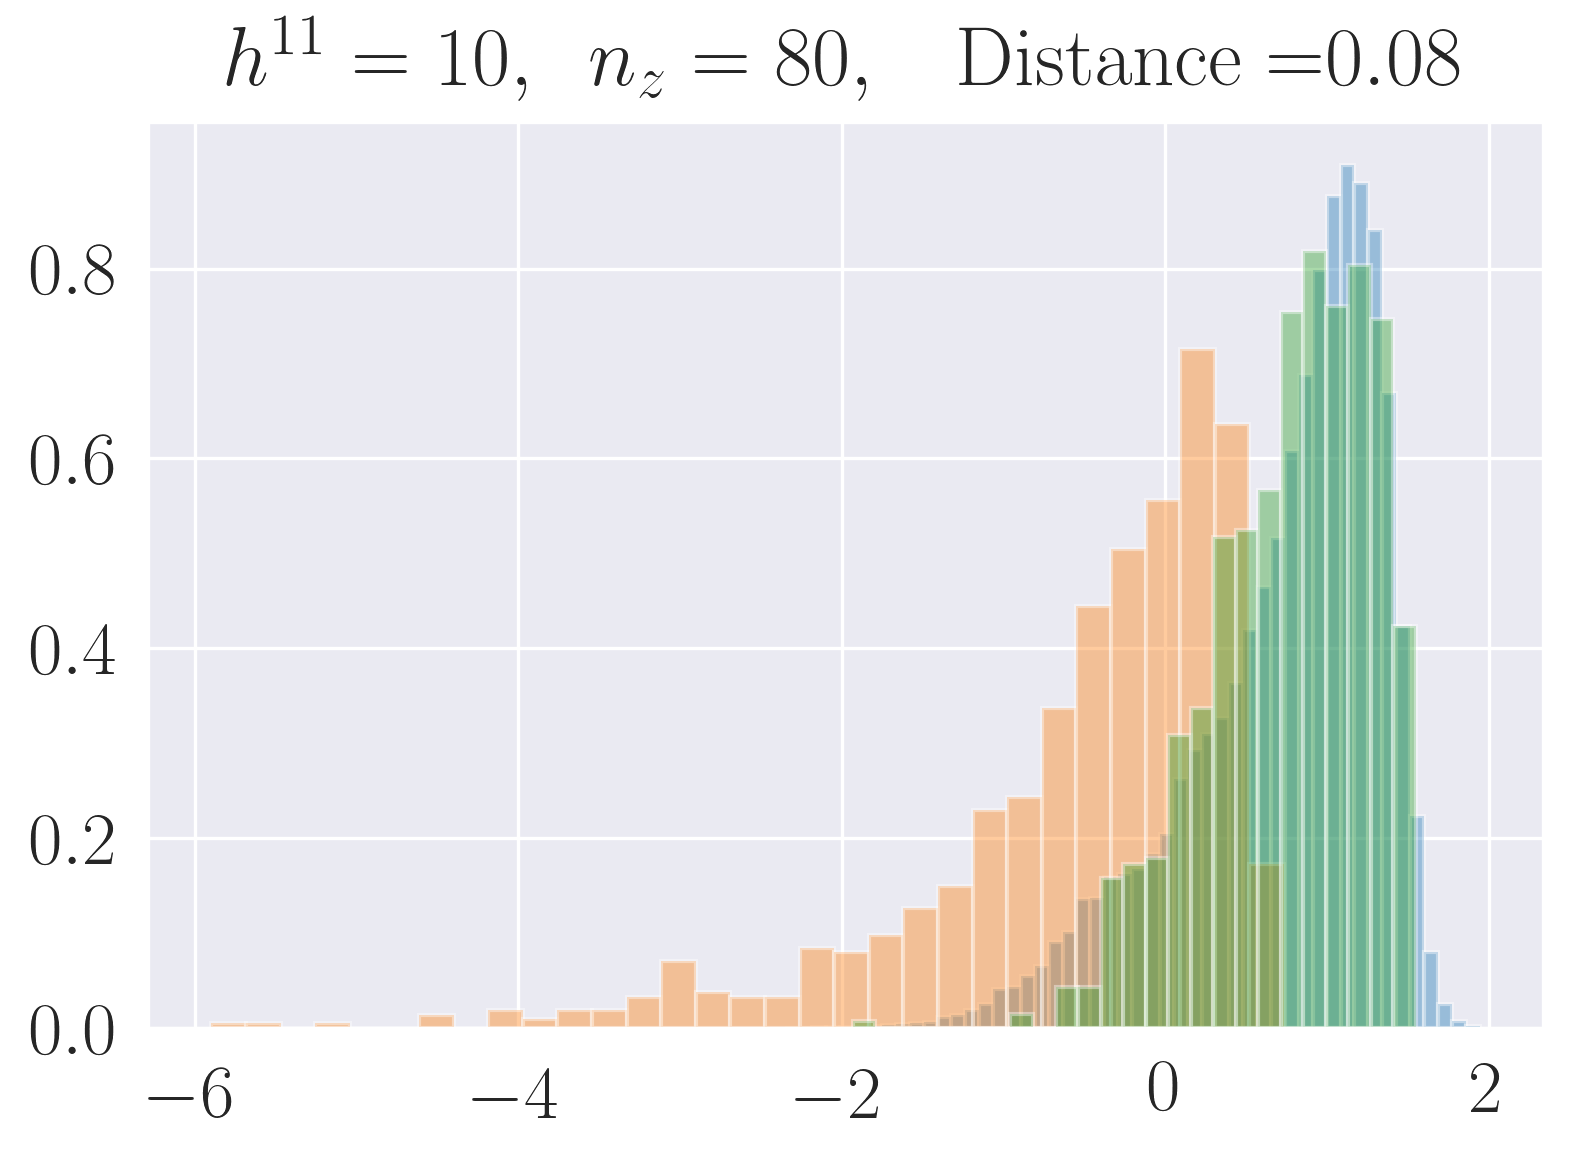

loading GAN: nz_vary_more_data/exp_h11_20_nz_5/netG_epoch_9000.pth 20 5
loading GAN: nz_vary_more_data/exp_h11_10_nz_20/netG_epoch_9000.pth 10 20
	epoch: 9000
Wasserstein Distance GAN (no log, log): 1.1346561697214617 0.08260234272663933
Wasserstein Distance Wishart (no log, log): 9.401381632088134 1.2327673193103788


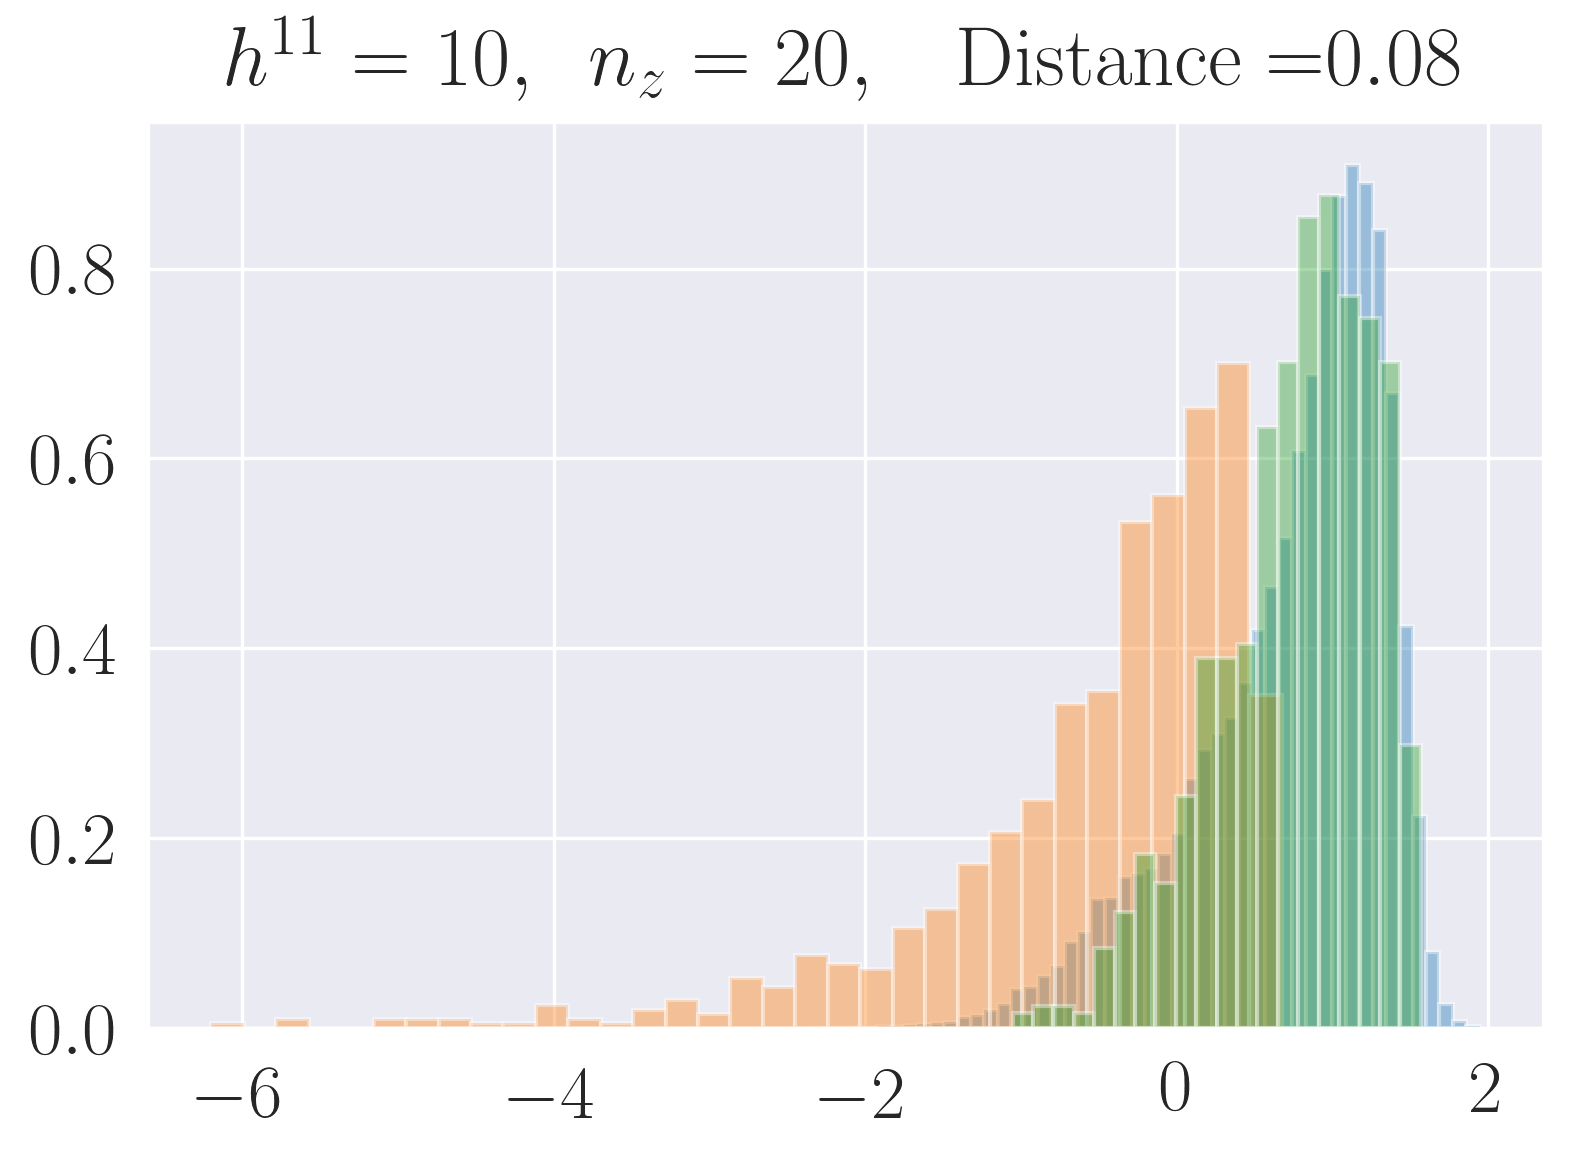

loading GAN: nz_vary_more_data/exp_h11_10_nz_10/netG_epoch_9000.pth 10 10
	epoch: 9000
Wasserstein Distance GAN (no log, log): 0.9672861304744552 0.0758844722310243
Wasserstein Distance Wishart (no log, log): 9.43280884374274 1.2391016661202834


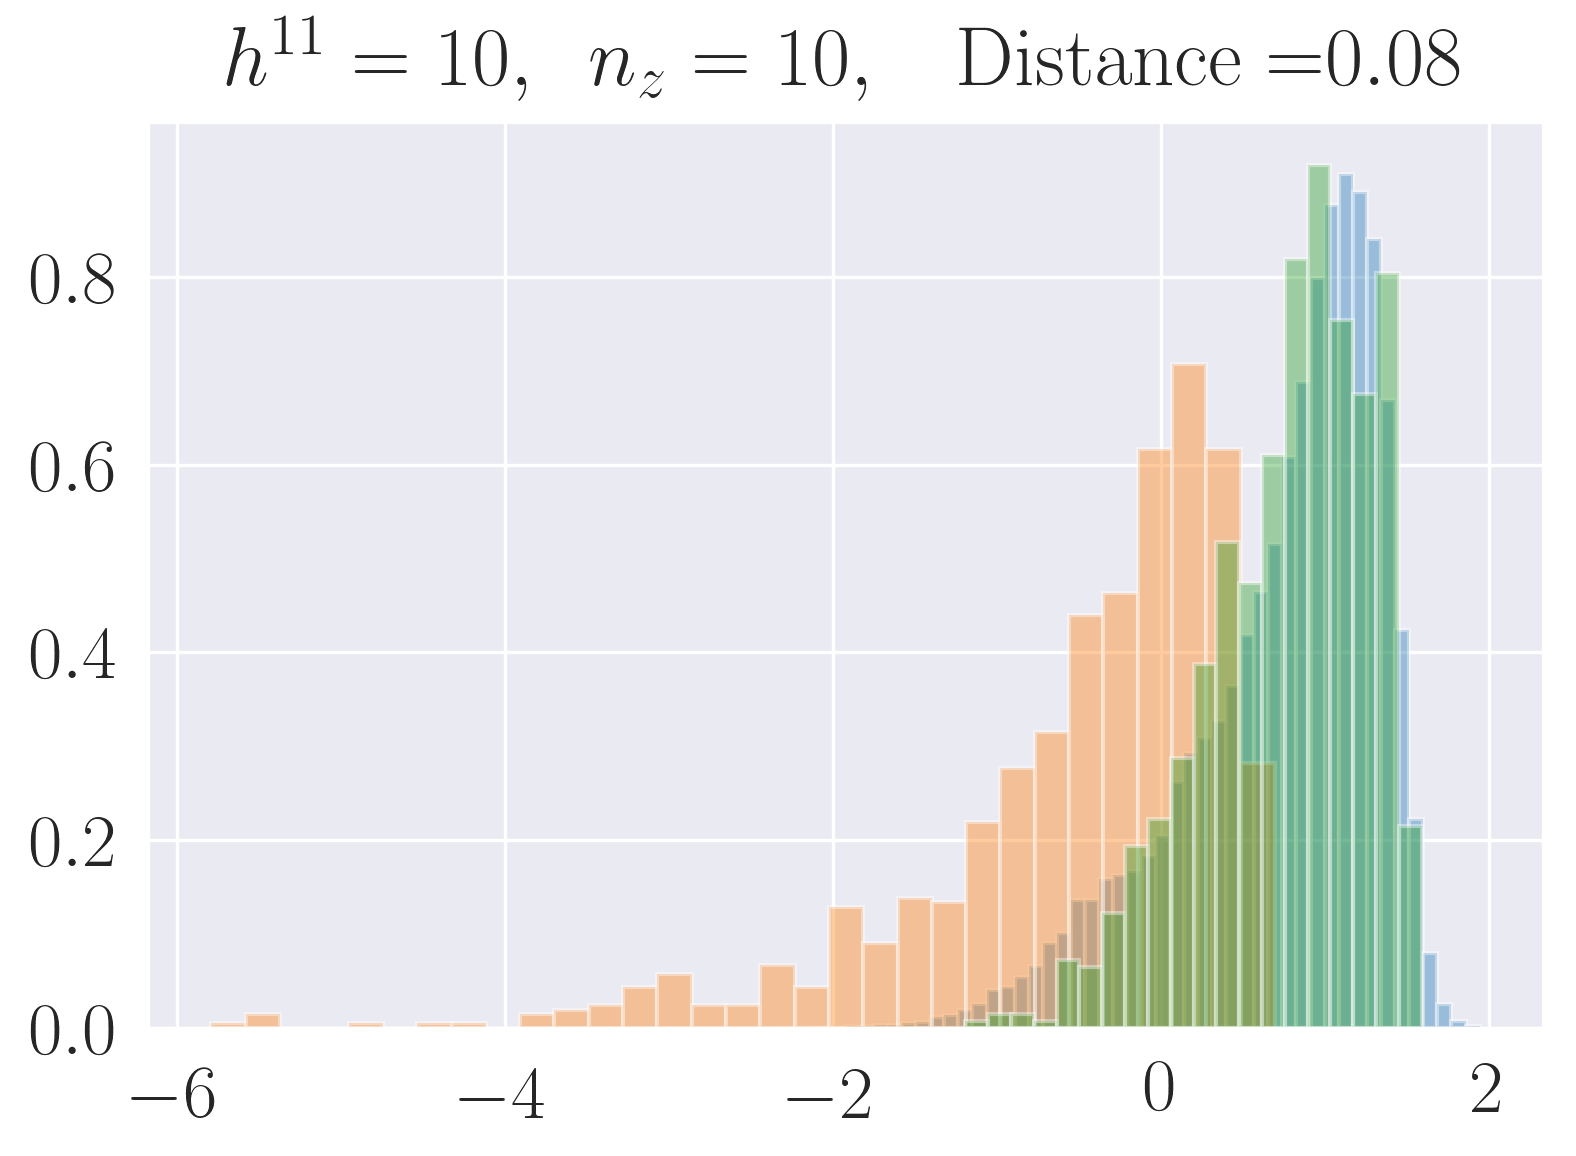

loading GAN: nz_vary_more_data/exp_h11_20_nz_70/netG_epoch_9000.pth 20 70
loading GAN: nz_vary_more_data/exp_h11_30_nz_10/netG_epoch_9000.pth 30 10
loading GAN: nz_vary_more_data/exp_h11_20_nz_40/netG_epoch_9000.pth 20 40
loading GAN: nz_vary_more_data/exp_h11_30_nz_80/netG_epoch_10000.pth 30 80
loading GAN: nz_vary_more_data/exp_h11_30_nz_20/netG_epoch_9000.pth 30 20
loading GAN: nz_vary_more_data/exp_h11_10_nz_1/netG_epoch_9000.pth 10 1
	epoch: 9000
Wasserstein Distance GAN (no log, log): 1.8753837181074149 0.06884033170196828
Wasserstein Distance Wishart (no log, log): 9.426802097178818 1.2495786932084691


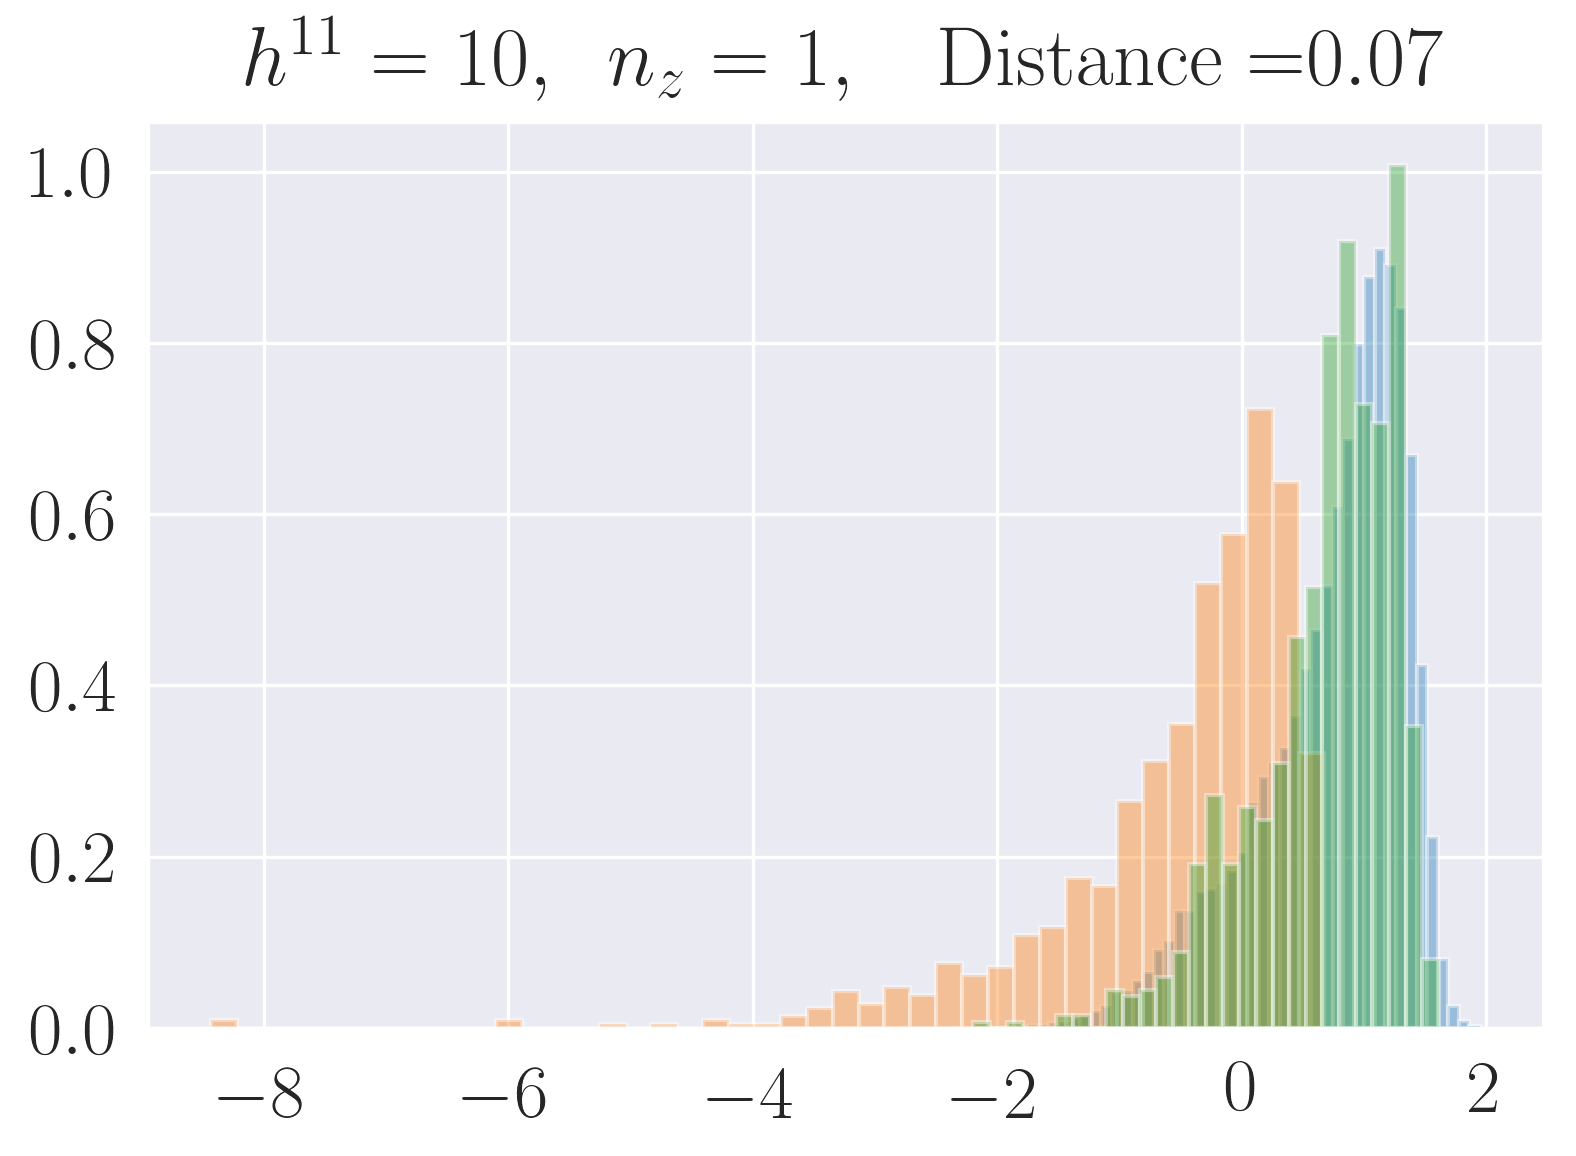

loading GAN: nz_vary_more_data/exp_h11_30_nz_90/netG_epoch_10000.pth 30 90
loading GAN: nz_vary_more_data/exp_h11_20_nz_50/netG_epoch_9000.pth 20 50
loading GAN: nz_vary_more_data/exp_h11_30_nz_30/netG_epoch_10000.pth 30 30
loading GAN: nz_vary_more_data/exp_h11_10_nz_100/netG_epoch_9000.pth 10 100
	epoch: 9000
Wasserstein Distance GAN (no log, log): 0.9041465448841834 0.07470841136950683
Wasserstein Distance Wishart (no log, log): 9.417963265222564 1.2155900794146677


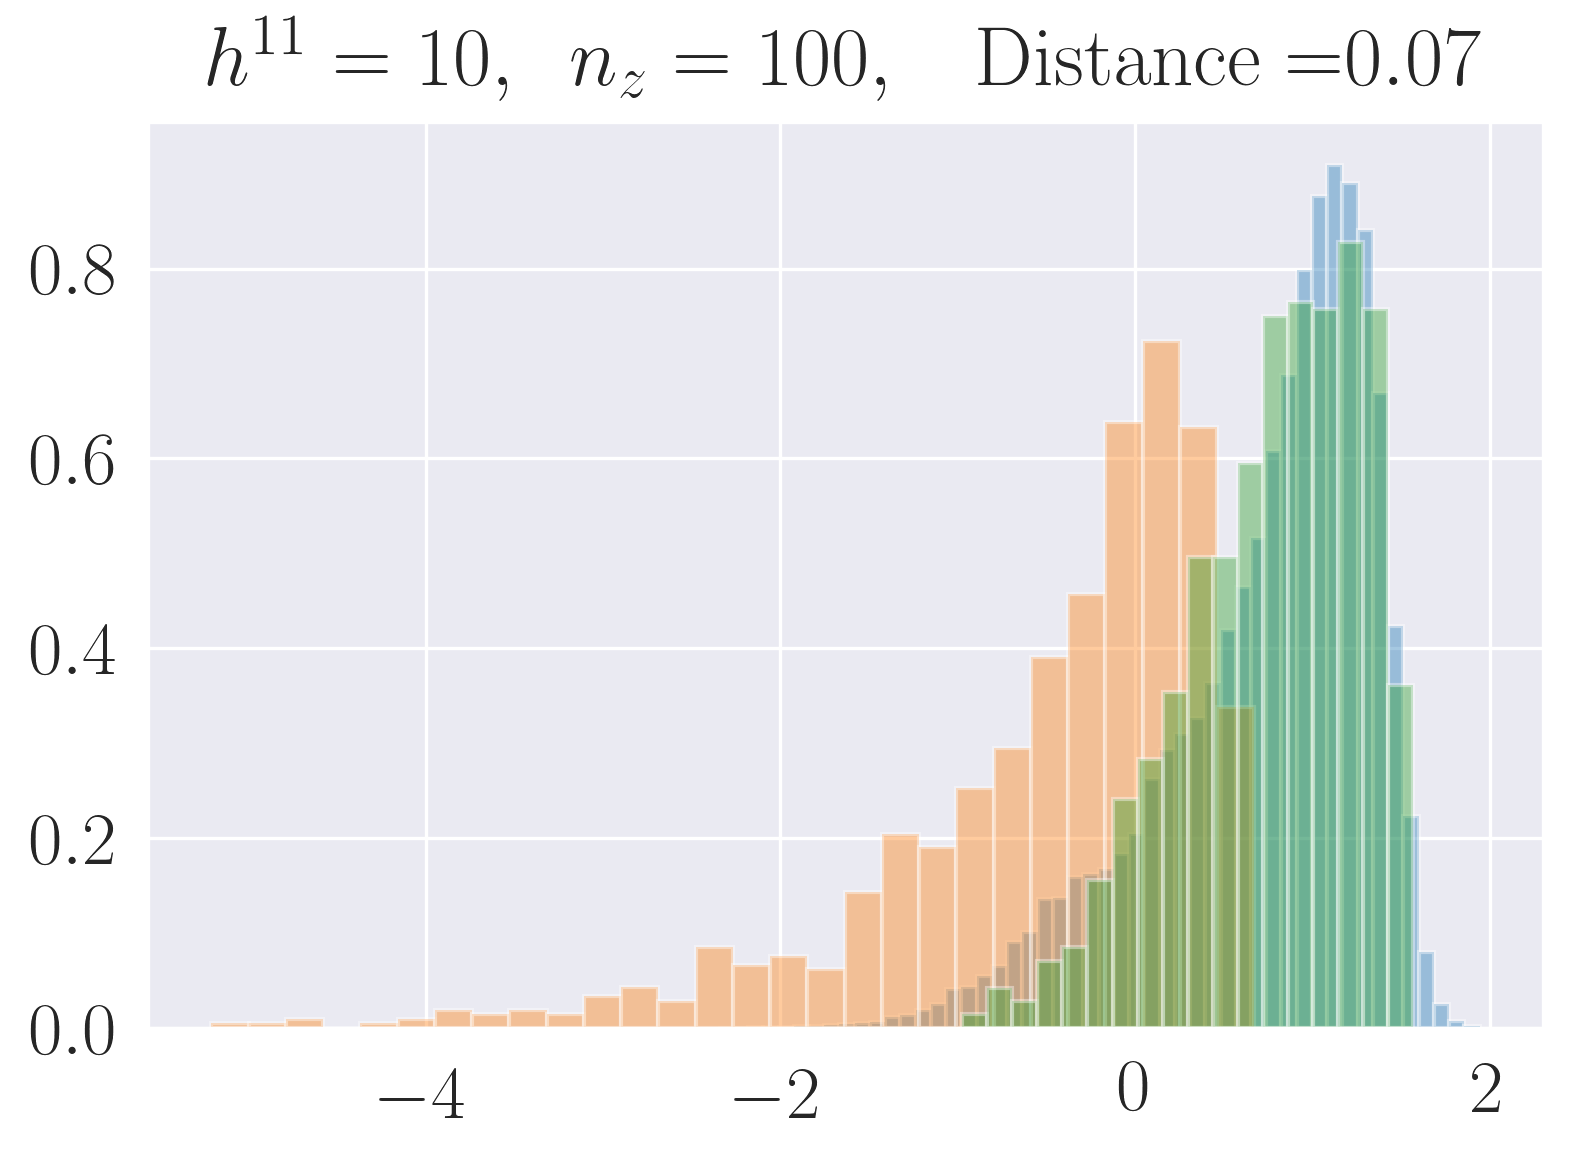

loading GAN: nz_vary_more_data/exp_h11_20_nz_60/netG_epoch_9000.pth 20 60
loading GAN: nz_vary_more_data/exp_h11_30_nz_1/netG_epoch_9000.pth 30 1
loading GAN: nz_vary_more_data/exp_h11_10_nz_90/netG_epoch_9000.pth 10 90
	epoch: 9000
Wasserstein Distance GAN (no log, log): 1.0105956661390652 0.08090545935039109
Wasserstein Distance Wishart (no log, log): 9.42395362981109 1.2436192697280444


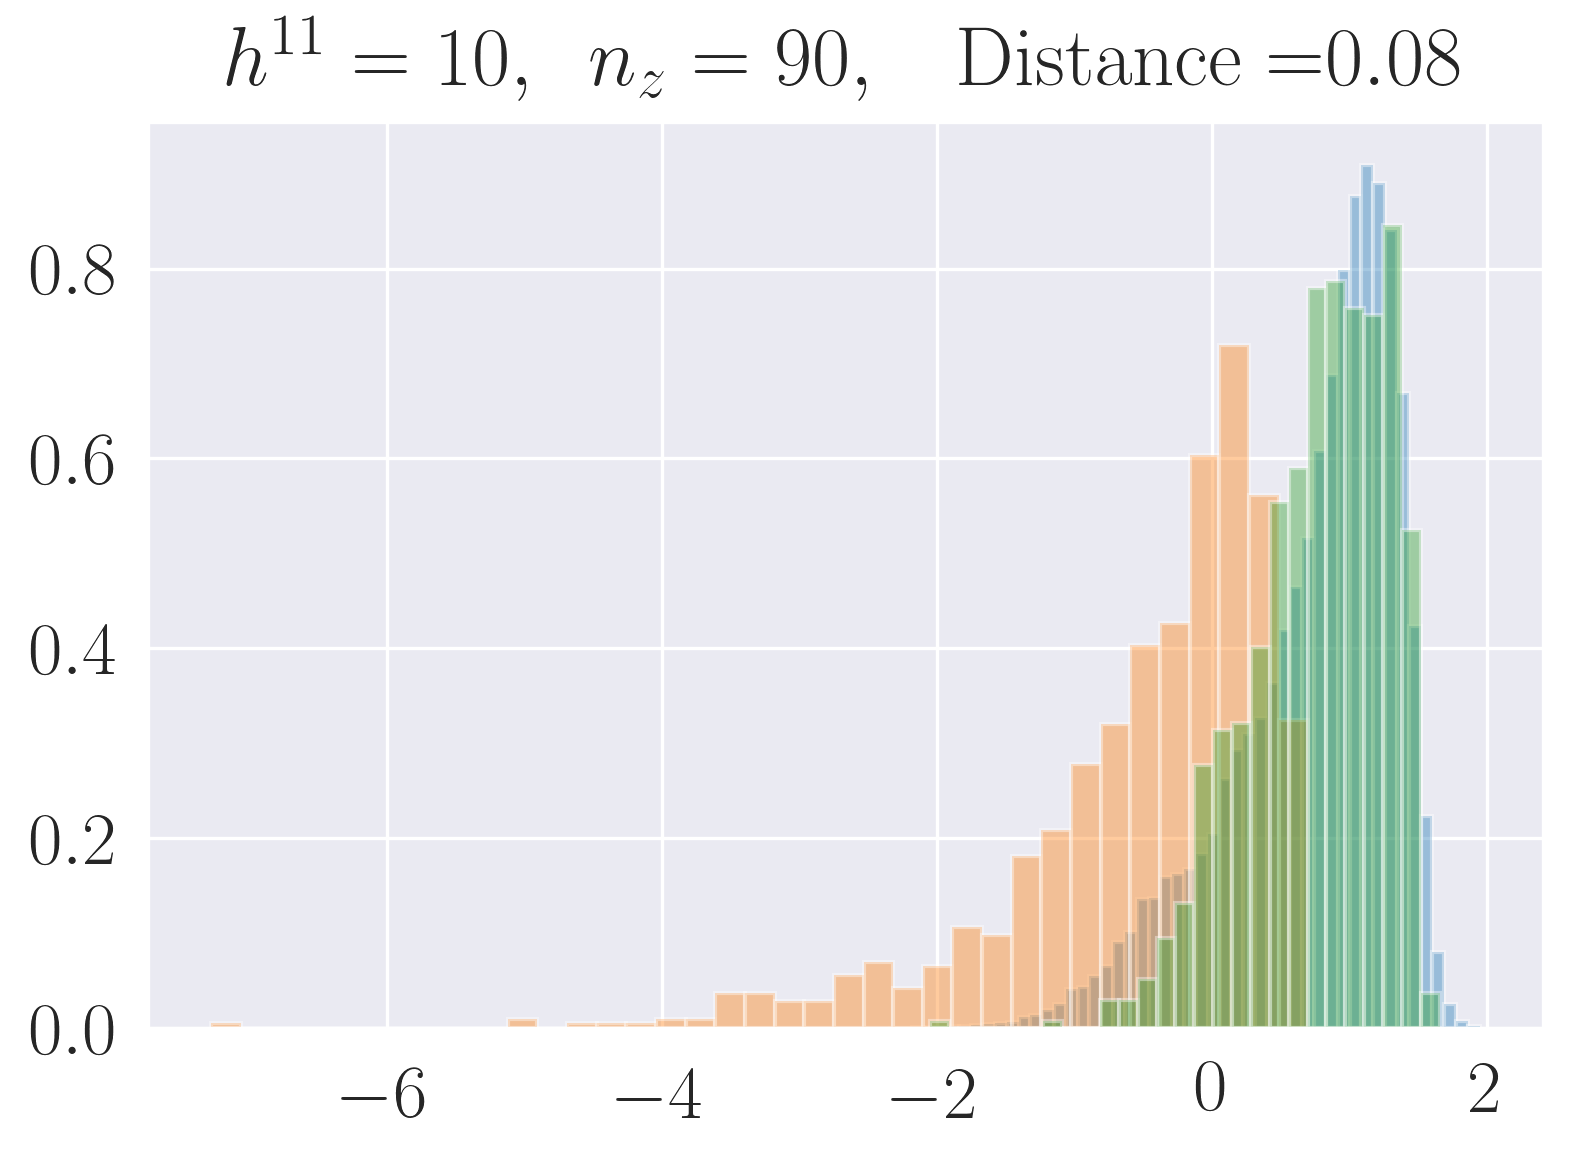

loading GAN: nz_vary_more_data/exp_h11_10_nz_30/netG_epoch_9000.pth 10 30
	epoch: 9000
Wasserstein Distance GAN (no log, log): 0.8341061727184322 0.07756059188535905
Wasserstein Distance Wishart (no log, log): 9.409298084681007 1.2314417302694005


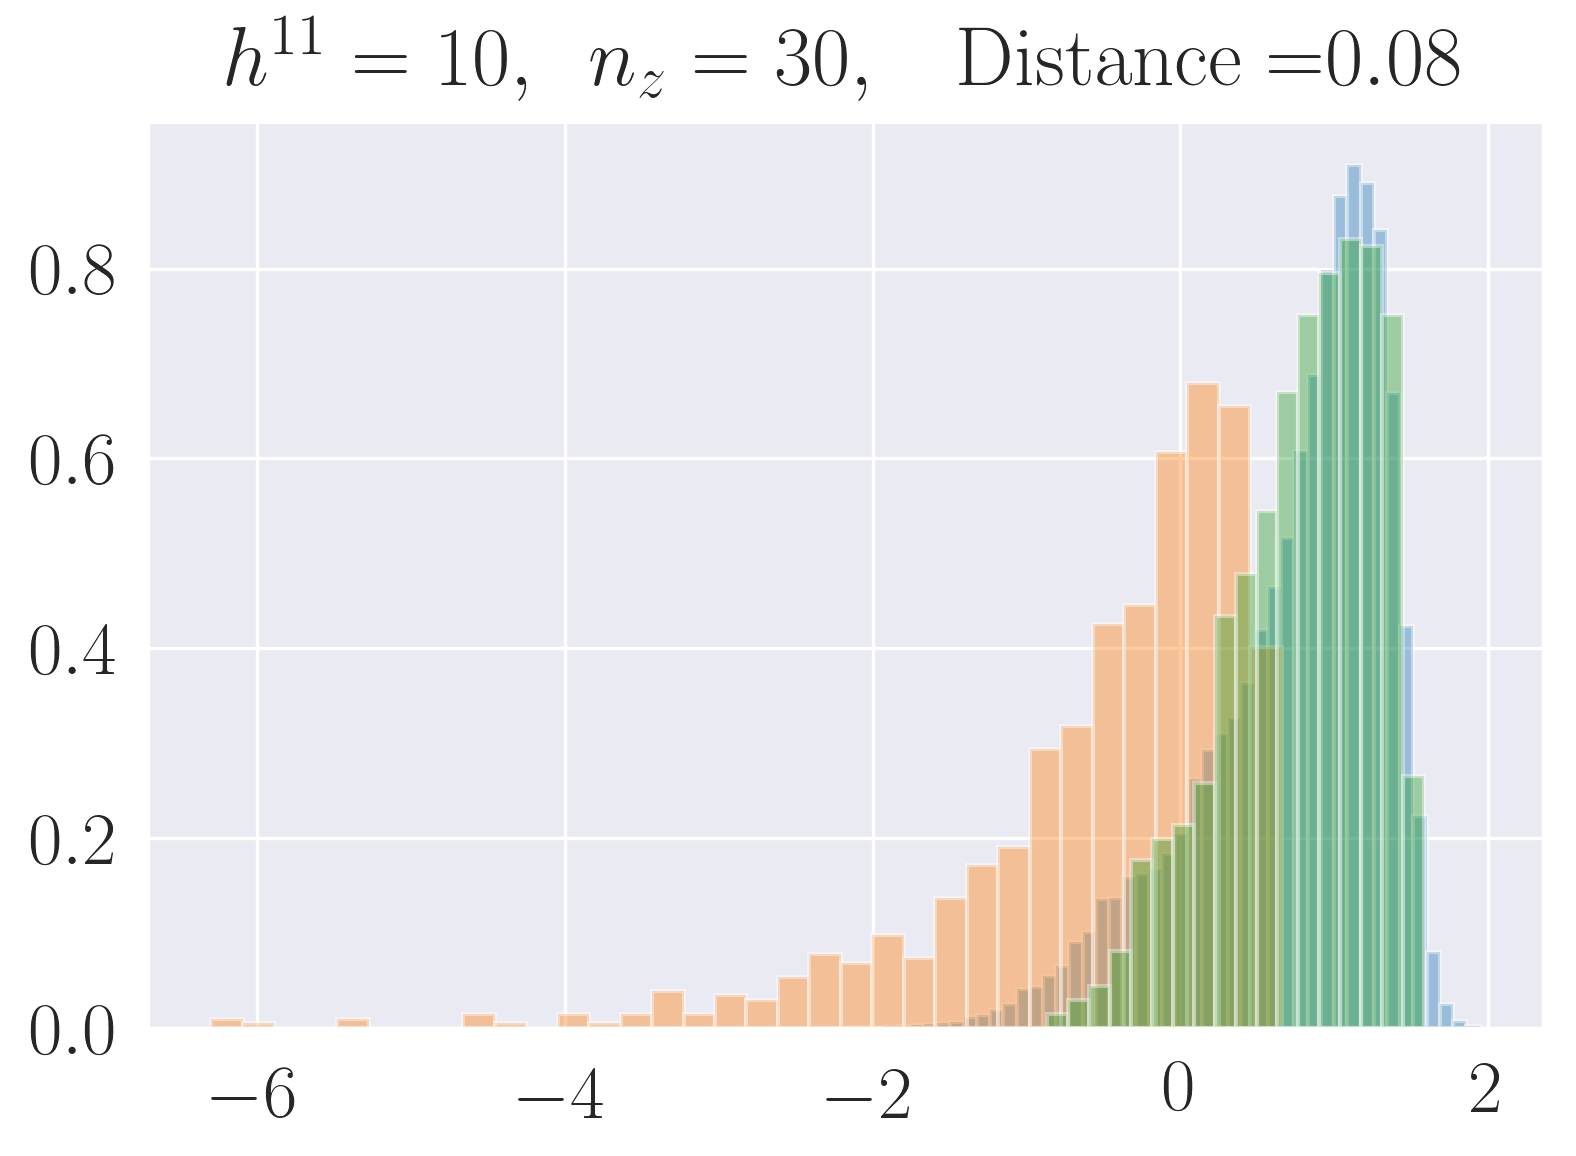

loading GAN: nz_vary_more_data/exp_h11_10_nz_70/netG_epoch_9000.pth 10 70
	epoch: 9000
Wasserstein Distance GAN (no log, log): 1.0993334327546174 0.08407229860236032
Wasserstein Distance Wishart (no log, log): 9.43168562319476 1.250625833328881


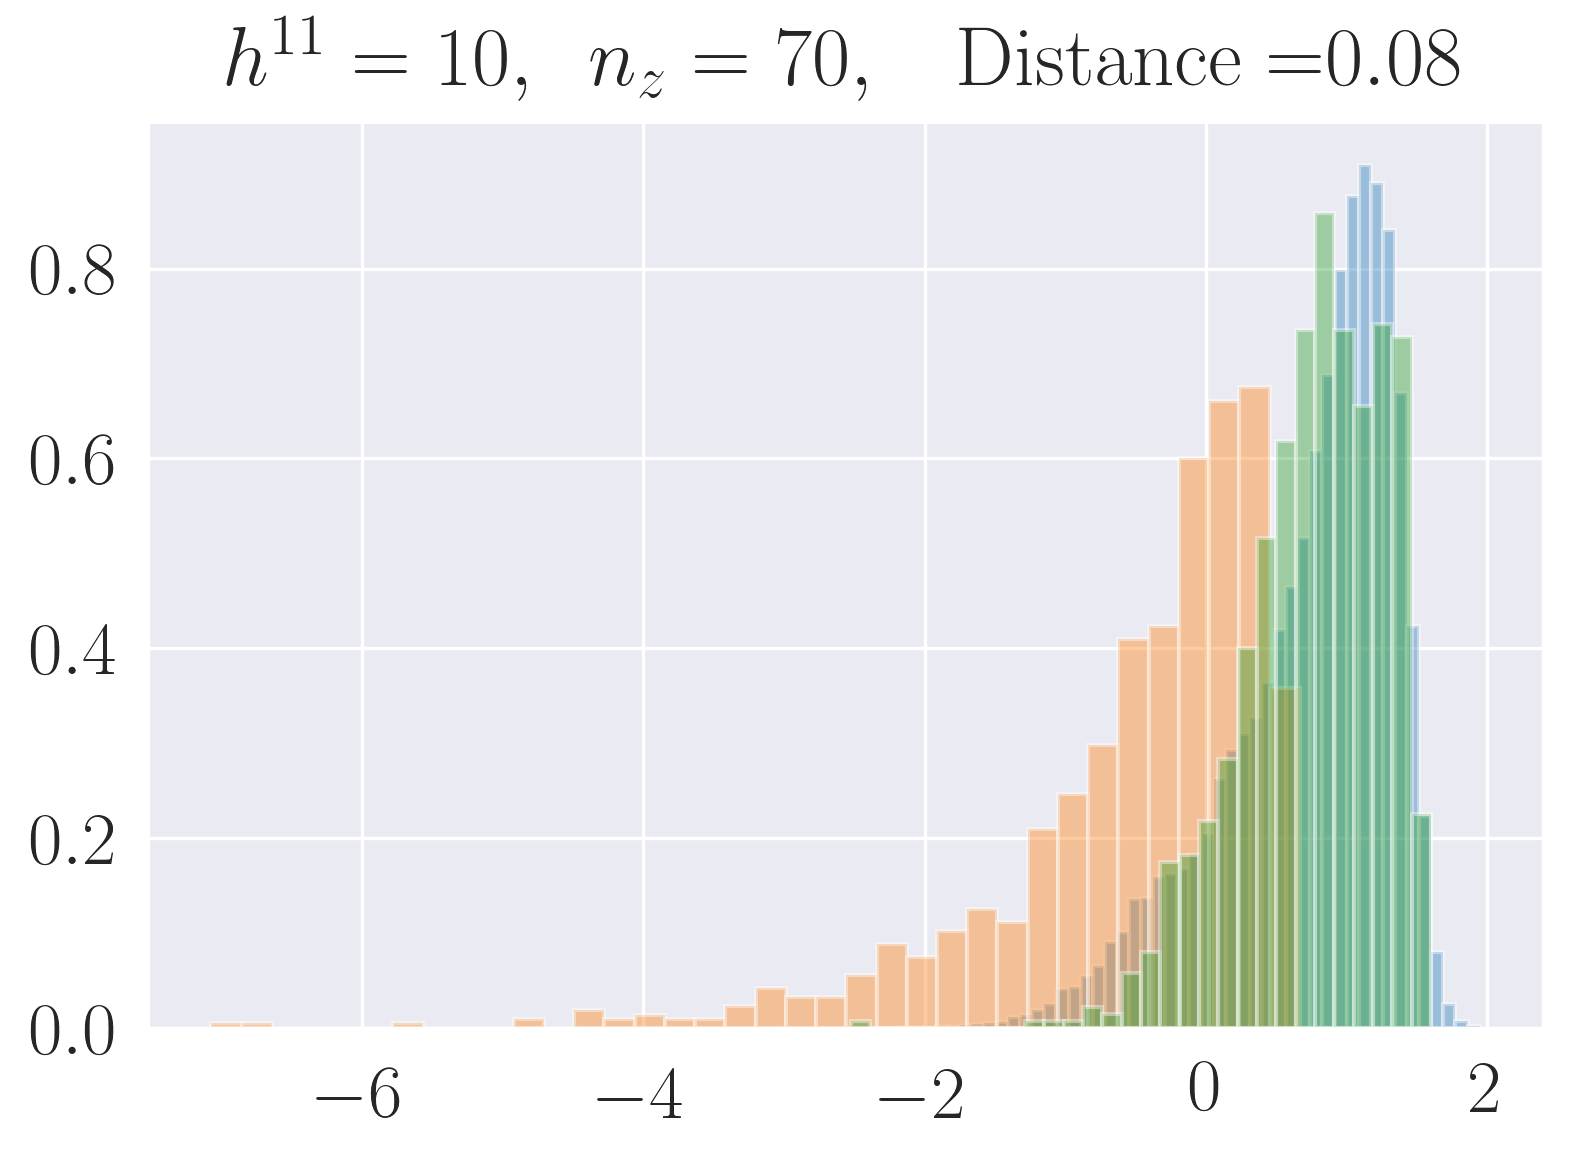

loading GAN: nz_vary_more_data/exp_h11_20_nz_1/netG_epoch_9000.pth 20 1
loading GAN: nz_vary_more_data/exp_h11_20_nz_100/netG_epoch_9000.pth 20 100
loading GAN: nz_vary_more_data/exp_h11_10_nz_40/netG_epoch_9000.pth 10 40
	epoch: 9000
Wasserstein Distance GAN (no log, log): 0.9262756249143529 0.08336919282665954
Wasserstein Distance Wishart (no log, log): 9.420123173492355 1.253649713619913


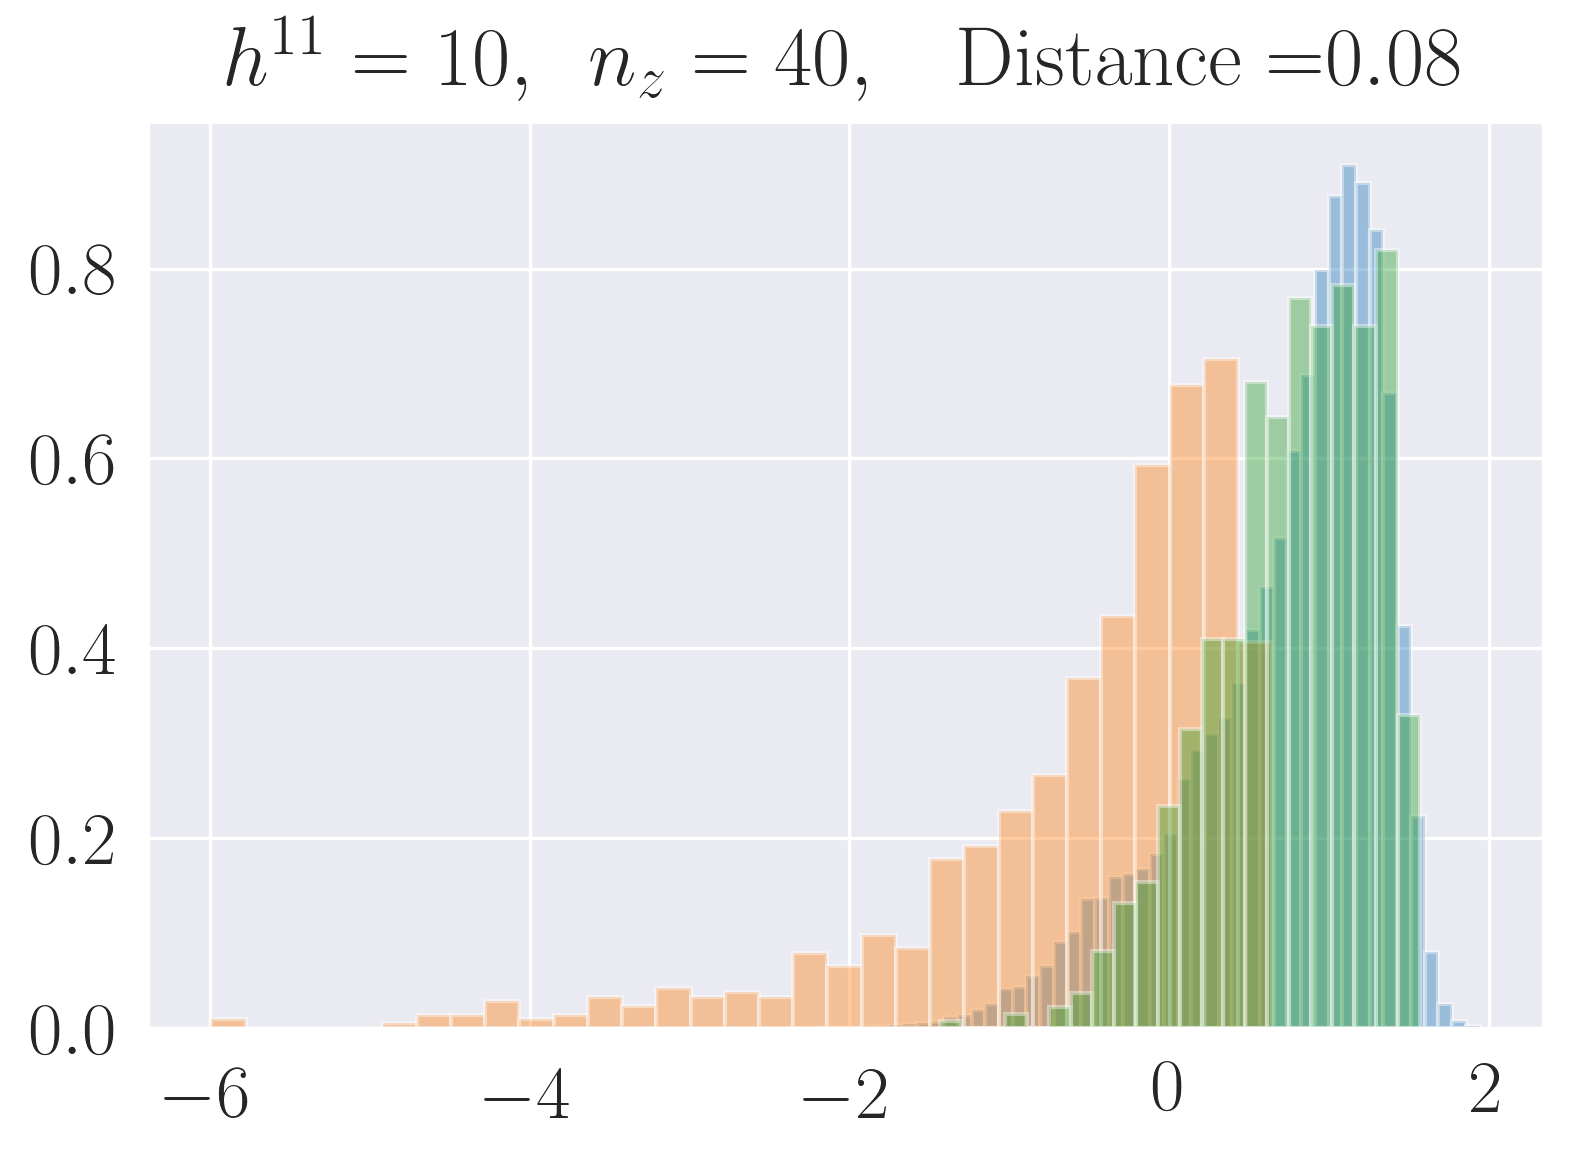

loading GAN: nz_vary_more_data/exp_h11_20_nz_20/netG_epoch_9000.pth 20 20
loading GAN: nz_vary_more_data/exp_h11_30_nz_100/netG_epoch_10000.pth 30 100
loading GAN: nz_vary_more_data/exp_h11_20_nz_80/netG_epoch_9000.pth 20 80
loading GAN: nz_vary_more_data/exp_h11_30_nz_40/netG_epoch_10000.pth 30 40
loading GAN: nz_vary_more_data/exp_h11_20_nz_10/netG_epoch_9000.pth 20 10
loading GAN: nz_vary_more_data/exp_h11_30_nz_70/netG_epoch_10000.pth 30 70


In [39]:
folders = ['./','nz_vary/','nz_vary_more_data/']
for folder in folders:
    exps = [k for k in os.listdir(folder) if 'exp' in k]
    #if 'extra' in exp: continue
    for exp in exps:
        if 'bump' in exp: continue
        path = folder + exp + '/'
        netG_paths = [path + d for d in os.listdir(path) if 'pth' in d and 'netG' in d]
        epochs = [int(k.split('_')[-1].split('.')[0]) for k in netG_paths]#print path
        if epochs == []: continue
        #print path, netG_paths
        last_G = max(epochs)
        #print epochs, last_G
        thePath = [k for k in netG_paths if '_'+str(last_G)+'.pth' in k]
        assert len(thePath) == 1
        thePath = thePath[0]
        #print thePath
        
        nz = 100 # default
        if 'nz' in exp:
            s = exp.split('_')
            #print exp
            nz = int(s[s.index('nz')+1])
            h11 = int(s[s.index('h11')+1])
            
        print 'loading GAN:', thePath, h11, nz
        if h11 != 10: continue
        try:
            _, epoch, GAN = load_DCGAN(thePath,nz=nz,h11=h11)
            print '\tepoch:',epoch
            show_GAN_histogram(GAN, h11=h11, batchSize = 100, nz=nz)
        except RuntimeError:
            print "Runtime Error on:", thePath